### Imports

In [15]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt
import random
import os

In [16]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

### Create Environment

In [17]:
class TradingEnv(gym.Env):
    """
    Long-only Trading Environment.
    Actions:
        0 = Hold
        1 = Buy (go long)
        2 = Sell (close position)
    Observations:
        Flattened window of normalized features + position flag.
    Reward:
        Log-change in portfolio value minus turnover penalty.
    """

    def __init__(
        self,
        df,
        feature_cols=None,
        window_size=100,
        transaction_cost=0.001,
        initial_balance=1.0,
        reward_scaling=1.0,
        deterministic=True,
        turnover_penalty=0.0005,
    ):
        super().__init__()
        self.df = df.copy()
        self.feature_cols = feature_cols or [
            "log_return",
            "SMA_short",
            "SMA_long",
            "volatility",
            "open_close_ratio",
            "high_low_range",
            "volume_zscore",
        ]
        self.window_size = window_size
        self.transaction_cost = transaction_cost
        self.initial_balance = initial_balance
        self.reward_scaling = reward_scaling
        self.deterministic = deterministic
        self.turnover_penalty = turnover_penalty

        self.start_index = self.window_size
        self.end_index = len(self.df) - 1

        self.action_space = spaces.Discrete(3)
        self.n_features = len(self.feature_cols)
        obs_len = self.window_size * self.n_features + 1
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(obs_len,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

        self.current_step = (
            self.start_index
            if self.deterministic
            else np.random.randint(self.start_index, self.end_index - 1)
        )

        self.position = 0
        self.cash = self.initial_balance
        self.invested = 0.0
        self.entry_price = 0.0
        self.portfolio_value = self.cash
        self.trades = []

        return self._get_obs(), {}

    def _get_obs(self):
        start = self.current_step - self.window_size + 1
        end = self.current_step + 1
        window = self.df.iloc[start:end][self.feature_cols].values

        mean = window.mean(axis=0)
        std = window.std(axis=0) + 1e-9
        norm_window = (window - mean) / std

        obs = np.concatenate(
            [norm_window.flatten(), np.array([self.position], dtype=np.float32)]
        )
        return obs.astype(np.float32)

    def step(self, action):
        assert self.action_space.contains(action)
        done = False
        info = {}

        prev_portfolio_value = self.portfolio_value
        price_now = float(self.df["Close"].iloc[self.current_step])
        price_next = float(self.df["Close"].iloc[self.current_step + 1])
        prev_position = self.position

        # --- Action Handling ---
        if action == 1 and self.position == 0:  # Buy
            trade_notional = self.cash
            cost = self.transaction_cost * trade_notional
            self.invested = self.cash - cost
            self.entry_price = price_now
            self.position = 1
            self.cash = 0.0
            self.trades.append(
                (self.current_step, "BUY", price_now, self.portfolio_value)
            )

        elif action == 2 and self.position == 1:  # Sell
            current_value = self.invested * (price_now / self.entry_price)
            trade_notional = current_value
            cost = self.transaction_cost * trade_notional
            self.cash = current_value - cost
            self.invested = 0.0
            self.entry_price = 0.0
            self.position = 0
            self.trades.append((self.current_step, "SELL", price_now, self.cash))

        # Update portfolio value at next price
        if self.position == 1:
            asset_value_next = self.invested * (price_next / self.entry_price)
            self.portfolio_value = asset_value_next
        else:
            self.portfolio_value = self.cash

        # --- Reward ---
        # log-return of portfolio value (more stable)
        reward = np.log(self.portfolio_value / max(prev_portfolio_value, 1e-9))
        # small penalty for changing position (reduces churn)
        turnover = abs(self.position - prev_position)
        reward -= self.turnover_penalty * turnover
        reward *= self.reward_scaling

        self.current_step += 1
        if self.current_step >= self.end_index:
            done = True

        obs = self._get_obs()
        return obs, float(reward), done, False, info

    def render(self, mode="human"):
        print(
            f"Step {self.current_step}, Pos {self.position}, "
            f"Cash {self.cash:.4f}, Invested {self.invested:.4f}, "
            f"Portfolio {self.portfolio_value:.4f}"
        )

    def close(self):
        pass

In [18]:
# Load processed dataset
df = pd.read_csv("data.csv", index_col=0, parse_dates=True)
df = df.sort_index()

# Train/Test Split
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Feature columns
feature_cols = [
    "log_return",
    "SMA_short",
    "SMA_long",
    "volatility",
    "open_close_ratio",
    "high_low_range",
    "volume_zscore",
]

# Environments
env = TradingEnv(train_df, feature_cols=feature_cols, deterministic=False)
test_env = TradingEnv(test_df, feature_cols=feature_cols, deterministic=True)

# Training env with normalization
vec_env = DummyVecEnv([lambda: env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# Evaluation env with same normalization wrapper
test_vec_env = DummyVecEnv([lambda: test_env])
test_vec_env = VecNormalize(
    test_vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0
)
test_vec_env.training = False
test_vec_env.norm_reward = False

### Train model

In [19]:
log_dir = "./tb_logs/"
tb_name = "ppo_trading"


model = PPO(
    policy_kwargs=dict(activation_fn=torch.nn.ReLU, net_arch=[256, 256]),
    policy="MlpPolicy",
    env=vec_env,
    verbose=1,
    tensorboard_log=log_dir,
    learning_rate=lambda p: 3e-4 * p,
    n_steps=4096,
    batch_size=128,
    n_epochs=20,
    gamma=0.999,
    ent_coef=0.01,
    device="cpu",
)

eval_callback = EvalCallback(
    test_vec_env,
    best_model_save_path="./models/",
    log_path="./models/",
    eval_freq=5000,
    deterministic=True,
    render=False,
)

model.learn(total_timesteps=10_000_000, tb_log_name=tb_name, callback=[eval_callback])

Using cpu device
Logging to ./tb_logs/ppo_trading_7


-----------------------------
| time/              |      |
|    fps             | 1323 |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 4096 |
-----------------------------


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0184     |
| time/                   |            |
|    total_timesteps      | 5000       |
| train/                  |            |
|    approx_kl            | 0.04000389 |
|    clip_fraction        | 0.432      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.07      |
|    explained_variance   | -2.46      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.122     |
|    n_updates            | 20         |
|    policy_gradient_loss | -0.0829    |
|    value_loss           | 0.018      |
----------------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 815  |
|    iterations      | 2    |
|    time_elapsed    | 10   |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.332      |
| time/                   |            |
|    total_timesteps      | 10000      |
| train/                  |            |
|    approx_kl            | 0.04329692 |
|    clip_fraction        | 0.496      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.02      |
|    explained_variance   | 0.268      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.117     |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.0962    |
|    value_loss           | 0.00608    |
----------------------------------------
New best mean reward!
------------------------------
| time/              |       |
|    fps             | 769   |
|    iterations      | 3     |
|    time_elapsed    | 15    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=15000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.263      |
| time/                   |             |
|    total_timesteps      | 15000       |
| train/                  |             |
|    approx_kl            | 0.041844983 |
|    clip_fraction        | 0.516       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.976      |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.102      |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.087      |
|    value_loss           | 0.00417     |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 762   |
|    iterations      | 4     |
|    time_elapsed    | 21    |
|

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=20000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.3       |
| time/                   |            |
|    total_timesteps      | 20000      |
| train/                  |            |
|    approx_kl            | 0.05729384 |
|    clip_fraction        | 0.544      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.941     |
|    explained_variance   | 0.764      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.123     |
|    n_updates            | 80         |
|    policy_gradient_loss | -0.1       |
|    value_loss           | 0.00385    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 739   |
|    iterations      | 5     |
|    time_elapsed    | 27    |
|    total_timestep

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=25000, episode_reward=-0.56 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.557      |
| time/                   |             |
|    total_timesteps      | 25000       |
| train/                  |             |
|    approx_kl            | 0.082520664 |
|    clip_fraction        | 0.575       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.856      |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.000299    |
|    loss                 | -0.135      |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.105      |
|    value_loss           | 0.00366     |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 690   |
|    iterations      | 7     |
|    time_elapsed    | 41    |
|

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=30000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0815   |
| time/                   |           |
|    total_timesteps      | 30000     |
| train/                  |           |
|    approx_kl            | 0.0921961 |
|    clip_fraction        | 0.554     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.777    |
|    explained_variance   | 0.909     |
|    learning_rate        | 0.000299  |
|    loss                 | -0.123    |
|    n_updates            | 140       |
|    policy_gradient_loss | -0.0963   |
|    value_loss           | 0.00278   |
---------------------------------------
------------------------------
| time/              |       |
|    fps             | 676   |
|    iterations      | 8     |
|    time_elapsed    | 48    |
|    total_timesteps | 32768 |
------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=35000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.357     |
| time/                   |            |
|    total_timesteps      | 35000      |
| train/                  |            |
|    approx_kl            | 0.11076257 |
|    clip_fraction        | 0.572      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.754     |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.000299   |
|    loss                 | -0.136     |
|    n_updates            | 160        |
|    policy_gradient_loss | -0.102     |
|    value_loss           | 0.0021     |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 675   |
|    iterations      | 9     |
|    time_elapsed    | 54    |
|    total_timestep

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=40000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.213     |
| time/                   |            |
|    total_timesteps      | 40000      |
| train/                  |            |
|    approx_kl            | 0.11181137 |
|    clip_fraction        | 0.528      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.68      |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000299   |
|    loss                 | -0.0996    |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.0809    |
|    value_loss           | 0.00211    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 684   |
|    iterations      | 10    |
|    time_elapsed    | 59    |
|    total_timestep

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=45000, episode_reward=0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.219      |
| time/                   |            |
|    total_timesteps      | 45000      |
| train/                  |            |
|    approx_kl            | 0.12930222 |
|    clip_fraction        | 0.495      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.627     |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000299   |
|    loss                 | -0.105     |
|    n_updates            | 200        |
|    policy_gradient_loss | -0.0863    |
|    value_loss           | 0.00195    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 692   |
|    iterations      | 11    |
|    time_elapsed    | 65    |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=50000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0345   |
| time/                   |           |
|    total_timesteps      | 50000     |
| train/                  |           |
|    approx_kl            | 0.1335623 |
|    clip_fraction        | 0.51      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.614    |
|    explained_variance   | 0.952     |
|    learning_rate        | 0.000299  |
|    loss                 | -0.0716   |
|    n_updates            | 240       |
|    policy_gradient_loss | -0.0686   |
|    value_loss           | 0.00118   |
---------------------------------------
------------------------------
| time/              |       |
|    fps             | 715   |
|    iterations      | 13    |
|    time_elapsed    | 74    |
|    total_timesteps | 53248 |
------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=55000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.026      |
| time/                   |            |
|    total_timesteps      | 55000      |
| train/                  |            |
|    approx_kl            | 0.13372397 |
|    clip_fraction        | 0.499      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.598     |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.000298   |
|    loss                 | -0.0798    |
|    n_updates            | 260        |
|    policy_gradient_loss | -0.0709    |
|    value_loss           | 0.00169    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 719   |
|    iterations      | 14    |
|    time_elapsed    | 79    |
|    total_timesteps

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=60000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.101     |
| time/                   |            |
|    total_timesteps      | 60000      |
| train/                  |            |
|    approx_kl            | 0.14034921 |
|    clip_fraction        | 0.466      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.551     |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000298   |
|    loss                 | -0.0871    |
|    n_updates            | 280        |
|    policy_gradient_loss | -0.0731    |
|    value_loss           | 0.00137    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 723   |
|    iterations      | 15    |
|    time_elapsed    | 84    |
|    total_timestep

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=65000, episode_reward=-0.48 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.477     |
| time/                   |            |
|    total_timesteps      | 65000      |
| train/                  |            |
|    approx_kl            | 0.13651392 |
|    clip_fraction        | 0.414      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.473     |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.000298   |
|    loss                 | -0.0884    |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.064     |
|    value_loss           | 0.00181    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 725   |
|    iterations      | 16    |
|    time_elapsed    | 90    |
|    total_timestep

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=70000, episode_reward=-0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.368     |
| time/                   |            |
|    total_timesteps      | 70000      |
| train/                  |            |
|    approx_kl            | 0.14166497 |
|    clip_fraction        | 0.463      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.537     |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.000298   |
|    loss                 | -0.098     |
|    n_updates            | 340        |
|    policy_gradient_loss | -0.0634    |
|    value_loss           | 0.00175    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 740   |
|    iterations      | 18    |
|    time_elapsed    | 99    |
|    total_timestep

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=75000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.1       |
| time/                   |            |
|    total_timesteps      | 75000      |
| train/                  |            |
|    approx_kl            | 0.15223923 |
|    clip_fraction        | 0.432      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.49      |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.000298   |
|    loss                 | -0.0765    |
|    n_updates            | 360        |
|    policy_gradient_loss | -0.0636    |
|    value_loss           | 0.00171    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 742   |
|    iterations      | 19    |
|    time_elapsed    | 104   |
|    total_timestep

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=80000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.26      |
| time/                   |            |
|    total_timesteps      | 80000      |
| train/                  |            |
|    approx_kl            | 0.14951162 |
|    clip_fraction        | 0.404      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.47      |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.000298   |
|    loss                 | -0.0681    |
|    n_updates            | 380        |
|    policy_gradient_loss | -0.0622    |
|    value_loss           | 0.00196    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 742   |
|    iterations      | 20    |
|    time_elapsed    | 110   |
|    total_timestep

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=85000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.133     |
| time/                   |            |
|    total_timesteps      | 85000      |
| train/                  |            |
|    approx_kl            | 0.13996574 |
|    clip_fraction        | 0.411      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.469     |
|    explained_variance   | 0.97       |
|    learning_rate        | 0.000298   |
|    loss                 | -0.0985    |
|    n_updates            | 400        |
|    policy_gradient_loss | -0.0657    |
|    value_loss           | 0.00158    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 744   |
|    iterations      | 21    |
|    time_elapsed    | 115   |
|    total_timestep

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=90000, episode_reward=-0.46 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.457     |
| time/                   |            |
|    total_timesteps      | 90000      |
| train/                  |            |
|    approx_kl            | 0.15158466 |
|    clip_fraction        | 0.475      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.518     |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.000297   |
|    loss                 | -0.0851    |
|    n_updates            | 420        |
|    policy_gradient_loss | -0.075     |
|    value_loss           | 0.00142    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 746   |
|    iterations      | 22    |
|    time_elapsed    | 120   |
|    total_timestep

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=95000, episode_reward=-0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.371     |
| time/                   |            |
|    total_timesteps      | 95000      |
| train/                  |            |
|    approx_kl            | 0.17715634 |
|    clip_fraction        | 0.438      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.5       |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.000297   |
|    loss                 | -0.0964    |
|    n_updates            | 460        |
|    policy_gradient_loss | -0.08      |
|    value_loss           | 0.00139    |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 754   |
|    iterations      | 24    |
|    time_elapsed    | 130   |
|    total_timestep

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=100000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0959    |
| time/                   |            |
|    total_timesteps      | 100000     |
| train/                  |            |
|    approx_kl            | 0.17360628 |
|    clip_fraction        | 0.41       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.446     |
|    explained_variance   | 0.964      |
|    learning_rate        | 0.000297   |
|    loss                 | -0.065     |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0652    |
|    value_loss           | 0.00146    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 755    |
|    iterations      | 25     |
|    time_elapsed    | 135    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=105000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0146    |
| time/                   |            |
|    total_timesteps      | 105000     |
| train/                  |            |
|    approx_kl            | 0.18956688 |
|    clip_fraction        | 0.472      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.489     |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.000297   |
|    loss                 | -0.0992    |
|    n_updates            | 500        |
|    policy_gradient_loss | -0.078     |
|    value_loss           | 0.00129    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 756    |
|    iterations      | 26     |
|    time_elapsed    | 140    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=110000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0438   |
| time/                   |           |
|    total_timesteps      | 110000    |
| train/                  |           |
|    approx_kl            | 0.1851593 |
|    clip_fraction        | 0.464     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.473    |
|    explained_variance   | 0.975     |
|    learning_rate        | 0.000297  |
|    loss                 | -0.0897   |
|    n_updates            | 520       |
|    policy_gradient_loss | -0.0718   |
|    value_loss           | 0.0012    |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 757    |
|    iterations      | 27     |
|    time_elapsed    | 146    |
|    total_timesteps | 110592 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=115000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0841     |
| time/                   |            |
|    total_timesteps      | 115000     |
| train/                  |            |
|    approx_kl            | 0.17097838 |
|    clip_fraction        | 0.442      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.453     |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.000297   |
|    loss                 | -0.0925    |
|    n_updates            | 560        |
|    policy_gradient_loss | -0.0615    |
|    value_loss           | 0.0014     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 765    |
|    iterations      | 29     |
|    time_elapsed    | 155    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=120000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.101      |
| time/                   |            |
|    total_timesteps      | 120000     |
| train/                  |            |
|    approx_kl            | 0.15985474 |
|    clip_fraction        | 0.478      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.52      |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.000296   |
|    loss                 | -0.06      |
|    n_updates            | 580        |
|    policy_gradient_loss | -0.0603    |
|    value_loss           | 0.00146    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 765    |
|    iterations      | 30     |
|    time_elapsed    | 160    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=125000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.125     |
| time/                   |            |
|    total_timesteps      | 125000     |
| train/                  |            |
|    approx_kl            | 0.15787578 |
|    clip_fraction        | 0.458      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.521     |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.000296   |
|    loss                 | -0.1       |
|    n_updates            | 600        |
|    policy_gradient_loss | -0.0716    |
|    value_loss           | 0.00125    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 765    |
|    iterations      | 31     |
|    time_elapsed    | 165    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=130000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.157     |
| time/                   |            |
|    total_timesteps      | 130000     |
| train/                  |            |
|    approx_kl            | 0.14497432 |
|    clip_fraction        | 0.438      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.497     |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.000296   |
|    loss                 | -0.0956    |
|    n_updates            | 620        |
|    policy_gradient_loss | -0.0623    |
|    value_loss           | 0.00207    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 766    |
|    iterations      | 32     |
|    time_elapsed    | 171    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=135000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0777    |
| time/                   |            |
|    total_timesteps      | 135000     |
| train/                  |            |
|    approx_kl            | 0.14396259 |
|    clip_fraction        | 0.463      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.524     |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.000296   |
|    loss                 | -0.0797    |
|    n_updates            | 640        |
|    policy_gradient_loss | -0.0655    |
|    value_loss           | 0.00137    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 766    |
|    iterations      | 33     |
|    time_elapsed    | 176    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=140000, episode_reward=-0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.417     |
| time/                   |            |
|    total_timesteps      | 140000     |
| train/                  |            |
|    approx_kl            | 0.18644166 |
|    clip_fraction        | 0.446      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.483     |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.000296   |
|    loss                 | -0.101     |
|    n_updates            | 680        |
|    policy_gradient_loss | -0.0768    |
|    value_loss           | 0.00172    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 772    |
|    iterations      | 35     |
|    time_elapsed    | 185    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=145000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 526      |
|    mean_reward          | -0.351   |
| time/                   |          |
|    total_timesteps      | 145000   |
| train/                  |          |
|    approx_kl            | 0.204923 |
|    clip_fraction        | 0.404    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.423   |
|    explained_variance   | 0.985    |
|    learning_rate        | 0.000296 |
|    loss                 | -0.0919  |
|    n_updates            | 700      |
|    policy_gradient_loss | -0.0709  |
|    value_loss           | 0.00158  |
--------------------------------------
-------------------------------
| time/              |        |
|    fps             | 772    |
|    iterations      | 36     |
|    time_elapsed    | 190    |
|    total_timesteps | 147456 |
-----------------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=150000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0737    |
| time/                   |            |
|    total_timesteps      | 150000     |
| train/                  |            |
|    approx_kl            | 0.15539527 |
|    clip_fraction        | 0.461      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.518     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000296   |
|    loss                 | -0.066     |
|    n_updates            | 720        |
|    policy_gradient_loss | -0.0592    |
|    value_loss           | 0.00153    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 772    |
|    iterations      | 37     |
|    time_elapsed    | 196    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=155000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.132      |
| time/                   |            |
|    total_timesteps      | 155000     |
| train/                  |            |
|    approx_kl            | 0.12785326 |
|    clip_fraction        | 0.45       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.524     |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.000295   |
|    loss                 | -0.0776    |
|    n_updates            | 740        |
|    policy_gradient_loss | -0.0541    |
|    value_loss           | 0.00146    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 772    |
|    iterations      | 38     |
|    time_elapsed    | 201    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=160000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.242     |
| time/                   |            |
|    total_timesteps      | 160000     |
| train/                  |            |
|    approx_kl            | 0.16955103 |
|    clip_fraction        | 0.433      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.476     |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.000295   |
|    loss                 | -0.101     |
|    n_updates            | 780        |
|    policy_gradient_loss | -0.0681    |
|    value_loss           | 0.00167    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 777    |
|    iterations      | 40     |
|    time_elapsed    | 210    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=165000, episode_reward=-0.58 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.58      |
| time/                   |            |
|    total_timesteps      | 165000     |
| train/                  |            |
|    approx_kl            | 0.18151492 |
|    clip_fraction        | 0.458      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.481     |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.000295   |
|    loss                 | -0.102     |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.0768    |
|    value_loss           | 0.00127    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 777    |
|    iterations      | 41     |
|    time_elapsed    | 216    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=170000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.337    |
| time/                   |           |
|    total_timesteps      | 170000    |
| train/                  |           |
|    approx_kl            | 0.1333619 |
|    clip_fraction        | 0.416     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.467    |
|    explained_variance   | 0.985     |
|    learning_rate        | 0.000295  |
|    loss                 | -0.0505   |
|    n_updates            | 820       |
|    policy_gradient_loss | -0.0644   |
|    value_loss           | 0.00208   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 777    |
|    iterations      | 42     |
|    time_elapsed    | 221    |
|    total_timesteps | 172032 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=175000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.083      |
| time/                   |            |
|    total_timesteps      | 175000     |
| train/                  |            |
|    approx_kl            | 0.17382216 |
|    clip_fraction        | 0.454      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.496     |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.000295   |
|    loss                 | -0.0778    |
|    n_updates            | 840        |
|    policy_gradient_loss | -0.0715    |
|    value_loss           | 0.00159    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 777    |
|    iterations      | 43     |
|    time_elapsed    | 226    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=180000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.301     |
| time/                   |            |
|    total_timesteps      | 180000     |
| train/                  |            |
|    approx_kl            | 0.15676838 |
|    clip_fraction        | 0.418      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.463     |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.000295   |
|    loss                 | -0.0939    |
|    n_updates            | 860        |
|    policy_gradient_loss | -0.0664    |
|    value_loss           | 0.00198    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 777    |
|    iterations      | 44     |
|    time_elapsed    | 231    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=185000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.285     |
| time/                   |            |
|    total_timesteps      | 185000     |
| train/                  |            |
|    approx_kl            | 0.16804662 |
|    clip_fraction        | 0.445      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.511     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000294   |
|    loss                 | -0.0735    |
|    n_updates            | 900        |
|    policy_gradient_loss | -0.0639    |
|    value_loss           | 0.00137    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 780    |
|    iterations      | 46     |
|    time_elapsed    | 241    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=190000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.173     |
| time/                   |            |
|    total_timesteps      | 190000     |
| train/                  |            |
|    approx_kl            | 0.16495696 |
|    clip_fraction        | 0.47       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.524     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000294   |
|    loss                 | -0.081     |
|    n_updates            | 920        |
|    policy_gradient_loss | -0.0673    |
|    value_loss           | 0.0013     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 780    |
|    iterations      | 47     |
|    time_elapsed    | 246    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=195000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.35      |
| time/                   |            |
|    total_timesteps      | 195000     |
| train/                  |            |
|    approx_kl            | 0.16567431 |
|    clip_fraction        | 0.471      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.52      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.000294   |
|    loss                 | -0.105     |
|    n_updates            | 940        |
|    policy_gradient_loss | -0.0766    |
|    value_loss           | 0.00135    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 780    |
|    iterations      | 48     |
|    time_elapsed    | 251    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=200000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.211      |
| time/                   |            |
|    total_timesteps      | 200000     |
| train/                  |            |
|    approx_kl            | 0.17527953 |
|    clip_fraction        | 0.416      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.44      |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000294   |
|    loss                 | -0.0771    |
|    n_updates            | 960        |
|    policy_gradient_loss | -0.0683    |
|    value_loss           | 0.00134    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 780    |
|    iterations      | 49     |
|    time_elapsed    | 257    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=205000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.106    |
| time/                   |           |
|    total_timesteps      | 205000    |
| train/                  |           |
|    approx_kl            | 0.1794655 |
|    clip_fraction        | 0.418     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.458    |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.000294  |
|    loss                 | -0.0768   |
|    n_updates            | 1000      |
|    policy_gradient_loss | -0.0665   |
|    value_loss           | 0.00119   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 783    |
|    iterations      | 51     |
|    time_elapsed    | 266    |
|    total_timesteps | 208896 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=210000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.104      |
| time/                   |            |
|    total_timesteps      | 210000     |
| train/                  |            |
|    approx_kl            | 0.19027671 |
|    clip_fraction        | 0.416      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.441     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000294   |
|    loss                 | -0.0794    |
|    n_updates            | 1020       |
|    policy_gradient_loss | -0.064     |
|    value_loss           | 0.000974   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 782    |
|    iterations      | 52     |
|    time_elapsed    | 272    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=215000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.209     |
| time/                   |            |
|    total_timesteps      | 215000     |
| train/                  |            |
|    approx_kl            | 0.17797938 |
|    clip_fraction        | 0.382      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.402     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000294   |
|    loss                 | -0.0835    |
|    n_updates            | 1040       |
|    policy_gradient_loss | -0.0615    |
|    value_loss           | 0.00131    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 782    |
|    iterations      | 53     |
|    time_elapsed    | 277    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=220000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.161     |
| time/                   |            |
|    total_timesteps      | 220000     |
| train/                  |            |
|    approx_kl            | 0.19794762 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.4       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.000293   |
|    loss                 | -0.0772    |
|    n_updates            | 1060       |
|    policy_gradient_loss | -0.067     |
|    value_loss           | 0.00129    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 782    |
|    iterations      | 54     |
|    time_elapsed    | 282    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=225000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0202     |
| time/                   |            |
|    total_timesteps      | 225000     |
| train/                  |            |
|    approx_kl            | 0.18695322 |
|    clip_fraction        | 0.362      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.371     |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.000293   |
|    loss                 | -0.0801    |
|    n_updates            | 1080       |
|    policy_gradient_loss | -0.0522    |
|    value_loss           | 0.00207    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 781    |
|    iterations      | 55     |
|    time_elapsed    | 288    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=230000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.151      |
| time/                   |            |
|    total_timesteps      | 230000     |
| train/                  |            |
|    approx_kl            | 0.16706666 |
|    clip_fraction        | 0.358      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.386     |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.000293   |
|    loss                 | -0.0831    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.066     |
|    value_loss           | 0.00108    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 781    |
|    iterations      | 57     |
|    time_elapsed    | 298    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=235000, episode_reward=-0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.00123   |
| time/                   |            |
|    total_timesteps      | 235000     |
| train/                  |            |
|    approx_kl            | 0.19721997 |
|    clip_fraction        | 0.402      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.432     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000293   |
|    loss                 | -0.0812    |
|    n_updates            | 1140       |
|    policy_gradient_loss | -0.0697    |
|    value_loss           | 0.000844   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 776    |
|    iterations      | 58     |
|    time_elapsed    | 306    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=240000, episode_reward=-0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.334    |
| time/                   |           |
|    total_timesteps      | 240000    |
| train/                  |           |
|    approx_kl            | 0.1890961 |
|    clip_fraction        | 0.335     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.339    |
|    explained_variance   | 0.986     |
|    learning_rate        | 0.000293  |
|    loss                 | -0.059    |
|    n_updates            | 1160      |
|    policy_gradient_loss | -0.0597   |
|    value_loss           | 0.001     |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 772    |
|    iterations      | 59     |
|    time_elapsed    | 312    |
|    total_timesteps | 241664 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=245000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.337    |
| time/                   |           |
|    total_timesteps      | 245000    |
| train/                  |           |
|    approx_kl            | 0.2035708 |
|    clip_fraction        | 0.372     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.37     |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.000293  |
|    loss                 | -0.0601   |
|    n_updates            | 1180      |
|    policy_gradient_loss | -0.0608   |
|    value_loss           | 0.00142   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 769    |
|    iterations      | 60     |
|    time_elapsed    | 319    |
|    total_timesteps | 245760 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=250000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.061      |
| time/                   |            |
|    total_timesteps      | 250000     |
| train/                  |            |
|    approx_kl            | 0.20787118 |
|    clip_fraction        | 0.386      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.378     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000293   |
|    loss                 | -0.0675    |
|    n_updates            | 1220       |
|    policy_gradient_loss | -0.0578    |
|    value_loss           | 0.000734   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 768    |
|    iterations      | 62     |
|    time_elapsed    | 330    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=255000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0945     |
| time/                   |            |
|    total_timesteps      | 255000     |
| train/                  |            |
|    approx_kl            | 0.21194534 |
|    clip_fraction        | 0.377      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.371     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000292   |
|    loss                 | -0.0781    |
|    n_updates            | 1240       |
|    policy_gradient_loss | -0.0618    |
|    value_loss           | 0.000877   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 765    |
|    iterations      | 63     |
|    time_elapsed    | 336    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=260000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0572    |
| time/                   |            |
|    total_timesteps      | 260000     |
| train/                  |            |
|    approx_kl            | 0.22478092 |
|    clip_fraction        | 0.39       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.386     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000292   |
|    loss                 | -0.091     |
|    n_updates            | 1260       |
|    policy_gradient_loss | -0.0615    |
|    value_loss           | 0.00109    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 763    |
|    iterations      | 64     |
|    time_elapsed    | 343    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=265000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0237    |
| time/                   |            |
|    total_timesteps      | 265000     |
| train/                  |            |
|    approx_kl            | 0.20207825 |
|    clip_fraction        | 0.398      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.378     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000292   |
|    loss                 | -0.104     |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0635    |
|    value_loss           | 0.000812   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 760    |
|    iterations      | 65     |
|    time_elapsed    | 349    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=270000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0275     |
| time/                   |            |
|    total_timesteps      | 270000     |
| train/                  |            |
|    approx_kl            | 0.17610739 |
|    clip_fraction        | 0.454      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.496     |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.000292   |
|    loss                 | -0.0834    |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.0535    |
|    value_loss           | 0.000897   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 758    |
|    iterations      | 66     |
|    time_elapsed    | 356    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=275000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.144     |
| time/                   |            |
|    total_timesteps      | 275000     |
| train/                  |            |
|    approx_kl            | 0.21459432 |
|    clip_fraction        | 0.419      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.447     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000292   |
|    loss                 | -0.0514    |
|    n_updates            | 1340       |
|    policy_gradient_loss | -0.0636    |
|    value_loss           | 0.00125    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 756    |
|    iterations      | 68     |
|    time_elapsed    | 367    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=280000, episode_reward=-0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.399     |
| time/                   |            |
|    total_timesteps      | 280000     |
| train/                  |            |
|    approx_kl            | 0.17574412 |
|    clip_fraction        | 0.394      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.417     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000292   |
|    loss                 | -0.0873    |
|    n_updates            | 1360       |
|    policy_gradient_loss | -0.0611    |
|    value_loss           | 0.0016     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 754    |
|    iterations      | 69     |
|    time_elapsed    | 374    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=285000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.219     |
| time/                   |            |
|    total_timesteps      | 285000     |
| train/                  |            |
|    approx_kl            | 0.15485412 |
|    clip_fraction        | 0.406      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.447     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000292   |
|    loss                 | -0.0652    |
|    n_updates            | 1380       |
|    policy_gradient_loss | -0.0562    |
|    value_loss           | 0.00112    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 752    |
|    iterations      | 70     |
|    time_elapsed    | 380    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=290000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0662     |
| time/                   |            |
|    total_timesteps      | 290000     |
| train/                  |            |
|    approx_kl            | 0.15452188 |
|    clip_fraction        | 0.395      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.426     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000291   |
|    loss                 | -0.0875    |
|    n_updates            | 1400       |
|    policy_gradient_loss | -0.0668    |
|    value_loss           | 0.00116    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 750    |
|    iterations      | 71     |
|    time_elapsed    | 387    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=295000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0147   |
| time/                   |           |
|    total_timesteps      | 295000    |
| train/                  |           |
|    approx_kl            | 0.1441128 |
|    clip_fraction        | 0.435     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.489    |
|    explained_variance   | 0.985     |
|    learning_rate        | 0.000291  |
|    loss                 | -0.0786   |
|    n_updates            | 1440      |
|    policy_gradient_loss | -0.0556   |
|    value_loss           | 0.00117   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 749    |
|    iterations      | 73     |
|    time_elapsed    | 398    |
|    total_timesteps | 299008 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=300000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.042      |
| time/                   |            |
|    total_timesteps      | 300000     |
| train/                  |            |
|    approx_kl            | 0.15362294 |
|    clip_fraction        | 0.426      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.478     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000291   |
|    loss                 | -0.0893    |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.0702    |
|    value_loss           | 0.00092    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 747    |
|    iterations      | 74     |
|    time_elapsed    | 405    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=305000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.106      |
| time/                   |            |
|    total_timesteps      | 305000     |
| train/                  |            |
|    approx_kl            | 0.14736971 |
|    clip_fraction        | 0.387      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.422     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000291   |
|    loss                 | -0.0959    |
|    n_updates            | 1480       |
|    policy_gradient_loss | -0.0656    |
|    value_loss           | 0.00175    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 746    |
|    iterations      | 75     |
|    time_elapsed    | 411    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=310000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.173     |
| time/                   |           |
|    total_timesteps      | 310000    |
| train/                  |           |
|    approx_kl            | 0.1606443 |
|    clip_fraction        | 0.418     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.453    |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.000291  |
|    loss                 | -0.0889   |
|    n_updates            | 1500      |
|    policy_gradient_loss | -0.0624   |
|    value_loss           | 0.000826  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 744    |
|    iterations      | 76     |
|    time_elapsed    | 418    |
|    total_timesteps | 311296 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=315000, episode_reward=0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.413      |
| time/                   |            |
|    total_timesteps      | 315000     |
| train/                  |            |
|    approx_kl            | 0.15590449 |
|    clip_fraction        | 0.426      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.452     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000291   |
|    loss                 | -0.0715    |
|    n_updates            | 1520       |
|    policy_gradient_loss | -0.0703    |
|    value_loss           | 0.00107    |
----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 742    |
|    iterations      | 77     |
|    time_elapsed    | 4

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=320000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0571     |
| time/                   |            |
|    total_timesteps      | 320000     |
| train/                  |            |
|    approx_kl            | 0.13714868 |
|    clip_fraction        | 0.406      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.445     |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.00029    |
|    loss                 | -0.0856    |
|    n_updates            | 1560       |
|    policy_gradient_loss | -0.0616    |
|    value_loss           | 0.00096    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 741    |
|    iterations      | 79     |
|    time_elapsed    | 436    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=325000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0625    |
| time/                   |            |
|    total_timesteps      | 325000     |
| train/                  |            |
|    approx_kl            | 0.15203176 |
|    clip_fraction        | 0.425      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.461     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.00029    |
|    loss                 | -0.0817    |
|    n_updates            | 1580       |
|    policy_gradient_loss | -0.068     |
|    value_loss           | 0.0012     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 739    |
|    iterations      | 80     |
|    time_elapsed    | 442    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=330000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.00534   |
| time/                   |            |
|    total_timesteps      | 330000     |
| train/                  |            |
|    approx_kl            | 0.17697057 |
|    clip_fraction        | 0.459      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.512     |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.00029    |
|    loss                 | -0.099     |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0795    |
|    value_loss           | 0.000969   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 738    |
|    iterations      | 81     |
|    time_elapsed    | 449    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=335000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.152     |
| time/                   |            |
|    total_timesteps      | 335000     |
| train/                  |            |
|    approx_kl            | 0.16177514 |
|    clip_fraction        | 0.441      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.46      |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.00029    |
|    loss                 | -0.0982    |
|    n_updates            | 1620       |
|    policy_gradient_loss | -0.0749    |
|    value_loss           | 0.00176    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 736    |
|    iterations      | 82     |
|    time_elapsed    | 455    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=340000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0927    |
| time/                   |            |
|    total_timesteps      | 340000     |
| train/                  |            |
|    approx_kl            | 0.15095812 |
|    clip_fraction        | 0.438      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.48      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.00029    |
|    loss                 | -0.0971    |
|    n_updates            | 1660       |
|    policy_gradient_loss | -0.074     |
|    value_loss           | 0.0014     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 736    |
|    iterations      | 84     |
|    time_elapsed    | 467    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=345000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.254     |
| time/                   |            |
|    total_timesteps      | 345000     |
| train/                  |            |
|    approx_kl            | 0.16857997 |
|    clip_fraction        | 0.42       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.451     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.00029    |
|    loss                 | -0.0891    |
|    n_updates            | 1680       |
|    policy_gradient_loss | -0.0672    |
|    value_loss           | 0.00115    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 734    |
|    iterations      | 85     |
|    time_elapsed    | 473    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=350000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0186     |
| time/                   |            |
|    total_timesteps      | 350000     |
| train/                  |            |
|    approx_kl            | 0.13269812 |
|    clip_fraction        | 0.46       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.517     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.00029    |
|    loss                 | -0.0758    |
|    n_updates            | 1700       |
|    policy_gradient_loss | -0.0656    |
|    value_loss           | 0.00105    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 733    |
|    iterations      | 86     |
|    time_elapsed    | 480    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=355000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.299     |
| time/                   |            |
|    total_timesteps      | 355000     |
| train/                  |            |
|    approx_kl            | 0.15292096 |
|    clip_fraction        | 0.437      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.481     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000289   |
|    loss                 | -0.0731    |
|    n_updates            | 1720       |
|    policy_gradient_loss | -0.0692    |
|    value_loss           | 0.00134    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 731    |
|    iterations      | 87     |
|    time_elapsed    | 486    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=360000, episode_reward=-0.48 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.478     |
| time/                   |            |
|    total_timesteps      | 360000     |
| train/                  |            |
|    approx_kl            | 0.14789376 |
|    clip_fraction        | 0.418      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.466     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000289   |
|    loss                 | -0.0768    |
|    n_updates            | 1740       |
|    policy_gradient_loss | -0.0687    |
|    value_loss           | 0.00111    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 730    |
|    iterations      | 88     |
|    time_elapsed    | 493    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=365000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.126     |
| time/                   |            |
|    total_timesteps      | 365000     |
| train/                  |            |
|    approx_kl            | 0.16677535 |
|    clip_fraction        | 0.423      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.461     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000289   |
|    loss                 | -0.0739    |
|    n_updates            | 1780       |
|    policy_gradient_loss | -0.0773    |
|    value_loss           | 0.00147    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 727    |
|    iterations      | 90     |
|    time_elapsed    | 506    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=370000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.355    |
| time/                   |           |
|    total_timesteps      | 370000    |
| train/                  |           |
|    approx_kl            | 0.1487216 |
|    clip_fraction        | 0.409     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.446    |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.000289  |
|    loss                 | -0.0733   |
|    n_updates            | 1800      |
|    policy_gradient_loss | -0.0719   |
|    value_loss           | 0.00117   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 725    |
|    iterations      | 91     |
|    time_elapsed    | 513    |
|    total_timesteps | 372736 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=375000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.111     |
| time/                   |            |
|    total_timesteps      | 375000     |
| train/                  |            |
|    approx_kl            | 0.16788019 |
|    clip_fraction        | 0.44       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.468     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000289   |
|    loss                 | -0.0935    |
|    n_updates            | 1820       |
|    policy_gradient_loss | -0.0753    |
|    value_loss           | 0.00072    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 723    |
|    iterations      | 92     |
|    time_elapsed    | 520    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=380000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.158      |
| time/                   |            |
|    total_timesteps      | 380000     |
| train/                  |            |
|    approx_kl            | 0.16863601 |
|    clip_fraction        | 0.394      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.401     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000289   |
|    loss                 | -0.0789    |
|    n_updates            | 1840       |
|    policy_gradient_loss | -0.0738    |
|    value_loss           | 0.00094    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 722    |
|    iterations      | 93     |
|    time_elapsed    | 527    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=385000, episode_reward=-0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.41      |
| time/                   |            |
|    total_timesteps      | 385000     |
| train/                  |            |
|    approx_kl            | 0.19797555 |
|    clip_fraction        | 0.42       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.438     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000289   |
|    loss                 | -0.0766    |
|    n_updates            | 1860       |
|    policy_gradient_loss | -0.0584    |
|    value_loss           | 0.00152    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 721    |
|    iterations      | 94     |
|    time_elapsed    | 533    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=390000, episode_reward=-0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.334     |
| time/                   |            |
|    total_timesteps      | 390000     |
| train/                  |            |
|    approx_kl            | 0.17230934 |
|    clip_fraction        | 0.428      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.442     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000288   |
|    loss                 | -0.0944    |
|    n_updates            | 1900       |
|    policy_gradient_loss | -0.0672    |
|    value_loss           | 0.00109    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 720    |
|    iterations      | 96     |
|    time_elapsed    | 545    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=395000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0123     |
| time/                   |            |
|    total_timesteps      | 395000     |
| train/                  |            |
|    approx_kl            | 0.18920626 |
|    clip_fraction        | 0.405      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.404     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000288   |
|    loss                 | -0.102     |
|    n_updates            | 1920       |
|    policy_gradient_loss | -0.0664    |
|    value_loss           | 0.00106    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 719    |
|    iterations      | 97     |
|    time_elapsed    | 552    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=400000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.166     |
| time/                   |            |
|    total_timesteps      | 400000     |
| train/                  |            |
|    approx_kl            | 0.19636023 |
|    clip_fraction        | 0.395      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.392     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000288   |
|    loss                 | -0.0977    |
|    n_updates            | 1940       |
|    policy_gradient_loss | -0.0679    |
|    value_loss           | 0.0011     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 718    |
|    iterations      | 98     |
|    time_elapsed    | 558    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=405000, episode_reward=0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.219      |
| time/                   |            |
|    total_timesteps      | 405000     |
| train/                  |            |
|    approx_kl            | 0.17814343 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.397     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000288   |
|    loss                 | -0.0909    |
|    n_updates            | 1960       |
|    policy_gradient_loss | -0.0615    |
|    value_loss           | 0.00119    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 717    |
|    iterations      | 99     |
|    time_elapsed    | 565    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=410000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.158     |
| time/                   |            |
|    total_timesteps      | 410000     |
| train/                  |            |
|    approx_kl            | 0.18040422 |
|    clip_fraction        | 0.393      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.405     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000288   |
|    loss                 | -0.0998    |
|    n_updates            | 2000       |
|    policy_gradient_loss | -0.066     |
|    value_loss           | 0.00101    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 716    |
|    iterations      | 101    |
|    time_elapsed    | 577    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=415000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0305     |
| time/                   |            |
|    total_timesteps      | 415000     |
| train/                  |            |
|    approx_kl            | 0.16516332 |
|    clip_fraction        | 0.385      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.404     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000288   |
|    loss                 | -0.0897    |
|    n_updates            | 2020       |
|    policy_gradient_loss | -0.0584    |
|    value_loss           | 0.000925   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 716    |
|    iterations      | 102    |
|    time_elapsed    | 583    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=420000, episode_reward=0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.371      |
| time/                   |            |
|    total_timesteps      | 420000     |
| train/                  |            |
|    approx_kl            | 0.16944227 |
|    clip_fraction        | 0.413      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.423     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000287   |
|    loss                 | -0.0923    |
|    n_updates            | 2040       |
|    policy_gradient_loss | -0.0657    |
|    value_loss           | 0.00176    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 714    |
|    iterations      | 103    |
|    time_elapsed    | 590    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=425000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.235      |
| time/                   |            |
|    total_timesteps      | 425000     |
| train/                  |            |
|    approx_kl            | 0.14974175 |
|    clip_fraction        | 0.415      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.434     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000287   |
|    loss                 | -0.0911    |
|    n_updates            | 2060       |
|    policy_gradient_loss | -0.0691    |
|    value_loss           | 0.0017     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 714    |
|    iterations      | 104    |
|    time_elapsed    | 596    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=430000, episode_reward=0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.42      |
| time/                   |           |
|    total_timesteps      | 430000    |
| train/                  |           |
|    approx_kl            | 0.1677025 |
|    clip_fraction        | 0.435     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.462    |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.000287  |
|    loss                 | -0.104    |
|    n_updates            | 2080      |
|    policy_gradient_loss | -0.0701   |
|    value_loss           | 0.000635  |
---------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 713    |
|    iterations      | 105    |
|    time_elapsed    | 602    |
|    total

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=435000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.236      |
| time/                   |            |
|    total_timesteps      | 435000     |
| train/                  |            |
|    approx_kl            | 0.16223454 |
|    clip_fraction        | 0.45       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.501     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000287   |
|    loss                 | -0.1       |
|    n_updates            | 2120       |
|    policy_gradient_loss | -0.0756    |
|    value_loss           | 0.00122    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 713    |
|    iterations      | 107    |
|    time_elapsed    | 614    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=440000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.00685   |
| time/                   |            |
|    total_timesteps      | 440000     |
| train/                  |            |
|    approx_kl            | 0.18112966 |
|    clip_fraction        | 0.43       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.469     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000287   |
|    loss                 | -0.0981    |
|    n_updates            | 2140       |
|    policy_gradient_loss | -0.069     |
|    value_loss           | 0.00121    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 712    |
|    iterations      | 108    |
|    time_elapsed    | 621    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=445000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0983     |
| time/                   |            |
|    total_timesteps      | 445000     |
| train/                  |            |
|    approx_kl            | 0.16964222 |
|    clip_fraction        | 0.423      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.457     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000287   |
|    loss                 | -0.0936    |
|    n_updates            | 2160       |
|    policy_gradient_loss | -0.0716    |
|    value_loss           | 0.00157    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 711    |
|    iterations      | 109    |
|    time_elapsed    | 627    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=450000, episode_reward=0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.381     |
| time/                   |           |
|    total_timesteps      | 450000    |
| train/                  |           |
|    approx_kl            | 0.1706616 |
|    clip_fraction        | 0.427     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.464    |
|    explained_variance   | 0.99      |
|    learning_rate        | 0.000287  |
|    loss                 | -0.109    |
|    n_updates            | 2180      |
|    policy_gradient_loss | -0.0708   |
|    value_loss           | 0.00096   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 710    |
|    iterations      | 110    |
|    time_elapsed    | 634    |
|    total_timesteps | 450560 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=455000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0222     |
| time/                   |            |
|    total_timesteps      | 455000     |
| train/                  |            |
|    approx_kl            | 0.14181517 |
|    clip_fraction        | 0.392      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.437     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000286   |
|    loss                 | -0.0987    |
|    n_updates            | 2220       |
|    policy_gradient_loss | -0.0703    |
|    value_loss           | 0.00133    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 710    |
|    iterations      | 112    |
|    time_elapsed    | 646    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=460000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.347     |
| time/                   |           |
|    total_timesteps      | 460000    |
| train/                  |           |
|    approx_kl            | 0.1272261 |
|    clip_fraction        | 0.392     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.432    |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.000286  |
|    loss                 | -0.0783   |
|    n_updates            | 2240      |
|    policy_gradient_loss | -0.0622   |
|    value_loss           | 0.000865  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 709    |
|    iterations      | 113    |
|    time_elapsed    | 652    |
|    total_timesteps | 462848 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=465000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0258    |
| time/                   |            |
|    total_timesteps      | 465000     |
| train/                  |            |
|    approx_kl            | 0.13939777 |
|    clip_fraction        | 0.415      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.461     |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.000286   |
|    loss                 | -0.0983    |
|    n_updates            | 2260       |
|    policy_gradient_loss | -0.0755    |
|    value_loss           | 0.00131    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 708    |
|    iterations      | 114    |
|    time_elapsed    | 659    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=470000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.114     |
| time/                   |            |
|    total_timesteps      | 470000     |
| train/                  |            |
|    approx_kl            | 0.13815865 |
|    clip_fraction        | 0.382      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.427     |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.000286   |
|    loss                 | -0.0769    |
|    n_updates            | 2280       |
|    policy_gradient_loss | -0.0587    |
|    value_loss           | 0.00135    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 707    |
|    iterations      | 115    |
|    time_elapsed    | 665    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=475000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.141     |
| time/                   |            |
|    total_timesteps      | 475000     |
| train/                  |            |
|    approx_kl            | 0.12573667 |
|    clip_fraction        | 0.377      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.422     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000286   |
|    loss                 | -0.0925    |
|    n_updates            | 2300       |
|    policy_gradient_loss | -0.06      |
|    value_loss           | 0.00104    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 706    |
|    iterations      | 116    |
|    time_elapsed    | 672    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=480000, episode_reward=0.47 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.471       |
| time/                   |             |
|    total_timesteps      | 480000      |
| train/                  |             |
|    approx_kl            | 0.122792535 |
|    clip_fraction        | 0.392       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.439      |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.000286    |
|    loss                 | -0.0901     |
|    n_updates            | 2340        |
|    policy_gradient_loss | -0.0641     |
|    value_loss           | 0.0017      |
-----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 706    |
|    iterations      | 118    |
|    t

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=485000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0395    |
| time/                   |           |
|    total_timesteps      | 485000    |
| train/                  |           |
|    approx_kl            | 0.1133981 |
|    clip_fraction        | 0.383     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.446    |
|    explained_variance   | 0.983     |
|    learning_rate        | 0.000286  |
|    loss                 | -0.0779   |
|    n_updates            | 2360      |
|    policy_gradient_loss | -0.0639   |
|    value_loss           | 0.000816  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 705    |
|    iterations      | 119    |
|    time_elapsed    | 690    |
|    total_timesteps | 487424 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=490000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0805    |
| time/                   |           |
|    total_timesteps      | 490000    |
| train/                  |           |
|    approx_kl            | 0.1186737 |
|    clip_fraction        | 0.393     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.446    |
|    explained_variance   | 0.99      |
|    learning_rate        | 0.000285  |
|    loss                 | -0.0721   |
|    n_updates            | 2380      |
|    policy_gradient_loss | -0.0686   |
|    value_loss           | 0.00159   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 704    |
|    iterations      | 120    |
|    time_elapsed    | 697    |
|    total_timesteps | 491520 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=495000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.12       |
| time/                   |            |
|    total_timesteps      | 495000     |
| train/                  |            |
|    approx_kl            | 0.13507289 |
|    clip_fraction        | 0.393      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.458     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000285   |
|    loss                 | -0.079     |
|    n_updates            | 2400       |
|    policy_gradient_loss | -0.0693    |
|    value_loss           | 0.00135    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 704    |
|    iterations      | 121    |
|    time_elapsed    | 703    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=500000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0634    |
| time/                   |            |
|    total_timesteps      | 500000     |
| train/                  |            |
|    approx_kl            | 0.15178291 |
|    clip_fraction        | 0.394      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.436     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000285   |
|    loss                 | -0.0919    |
|    n_updates            | 2440       |
|    policy_gradient_loss | -0.0672    |
|    value_loss           | 0.00123    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 704    |
|    iterations      | 123    |
|    time_elapsed    | 715    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=505000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.145      |
| time/                   |            |
|    total_timesteps      | 505000     |
| train/                  |            |
|    approx_kl            | 0.15178393 |
|    clip_fraction        | 0.404      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.439     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000285   |
|    loss                 | -0.102     |
|    n_updates            | 2460       |
|    policy_gradient_loss | -0.0736    |
|    value_loss           | 0.000687   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 703    |
|    iterations      | 124    |
|    time_elapsed    | 721    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=510000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.173      |
| time/                   |            |
|    total_timesteps      | 510000     |
| train/                  |            |
|    approx_kl            | 0.17264634 |
|    clip_fraction        | 0.405      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.43      |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000285   |
|    loss                 | -0.0827    |
|    n_updates            | 2480       |
|    policy_gradient_loss | -0.0717    |
|    value_loss           | 0.000993   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 702    |
|    iterations      | 125    |
|    time_elapsed    | 728    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=515000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.302      |
| time/                   |            |
|    total_timesteps      | 515000     |
| train/                  |            |
|    approx_kl            | 0.17695896 |
|    clip_fraction        | 0.41       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.42      |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000285   |
|    loss                 | -0.104     |
|    n_updates            | 2500       |
|    policy_gradient_loss | -0.0675    |
|    value_loss           | 0.00119    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 702    |
|    iterations      | 126    |
|    time_elapsed    | 734    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=520000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.357      |
| time/                   |            |
|    total_timesteps      | 520000     |
| train/                  |            |
|    approx_kl            | 0.16337937 |
|    clip_fraction        | 0.381      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.401     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000285   |
|    loss                 | -0.0538    |
|    n_updates            | 2520       |
|    policy_gradient_loss | -0.0601    |
|    value_loss           | 0.000743   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 701    |
|    iterations      | 127    |
|    time_elapsed    | 741    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=525000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.336     |
| time/                   |            |
|    total_timesteps      | 525000     |
| train/                  |            |
|    approx_kl            | 0.15741873 |
|    clip_fraction        | 0.407      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.426     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000284   |
|    loss                 | -0.0859    |
|    n_updates            | 2560       |
|    policy_gradient_loss | -0.0647    |
|    value_loss           | 0.00102    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 701    |
|    iterations      | 129    |
|    time_elapsed    | 753    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=530000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0375   |
| time/                   |           |
|    total_timesteps      | 530000    |
| train/                  |           |
|    approx_kl            | 0.1644747 |
|    clip_fraction        | 0.38      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.403    |
|    explained_variance   | 0.984     |
|    learning_rate        | 0.000284  |
|    loss                 | -0.0802   |
|    n_updates            | 2580      |
|    policy_gradient_loss | -0.0671   |
|    value_loss           | 0.00111   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 700    |
|    iterations      | 130    |
|    time_elapsed    | 759    |
|    total_timesteps | 532480 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=535000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.265     |
| time/                   |           |
|    total_timesteps      | 535000    |
| train/                  |           |
|    approx_kl            | 0.1388512 |
|    clip_fraction        | 0.388     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.416    |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.000284  |
|    loss                 | -0.0603   |
|    n_updates            | 2600      |
|    policy_gradient_loss | -0.0629   |
|    value_loss           | 0.00111   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 700    |
|    iterations      | 131    |
|    time_elapsed    | 766    |
|    total_timesteps | 536576 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=540000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0432    |
| time/                   |            |
|    total_timesteps      | 540000     |
| train/                  |            |
|    approx_kl            | 0.15049961 |
|    clip_fraction        | 0.382      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.406     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000284   |
|    loss                 | -0.0804    |
|    n_updates            | 2620       |
|    policy_gradient_loss | -0.0641    |
|    value_loss           | 0.00116    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 699    |
|    iterations      | 132    |
|    time_elapsed    | 772    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=545000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0804   |
| time/                   |           |
|    total_timesteps      | 545000    |
| train/                  |           |
|    approx_kl            | 0.1491612 |
|    clip_fraction        | 0.377     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.408    |
|    explained_variance   | 0.976     |
|    learning_rate        | 0.000284  |
|    loss                 | -0.0805   |
|    n_updates            | 2660      |
|    policy_gradient_loss | -0.0525   |
|    value_loss           | 0.000808  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 700    |
|    iterations      | 134    |
|    time_elapsed    | 783    |
|    total_timesteps | 548864 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=550000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.336      |
| time/                   |            |
|    total_timesteps      | 550000     |
| train/                  |            |
|    approx_kl            | 0.17254901 |
|    clip_fraction        | 0.398      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.434     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000284   |
|    loss                 | -0.0844    |
|    n_updates            | 2680       |
|    policy_gradient_loss | -0.0629    |
|    value_loss           | 0.00205    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 699    |
|    iterations      | 135    |
|    time_elapsed    | 790    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=555000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.184     |
| time/                   |           |
|    total_timesteps      | 555000    |
| train/                  |           |
|    approx_kl            | 0.1561262 |
|    clip_fraction        | 0.385     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.406    |
|    explained_variance   | 0.986     |
|    learning_rate        | 0.000283  |
|    loss                 | -0.0729   |
|    n_updates            | 2700      |
|    policy_gradient_loss | -0.0645   |
|    value_loss           | 0.0015    |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 699    |
|    iterations      | 136    |
|    time_elapsed    | 796    |
|    total_timesteps | 557056 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=560000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.105    |
| time/                   |           |
|    total_timesteps      | 560000    |
| train/                  |           |
|    approx_kl            | 0.1710304 |
|    clip_fraction        | 0.399     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.412    |
|    explained_variance   | 0.989     |
|    learning_rate        | 0.000283  |
|    loss                 | -0.0673   |
|    n_updates            | 2720      |
|    policy_gradient_loss | -0.0663   |
|    value_loss           | 0.00104   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 698    |
|    iterations      | 137    |
|    time_elapsed    | 803    |
|    total_timesteps | 561152 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=565000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.27      |
| time/                   |            |
|    total_timesteps      | 565000     |
| train/                  |            |
|    approx_kl            | 0.15156862 |
|    clip_fraction        | 0.391      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.406     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000283   |
|    loss                 | -0.0782    |
|    n_updates            | 2740       |
|    policy_gradient_loss | -0.0645    |
|    value_loss           | 0.00144    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 697    |
|    iterations      | 138    |
|    time_elapsed    | 809    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=570000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.121     |
| time/                   |            |
|    total_timesteps      | 570000     |
| train/                  |            |
|    approx_kl            | 0.17447361 |
|    clip_fraction        | 0.385      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.396     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000283   |
|    loss                 | -0.076     |
|    n_updates            | 2780       |
|    policy_gradient_loss | -0.0614    |
|    value_loss           | 0.00186    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 698    |
|    iterations      | 140    |
|    time_elapsed    | 821    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=575000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 526      |
|    mean_reward          | -0.0186  |
| time/                   |          |
|    total_timesteps      | 575000   |
| train/                  |          |
|    approx_kl            | 0.166148 |
|    clip_fraction        | 0.396    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.418   |
|    explained_variance   | 0.988    |
|    learning_rate        | 0.000283 |
|    loss                 | -0.0796  |
|    n_updates            | 2800     |
|    policy_gradient_loss | -0.0594  |
|    value_loss           | 0.000865 |
--------------------------------------
-------------------------------
| time/              |        |
|    fps             | 697    |
|    iterations      | 141    |
|    time_elapsed    | 827    |
|    total_timesteps | 577536 |
-----------------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=580000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0429     |
| time/                   |            |
|    total_timesteps      | 580000     |
| train/                  |            |
|    approx_kl            | 0.18414623 |
|    clip_fraction        | 0.39       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.394     |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000283   |
|    loss                 | -0.0755    |
|    n_updates            | 2820       |
|    policy_gradient_loss | -0.0631    |
|    value_loss           | 0.00135    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 696    |
|    iterations      | 142    |
|    time_elapsed    | 834    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=585000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0996    |
| time/                   |            |
|    total_timesteps      | 585000     |
| train/                  |            |
|    approx_kl            | 0.18166652 |
|    clip_fraction        | 0.404      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.418     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000283   |
|    loss                 | -0.0717    |
|    n_updates            | 2840       |
|    policy_gradient_loss | -0.0605    |
|    value_loss           | 0.00118    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 696    |
|    iterations      | 143    |
|    time_elapsed    | 841    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=590000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0587    |
| time/                   |            |
|    total_timesteps      | 590000     |
| train/                  |            |
|    approx_kl            | 0.17765167 |
|    clip_fraction        | 0.417      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.428     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000282   |
|    loss                 | -0.0575    |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.0606    |
|    value_loss           | 0.00114    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 696    |
|    iterations      | 145    |
|    time_elapsed    | 852    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=595000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.035    |
| time/                   |           |
|    total_timesteps      | 595000    |
| train/                  |           |
|    approx_kl            | 0.1870801 |
|    clip_fraction        | 0.422     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.435    |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.000282  |
|    loss                 | -0.088    |
|    n_updates            | 2900      |
|    policy_gradient_loss | -0.07     |
|    value_loss           | 0.00111   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 695    |
|    iterations      | 146    |
|    time_elapsed    | 859    |
|    total_timesteps | 598016 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=600000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.36      |
| time/                   |            |
|    total_timesteps      | 600000     |
| train/                  |            |
|    approx_kl            | 0.17895046 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.425     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000282   |
|    loss                 | -0.0706    |
|    n_updates            | 2920       |
|    policy_gradient_loss | -0.065     |
|    value_loss           | 0.00116    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 695    |
|    iterations      | 147    |
|    time_elapsed    | 865    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=605000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.318     |
| time/                   |            |
|    total_timesteps      | 605000     |
| train/                  |            |
|    approx_kl            | 0.18943337 |
|    clip_fraction        | 0.401      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.411     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000282   |
|    loss                 | -0.0724    |
|    n_updates            | 2940       |
|    policy_gradient_loss | -0.063     |
|    value_loss           | 0.00112    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 694    |
|    iterations      | 148    |
|    time_elapsed    | 872    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=610000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.175     |
| time/                   |            |
|    total_timesteps      | 610000     |
| train/                  |            |
|    approx_kl            | 0.14497113 |
|    clip_fraction        | 0.429      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.453     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000282   |
|    loss                 | -0.0778    |
|    n_updates            | 2960       |
|    policy_gradient_loss | -0.0574    |
|    value_loss           | 0.000605   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 694    |
|    iterations      | 149    |
|    time_elapsed    | 878    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=615000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.304     |
| time/                   |            |
|    total_timesteps      | 615000     |
| train/                  |            |
|    approx_kl            | 0.16222501 |
|    clip_fraction        | 0.396      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.402     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000282   |
|    loss                 | -0.101     |
|    n_updates            | 3000       |
|    policy_gradient_loss | -0.0637    |
|    value_loss           | 0.00134    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 694    |
|    iterations      | 151    |
|    time_elapsed    | 890    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=620000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0488    |
| time/                   |            |
|    total_timesteps      | 620000     |
| train/                  |            |
|    approx_kl            | 0.13181837 |
|    clip_fraction        | 0.402      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.459     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000281   |
|    loss                 | -0.0802    |
|    n_updates            | 3020       |
|    policy_gradient_loss | -0.0596    |
|    value_loss           | 0.00115    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 694    |
|    iterations      | 152    |
|    time_elapsed    | 896    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=625000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.187     |
| time/                   |            |
|    total_timesteps      | 625000     |
| train/                  |            |
|    approx_kl            | 0.15106827 |
|    clip_fraction        | 0.418      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.485     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000281   |
|    loss                 | -0.0832    |
|    n_updates            | 3040       |
|    policy_gradient_loss | -0.0623    |
|    value_loss           | 0.00102    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 693    |
|    iterations      | 153    |
|    time_elapsed    | 903    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=630000, episode_reward=-0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.306     |
| time/                   |            |
|    total_timesteps      | 630000     |
| train/                  |            |
|    approx_kl            | 0.13403472 |
|    clip_fraction        | 0.386      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.454     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000281   |
|    loss                 | -0.0873    |
|    n_updates            | 3060       |
|    policy_gradient_loss | -0.064     |
|    value_loss           | 0.00151    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 693    |
|    iterations      | 154    |
|    time_elapsed    | 909    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=635000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.103     |
| time/                   |            |
|    total_timesteps      | 635000     |
| train/                  |            |
|    approx_kl            | 0.13376081 |
|    clip_fraction        | 0.384      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.44      |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000281   |
|    loss                 | -0.0875    |
|    n_updates            | 3100       |
|    policy_gradient_loss | -0.0642    |
|    value_loss           | 0.0012     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 693    |
|    iterations      | 156    |
|    time_elapsed    | 921    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=640000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.218     |
| time/                   |            |
|    total_timesteps      | 640000     |
| train/                  |            |
|    approx_kl            | 0.13420674 |
|    clip_fraction        | 0.396      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.451     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000281   |
|    loss                 | -0.079     |
|    n_updates            | 3120       |
|    policy_gradient_loss | -0.0645    |
|    value_loss           | 0.000875   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 693    |
|    iterations      | 157    |
|    time_elapsed    | 927    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=645000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0132    |
| time/                   |            |
|    total_timesteps      | 645000     |
| train/                  |            |
|    approx_kl            | 0.14814462 |
|    clip_fraction        | 0.39       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.435     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000281   |
|    loss                 | -0.059     |
|    n_updates            | 3140       |
|    policy_gradient_loss | -0.0654    |
|    value_loss           | 0.000673   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 692    |
|    iterations      | 158    |
|    time_elapsed    | 934    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=650000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.208      |
| time/                   |            |
|    total_timesteps      | 650000     |
| train/                  |            |
|    approx_kl            | 0.16557696 |
|    clip_fraction        | 0.392      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.428     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000281   |
|    loss                 | -0.0851    |
|    n_updates            | 3160       |
|    policy_gradient_loss | -0.064     |
|    value_loss           | 0.000641   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 692    |
|    iterations      | 159    |
|    time_elapsed    | 940    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=655000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0109     |
| time/                   |            |
|    total_timesteps      | 655000     |
| train/                  |            |
|    approx_kl            | 0.19236648 |
|    clip_fraction        | 0.385      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.41      |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.00028    |
|    loss                 | -0.0846    |
|    n_updates            | 3180       |
|    policy_gradient_loss | -0.0635    |
|    value_loss           | 0.00155    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 691    |
|    iterations      | 160    |
|    time_elapsed    | 947    |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=660000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.391     |
| time/                   |            |
|    total_timesteps      | 660000     |
| train/                  |            |
|    approx_kl            | 0.12396059 |
|    clip_fraction        | 0.364      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.385     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.00028    |
|    loss                 | -0.0759    |
|    n_updates            | 3220       |
|    policy_gradient_loss | -0.0648    |
|    value_loss           | 0.00104    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 691    |
|    iterations      | 162    |
|    time_elapsed    | 958    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=665000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.394     |
| time/                   |            |
|    total_timesteps      | 665000     |
| train/                  |            |
|    approx_kl            | 0.15282735 |
|    clip_fraction        | 0.399      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.43      |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.00028    |
|    loss                 | -0.0771    |
|    n_updates            | 3240       |
|    policy_gradient_loss | -0.0683    |
|    value_loss           | 0.000636   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 691    |
|    iterations      | 163    |
|    time_elapsed    | 965    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=670000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.338     |
| time/                   |            |
|    total_timesteps      | 670000     |
| train/                  |            |
|    approx_kl            | 0.14447337 |
|    clip_fraction        | 0.344      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.38      |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.00028    |
|    loss                 | -0.0801    |
|    n_updates            | 3260       |
|    policy_gradient_loss | -0.0605    |
|    value_loss           | 0.00114    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 691    |
|    iterations      | 164    |
|    time_elapsed    | 971    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=675000, episode_reward=-0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.31     |
| time/                   |           |
|    total_timesteps      | 675000    |
| train/                  |           |
|    approx_kl            | 0.1893752 |
|    clip_fraction        | 0.374     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.412    |
|    explained_variance   | 0.988     |
|    learning_rate        | 0.00028   |
|    loss                 | -0.0812   |
|    n_updates            | 3280      |
|    policy_gradient_loss | -0.0689   |
|    value_loss           | 0.000864  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 690    |
|    iterations      | 165    |
|    time_elapsed    | 979    |
|    total_timesteps | 675840 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=680000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0556    |
| time/                   |            |
|    total_timesteps      | 680000     |
| train/                  |            |
|    approx_kl            | 0.15747082 |
|    clip_fraction        | 0.375      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.411     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.00028    |
|    loss                 | -0.0806    |
|    n_updates            | 3320       |
|    policy_gradient_loss | -0.0654    |
|    value_loss           | 0.00147    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 690    |
|    iterations      | 167    |
|    time_elapsed    | 990    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=685000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.128     |
| time/                   |            |
|    total_timesteps      | 685000     |
| train/                  |            |
|    approx_kl            | 0.18587959 |
|    clip_fraction        | 0.432      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.454     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000279   |
|    loss                 | -0.104     |
|    n_updates            | 3340       |
|    policy_gradient_loss | -0.0699    |
|    value_loss           | 0.00123    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 689    |
|    iterations      | 168    |
|    time_elapsed    | 997    |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=690000, episode_reward=-0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.367     |
| time/                   |            |
|    total_timesteps      | 690000     |
| train/                  |            |
|    approx_kl            | 0.20553753 |
|    clip_fraction        | 0.441      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.472     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000279   |
|    loss                 | -0.0962    |
|    n_updates            | 3360       |
|    policy_gradient_loss | -0.0657    |
|    value_loss           | 0.000621   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 689    |
|    iterations      | 169    |
|    time_elapsed    | 1003   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=695000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.296     |
| time/                   |            |
|    total_timesteps      | 695000     |
| train/                  |            |
|    approx_kl            | 0.16848141 |
|    clip_fraction        | 0.394      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.426     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000279   |
|    loss                 | -0.0998    |
|    n_updates            | 3380       |
|    policy_gradient_loss | -0.0665    |
|    value_loss           | 0.000916   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 689    |
|    iterations      | 170    |
|    time_elapsed    | 1010   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=700000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.146     |
| time/                   |            |
|    total_timesteps      | 700000     |
| train/                  |            |
|    approx_kl            | 0.16897741 |
|    clip_fraction        | 0.435      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.494     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000279   |
|    loss                 | -0.0856    |
|    n_updates            | 3400       |
|    policy_gradient_loss | -0.0628    |
|    value_loss           | 0.000895   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 688    |
|    iterations      | 171    |
|    time_elapsed    | 1017   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=705000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.182     |
| time/                   |            |
|    total_timesteps      | 705000     |
| train/                  |            |
|    approx_kl            | 0.14262563 |
|    clip_fraction        | 0.407      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.504     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000279   |
|    loss                 | -0.0886    |
|    n_updates            | 3440       |
|    policy_gradient_loss | -0.0662    |
|    value_loss           | 0.000658   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 688    |
|    iterations      | 173    |
|    time_elapsed    | 1028   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=710000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0412     |
| time/                   |            |
|    total_timesteps      | 710000     |
| train/                  |            |
|    approx_kl            | 0.13062222 |
|    clip_fraction        | 0.392      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.443     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000279   |
|    loss                 | -0.092     |
|    n_updates            | 3460       |
|    policy_gradient_loss | -0.0708    |
|    value_loss           | 0.000985   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 688    |
|    iterations      | 174    |
|    time_elapsed    | 1035   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=715000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.157     |
| time/                   |            |
|    total_timesteps      | 715000     |
| train/                  |            |
|    approx_kl            | 0.12902412 |
|    clip_fraction        | 0.401      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.463     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000279   |
|    loss                 | -0.0903    |
|    n_updates            | 3480       |
|    policy_gradient_loss | -0.0598    |
|    value_loss           | 0.000932   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 688    |
|    iterations      | 175    |
|    time_elapsed    | 1041   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=720000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.288      |
| time/                   |            |
|    total_timesteps      | 720000     |
| train/                  |            |
|    approx_kl            | 0.13179237 |
|    clip_fraction        | 0.352      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.407     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000278   |
|    loss                 | -0.0624    |
|    n_updates            | 3500       |
|    policy_gradient_loss | -0.0513    |
|    value_loss           | 0.000811   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 687    |
|    iterations      | 176    |
|    time_elapsed    | 1048   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=725000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.226      |
| time/                   |            |
|    total_timesteps      | 725000     |
| train/                  |            |
|    approx_kl            | 0.18080795 |
|    clip_fraction        | 0.359      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.38      |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000278   |
|    loss                 | -0.0598    |
|    n_updates            | 3540       |
|    policy_gradient_loss | -0.0528    |
|    value_loss           | 0.00129    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 688    |
|    iterations      | 178    |
|    time_elapsed    | 1059   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=730000, episode_reward=0.48 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.482      |
| time/                   |            |
|    total_timesteps      | 730000     |
| train/                  |            |
|    approx_kl            | 0.18252432 |
|    clip_fraction        | 0.352      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.365     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000278   |
|    loss                 | -0.0901    |
|    n_updates            | 3560       |
|    policy_gradient_loss | -0.0601    |
|    value_loss           | 0.000837   |
----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 687    |
|    iterations      | 179    |
|    time_elapsed    | 1

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=735000, episode_reward=0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.319      |
| time/                   |            |
|    total_timesteps      | 735000     |
| train/                  |            |
|    approx_kl            | 0.19243407 |
|    clip_fraction        | 0.392      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.411     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000278   |
|    loss                 | -0.0831    |
|    n_updates            | 3580       |
|    policy_gradient_loss | -0.0593    |
|    value_loss           | 0.000794   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 687    |
|    iterations      | 180    |
|    time_elapsed    | 1072   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=740000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.103      |
| time/                   |            |
|    total_timesteps      | 740000     |
| train/                  |            |
|    approx_kl            | 0.17867437 |
|    clip_fraction        | 0.369      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.375     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000278   |
|    loss                 | -0.0744    |
|    n_updates            | 3600       |
|    policy_gradient_loss | -0.0567    |
|    value_loss           | 0.00104    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 686    |
|    iterations      | 181    |
|    time_elapsed    | 1079   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=745000, episode_reward=0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 526      |
|    mean_reward          | 0.326    |
| time/                   |          |
|    total_timesteps      | 745000   |
| train/                  |          |
|    approx_kl            | 0.261475 |
|    clip_fraction        | 0.368    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.37    |
|    explained_variance   | 0.995    |
|    learning_rate        | 0.000278 |
|    loss                 | -0.0419  |
|    n_updates            | 3620     |
|    policy_gradient_loss | -0.0584  |
|    value_loss           | 0.000588 |
--------------------------------------
-------------------------------
| time/              |        |
|    fps             | 686    |
|    iterations      | 182    |
|    time_elapsed    | 1085   |
|    total_timesteps | 745472 |
------------------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=750000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0243     |
| time/                   |            |
|    total_timesteps      | 750000     |
| train/                  |            |
|    approx_kl            | 0.23129314 |
|    clip_fraction        | 0.376      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.373     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000278   |
|    loss                 | -0.07      |
|    n_updates            | 3660       |
|    policy_gradient_loss | -0.0584    |
|    value_loss           | 0.000965   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 686    |
|    iterations      | 184    |
|    time_elapsed    | 1097   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=755000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.246    |
| time/                   |           |
|    total_timesteps      | 755000    |
| train/                  |           |
|    approx_kl            | 0.1590613 |
|    clip_fraction        | 0.367     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.387    |
|    explained_variance   | 0.995     |
|    learning_rate        | 0.000277  |
|    loss                 | -0.096    |
|    n_updates            | 3680      |
|    policy_gradient_loss | -0.0532   |
|    value_loss           | 0.000906  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 686    |
|    iterations      | 185    |
|    time_elapsed    | 1103   |
|    total_timesteps | 757760 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=760000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.198      |
| time/                   |            |
|    total_timesteps      | 760000     |
| train/                  |            |
|    approx_kl            | 0.15801129 |
|    clip_fraction        | 0.324      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.335     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000277   |
|    loss                 | -0.0941    |
|    n_updates            | 3700       |
|    policy_gradient_loss | -0.0593    |
|    value_loss           | 0.00108    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 686    |
|    iterations      | 186    |
|    time_elapsed    | 1110   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=765000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.229    |
| time/                   |           |
|    total_timesteps      | 765000    |
| train/                  |           |
|    approx_kl            | 0.1566144 |
|    clip_fraction        | 0.341     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.367    |
|    explained_variance   | 0.995     |
|    learning_rate        | 0.000277  |
|    loss                 | -0.0587   |
|    n_updates            | 3720      |
|    policy_gradient_loss | -0.0515   |
|    value_loss           | 0.000926  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 685    |
|    iterations      | 187    |
|    time_elapsed    | 1116   |
|    total_timesteps | 765952 |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=770000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.3       |
| time/                   |            |
|    total_timesteps      | 770000     |
| train/                  |            |
|    approx_kl            | 0.14215796 |
|    clip_fraction        | 0.337      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.364     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000277   |
|    loss                 | -0.0724    |
|    n_updates            | 3740       |
|    policy_gradient_loss | -0.0512    |
|    value_loss           | 0.00099    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 685    |
|    iterations      | 188    |
|    time_elapsed    | 1123   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=775000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0661    |
| time/                   |            |
|    total_timesteps      | 775000     |
| train/                  |            |
|    approx_kl            | 0.18086976 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.332     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000277   |
|    loss                 | -0.0883    |
|    n_updates            | 3780       |
|    policy_gradient_loss | -0.0624    |
|    value_loss           | 0.00108    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 685    |
|    iterations      | 190    |
|    time_elapsed    | 1135   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=780000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0054     |
| time/                   |            |
|    total_timesteps      | 780000     |
| train/                  |            |
|    approx_kl            | 0.14389536 |
|    clip_fraction        | 0.341      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.359     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000277   |
|    loss                 | -0.0753    |
|    n_updates            | 3800       |
|    policy_gradient_loss | -0.0568    |
|    value_loss           | 0.00114    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 685    |
|    iterations      | 191    |
|    time_elapsed    | 1141   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=785000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.111      |
| time/                   |            |
|    total_timesteps      | 785000     |
| train/                  |            |
|    approx_kl            | 0.19065882 |
|    clip_fraction        | 0.361      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.399     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000277   |
|    loss                 | -0.0701    |
|    n_updates            | 3820       |
|    policy_gradient_loss | -0.0594    |
|    value_loss           | 0.000693   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 684    |
|    iterations      | 192    |
|    time_elapsed    | 1148   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=790000, episode_reward=0.52 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.517      |
| time/                   |            |
|    total_timesteps      | 790000     |
| train/                  |            |
|    approx_kl            | 0.15014403 |
|    clip_fraction        | 0.346      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.372     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000276   |
|    loss                 | -0.0801    |
|    n_updates            | 3840       |
|    policy_gradient_loss | -0.0586    |
|    value_loss           | 0.00111    |
----------------------------------------
New best mean reward!
-------------------------------
| time/              |        |
|    fps             | 684    |
|    iterations      | 193    |
|    time_elapsed    | 1

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=795000, episode_reward=0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.424      |
| time/                   |            |
|    total_timesteps      | 795000     |
| train/                  |            |
|    approx_kl            | 0.14914471 |
|    clip_fraction        | 0.318      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.338     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000276   |
|    loss                 | -0.0591    |
|    n_updates            | 3880       |
|    policy_gradient_loss | -0.057     |
|    value_loss           | 0.00135    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 684    |
|    iterations      | 195    |
|    time_elapsed    | 1166   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=800000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.356     |
| time/                   |           |
|    total_timesteps      | 800000    |
| train/                  |           |
|    approx_kl            | 0.1554178 |
|    clip_fraction        | 0.349     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.358    |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.000276  |
|    loss                 | -0.0914   |
|    n_updates            | 3900      |
|    policy_gradient_loss | -0.062    |
|    value_loss           | 0.00101   |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 684    |
|    iterations      | 196    |
|    time_elapsed    | 1173   |
|    total_timesteps | 802816 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=805000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0608     |
| time/                   |            |
|    total_timesteps      | 805000     |
| train/                  |            |
|    approx_kl            | 0.18022567 |
|    clip_fraction        | 0.319      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.323     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000276   |
|    loss                 | -0.0956    |
|    n_updates            | 3920       |
|    policy_gradient_loss | -0.0543    |
|    value_loss           | 0.00103    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 683    |
|    iterations      | 197    |
|    time_elapsed    | 1179   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=810000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0609    |
| time/                   |           |
|    total_timesteps      | 810000    |
| train/                  |           |
|    approx_kl            | 0.2049816 |
|    clip_fraction        | 0.343     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.338    |
|    explained_variance   | 0.993     |
|    learning_rate        | 0.000276  |
|    loss                 | -0.0785   |
|    n_updates            | 3940      |
|    policy_gradient_loss | -0.0604   |
|    value_loss           | 0.000871  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 683    |
|    iterations      | 198    |
|    time_elapsed    | 1186   |
|    total_timesteps | 811008 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=815000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.183      |
| time/                   |            |
|    total_timesteps      | 815000     |
| train/                  |            |
|    approx_kl            | 0.21341026 |
|    clip_fraction        | 0.364      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.351     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000276   |
|    loss                 | -0.0707    |
|    n_updates            | 3960       |
|    policy_gradient_loss | -0.066     |
|    value_loss           | 0.000809   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 683    |
|    iterations      | 199    |
|    time_elapsed    | 1192   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=820000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0961     |
| time/                   |            |
|    total_timesteps      | 820000     |
| train/                  |            |
|    approx_kl            | 0.23225093 |
|    clip_fraction        | 0.369      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.363     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000275   |
|    loss                 | -0.0721    |
|    n_updates            | 4000       |
|    policy_gradient_loss | -0.0608    |
|    value_loss           | 0.00084    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 683    |
|    iterations      | 201    |
|    time_elapsed    | 1204   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=825000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.125      |
| time/                   |            |
|    total_timesteps      | 825000     |
| train/                  |            |
|    approx_kl            | 0.18695477 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.342     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000275   |
|    loss                 | -0.0607    |
|    n_updates            | 4020       |
|    policy_gradient_loss | -0.0508    |
|    value_loss           | 0.000892   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 683    |
|    iterations      | 202    |
|    time_elapsed    | 1210   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=830000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.249      |
| time/                   |            |
|    total_timesteps      | 830000     |
| train/                  |            |
|    approx_kl            | 0.18363403 |
|    clip_fraction        | 0.376      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.371     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000275   |
|    loss                 | -0.0962    |
|    n_updates            | 4040       |
|    policy_gradient_loss | -0.0609    |
|    value_loss           | 0.000809   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 682    |
|    iterations      | 203    |
|    time_elapsed    | 1217   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=835000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.241      |
| time/                   |            |
|    total_timesteps      | 835000     |
| train/                  |            |
|    approx_kl            | 0.15782529 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.354     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000275   |
|    loss                 | -0.081     |
|    n_updates            | 4060       |
|    policy_gradient_loss | -0.0593    |
|    value_loss           | 0.00142    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 682    |
|    iterations      | 204    |
|    time_elapsed    | 1224   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=840000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0834    |
| time/                   |           |
|    total_timesteps      | 840000    |
| train/                  |           |
|    approx_kl            | 0.1340129 |
|    clip_fraction        | 0.352     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.376    |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.000275  |
|    loss                 | -0.0912   |
|    n_updates            | 4100      |
|    policy_gradient_loss | -0.0591   |
|    value_loss           | 0.000745  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 682    |
|    iterations      | 206    |
|    time_elapsed    | 1235   |
|    total_timesteps | 843776 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=845000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0593     |
| time/                   |            |
|    total_timesteps      | 845000     |
| train/                  |            |
|    approx_kl            | 0.15930918 |
|    clip_fraction        | 0.336      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.359     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000275   |
|    loss                 | -0.0812    |
|    n_updates            | 4120       |
|    policy_gradient_loss | -0.06      |
|    value_loss           | 0.00168    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 682    |
|    iterations      | 207    |
|    time_elapsed    | 1242   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=850000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0118      |
| time/                   |             |
|    total_timesteps      | 850000      |
| train/                  |             |
|    approx_kl            | 0.123305514 |
|    clip_fraction        | 0.338       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.372      |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.000275    |
|    loss                 | -0.0788     |
|    n_updates            | 4140        |
|    policy_gradient_loss | -0.056      |
|    value_loss           | 0.00125     |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 682    |
|    iterations      | 208    |
|    time_elapsed    | 1248 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=855000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0656     |
| time/                   |            |
|    total_timesteps      | 855000     |
| train/                  |            |
|    approx_kl            | 0.14290135 |
|    clip_fraction        | 0.343      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.365     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000274   |
|    loss                 | -0.0727    |
|    n_updates            | 4160       |
|    policy_gradient_loss | -0.0606    |
|    value_loss           | 0.00171    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 681    |
|    iterations      | 209    |
|    time_elapsed    | 1255   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=860000, episode_reward=0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.00441    |
| time/                   |            |
|    total_timesteps      | 860000     |
| train/                  |            |
|    approx_kl            | 0.13747483 |
|    clip_fraction        | 0.341      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.38      |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000274   |
|    loss                 | -0.0457    |
|    n_updates            | 4180       |
|    policy_gradient_loss | -0.0522    |
|    value_loss           | 0.000802   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 681    |
|    iterations      | 210    |
|    time_elapsed    | 1261   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=865000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.111      |
| time/                   |            |
|    total_timesteps      | 865000     |
| train/                  |            |
|    approx_kl            | 0.16358724 |
|    clip_fraction        | 0.307      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.324     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000274   |
|    loss                 | -0.0457    |
|    n_updates            | 4220       |
|    policy_gradient_loss | -0.051     |
|    value_loss           | 0.000926   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 681    |
|    iterations      | 212    |
|    time_elapsed    | 1273   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=870000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 526      |
|    mean_reward          | -0.201   |
| time/                   |          |
|    total_timesteps      | 870000   |
| train/                  |          |
|    approx_kl            | 0.16109  |
|    clip_fraction        | 0.339    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.366   |
|    explained_variance   | 0.992    |
|    learning_rate        | 0.000274 |
|    loss                 | -0.0782  |
|    n_updates            | 4240     |
|    policy_gradient_loss | -0.0579  |
|    value_loss           | 0.000816 |
--------------------------------------
-------------------------------
| time/              |        |
|    fps             | 681    |
|    iterations      | 213    |
|    time_elapsed    | 1280   |
|    total_timesteps | 872448 |
-----------------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=875000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.299      |
| time/                   |            |
|    total_timesteps      | 875000     |
| train/                  |            |
|    approx_kl            | 0.15058498 |
|    clip_fraction        | 0.36       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.364     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000274   |
|    loss                 | -0.0631    |
|    n_updates            | 4260       |
|    policy_gradient_loss | -0.0595    |
|    value_loss           | 0.000878   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 681    |
|    iterations      | 214    |
|    time_elapsed    | 1287   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=880000, episode_reward=0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.401      |
| time/                   |            |
|    total_timesteps      | 880000     |
| train/                  |            |
|    approx_kl            | 0.16802645 |
|    clip_fraction        | 0.379      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.386     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000274   |
|    loss                 | -0.0825    |
|    n_updates            | 4280       |
|    policy_gradient_loss | -0.0637    |
|    value_loss           | 0.0011     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 680    |
|    iterations      | 215    |
|    time_elapsed    | 1293   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=885000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.088      |
| time/                   |            |
|    total_timesteps      | 885000     |
| train/                  |            |
|    approx_kl            | 0.12507127 |
|    clip_fraction        | 0.38       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.416     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000273   |
|    loss                 | -0.0904    |
|    n_updates            | 4320       |
|    policy_gradient_loss | -0.0552    |
|    value_loss           | 0.000868   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 680    |
|    iterations      | 217    |
|    time_elapsed    | 1305   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=890000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.243      |
| time/                   |            |
|    total_timesteps      | 890000     |
| train/                  |            |
|    approx_kl            | 0.13337088 |
|    clip_fraction        | 0.352      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.375     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000273   |
|    loss                 | -0.094     |
|    n_updates            | 4340       |
|    policy_gradient_loss | -0.0651    |
|    value_loss           | 0.00116    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 680    |
|    iterations      | 218    |
|    time_elapsed    | 1311   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=895000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.254     |
| time/                   |           |
|    total_timesteps      | 895000    |
| train/                  |           |
|    approx_kl            | 0.1619015 |
|    clip_fraction        | 0.371     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.408    |
|    explained_variance   | 0.994     |
|    learning_rate        | 0.000273  |
|    loss                 | -0.0899   |
|    n_updates            | 4360      |
|    policy_gradient_loss | -0.0638   |
|    value_loss           | 0.000871  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 680    |
|    iterations      | 219    |
|    time_elapsed    | 1318   |
|    total_timesteps | 897024 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=900000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.135     |
| time/                   |            |
|    total_timesteps      | 900000     |
| train/                  |            |
|    approx_kl            | 0.16069041 |
|    clip_fraction        | 0.362      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.376     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000273   |
|    loss                 | -0.0849    |
|    n_updates            | 4380       |
|    policy_gradient_loss | -0.0626    |
|    value_loss           | 0.000884   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 680    |
|    iterations      | 220    |
|    time_elapsed    | 1324   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=905000, episode_reward=0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.00335    |
| time/                   |            |
|    total_timesteps      | 905000     |
| train/                  |            |
|    approx_kl            | 0.16505267 |
|    clip_fraction        | 0.378      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.407     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000273   |
|    loss                 | -0.0691    |
|    n_updates            | 4400       |
|    policy_gradient_loss | -0.0623    |
|    value_loss           | 0.00113    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 679    |
|    iterations      | 221    |
|    time_elapsed    | 1331   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=910000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.215     |
| time/                   |            |
|    total_timesteps      | 910000     |
| train/                  |            |
|    approx_kl            | 0.14293332 |
|    clip_fraction        | 0.349      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.38      |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000273   |
|    loss                 | -0.076     |
|    n_updates            | 4440       |
|    policy_gradient_loss | -0.0647    |
|    value_loss           | 0.000875   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 680    |
|    iterations      | 223    |
|    time_elapsed    | 1342   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=915000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.113      |
| time/                   |             |
|    total_timesteps      | 915000      |
| train/                  |             |
|    approx_kl            | 0.118151926 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.417      |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.000273    |
|    loss                 | -0.0542     |
|    n_updates            | 4460        |
|    policy_gradient_loss | -0.0642     |
|    value_loss           | 0.000859    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 679    |
|    iterations      | 224    |
|    time_elapsed    | 1349

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=920000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0811    |
| time/                   |           |
|    total_timesteps      | 920000    |
| train/                  |           |
|    approx_kl            | 0.1708559 |
|    clip_fraction        | 0.347     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.38     |
|    explained_variance   | 0.993     |
|    learning_rate        | 0.000272  |
|    loss                 | -0.0641   |
|    n_updates            | 4480      |
|    policy_gradient_loss | -0.0651   |
|    value_loss           | 0.000884  |
---------------------------------------
-------------------------------
| time/              |        |
|    fps             | 679    |
|    iterations      | 225    |
|    time_elapsed    | 1355   |
|    total_timesteps | 921600 |


/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=925000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.156      |
| time/                   |            |
|    total_timesteps      | 925000     |
| train/                  |            |
|    approx_kl            | 0.11217345 |
|    clip_fraction        | 0.328      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.368     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000272   |
|    loss                 | -0.0749    |
|    n_updates            | 4500       |
|    policy_gradient_loss | -0.0581    |
|    value_loss           | 0.00122    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 679    |
|    iterations      | 226    |
|    time_elapsed    | 1362   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=930000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.206     |
| time/                   |            |
|    total_timesteps      | 930000     |
| train/                  |            |
|    approx_kl            | 0.15981516 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.389     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000272   |
|    loss                 | -0.0796    |
|    n_updates            | 4540       |
|    policy_gradient_loss | -0.0631    |
|    value_loss           | 0.00112    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 679    |
|    iterations      | 228    |
|    time_elapsed    | 1374   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=935000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.252     |
| time/                   |            |
|    total_timesteps      | 935000     |
| train/                  |            |
|    approx_kl            | 0.13771267 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.39      |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000272   |
|    loss                 | -0.0803    |
|    n_updates            | 4560       |
|    policy_gradient_loss | -0.0562    |
|    value_loss           | 0.00116    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 679    |
|    iterations      | 229    |
|    time_elapsed    | 1380   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=940000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.336     |
| time/                   |            |
|    total_timesteps      | 940000     |
| train/                  |            |
|    approx_kl            | 0.15569438 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.382     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000272   |
|    loss                 | -0.0623    |
|    n_updates            | 4580       |
|    policy_gradient_loss | -0.0615    |
|    value_loss           | 0.000743   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 679    |
|    iterations      | 230    |
|    time_elapsed    | 1387   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=945000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.199     |
| time/                   |            |
|    total_timesteps      | 945000     |
| train/                  |            |
|    approx_kl            | 0.14865898 |
|    clip_fraction        | 0.339      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.389     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000272   |
|    loss                 | -0.0821    |
|    n_updates            | 4600       |
|    policy_gradient_loss | -0.0608    |
|    value_loss           | 0.000784   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 678    |
|    iterations      | 231    |
|    time_elapsed    | 1393   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=950000, episode_reward=-0.44 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.436     |
| time/                   |            |
|    total_timesteps      | 950000     |
| train/                  |            |
|    approx_kl            | 0.11249791 |
|    clip_fraction        | 0.31       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.369     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000272   |
|    loss                 | -0.0586    |
|    n_updates            | 4620       |
|    policy_gradient_loss | -0.0505    |
|    value_loss           | 0.0008     |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 678    |
|    iterations      | 232    |
|    time_elapsed    | 1400   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=955000, episode_reward=-0.50 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.495     |
| time/                   |            |
|    total_timesteps      | 955000     |
| train/                  |            |
|    approx_kl            | 0.14507303 |
|    clip_fraction        | 0.313      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.363     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000271   |
|    loss                 | -0.0681    |
|    n_updates            | 4660       |
|    policy_gradient_loss | -0.0608    |
|    value_loss           | 0.00091    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 678    |
|    iterations      | 234    |
|    time_elapsed    | 1411   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=960000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.237     |
| time/                   |            |
|    total_timesteps      | 960000     |
| train/                  |            |
|    approx_kl            | 0.15407474 |
|    clip_fraction        | 0.31       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.351     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000271   |
|    loss                 | -0.064     |
|    n_updates            | 4680       |
|    policy_gradient_loss | -0.0613    |
|    value_loss           | 0.000596   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 678    |
|    iterations      | 235    |
|    time_elapsed    | 1418   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=965000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.276     |
| time/                   |            |
|    total_timesteps      | 965000     |
| train/                  |            |
|    approx_kl            | 0.17432132 |
|    clip_fraction        | 0.334      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.354     |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000271   |
|    loss                 | -0.0947    |
|    n_updates            | 4700       |
|    policy_gradient_loss | -0.064     |
|    value_loss           | 0.00109    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 678    |
|    iterations      | 236    |
|    time_elapsed    | 1425   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=970000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.022      |
| time/                   |            |
|    total_timesteps      | 970000     |
| train/                  |            |
|    approx_kl            | 0.16171521 |
|    clip_fraction        | 0.295      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.33      |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000271   |
|    loss                 | -0.0881    |
|    n_updates            | 4720       |
|    policy_gradient_loss | -0.0523    |
|    value_loss           | 0.000972   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 678    |
|    iterations      | 237    |
|    time_elapsed    | 1431   |
|    total_tim

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=975000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.35      |
| time/                   |            |
|    total_timesteps      | 975000     |
| train/                  |            |
|    approx_kl            | 0.10114991 |
|    clip_fraction        | 0.309      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.000271   |
|    loss                 | -0.0572    |
|    n_updates            | 4760       |
|    policy_gradient_loss | -0.0483    |
|    value_loss           | 0.000819   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 678    |
|    iterations      | 239    |
|    time_elapsed    | 1443   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=980000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.143     |
| time/                   |            |
|    total_timesteps      | 980000     |
| train/                  |            |
|    approx_kl            | 0.13960099 |
|    clip_fraction        | 0.337      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.386     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000271   |
|    loss                 | -0.0779    |
|    n_updates            | 4780       |
|    policy_gradient_loss | -0.0635    |
|    value_loss           | 0.00121    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 677    |
|    iterations      | 240    |
|    time_elapsed    | 1450   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=985000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.274     |
| time/                   |            |
|    total_timesteps      | 985000     |
| train/                  |            |
|    approx_kl            | 0.13945737 |
|    clip_fraction        | 0.33       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.384     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000271   |
|    loss                 | -0.0827    |
|    n_updates            | 4800       |
|    policy_gradient_loss | -0.0651    |
|    value_loss           | 0.00105    |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 677    |
|    iterations      | 241    |
|    time_elapsed    | 1456   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=990000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.162     |
| time/                   |            |
|    total_timesteps      | 990000     |
| train/                  |            |
|    approx_kl            | 0.13081957 |
|    clip_fraction        | 0.329      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.386     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.00027    |
|    loss                 | -0.0826    |
|    n_updates            | 4820       |
|    policy_gradient_loss | -0.0601    |
|    value_loss           | 0.000789   |
----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 677    |
|    iterations      | 242    |
|    time_elapsed    | 1463   |
|    total_ti

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=995000, episode_reward=-0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.408      |
| time/                   |             |
|    total_timesteps      | 995000      |
| train/                  |             |
|    approx_kl            | 0.123523265 |
|    clip_fraction        | 0.338       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.403      |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.00027     |
|    loss                 | -0.0596     |
|    n_updates            | 4840        |
|    policy_gradient_loss | -0.0584     |
|    value_loss           | 0.000727    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 677    |
|    iterations      | 243    |
|    time_elapsed    | 1469

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000000, episode_reward=-0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.421     |
| time/                   |            |
|    total_timesteps      | 1000000    |
| train/                  |            |
|    approx_kl            | 0.12815851 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.422     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.00027    |
|    loss                 | -0.0685    |
|    n_updates            | 4880       |
|    policy_gradient_loss | -0.059     |
|    value_loss           | 0.000566   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 245     |
|    time_elapsed    | 1481    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1005000, episode_reward=-0.51 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.51      |
| time/                   |            |
|    total_timesteps      | 1005000    |
| train/                  |            |
|    approx_kl            | 0.12429505 |
|    clip_fraction        | 0.341      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.403     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.00027    |
|    loss                 | -0.0836    |
|    n_updates            | 4900       |
|    policy_gradient_loss | -0.0631    |
|    value_loss           | 0.00133    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 246     |
|    time_elapsed    | 1487    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1010000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.138    |
| time/                   |           |
|    total_timesteps      | 1010000   |
| train/                  |           |
|    approx_kl            | 0.1212405 |
|    clip_fraction        | 0.364     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.437    |
|    explained_variance   | 0.993     |
|    learning_rate        | 0.00027   |
|    loss                 | -0.085    |
|    n_updates            | 4920      |
|    policy_gradient_loss | -0.0667   |
|    value_loss           | 0.000884  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 247     |
|    time_elapsed    | 1494    |
|    total_timesteps | 10

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1015000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.103     |
| time/                   |            |
|    total_timesteps      | 1015000    |
| train/                  |            |
|    approx_kl            | 0.13084732 |
|    clip_fraction        | 0.319      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.372     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.00027    |
|    loss                 | -0.101     |
|    n_updates            | 4940       |
|    policy_gradient_loss | -0.0599    |
|    value_loss           | 0.000876   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 248     |
|    time_elapsed    | 1500    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1020000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0372     |
| time/                   |            |
|    total_timesteps      | 1020000    |
| train/                  |            |
|    approx_kl            | 0.15443382 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.4       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000269   |
|    loss                 | -0.0834    |
|    n_updates            | 4980       |
|    policy_gradient_loss | -0.0639    |
|    value_loss           | 0.00104    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 250     |
|    time_elapsed    | 1512    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1025000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.252     |
| time/                   |            |
|    total_timesteps      | 1025000    |
| train/                  |            |
|    approx_kl            | 0.12183454 |
|    clip_fraction        | 0.346      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.419     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000269   |
|    loss                 | -0.0774    |
|    n_updates            | 5000       |
|    policy_gradient_loss | -0.0493    |
|    value_loss           | 0.0011     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 251     |
|    time_elapsed    | 1519    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1030000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.21      |
| time/                   |            |
|    total_timesteps      | 1030000    |
| train/                  |            |
|    approx_kl            | 0.15054639 |
|    clip_fraction        | 0.356      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.408     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000269   |
|    loss                 | -0.0622    |
|    n_updates            | 5020       |
|    policy_gradient_loss | -0.0557    |
|    value_loss           | 0.000747   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 252     |
|    time_elapsed    | 1526    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1035000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.254     |
| time/                   |            |
|    total_timesteps      | 1035000    |
| train/                  |            |
|    approx_kl            | 0.13924992 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.368     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000269   |
|    loss                 | -0.0693    |
|    n_updates            | 5040       |
|    policy_gradient_loss | -0.0522    |
|    value_loss           | 0.0015     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 253     |
|    time_elapsed    | 1532    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1040000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.156      |
| time/                   |            |
|    total_timesteps      | 1040000    |
| train/                  |            |
|    approx_kl            | 0.12780495 |
|    clip_fraction        | 0.313      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.37      |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000269   |
|    loss                 | -0.0702    |
|    n_updates            | 5060       |
|    policy_gradient_loss | -0.0545    |
|    value_loss           | 0.000806   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 254     |
|    time_elapsed    | 1539    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1045000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.286      |
| time/                   |            |
|    total_timesteps      | 1045000    |
| train/                  |            |
|    approx_kl            | 0.13284266 |
|    clip_fraction        | 0.312      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.359     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000269   |
|    loss                 | -0.0714    |
|    n_updates            | 5100       |
|    policy_gradient_loss | -0.0518    |
|    value_loss           | 0.00111    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 256     |
|    time_elapsed    | 1550    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1050000, episode_reward=0.47 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.465      |
| time/                   |            |
|    total_timesteps      | 1050000    |
| train/                  |            |
|    approx_kl            | 0.13508315 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.345     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000269   |
|    loss                 | -0.0763    |
|    n_updates            | 5120       |
|    policy_gradient_loss | -0.0514    |
|    value_loss           | 0.00117    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 257     |
|    time_elapsed    | 1557    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1055000, episode_reward=0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.327      |
| time/                   |            |
|    total_timesteps      | 1055000    |
| train/                  |            |
|    approx_kl            | 0.13318767 |
|    clip_fraction        | 0.328      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.361     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000268   |
|    loss                 | -0.0669    |
|    n_updates            | 5140       |
|    policy_gradient_loss | -0.0539    |
|    value_loss           | 0.00142    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 258     |
|    time_elapsed    | 1564    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1060000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.182      |
| time/                   |            |
|    total_timesteps      | 1060000    |
| train/                  |            |
|    approx_kl            | 0.13975051 |
|    clip_fraction        | 0.325      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.369     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000268   |
|    loss                 | -0.0848    |
|    n_updates            | 5160       |
|    policy_gradient_loss | -0.0579    |
|    value_loss           | 0.00108    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 259     |
|    time_elapsed    | 1570    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1065000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0227     |
| time/                   |            |
|    total_timesteps      | 1065000    |
| train/                  |            |
|    approx_kl            | 0.14809601 |
|    clip_fraction        | 0.317      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.347     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000268   |
|    loss                 | -0.0937    |
|    n_updates            | 5200       |
|    policy_gradient_loss | -0.0549    |
|    value_loss           | 0.000957   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 261     |
|    time_elapsed    | 1582    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1070000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.191      |
| time/                   |            |
|    total_timesteps      | 1070000    |
| train/                  |            |
|    approx_kl            | 0.13118166 |
|    clip_fraction        | 0.311      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.343     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000268   |
|    loss                 | -0.0692    |
|    n_updates            | 5220       |
|    policy_gradient_loss | -0.0515    |
|    value_loss           | 0.000611   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 262     |
|    time_elapsed    | 1589    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1075000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.108     |
| time/                   |           |
|    total_timesteps      | 1075000   |
| train/                  |           |
|    approx_kl            | 0.1405789 |
|    clip_fraction        | 0.347     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.372    |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.000268  |
|    loss                 | -0.061    |
|    n_updates            | 5240      |
|    policy_gradient_loss | -0.0514   |
|    value_loss           | 0.00104   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 263     |
|    time_elapsed    | 1595    |
|    total_timesteps | 107

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1080000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.021     |
| time/                   |            |
|    total_timesteps      | 1080000    |
| train/                  |            |
|    approx_kl            | 0.14958948 |
|    clip_fraction        | 0.324      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.352     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000268   |
|    loss                 | -0.0288    |
|    n_updates            | 5260       |
|    policy_gradient_loss | -0.0545    |
|    value_loss           | 0.000926   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 264     |
|    time_elapsed    | 1602    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1085000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0229    |
| time/                   |           |
|    total_timesteps      | 1085000   |
| train/                  |           |
|    approx_kl            | 0.1451182 |
|    clip_fraction        | 0.313     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.351    |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.000268  |
|    loss                 | -0.0691   |
|    n_updates            | 5280      |
|    policy_gradient_loss | -0.05     |
|    value_loss           | 0.000735  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 265     |
|    time_elapsed    | 1609    |
|    total_timesteps | 108

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1090000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.208       |
| time/                   |             |
|    total_timesteps      | 1090000     |
| train/                  |             |
|    approx_kl            | 0.119034216 |
|    clip_fraction        | 0.321       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.39       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.000267    |
|    loss                 | -0.0776     |
|    n_updates            | 5320        |
|    policy_gradient_loss | -0.0508     |
|    value_loss           | 0.000879    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 267     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1095000, episode_reward=0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.394       |
| time/                   |             |
|    total_timesteps      | 1095000     |
| train/                  |             |
|    approx_kl            | 0.113509364 |
|    clip_fraction        | 0.321       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.395      |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.000267    |
|    loss                 | -0.0277     |
|    n_updates            | 5340        |
|    policy_gradient_loss | -0.0468     |
|    value_loss           | 0.00051     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 268     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1100000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.312      |
| time/                   |            |
|    total_timesteps      | 1100000    |
| train/                  |            |
|    approx_kl            | 0.12696908 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.369     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000267   |
|    loss                 | -0.077     |
|    n_updates            | 5360       |
|    policy_gradient_loss | -0.0513    |
|    value_loss           | 0.000696   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 269     |
|    time_elapsed    | 1633    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1105000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0334     |
| time/                   |            |
|    total_timesteps      | 1105000    |
| train/                  |            |
|    approx_kl            | 0.15092236 |
|    clip_fraction        | 0.313      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.389     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000267   |
|    loss                 | -0.078     |
|    n_updates            | 5380       |
|    policy_gradient_loss | -0.0505    |
|    value_loss           | 0.000999   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 270     |
|    time_elapsed    | 1640    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1110000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.097      |
| time/                   |            |
|    total_timesteps      | 1110000    |
| train/                  |            |
|    approx_kl            | 0.14135963 |
|    clip_fraction        | 0.33       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.401     |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.000267   |
|    loss                 | -0.0837    |
|    n_updates            | 5400       |
|    policy_gradient_loss | -0.0599    |
|    value_loss           | 0.000904   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 271     |
|    time_elapsed    | 1646    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1115000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0146     |
| time/                   |            |
|    total_timesteps      | 1115000    |
| train/                  |            |
|    approx_kl            | 0.15259463 |
|    clip_fraction        | 0.312      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.356     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000267   |
|    loss                 | -0.0691    |
|    n_updates            | 5440       |
|    policy_gradient_loss | -0.0581    |
|    value_loss           | 0.0018     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 273     |
|    time_elapsed    | 1658    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1120000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.064      |
| time/                   |            |
|    total_timesteps      | 1120000    |
| train/                  |            |
|    approx_kl            | 0.13093051 |
|    clip_fraction        | 0.299      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.355     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000266   |
|    loss                 | -0.0527    |
|    n_updates            | 5460       |
|    policy_gradient_loss | -0.0575    |
|    value_loss           | 0.00075    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 274     |
|    time_elapsed    | 1665    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1125000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0426     |
| time/                   |            |
|    total_timesteps      | 1125000    |
| train/                  |            |
|    approx_kl            | 0.14172918 |
|    clip_fraction        | 0.296      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.336     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000266   |
|    loss                 | -0.0849    |
|    n_updates            | 5480       |
|    policy_gradient_loss | -0.0574    |
|    value_loss           | 0.00183    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 275     |
|    time_elapsed    | 1672    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1130000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0477     |
| time/                   |            |
|    total_timesteps      | 1130000    |
| train/                  |            |
|    approx_kl            | 0.15441702 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.337     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000266   |
|    loss                 | -0.049     |
|    n_updates            | 5500       |
|    policy_gradient_loss | -0.0505    |
|    value_loss           | 0.00086    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 276     |
|    time_elapsed    | 1678    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1135000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.136      |
| time/                   |            |
|    total_timesteps      | 1135000    |
| train/                  |            |
|    approx_kl            | 0.16468796 |
|    clip_fraction        | 0.309      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.327     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000266   |
|    loss                 | -0.0676    |
|    n_updates            | 5540       |
|    policy_gradient_loss | -0.0529    |
|    value_loss           | 0.000876   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 278     |
|    time_elapsed    | 1690    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1140000, episode_reward=0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.45       |
| time/                   |            |
|    total_timesteps      | 1140000    |
| train/                  |            |
|    approx_kl            | 0.16305912 |
|    clip_fraction        | 0.31       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.337     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000266   |
|    loss                 | -0.0739    |
|    n_updates            | 5560       |
|    policy_gradient_loss | -0.0455    |
|    value_loss           | 0.000861   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 279     |
|    time_elapsed    | 1697    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1145000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.196      |
| time/                   |            |
|    total_timesteps      | 1145000    |
| train/                  |            |
|    approx_kl            | 0.16762051 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.314     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000266   |
|    loss                 | -0.0399    |
|    n_updates            | 5580       |
|    policy_gradient_loss | -0.0515    |
|    value_loss           | 0.00103    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 280     |
|    time_elapsed    | 1703    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1150000, episode_reward=0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.454      |
| time/                   |            |
|    total_timesteps      | 1150000    |
| train/                  |            |
|    approx_kl            | 0.13911188 |
|    clip_fraction        | 0.302      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.321     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000266   |
|    loss                 | -0.0624    |
|    n_updates            | 5600       |
|    policy_gradient_loss | -0.0479    |
|    value_loss           | 0.000626   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 281     |
|    time_elapsed    | 1710    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1155000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0876    |
| time/                   |            |
|    total_timesteps      | 1155000    |
| train/                  |            |
|    approx_kl            | 0.12689365 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.312     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000265   |
|    loss                 | -0.0619    |
|    n_updates            | 5620       |
|    policy_gradient_loss | -0.0516    |
|    value_loss           | 0.000481   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 282     |
|    time_elapsed    | 1716    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1160000, episode_reward=-0.52 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.524     |
| time/                   |            |
|    total_timesteps      | 1160000    |
| train/                  |            |
|    approx_kl            | 0.13304159 |
|    clip_fraction        | 0.302      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.316     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000265   |
|    loss                 | -0.0747    |
|    n_updates            | 5660       |
|    policy_gradient_loss | -0.0537    |
|    value_loss           | 0.000834   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 284     |
|    time_elapsed    | 1728    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1165000, episode_reward=-0.47 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.47      |
| time/                   |            |
|    total_timesteps      | 1165000    |
| train/                  |            |
|    approx_kl            | 0.16707033 |
|    clip_fraction        | 0.332      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.336     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000265   |
|    loss                 | -0.086     |
|    n_updates            | 5680       |
|    policy_gradient_loss | -0.0572    |
|    value_loss           | 0.000718   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 285     |
|    time_elapsed    | 1735    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1170000, episode_reward=-0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.367     |
| time/                   |            |
|    total_timesteps      | 1170000    |
| train/                  |            |
|    approx_kl            | 0.16531926 |
|    clip_fraction        | 0.305      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.311     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000265   |
|    loss                 | -0.073     |
|    n_updates            | 5700       |
|    policy_gradient_loss | -0.0531    |
|    value_loss           | 0.000717   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 286     |
|    time_elapsed    | 1742    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1175000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.226     |
| time/                   |            |
|    total_timesteps      | 1175000    |
| train/                  |            |
|    approx_kl            | 0.15361881 |
|    clip_fraction        | 0.314      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.317     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000265   |
|    loss                 | -0.0771    |
|    n_updates            | 5720       |
|    policy_gradient_loss | -0.0535    |
|    value_loss           | 0.00086    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 287     |
|    time_elapsed    | 1748    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1180000, episode_reward=-0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.00386   |
| time/                   |            |
|    total_timesteps      | 1180000    |
| train/                  |            |
|    approx_kl            | 0.17233352 |
|    clip_fraction        | 0.345      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.36      |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000265   |
|    loss                 | -0.0703    |
|    n_updates            | 5760       |
|    policy_gradient_loss | -0.0594    |
|    value_loss           | 0.000707   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 289     |
|    time_elapsed    | 1760    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1185000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.128     |
| time/                   |            |
|    total_timesteps      | 1185000    |
| train/                  |            |
|    approx_kl            | 0.14042404 |
|    clip_fraction        | 0.331      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.351     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000264   |
|    loss                 | -0.069     |
|    n_updates            | 5780       |
|    policy_gradient_loss | -0.0574    |
|    value_loss           | 0.000682   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 290     |
|    time_elapsed    | 1767    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1190000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0738     |
| time/                   |            |
|    total_timesteps      | 1190000    |
| train/                  |            |
|    approx_kl            | 0.15203905 |
|    clip_fraction        | 0.321      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.341     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000264   |
|    loss                 | -0.0552    |
|    n_updates            | 5800       |
|    policy_gradient_loss | -0.0511    |
|    value_loss           | 0.000629   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 291     |
|    time_elapsed    | 1774    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1195000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.313      |
| time/                   |            |
|    total_timesteps      | 1195000    |
| train/                  |            |
|    approx_kl            | 0.14692834 |
|    clip_fraction        | 0.323      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.368     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000264   |
|    loss                 | -0.0777    |
|    n_updates            | 5820       |
|    policy_gradient_loss | -0.0547    |
|    value_loss           | 0.00132    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 292     |
|    time_elapsed    | 1780    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1200000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0746    |
| time/                   |            |
|    total_timesteps      | 1200000    |
| train/                  |            |
|    approx_kl            | 0.15161522 |
|    clip_fraction        | 0.302      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.343     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000264   |
|    loss                 | -0.0577    |
|    n_updates            | 5840       |
|    policy_gradient_loss | -0.0548    |
|    value_loss           | 0.000796   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 293     |
|    time_elapsed    | 1787    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1205000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0311    |
| time/                   |            |
|    total_timesteps      | 1205000    |
| train/                  |            |
|    approx_kl            | 0.10652809 |
|    clip_fraction        | 0.346      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.389     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000264   |
|    loss                 | -0.0579    |
|    n_updates            | 5880       |
|    policy_gradient_loss | -0.0522    |
|    value_loss           | 0.000563   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 295     |
|    time_elapsed    | 1799    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1210000, episode_reward=-0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.435     |
| time/                   |            |
|    total_timesteps      | 1210000    |
| train/                  |            |
|    approx_kl            | 0.11764823 |
|    clip_fraction        | 0.315      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.375     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000264   |
|    loss                 | -0.0878    |
|    n_updates            | 5900       |
|    policy_gradient_loss | -0.0611    |
|    value_loss           | 0.00128    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 296     |
|    time_elapsed    | 1805    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1215000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.345      |
| time/                   |             |
|    total_timesteps      | 1215000     |
| train/                  |             |
|    approx_kl            | 0.116949156 |
|    clip_fraction        | 0.317       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.385      |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.000264    |
|    loss                 | -0.0605     |
|    n_updates            | 5920        |
|    policy_gradient_loss | -0.0592     |
|    value_loss           | 0.000954    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 297     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1220000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.277     |
| time/                   |            |
|    total_timesteps      | 1220000    |
| train/                  |            |
|    approx_kl            | 0.11301835 |
|    clip_fraction        | 0.321      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.399     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000264   |
|    loss                 | -0.0706    |
|    n_updates            | 5940       |
|    policy_gradient_loss | -0.0583    |
|    value_loss           | 0.00119    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 298     |
|    time_elapsed    | 1819    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1225000, episode_reward=-0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.405     |
| time/                   |            |
|    total_timesteps      | 1225000    |
| train/                  |            |
|    approx_kl            | 0.12167271 |
|    clip_fraction        | 0.317      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.414     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000263   |
|    loss                 | -0.0687    |
|    n_updates            | 5980       |
|    policy_gradient_loss | -0.0579    |
|    value_loss           | 0.000778   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 300     |
|    time_elapsed    | 1831    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1230000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.305     |
| time/                   |            |
|    total_timesteps      | 1230000    |
| train/                  |            |
|    approx_kl            | 0.11030723 |
|    clip_fraction        | 0.304      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.394     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000263   |
|    loss                 | -0.0537    |
|    n_updates            | 6000       |
|    policy_gradient_loss | -0.0554    |
|    value_loss           | 0.000906   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 301     |
|    time_elapsed    | 1838    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1235000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.217    |
| time/                   |           |
|    total_timesteps      | 1235000   |
| train/                  |           |
|    approx_kl            | 0.1143495 |
|    clip_fraction        | 0.324     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.43     |
|    explained_variance   | 0.993     |
|    learning_rate        | 0.000263  |
|    loss                 | -0.0436   |
|    n_updates            | 6020      |
|    policy_gradient_loss | -0.0448   |
|    value_loss           | 0.000889  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 302     |
|    time_elapsed    | 1844    |
|    total_timesteps | 12

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1240000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.3       |
| time/                   |            |
|    total_timesteps      | 1240000    |
| train/                  |            |
|    approx_kl            | 0.14958419 |
|    clip_fraction        | 0.344      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.441     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000263   |
|    loss                 | -0.083     |
|    n_updates            | 6040       |
|    policy_gradient_loss | -0.0535    |
|    value_loss           | 0.000866   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 303     |
|    time_elapsed    | 1851    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1245000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.118     |
| time/                   |            |
|    total_timesteps      | 1245000    |
| train/                  |            |
|    approx_kl            | 0.12771419 |
|    clip_fraction        | 0.325      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.426     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000263   |
|    loss                 | -0.0753    |
|    n_updates            | 6060       |
|    policy_gradient_loss | -0.0497    |
|    value_loss           | 0.000955   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 304     |
|    time_elapsed    | 1858    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1250000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.246     |
| time/                   |            |
|    total_timesteps      | 1250000    |
| train/                  |            |
|    approx_kl            | 0.13306674 |
|    clip_fraction        | 0.336      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.44      |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000263   |
|    loss                 | -0.0544    |
|    n_updates            | 6100       |
|    policy_gradient_loss | -0.0477    |
|    value_loss           | 0.000703   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 306     |
|    time_elapsed    | 1869    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1255000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.291      |
| time/                   |             |
|    total_timesteps      | 1255000     |
| train/                  |             |
|    approx_kl            | 0.109565675 |
|    clip_fraction        | 0.308       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.421      |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.000262    |
|    loss                 | -0.0559     |
|    n_updates            | 6120        |
|    policy_gradient_loss | -0.0478     |
|    value_loss           | 0.000762    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 307     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1260000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.353     |
| time/                   |            |
|    total_timesteps      | 1260000    |
| train/                  |            |
|    approx_kl            | 0.10334731 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.393     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000262   |
|    loss                 | -0.0693    |
|    n_updates            | 6140       |
|    policy_gradient_loss | -0.047     |
|    value_loss           | 0.000637   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 308     |
|    time_elapsed    | 1882    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1265000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.163     |
| time/                   |            |
|    total_timesteps      | 1265000    |
| train/                  |            |
|    approx_kl            | 0.09637045 |
|    clip_fraction        | 0.301      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.41      |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000262   |
|    loss                 | -0.0627    |
|    n_updates            | 6160       |
|    policy_gradient_loss | -0.0485    |
|    value_loss           | 0.00079    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 309     |
|    time_elapsed    | 1889    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1270000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0178     |
| time/                   |            |
|    total_timesteps      | 1270000    |
| train/                  |            |
|    approx_kl            | 0.08792324 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.387     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000262   |
|    loss                 | -0.0717    |
|    n_updates            | 6200       |
|    policy_gradient_loss | -0.0471    |
|    value_loss           | 0.000754   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 311     |
|    time_elapsed    | 1900    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1275000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.082      |
| time/                   |            |
|    total_timesteps      | 1275000    |
| train/                  |            |
|    approx_kl            | 0.13189034 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.381     |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000262   |
|    loss                 | -0.0494    |
|    n_updates            | 6220       |
|    policy_gradient_loss | -0.0523    |
|    value_loss           | 0.00139    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 312     |
|    time_elapsed    | 1906    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1280000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0887   |
| time/                   |           |
|    total_timesteps      | 1280000   |
| train/                  |           |
|    approx_kl            | 0.1482488 |
|    clip_fraction        | 0.288     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.388    |
|    explained_variance   | 0.995     |
|    learning_rate        | 0.000262  |
|    loss                 | -0.0578   |
|    n_updates            | 6240      |
|    policy_gradient_loss | -0.0526   |
|    value_loss           | 0.000728  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 313     |
|    time_elapsed    | 1913    |
|    total_timesteps | 12

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1285000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.174     |
| time/                   |            |
|    total_timesteps      | 1285000    |
| train/                  |            |
|    approx_kl            | 0.11831623 |
|    clip_fraction        | 0.277      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.358     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000262   |
|    loss                 | -0.0634    |
|    n_updates            | 6260       |
|    policy_gradient_loss | -0.0526    |
|    value_loss           | 0.000569   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 314     |
|    time_elapsed    | 1919    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1290000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.144     |
| time/                   |            |
|    total_timesteps      | 1290000    |
| train/                  |            |
|    approx_kl            | 0.11109987 |
|    clip_fraction        | 0.293      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.345     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000261   |
|    loss                 | -0.082     |
|    n_updates            | 6280       |
|    policy_gradient_loss | -0.0581    |
|    value_loss           | 0.000998   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 315     |
|    time_elapsed    | 1926    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1295000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.2       |
| time/                   |            |
|    total_timesteps      | 1295000    |
| train/                  |            |
|    approx_kl            | 0.08956237 |
|    clip_fraction        | 0.292      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000261   |
|    loss                 | -0.0605    |
|    n_updates            | 6320       |
|    policy_gradient_loss | -0.0495    |
|    value_loss           | 0.000538   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 317     |
|    time_elapsed    | 1938    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1300000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.146      |
| time/                   |            |
|    total_timesteps      | 1300000    |
| train/                  |            |
|    approx_kl            | 0.11415847 |
|    clip_fraction        | 0.296      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.353     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000261   |
|    loss                 | -0.0547    |
|    n_updates            | 6340       |
|    policy_gradient_loss | -0.0546    |
|    value_loss           | 0.000816   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 318     |
|    time_elapsed    | 1944    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1305000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.156    |
| time/                   |           |
|    total_timesteps      | 1305000   |
| train/                  |           |
|    approx_kl            | 0.1230072 |
|    clip_fraction        | 0.294     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.36     |
|    explained_variance   | 0.994     |
|    learning_rate        | 0.000261  |
|    loss                 | -0.0953   |
|    n_updates            | 6360      |
|    policy_gradient_loss | -0.0514   |
|    value_loss           | 0.000911  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 319     |
|    time_elapsed    | 1951    |
|    total_timesteps | 13

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1310000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.125     |
| time/                   |            |
|    total_timesteps      | 1310000    |
| train/                  |            |
|    approx_kl            | 0.09886791 |
|    clip_fraction        | 0.293      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.383     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000261   |
|    loss                 | -0.0747    |
|    n_updates            | 6380       |
|    policy_gradient_loss | -0.0497    |
|    value_loss           | 0.00058    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 320     |
|    time_elapsed    | 1957    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1315000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.2       |
| time/                   |            |
|    total_timesteps      | 1315000    |
| train/                  |            |
|    approx_kl            | 0.09352573 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.373     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000261   |
|    loss                 | -0.0535    |
|    n_updates            | 6420       |
|    policy_gradient_loss | -0.0468    |
|    value_loss           | 0.00145    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 322     |
|    time_elapsed    | 1968    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1320000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.164     |
| time/                   |            |
|    total_timesteps      | 1320000    |
| train/                  |            |
|    approx_kl            | 0.10696151 |
|    clip_fraction        | 0.302      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.411     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.00026    |
|    loss                 | -0.0745    |
|    n_updates            | 6440       |
|    policy_gradient_loss | -0.0563    |
|    value_loss           | 0.00098    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 323     |
|    time_elapsed    | 1975    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1325000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.107     |
| time/                   |            |
|    total_timesteps      | 1325000    |
| train/                  |            |
|    approx_kl            | 0.14168245 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.394     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.00026    |
|    loss                 | -0.0939    |
|    n_updates            | 6460       |
|    policy_gradient_loss | -0.0581    |
|    value_loss           | 0.000741   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 324     |
|    time_elapsed    | 1982    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1330000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.394      |
| time/                   |             |
|    total_timesteps      | 1330000     |
| train/                  |             |
|    approx_kl            | 0.115000024 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.376      |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.00026     |
|    loss                 | -0.0661     |
|    n_updates            | 6480        |
|    policy_gradient_loss | -0.0414     |
|    value_loss           | 0.000897    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 325     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1335000, episode_reward=-0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.326     |
| time/                   |            |
|    total_timesteps      | 1335000    |
| train/                  |            |
|    approx_kl            | 0.10664229 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.386     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.00026    |
|    loss                 | -0.0678    |
|    n_updates            | 6500       |
|    policy_gradient_loss | -0.0503    |
|    value_loss           | 0.0013     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 326     |
|    time_elapsed    | 1995    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1340000, episode_reward=-0.48 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.482     |
| time/                   |            |
|    total_timesteps      | 1340000    |
| train/                  |            |
|    approx_kl            | 0.13845581 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.378     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.00026    |
|    loss                 | -0.0662    |
|    n_updates            | 6540       |
|    policy_gradient_loss | -0.042     |
|    value_loss           | 0.000518   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 328     |
|    time_elapsed    | 2006    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1345000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.071     |
| time/                   |            |
|    total_timesteps      | 1345000    |
| train/                  |            |
|    approx_kl            | 0.12996796 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.411     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.00026    |
|    loss                 | -0.0644    |
|    n_updates            | 6560       |
|    policy_gradient_loss | -0.0487    |
|    value_loss           | 0.00145    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 329     |
|    time_elapsed    | 2012    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1350000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.278     |
| time/                   |            |
|    total_timesteps      | 1350000    |
| train/                  |            |
|    approx_kl            | 0.15291734 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.397     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.00026    |
|    loss                 | -0.104     |
|    n_updates            | 6580       |
|    policy_gradient_loss | -0.0509    |
|    value_loss           | 0.00116    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 330     |
|    time_elapsed    | 2019    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1355000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.23      |
| time/                   |            |
|    total_timesteps      | 1355000    |
| train/                  |            |
|    approx_kl            | 0.11159499 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.375     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000259   |
|    loss                 | -0.065     |
|    n_updates            | 6600       |
|    policy_gradient_loss | -0.0465    |
|    value_loss           | 0.00116    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 331     |
|    time_elapsed    | 2025    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1360000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.264      |
| time/                   |             |
|    total_timesteps      | 1360000     |
| train/                  |             |
|    approx_kl            | 0.119104855 |
|    clip_fraction        | 0.287       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.372      |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.000259    |
|    loss                 | -0.0489     |
|    n_updates            | 6640        |
|    policy_gradient_loss | -0.0485     |
|    value_loss           | 0.000666    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 333     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1365000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0625    |
| time/                   |            |
|    total_timesteps      | 1365000    |
| train/                  |            |
|    approx_kl            | 0.12999909 |
|    clip_fraction        | 0.291      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.384     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000259   |
|    loss                 | -0.0394    |
|    n_updates            | 6660       |
|    policy_gradient_loss | -0.0466    |
|    value_loss           | 0.000946   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 334     |
|    time_elapsed    | 2043    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1370000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.105    |
| time/                   |           |
|    total_timesteps      | 1370000   |
| train/                  |           |
|    approx_kl            | 0.1094491 |
|    clip_fraction        | 0.256     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.355    |
|    explained_variance   | 0.991     |
|    learning_rate        | 0.000259  |
|    loss                 | -0.0683   |
|    n_updates            | 6680      |
|    policy_gradient_loss | -0.0444   |
|    value_loss           | 0.000732  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 335     |
|    time_elapsed    | 2050    |
|    total_timesteps | 13

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1375000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0967    |
| time/                   |            |
|    total_timesteps      | 1375000    |
| train/                  |            |
|    approx_kl            | 0.11177476 |
|    clip_fraction        | 0.288      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.363     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000259   |
|    loss                 | -0.0298    |
|    n_updates            | 6700       |
|    policy_gradient_loss | -0.0476    |
|    value_loss           | 0.000902   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 336     |
|    time_elapsed    | 2056    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1380000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0334    |
| time/                   |            |
|    total_timesteps      | 1380000    |
| train/                  |            |
|    approx_kl            | 0.11740127 |
|    clip_fraction        | 0.315      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.394     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000259   |
|    loss                 | -0.0791    |
|    n_updates            | 6720       |
|    policy_gradient_loss | -0.0559    |
|    value_loss           | 0.000871   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 337     |
|    time_elapsed    | 2063    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1385000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.271      |
| time/                   |            |
|    total_timesteps      | 1385000    |
| train/                  |            |
|    approx_kl            | 0.13084659 |
|    clip_fraction        | 0.289      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.354     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000258   |
|    loss                 | -0.0619    |
|    n_updates            | 6760       |
|    policy_gradient_loss | -0.0511    |
|    value_loss           | 0.00131    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 339     |
|    time_elapsed    | 2074    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1390000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0246     |
| time/                   |            |
|    total_timesteps      | 1390000    |
| train/                  |            |
|    approx_kl            | 0.13286412 |
|    clip_fraction        | 0.276      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.337     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000258   |
|    loss                 | -0.0683    |
|    n_updates            | 6780       |
|    policy_gradient_loss | -0.0513    |
|    value_loss           | 0.000536   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 340     |
|    time_elapsed    | 2080    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1395000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.173      |
| time/                   |            |
|    total_timesteps      | 1395000    |
| train/                  |            |
|    approx_kl            | 0.11604093 |
|    clip_fraction        | 0.285      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.354     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000258   |
|    loss                 | -0.0607    |
|    n_updates            | 6800       |
|    policy_gradient_loss | -0.0424    |
|    value_loss           | 0.000637   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 341     |
|    time_elapsed    | 2087    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1400000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.28        |
| time/                   |             |
|    total_timesteps      | 1400000     |
| train/                  |             |
|    approx_kl            | 0.114370935 |
|    clip_fraction        | 0.277       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.343      |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.000258    |
|    loss                 | -0.0589     |
|    n_updates            | 6820        |
|    policy_gradient_loss | -0.0409     |
|    value_loss           | 0.000558    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 342     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1405000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.293      |
| time/                   |            |
|    total_timesteps      | 1405000    |
| train/                  |            |
|    approx_kl            | 0.11995074 |
|    clip_fraction        | 0.276      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.347     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000258   |
|    loss                 | -0.0588    |
|    n_updates            | 6860       |
|    policy_gradient_loss | -0.0466    |
|    value_loss           | 0.0006     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 344     |
|    time_elapsed    | 2105    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1410000, episode_reward=0.56 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.56       |
| time/                   |            |
|    total_timesteps      | 1410000    |
| train/                  |            |
|    approx_kl            | 0.14342588 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.393     |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.000258   |
|    loss                 | -0.0554    |
|    n_updates            | 6880       |
|    policy_gradient_loss | -0.0518    |
|    value_loss           | 0.00187    |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 345     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1415000, episode_reward=0.55 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.549       |
| time/                   |             |
|    total_timesteps      | 1415000     |
| train/                  |             |
|    approx_kl            | 0.123573035 |
|    clip_fraction        | 0.32        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.403      |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.000258    |
|    loss                 | -0.0341     |
|    n_updates            | 6900        |
|    policy_gradient_loss | -0.0536     |
|    value_loss           | 0.00068     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 346     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1420000, episode_reward=0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.327       |
| time/                   |             |
|    total_timesteps      | 1420000     |
| train/                  |             |
|    approx_kl            | 0.110510245 |
|    clip_fraction        | 0.311       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.427      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000257    |
|    loss                 | -0.0459     |
|    n_updates            | 6920        |
|    policy_gradient_loss | -0.0461     |
|    value_loss           | 0.000657    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 347     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1425000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.284      |
| time/                   |            |
|    total_timesteps      | 1425000    |
| train/                  |            |
|    approx_kl            | 0.12282483 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.372     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000257   |
|    loss                 | -0.0596    |
|    n_updates            | 6940       |
|    policy_gradient_loss | -0.0508    |
|    value_loss           | 0.000828   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 348     |
|    time_elapsed    | 2131    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1430000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.279      |
| time/                   |            |
|    total_timesteps      | 1430000    |
| train/                  |            |
|    approx_kl            | 0.13525051 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.391     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000257   |
|    loss                 | -0.0668    |
|    n_updates            | 6980       |
|    policy_gradient_loss | -0.0454    |
|    value_loss           | 0.000473   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 350     |
|    time_elapsed    | 2143    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1435000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0585     |
| time/                   |            |
|    total_timesteps      | 1435000    |
| train/                  |            |
|    approx_kl            | 0.17065088 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.401     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000257   |
|    loss                 | -0.0824    |
|    n_updates            | 7000       |
|    policy_gradient_loss | -0.0509    |
|    value_loss           | 0.000883   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 351     |
|    time_elapsed    | 2149    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1440000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.291      |
| time/                   |            |
|    total_timesteps      | 1440000    |
| train/                  |            |
|    approx_kl            | 0.14758681 |
|    clip_fraction        | 0.286      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.333     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000257   |
|    loss                 | -0.0549    |
|    n_updates            | 7020       |
|    policy_gradient_loss | -0.0501    |
|    value_loss           | 0.000888   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 352     |
|    time_elapsed    | 2156    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1445000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.166      |
| time/                   |            |
|    total_timesteps      | 1445000    |
| train/                  |            |
|    approx_kl            | 0.11758317 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000257   |
|    loss                 | -0.0568    |
|    n_updates            | 7040       |
|    policy_gradient_loss | -0.0391    |
|    value_loss           | 0.000773   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 353     |
|    time_elapsed    | 2162    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1450000, episode_reward=0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.317      |
| time/                   |            |
|    total_timesteps      | 1450000    |
| train/                  |            |
|    approx_kl            | 0.13053845 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.396     |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.000257   |
|    loss                 | -0.058     |
|    n_updates            | 7080       |
|    policy_gradient_loss | -0.051     |
|    value_loss           | 0.000907   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 355     |
|    time_elapsed    | 2173    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1455000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.287      |
| time/                   |            |
|    total_timesteps      | 1455000    |
| train/                  |            |
|    approx_kl            | 0.12015572 |
|    clip_fraction        | 0.301      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.374     |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.000256   |
|    loss                 | -0.0583    |
|    n_updates            | 7100       |
|    policy_gradient_loss | -0.0523    |
|    value_loss           | 0.000965   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 356     |
|    time_elapsed    | 2180    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1460000, episode_reward=0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.378      |
| time/                   |            |
|    total_timesteps      | 1460000    |
| train/                  |            |
|    approx_kl            | 0.11507529 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.364     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000256   |
|    loss                 | -0.0434    |
|    n_updates            | 7120       |
|    policy_gradient_loss | -0.0465    |
|    value_loss           | 0.000788   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 357     |
|    time_elapsed    | 2186    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1465000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.346      |
| time/                   |            |
|    total_timesteps      | 1465000    |
| train/                  |            |
|    approx_kl            | 0.12240387 |
|    clip_fraction        | 0.292      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000256   |
|    loss                 | -0.0695    |
|    n_updates            | 7140       |
|    policy_gradient_loss | -0.0473    |
|    value_loss           | 0.000774   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 358     |
|    time_elapsed    | 2193    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1470000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.336      |
| time/                   |            |
|    total_timesteps      | 1470000    |
| train/                  |            |
|    approx_kl            | 0.11927207 |
|    clip_fraction        | 0.285      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.371     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000256   |
|    loss                 | -0.0651    |
|    n_updates            | 7160       |
|    policy_gradient_loss | -0.0496    |
|    value_loss           | 0.00105    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 359     |
|    time_elapsed    | 2199    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1475000, episode_reward=0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.222      |
| time/                   |            |
|    total_timesteps      | 1475000    |
| train/                  |            |
|    approx_kl            | 0.11124719 |
|    clip_fraction        | 0.301      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.411     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000256   |
|    loss                 | -0.0906    |
|    n_updates            | 7200       |
|    policy_gradient_loss | -0.0559    |
|    value_loss           | 0.000754   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 361     |
|    time_elapsed    | 2211    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1480000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.184     |
| time/                   |           |
|    total_timesteps      | 1480000   |
| train/                  |           |
|    approx_kl            | 0.1178288 |
|    clip_fraction        | 0.335     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.485    |
|    explained_variance   | 0.996     |
|    learning_rate        | 0.000256  |
|    loss                 | -0.0656   |
|    n_updates            | 7220      |
|    policy_gradient_loss | -0.0481   |
|    value_loss           | 0.000937  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 362     |
|    time_elapsed    | 2217    |
|    total_timesteps | 148

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1485000, episode_reward=0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.422      |
| time/                   |            |
|    total_timesteps      | 1485000    |
| train/                  |            |
|    approx_kl            | 0.10153334 |
|    clip_fraction        | 0.289      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.42      |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000256   |
|    loss                 | -0.0345    |
|    n_updates            | 7240       |
|    policy_gradient_loss | -0.0443    |
|    value_loss           | 0.000833   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 363     |
|    time_elapsed    | 2224    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1490000, episode_reward=0.46 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.462      |
| time/                   |            |
|    total_timesteps      | 1490000    |
| train/                  |            |
|    approx_kl            | 0.10599023 |
|    clip_fraction        | 0.328      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.496     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000255   |
|    loss                 | -0.0676    |
|    n_updates            | 7260       |
|    policy_gradient_loss | -0.0491    |
|    value_loss           | 0.000749   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 364     |
|    time_elapsed    | 2230    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1495000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.31       |
| time/                   |            |
|    total_timesteps      | 1495000    |
| train/                  |            |
|    approx_kl            | 0.09911287 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.521     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000255   |
|    loss                 | -0.0816    |
|    n_updates            | 7280       |
|    policy_gradient_loss | -0.0562    |
|    value_loss           | 0.000866   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 365     |
|    time_elapsed    | 2237    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1500000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0424    |
| time/                   |            |
|    total_timesteps      | 1500000    |
| train/                  |            |
|    approx_kl            | 0.09382133 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.518     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000255   |
|    loss                 | -0.0645    |
|    n_updates            | 7320       |
|    policy_gradient_loss | -0.0407    |
|    value_loss           | 0.000961   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 367     |
|    time_elapsed    | 2248    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1505000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0112      |
| time/                   |             |
|    total_timesteps      | 1505000     |
| train/                  |             |
|    approx_kl            | 0.097665355 |
|    clip_fraction        | 0.291       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.458      |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.000255    |
|    loss                 | -0.0724     |
|    n_updates            | 7340        |
|    policy_gradient_loss | -0.0577     |
|    value_loss           | 0.00125     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 368     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1510000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.133      |
| time/                   |            |
|    total_timesteps      | 1510000    |
| train/                  |            |
|    approx_kl            | 0.11684977 |
|    clip_fraction        | 0.316      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.524     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000255   |
|    loss                 | -0.0521    |
|    n_updates            | 7360       |
|    policy_gradient_loss | -0.045     |
|    value_loss           | 0.000642   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 369     |
|    time_elapsed    | 2261    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1515000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0199    |
| time/                   |            |
|    total_timesteps      | 1515000    |
| train/                  |            |
|    approx_kl            | 0.09302637 |
|    clip_fraction        | 0.314      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.472     |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.000255   |
|    loss                 | -0.0671    |
|    n_updates            | 7380       |
|    policy_gradient_loss | -0.0619    |
|    value_loss           | 0.00136    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 370     |
|    time_elapsed    | 2268    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1520000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.208      |
| time/                   |            |
|    total_timesteps      | 1520000    |
| train/                  |            |
|    approx_kl            | 0.10622229 |
|    clip_fraction        | 0.298      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.448     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000254   |
|    loss                 | -0.0627    |
|    n_updates            | 7420       |
|    policy_gradient_loss | -0.0472    |
|    value_loss           | 0.000823   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 372     |
|    time_elapsed    | 2279    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1525000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.229     |
| time/                   |            |
|    total_timesteps      | 1525000    |
| train/                  |            |
|    approx_kl            | 0.09468003 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.444     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000254   |
|    loss                 | -0.064     |
|    n_updates            | 7440       |
|    policy_gradient_loss | -0.0524    |
|    value_loss           | 0.000755   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 373     |
|    time_elapsed    | 2286    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1530000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.232     |
| time/                   |            |
|    total_timesteps      | 1530000    |
| train/                  |            |
|    approx_kl            | 0.10515156 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.42      |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000254   |
|    loss                 | -0.0632    |
|    n_updates            | 7460       |
|    policy_gradient_loss | -0.0488    |
|    value_loss           | 0.000903   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 374     |
|    time_elapsed    | 2292    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1535000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.265     |
| time/                   |            |
|    total_timesteps      | 1535000    |
| train/                  |            |
|    approx_kl            | 0.10585445 |
|    clip_fraction        | 0.279      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.404     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000254   |
|    loss                 | -0.0497    |
|    n_updates            | 7480       |
|    policy_gradient_loss | -0.0498    |
|    value_loss           | 0.00111    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 375     |
|    time_elapsed    | 2299    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1540000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.295     |
| time/                   |            |
|    total_timesteps      | 1540000    |
| train/                  |            |
|    approx_kl            | 0.10164118 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.445     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000254   |
|    loss                 | -0.078     |
|    n_updates            | 7500       |
|    policy_gradient_loss | -0.0529    |
|    value_loss           | 0.000533   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 376     |
|    time_elapsed    | 2305    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1545000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.248     |
| time/                   |            |
|    total_timesteps      | 1545000    |
| train/                  |            |
|    approx_kl            | 0.11975846 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.376     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000254   |
|    loss                 | -0.0703    |
|    n_updates            | 7540       |
|    policy_gradient_loss | -0.0541    |
|    value_loss           | 0.000712   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 378     |
|    time_elapsed    | 2317    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1550000, episode_reward=-0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.423     |
| time/                   |            |
|    total_timesteps      | 1550000    |
| train/                  |            |
|    approx_kl            | 0.12946142 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.369     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000254   |
|    loss                 | -0.0593    |
|    n_updates            | 7560       |
|    policy_gradient_loss | -0.0513    |
|    value_loss           | 0.000838   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 379     |
|    time_elapsed    | 2323    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1555000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0132     |
| time/                   |            |
|    total_timesteps      | 1555000    |
| train/                  |            |
|    approx_kl            | 0.08917689 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.362     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000253   |
|    loss                 | -0.032     |
|    n_updates            | 7580       |
|    policy_gradient_loss | -0.0413    |
|    value_loss           | 0.000696   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 380     |
|    time_elapsed    | 2330    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1560000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0992    |
| time/                   |            |
|    total_timesteps      | 1560000    |
| train/                  |            |
|    approx_kl            | 0.13940464 |
|    clip_fraction        | 0.276      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.348     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000253   |
|    loss                 | -0.0821    |
|    n_updates            | 7600       |
|    policy_gradient_loss | -0.0487    |
|    value_loss           | 0.00117    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 381     |
|    time_elapsed    | 2336    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1565000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0364     |
| time/                   |            |
|    total_timesteps      | 1565000    |
| train/                  |            |
|    approx_kl            | 0.13865274 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.339     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000253   |
|    loss                 | -0.0586    |
|    n_updates            | 7640       |
|    policy_gradient_loss | -0.0434    |
|    value_loss           | 0.00105    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 383     |
|    time_elapsed    | 2348    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1570000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.289     |
| time/                   |            |
|    total_timesteps      | 1570000    |
| train/                  |            |
|    approx_kl            | 0.11365639 |
|    clip_fraction        | 0.29       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.36      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000253   |
|    loss                 | -0.0885    |
|    n_updates            | 7660       |
|    policy_gradient_loss | -0.0498    |
|    value_loss           | 0.00049    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 384     |
|    time_elapsed    | 2354    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1575000, episode_reward=-0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.384      |
| time/                   |             |
|    total_timesteps      | 1575000     |
| train/                  |             |
|    approx_kl            | 0.113444045 |
|    clip_fraction        | 0.281       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.383      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000253    |
|    loss                 | -0.0645     |
|    n_updates            | 7680        |
|    policy_gradient_loss | -0.045      |
|    value_loss           | 0.000742    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 385     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1580000, episode_reward=-0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.401      |
| time/                   |             |
|    total_timesteps      | 1580000     |
| train/                  |             |
|    approx_kl            | 0.118335836 |
|    clip_fraction        | 0.273       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.374      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000253    |
|    loss                 | -0.0628     |
|    n_updates            | 7700        |
|    policy_gradient_loss | -0.0479     |
|    value_loss           | 0.00101     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 386     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1585000, episode_reward=-0.46 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.459      |
| time/                   |             |
|    total_timesteps      | 1585000     |
| train/                  |             |
|    approx_kl            | 0.121626005 |
|    clip_fraction        | 0.273       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.385      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000253    |
|    loss                 | -0.0588     |
|    n_updates            | 7720        |
|    policy_gradient_loss | -0.0442     |
|    value_loss           | 0.000726    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 387     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1590000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.109      |
| time/                   |            |
|    total_timesteps      | 1590000    |
| train/                  |            |
|    approx_kl            | 0.10243751 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.383     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000252   |
|    loss                 | -0.0598    |
|    n_updates            | 7760       |
|    policy_gradient_loss | -0.0396    |
|    value_loss           | 0.00124    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 389     |
|    time_elapsed    | 2385    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1595000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.211      |
| time/                   |             |
|    total_timesteps      | 1595000     |
| train/                  |             |
|    approx_kl            | 0.103565745 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.407      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000252    |
|    loss                 | -0.0609     |
|    n_updates            | 7780        |
|    policy_gradient_loss | -0.0435     |
|    value_loss           | 0.001       |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 390     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1600000, episode_reward=-0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.31       |
| time/                   |             |
|    total_timesteps      | 1600000     |
| train/                  |             |
|    approx_kl            | 0.114373825 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.409      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000252    |
|    loss                 | -0.0627     |
|    n_updates            | 7800        |
|    policy_gradient_loss | -0.0476     |
|    value_loss           | 0.000959    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 391     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1605000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.242     |
| time/                   |            |
|    total_timesteps      | 1605000    |
| train/                  |            |
|    approx_kl            | 0.11609051 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.389     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000252   |
|    loss                 | -0.0569    |
|    n_updates            | 7820       |
|    policy_gradient_loss | -0.0421    |
|    value_loss           | 0.00078    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 392     |
|    time_elapsed    | 2405    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1610000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.341     |
| time/                   |            |
|    total_timesteps      | 1610000    |
| train/                  |            |
|    approx_kl            | 0.11455457 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.382     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000252   |
|    loss                 | -0.044     |
|    n_updates            | 7860       |
|    policy_gradient_loss | -0.0405    |
|    value_loss           | 0.00153    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 394     |
|    time_elapsed    | 2416    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1615000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.253      |
| time/                   |             |
|    total_timesteps      | 1615000     |
| train/                  |             |
|    approx_kl            | 0.110350326 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.393      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000252    |
|    loss                 | -0.0427     |
|    n_updates            | 7880        |
|    policy_gradient_loss | -0.0373     |
|    value_loss           | 0.000838    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 395     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1620000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.355     |
| time/                   |            |
|    total_timesteps      | 1620000    |
| train/                  |            |
|    approx_kl            | 0.12216459 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.375     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000251   |
|    loss                 | -0.0784    |
|    n_updates            | 7900       |
|    policy_gradient_loss | -0.0485    |
|    value_loss           | 0.00127    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 396     |
|    time_elapsed    | 2429    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1625000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.231     |
| time/                   |            |
|    total_timesteps      | 1625000    |
| train/                  |            |
|    approx_kl            | 0.10542385 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.385     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000251   |
|    loss                 | -0.0246    |
|    n_updates            | 7920       |
|    policy_gradient_loss | -0.0416    |
|    value_loss           | 0.000634   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 397     |
|    time_elapsed    | 2436    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1630000, episode_reward=-0.51 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.514      |
| time/                   |             |
|    total_timesteps      | 1630000     |
| train/                  |             |
|    approx_kl            | 0.114275604 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.382      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000251    |
|    loss                 | -0.0426     |
|    n_updates            | 7940        |
|    policy_gradient_loss | -0.0434     |
|    value_loss           | 0.000538    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 398     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1635000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.252     |
| time/                   |            |
|    total_timesteps      | 1635000    |
| train/                  |            |
|    approx_kl            | 0.10412338 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.375     |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.000251   |
|    loss                 | -0.0644    |
|    n_updates            | 7980       |
|    policy_gradient_loss | -0.05      |
|    value_loss           | 0.000864   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 400     |
|    time_elapsed    | 2454    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1640000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0932     |
| time/                   |             |
|    total_timesteps      | 1640000     |
| train/                  |             |
|    approx_kl            | 0.099174954 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.352      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000251    |
|    loss                 | -0.0595     |
|    n_updates            | 8000        |
|    policy_gradient_loss | -0.0428     |
|    value_loss           | 0.000928    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 401     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1645000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.158      |
| time/                   |            |
|    total_timesteps      | 1645000    |
| train/                  |            |
|    approx_kl            | 0.10454051 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.371     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000251   |
|    loss                 | -0.0362    |
|    n_updates            | 8020       |
|    policy_gradient_loss | -0.0437    |
|    value_loss           | 0.000886   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 402     |
|    time_elapsed    | 2467    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1650000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.158      |
| time/                   |            |
|    total_timesteps      | 1650000    |
| train/                  |            |
|    approx_kl            | 0.11384112 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.346     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000251   |
|    loss                 | -0.0509    |
|    n_updates            | 8040       |
|    policy_gradient_loss | -0.0396    |
|    value_loss           | 0.000957   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 403     |
|    time_elapsed    | 2473    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1655000, episode_reward=0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.426      |
| time/                   |            |
|    total_timesteps      | 1655000    |
| train/                  |            |
|    approx_kl            | 0.16068456 |
|    clip_fraction        | 0.282      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.357     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0217    |
|    n_updates            | 8080       |
|    policy_gradient_loss | -0.0468    |
|    value_loss           | 0.000714   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 405     |
|    time_elapsed    | 2485    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1660000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.361     |
| time/                   |           |
|    total_timesteps      | 1660000   |
| train/                  |           |
|    approx_kl            | 0.1082983 |
|    clip_fraction        | 0.29      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.375    |
|    explained_variance   | 0.995     |
|    learning_rate        | 0.00025   |
|    loss                 | -0.0741   |
|    n_updates            | 8100      |
|    policy_gradient_loss | -0.0416   |
|    value_loss           | 0.000835  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 406     |
|    time_elapsed    | 2492    |
|    total_timesteps | 166

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1665000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.351      |
| time/                   |            |
|    total_timesteps      | 1665000    |
| train/                  |            |
|    approx_kl            | 0.10943463 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.346     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0604    |
|    n_updates            | 8120       |
|    policy_gradient_loss | -0.0479    |
|    value_loss           | 0.000737   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 407     |
|    time_elapsed    | 2498    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1670000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.339      |
| time/                   |            |
|    total_timesteps      | 1670000    |
| train/                  |            |
|    approx_kl            | 0.13727376 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.337     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0687    |
|    n_updates            | 8140       |
|    policy_gradient_loss | -0.0433    |
|    value_loss           | 0.000913   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 408     |
|    time_elapsed    | 2505    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1675000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.195     |
| time/                   |           |
|    total_timesteps      | 1675000   |
| train/                  |           |
|    approx_kl            | 0.1471982 |
|    clip_fraction        | 0.293     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.35     |
|    explained_variance   | 0.996     |
|    learning_rate        | 0.00025   |
|    loss                 | -0.0504   |
|    n_updates            | 8160      |
|    policy_gradient_loss | -0.0442   |
|    value_loss           | 0.000948  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 409     |
|    time_elapsed    | 2511    |
|    total_timesteps | 167

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1680000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.123      |
| time/                   |            |
|    total_timesteps      | 1680000    |
| train/                  |            |
|    approx_kl            | 0.10553245 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.379     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0537    |
|    n_updates            | 8200       |
|    policy_gradient_loss | -0.0402    |
|    value_loss           | 0.000783   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 411     |
|    time_elapsed    | 2523    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1685000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.231     |
| time/                   |            |
|    total_timesteps      | 1685000    |
| train/                  |            |
|    approx_kl            | 0.11033269 |
|    clip_fraction        | 0.282      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.383     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000249   |
|    loss                 | -0.0491    |
|    n_updates            | 8220       |
|    policy_gradient_loss | -0.0452    |
|    value_loss           | 0.00045    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 412     |
|    time_elapsed    | 2529    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1690000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.132     |
| time/                   |            |
|    total_timesteps      | 1690000    |
| train/                  |            |
|    approx_kl            | 0.12744318 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.357     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000249   |
|    loss                 | -0.0639    |
|    n_updates            | 8240       |
|    policy_gradient_loss | -0.0455    |
|    value_loss           | 0.000818   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 413     |
|    time_elapsed    | 2536    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1695000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.215      |
| time/                   |             |
|    total_timesteps      | 1695000     |
| train/                  |             |
|    approx_kl            | 0.122461505 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.396      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000249    |
|    loss                 | -0.0539     |
|    n_updates            | 8260        |
|    policy_gradient_loss | -0.0444     |
|    value_loss           | 0.000381    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 414     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1700000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.158      |
| time/                   |             |
|    total_timesteps      | 1700000     |
| train/                  |             |
|    approx_kl            | 0.121842474 |
|    clip_fraction        | 0.277       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.366      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000249    |
|    loss                 | -0.0539     |
|    n_updates            | 8300        |
|    policy_gradient_loss | -0.0404     |
|    value_loss           | 0.000576    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 416     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1705000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0572    |
| time/                   |            |
|    total_timesteps      | 1705000    |
| train/                  |            |
|    approx_kl            | 0.11085902 |
|    clip_fraction        | 0.282      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.378     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000249   |
|    loss                 | -0.069     |
|    n_updates            | 8320       |
|    policy_gradient_loss | -0.0456    |
|    value_loss           | 0.000726   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 417     |
|    time_elapsed    | 2560    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1710000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0201    |
| time/                   |            |
|    total_timesteps      | 1710000    |
| train/                  |            |
|    approx_kl            | 0.11969949 |
|    clip_fraction        | 0.288      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000249   |
|    loss                 | -0.0673    |
|    n_updates            | 8340       |
|    policy_gradient_loss | -0.044     |
|    value_loss           | 0.000991   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 418     |
|    time_elapsed    | 2567    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1715000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.164      |
| time/                   |            |
|    total_timesteps      | 1715000    |
| train/                  |            |
|    approx_kl            | 0.12371414 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.343     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000249   |
|    loss                 | -0.0508    |
|    n_updates            | 8360       |
|    policy_gradient_loss | -0.043     |
|    value_loss           | 0.000875   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 419     |
|    time_elapsed    | 2573    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1720000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.274      |
| time/                   |            |
|    total_timesteps      | 1720000    |
| train/                  |            |
|    approx_kl            | 0.12025426 |
|    clip_fraction        | 0.282      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.348     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000249   |
|    loss                 | -0.0593    |
|    n_updates            | 8380       |
|    policy_gradient_loss | -0.0466    |
|    value_loss           | 0.000706   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 420     |
|    time_elapsed    | 2580    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1725000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0589   |
| time/                   |           |
|    total_timesteps      | 1725000   |
| train/                  |           |
|    approx_kl            | 0.1691621 |
|    clip_fraction        | 0.284     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.363    |
|    explained_variance   | 0.994     |
|    learning_rate        | 0.000248  |
|    loss                 | -0.0467   |
|    n_updates            | 8420      |
|    policy_gradient_loss | -0.0403   |
|    value_loss           | 0.000837  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 422     |
|    time_elapsed    | 2591    |
|    total_timesteps | 17

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1730000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.166      |
| time/                   |             |
|    total_timesteps      | 1730000     |
| train/                  |             |
|    approx_kl            | 0.121558525 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.329      |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.000248    |
|    loss                 | -0.0635     |
|    n_updates            | 8440        |
|    policy_gradient_loss | -0.0486     |
|    value_loss           | 0.00101     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 423     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1735000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 526      |
|    mean_reward          | -0.0618  |
| time/                   |          |
|    total_timesteps      | 1735000  |
| train/                  |          |
|    approx_kl            | 0.101813 |
|    clip_fraction        | 0.286    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.357   |
|    explained_variance   | 0.997    |
|    learning_rate        | 0.000248 |
|    loss                 | -0.0747  |
|    n_updates            | 8460     |
|    policy_gradient_loss | -0.0452  |
|    value_loss           | 0.000668 |
--------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 424     |
|    time_elapsed    | 2604    |
|    total_timesteps | 1736704 |
----------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1740000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.229       |
| time/                   |             |
|    total_timesteps      | 1740000     |
| train/                  |             |
|    approx_kl            | 0.113195494 |
|    clip_fraction        | 0.269       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.341      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000248    |
|    loss                 | -0.027      |
|    n_updates            | 8480        |
|    policy_gradient_loss | -0.0307     |
|    value_loss           | 0.000702    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 425     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1745000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.111      |
| time/                   |            |
|    total_timesteps      | 1745000    |
| train/                  |            |
|    approx_kl            | 0.09669842 |
|    clip_fraction        | 0.251      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.307     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000248   |
|    loss                 | -0.0758    |
|    n_updates            | 8520       |
|    policy_gradient_loss | -0.0424    |
|    value_loss           | 0.000501   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 427     |
|    time_elapsed    | 2623    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1750000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0514    |
| time/                   |            |
|    total_timesteps      | 1750000    |
| train/                  |            |
|    approx_kl            | 0.09792431 |
|    clip_fraction        | 0.279      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.354     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000248   |
|    loss                 | -0.045     |
|    n_updates            | 8540       |
|    policy_gradient_loss | -0.0395    |
|    value_loss           | 0.000455   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 428     |
|    time_elapsed    | 2629    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1755000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.227      |
| time/                   |            |
|    total_timesteps      | 1755000    |
| train/                  |            |
|    approx_kl            | 0.09833537 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.333     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000247   |
|    loss                 | -0.0538    |
|    n_updates            | 8560       |
|    policy_gradient_loss | -0.0446    |
|    value_loss           | 0.000721   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 429     |
|    time_elapsed    | 2636    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1760000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.2        |
| time/                   |            |
|    total_timesteps      | 1760000    |
| train/                  |            |
|    approx_kl            | 0.10466445 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.344     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000247   |
|    loss                 | -0.0656    |
|    n_updates            | 8580       |
|    policy_gradient_loss | -0.0475    |
|    value_loss           | 0.000632   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 430     |
|    time_elapsed    | 2642    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1765000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0387     |
| time/                   |             |
|    total_timesteps      | 1765000     |
| train/                  |             |
|    approx_kl            | 0.123836115 |
|    clip_fraction        | 0.26        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.314      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000247    |
|    loss                 | -0.0611     |
|    n_updates            | 8600        |
|    policy_gradient_loss | -0.0481     |
|    value_loss           | 0.0009      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 431     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1770000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0415     |
| time/                   |            |
|    total_timesteps      | 1770000    |
| train/                  |            |
|    approx_kl            | 0.12462077 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.321     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000247   |
|    loss                 | -0.0521    |
|    n_updates            | 8640       |
|    policy_gradient_loss | -0.0436    |
|    value_loss           | 0.000747   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 433     |
|    time_elapsed    | 2660    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1775000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.186       |
| time/                   |             |
|    total_timesteps      | 1775000     |
| train/                  |             |
|    approx_kl            | 0.117614836 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.325      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000247    |
|    loss                 | -0.059      |
|    n_updates            | 8660        |
|    policy_gradient_loss | -0.0403     |
|    value_loss           | 0.000692    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 434     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1780000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0283    |
| time/                   |            |
|    total_timesteps      | 1780000    |
| train/                  |            |
|    approx_kl            | 0.10446931 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.32      |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000247   |
|    loss                 | -0.0715    |
|    n_updates            | 8680       |
|    policy_gradient_loss | -0.0433    |
|    value_loss           | 0.00105    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 435     |
|    time_elapsed    | 2673    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1785000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0229      |
| time/                   |             |
|    total_timesteps      | 1785000     |
| train/                  |             |
|    approx_kl            | 0.097544715 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.319      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000247    |
|    loss                 | -0.0495     |
|    n_updates            | 8700        |
|    policy_gradient_loss | -0.0385     |
|    value_loss           | 0.000478    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 436     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1790000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0786     |
| time/                   |             |
|    total_timesteps      | 1790000     |
| train/                  |             |
|    approx_kl            | 0.083459556 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.275      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000246    |
|    loss                 | -0.0473     |
|    n_updates            | 8740        |
|    policy_gradient_loss | -0.0367     |
|    value_loss           | 0.000844    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 438     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1795000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0291      |
| time/                   |             |
|    total_timesteps      | 1795000     |
| train/                  |             |
|    approx_kl            | 0.101186916 |
|    clip_fraction        | 0.254       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.312      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000246    |
|    loss                 | -0.0616     |
|    n_updates            | 8760        |
|    policy_gradient_loss | -0.0437     |
|    value_loss           | 0.000535    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 439     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1800000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.192      |
| time/                   |            |
|    total_timesteps      | 1800000    |
| train/                  |            |
|    approx_kl            | 0.08848443 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.308     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000246   |
|    loss                 | -0.047     |
|    n_updates            | 8780       |
|    policy_gradient_loss | -0.0312    |
|    value_loss           | 0.000601   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 440     |
|    time_elapsed    | 2705    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1805000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.14        |
| time/                   |             |
|    total_timesteps      | 1805000     |
| train/                  |             |
|    approx_kl            | 0.104639366 |
|    clip_fraction        | 0.26        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.299      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000246    |
|    loss                 | -0.0573     |
|    n_updates            | 8800        |
|    policy_gradient_loss | -0.0358     |
|    value_loss           | 0.000675    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 441     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1810000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0395     |
| time/                   |            |
|    total_timesteps      | 1810000    |
| train/                  |            |
|    approx_kl            | 0.10106461 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.331     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000246   |
|    loss                 | -0.0631    |
|    n_updates            | 8820       |
|    policy_gradient_loss | -0.0386    |
|    value_loss           | 0.000842   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 442     |
|    time_elapsed    | 2718    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1815000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.236      |
| time/                   |            |
|    total_timesteps      | 1815000    |
| train/                  |            |
|    approx_kl            | 0.10793788 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.309     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000246   |
|    loss                 | -0.0549    |
|    n_updates            | 8860       |
|    policy_gradient_loss | -0.037     |
|    value_loss           | 0.000673   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 444     |
|    time_elapsed    | 2729    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1820000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.266      |
| time/                   |            |
|    total_timesteps      | 1820000    |
| train/                  |            |
|    approx_kl            | 0.10043596 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000245   |
|    loss                 | -0.0578    |
|    n_updates            | 8880       |
|    policy_gradient_loss | -0.0427    |
|    value_loss           | 0.000789   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 445     |
|    time_elapsed    | 2736    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1825000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.061     |
| time/                   |            |
|    total_timesteps      | 1825000    |
| train/                  |            |
|    approx_kl            | 0.08172998 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.249     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000245   |
|    loss                 | -0.0371    |
|    n_updates            | 8900       |
|    policy_gradient_loss | -0.0329    |
|    value_loss           | 0.000858   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 446     |
|    time_elapsed    | 2742    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1830000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.273     |
| time/                   |           |
|    total_timesteps      | 1830000   |
| train/                  |           |
|    approx_kl            | 0.1082923 |
|    clip_fraction        | 0.233     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.275    |
|    explained_variance   | 0.995     |
|    learning_rate        | 0.000245  |
|    loss                 | -0.0468   |
|    n_updates            | 8920      |
|    policy_gradient_loss | -0.041    |
|    value_loss           | 0.00106   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 447     |
|    time_elapsed    | 2749    |
|    total_timesteps | 183

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1835000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0114     |
| time/                   |             |
|    total_timesteps      | 1835000     |
| train/                  |             |
|    approx_kl            | 0.117880434 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.272      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000245    |
|    loss                 | -0.05       |
|    n_updates            | 8940        |
|    policy_gradient_loss | -0.045      |
|    value_loss           | 0.000363    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 448     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1840000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.151      |
| time/                   |            |
|    total_timesteps      | 1840000    |
| train/                  |            |
|    approx_kl            | 0.10628708 |
|    clip_fraction        | 0.226      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000245   |
|    loss                 | -0.05      |
|    n_updates            | 8980       |
|    policy_gradient_loss | -0.0393    |
|    value_loss           | 0.000494   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 450     |
|    time_elapsed    | 2767    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1845000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0198    |
| time/                   |            |
|    total_timesteps      | 1845000    |
| train/                  |            |
|    approx_kl            | 0.11733463 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.246     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000245   |
|    loss                 | -0.0602    |
|    n_updates            | 9000       |
|    policy_gradient_loss | -0.0394    |
|    value_loss           | 0.000768   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 451     |
|    time_elapsed    | 2773    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1850000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0658    |
| time/                   |            |
|    total_timesteps      | 1850000    |
| train/                  |            |
|    approx_kl            | 0.11939168 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000245   |
|    loss                 | -0.04      |
|    n_updates            | 9020       |
|    policy_gradient_loss | -0.0327    |
|    value_loss           | 0.000564   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 452     |
|    time_elapsed    | 2780    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1855000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.182      |
| time/                   |             |
|    total_timesteps      | 1855000     |
| train/                  |             |
|    approx_kl            | 0.096392915 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.248      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000244    |
|    loss                 | -0.0359     |
|    n_updates            | 9040        |
|    policy_gradient_loss | -0.0318     |
|    value_loss           | 0.0008      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 453     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1860000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.18      |
| time/                   |            |
|    total_timesteps      | 1860000    |
| train/                  |            |
|    approx_kl            | 0.12327535 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.291     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000244   |
|    loss                 | -0.0556    |
|    n_updates            | 9080       |
|    policy_gradient_loss | -0.0406    |
|    value_loss           | 0.000407   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 455     |
|    time_elapsed    | 2798    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1865000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.104     |
| time/                   |           |
|    total_timesteps      | 1865000   |
| train/                  |           |
|    approx_kl            | 0.1300726 |
|    clip_fraction        | 0.244     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.276    |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.000244  |
|    loss                 | -0.0577   |
|    n_updates            | 9100      |
|    policy_gradient_loss | -0.0405   |
|    value_loss           | 0.000538  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 456     |
|    time_elapsed    | 2804    |
|    total_timesteps | 186

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1870000, episode_reward=-0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00322    |
| time/                   |             |
|    total_timesteps      | 1870000     |
| train/                  |             |
|    approx_kl            | 0.110014275 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.286      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000244    |
|    loss                 | -0.0492     |
|    n_updates            | 9120        |
|    policy_gradient_loss | -0.0395     |
|    value_loss           | 0.00062     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 457     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1875000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0382    |
| time/                   |            |
|    total_timesteps      | 1875000    |
| train/                  |            |
|    approx_kl            | 0.09847754 |
|    clip_fraction        | 0.246      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.291     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000244   |
|    loss                 | -0.035     |
|    n_updates            | 9140       |
|    policy_gradient_loss | -0.0286    |
|    value_loss           | 0.000763   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 458     |
|    time_elapsed    | 2818    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1880000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.151      |
| time/                   |            |
|    total_timesteps      | 1880000    |
| train/                  |            |
|    approx_kl            | 0.11111349 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.268     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000244   |
|    loss                 | -0.0398    |
|    n_updates            | 9160       |
|    policy_gradient_loss | -0.0346    |
|    value_loss           | 0.000485   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 459     |
|    time_elapsed    | 2824    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1885000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.032       |
| time/                   |             |
|    total_timesteps      | 1885000     |
| train/                  |             |
|    approx_kl            | 0.107429266 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.258      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000243    |
|    loss                 | -0.0518     |
|    n_updates            | 9200        |
|    policy_gradient_loss | -0.0415     |
|    value_loss           | 0.000732    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 461     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1890000, episode_reward=-0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.00144  |
| time/                   |           |
|    total_timesteps      | 1890000   |
| train/                  |           |
|    approx_kl            | 0.1475179 |
|    clip_fraction        | 0.232     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.261    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000243  |
|    loss                 | -0.0408   |
|    n_updates            | 9220      |
|    policy_gradient_loss | -0.0357   |
|    value_loss           | 0.000412  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 462     |
|    time_elapsed    | 2842    |
|    total_timesteps | 18

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1895000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.185     |
| time/                   |            |
|    total_timesteps      | 1895000    |
| train/                  |            |
|    approx_kl            | 0.12810643 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.249     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000243   |
|    loss                 | -0.0569    |
|    n_updates            | 9240       |
|    policy_gradient_loss | -0.0397    |
|    value_loss           | 0.000627   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 463     |
|    time_elapsed    | 2848    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1900000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0751     |
| time/                   |             |
|    total_timesteps      | 1900000     |
| train/                  |             |
|    approx_kl            | 0.114279196 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.256      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000243    |
|    loss                 | -0.0363     |
|    n_updates            | 9260        |
|    policy_gradient_loss | -0.0433     |
|    value_loss           | 0.000701    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 464     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1905000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.274     |
| time/                   |            |
|    total_timesteps      | 1905000    |
| train/                  |            |
|    approx_kl            | 0.12200063 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.229     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000243   |
|    loss                 | -0.0516    |
|    n_updates            | 9300       |
|    policy_gradient_loss | -0.0331    |
|    value_loss           | 0.000832   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 466     |
|    time_elapsed    | 2867    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1910000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.121      |
| time/                   |             |
|    total_timesteps      | 1910000     |
| train/                  |             |
|    approx_kl            | 0.113774836 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.269      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000243    |
|    loss                 | -0.0688     |
|    n_updates            | 9320        |
|    policy_gradient_loss | -0.0369     |
|    value_loss           | 0.000459    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 467     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1915000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.037      |
| time/                   |             |
|    total_timesteps      | 1915000     |
| train/                  |             |
|    approx_kl            | 0.106254876 |
|    clip_fraction        | 0.252       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.293      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000243    |
|    loss                 | -0.0364     |
|    n_updates            | 9340        |
|    policy_gradient_loss | -0.0376     |
|    value_loss           | 0.000482    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 468     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1920000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.267      |
| time/                   |             |
|    total_timesteps      | 1920000     |
| train/                  |             |
|    approx_kl            | 0.103553206 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.262      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000242    |
|    loss                 | -0.0515     |
|    n_updates            | 9360        |
|    policy_gradient_loss | -0.0361     |
|    value_loss           | 0.000604    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 469     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1925000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.13      |
| time/                   |            |
|    total_timesteps      | 1925000    |
| train/                  |            |
|    approx_kl            | 0.10064541 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000242   |
|    loss                 | -0.0312    |
|    n_updates            | 9380       |
|    policy_gradient_loss | -0.0351    |
|    value_loss           | 0.000631   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 470     |
|    time_elapsed    | 2893    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1930000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.173     |
| time/                   |            |
|    total_timesteps      | 1930000    |
| train/                  |            |
|    approx_kl            | 0.11086911 |
|    clip_fraction        | 0.238      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.265     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000242   |
|    loss                 | -0.067     |
|    n_updates            | 9420       |
|    policy_gradient_loss | -0.0426    |
|    value_loss           | 0.00072    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 472     |
|    time_elapsed    | 2905    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1935000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.00649   |
| time/                   |            |
|    total_timesteps      | 1935000    |
| train/                  |            |
|    approx_kl            | 0.10887559 |
|    clip_fraction        | 0.233      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000242   |
|    loss                 | -0.0571    |
|    n_updates            | 9440       |
|    policy_gradient_loss | -0.038     |
|    value_loss           | 0.000515   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 473     |
|    time_elapsed    | 2911    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1940000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0289     |
| time/                   |            |
|    total_timesteps      | 1940000    |
| train/                  |            |
|    approx_kl            | 0.10502293 |
|    clip_fraction        | 0.249      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.274     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000242   |
|    loss                 | -0.0611    |
|    n_updates            | 9460       |
|    policy_gradient_loss | -0.043     |
|    value_loss           | 0.000704   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 474     |
|    time_elapsed    | 2918    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1945000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0694    |
| time/                   |            |
|    total_timesteps      | 1945000    |
| train/                  |            |
|    approx_kl            | 0.09602513 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.299     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000242   |
|    loss                 | -0.0487    |
|    n_updates            | 9480       |
|    policy_gradient_loss | -0.0357    |
|    value_loss           | 0.000777   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 475     |
|    time_elapsed    | 2924    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1950000, episode_reward=0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.00159    |
| time/                   |            |
|    total_timesteps      | 1950000    |
| train/                  |            |
|    approx_kl            | 0.09028922 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.295     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000242   |
|    loss                 | -0.0569    |
|    n_updates            | 9520       |
|    policy_gradient_loss | -0.0412    |
|    value_loss           | 0.000448   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 477     |
|    time_elapsed    | 2936    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1955000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.324     |
| time/                   |            |
|    total_timesteps      | 1955000    |
| train/                  |            |
|    approx_kl            | 0.08265232 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.258     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000241   |
|    loss                 | -0.0637    |
|    n_updates            | 9540       |
|    policy_gradient_loss | -0.0382    |
|    value_loss           | 0.000859   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 478     |
|    time_elapsed    | 2942    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1960000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0898    |
| time/                   |            |
|    total_timesteps      | 1960000    |
| train/                  |            |
|    approx_kl            | 0.07903711 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.29      |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.000241   |
|    loss                 | -0.0724    |
|    n_updates            | 9560       |
|    policy_gradient_loss | -0.0453    |
|    value_loss           | 0.000698   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 479     |
|    time_elapsed    | 2949    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1965000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0963     |
| time/                   |             |
|    total_timesteps      | 1965000     |
| train/                  |             |
|    approx_kl            | 0.090612344 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.298      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000241    |
|    loss                 | -0.0469     |
|    n_updates            | 9580        |
|    policy_gradient_loss | -0.04       |
|    value_loss           | 0.00067     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 480     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1970000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0612      |
| time/                   |             |
|    total_timesteps      | 1970000     |
| train/                  |             |
|    approx_kl            | 0.098612234 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.296      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000241    |
|    loss                 | -0.0493     |
|    n_updates            | 9600        |
|    policy_gradient_loss | -0.0356     |
|    value_loss           | 0.000428    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 481     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1975000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0482     |
| time/                   |            |
|    total_timesteps      | 1975000    |
| train/                  |            |
|    approx_kl            | 0.09688236 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.314     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000241   |
|    loss                 | -0.0466    |
|    n_updates            | 9640       |
|    policy_gradient_loss | -0.0427    |
|    value_loss           | 0.000516   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 483     |
|    time_elapsed    | 2973    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1980000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.247     |
| time/                   |            |
|    total_timesteps      | 1980000    |
| train/                  |            |
|    approx_kl            | 0.09313009 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.309     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000241   |
|    loss                 | -0.0492    |
|    n_updates            | 9660       |
|    policy_gradient_loss | -0.0371    |
|    value_loss           | 0.000911   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 484     |
|    time_elapsed    | 2980    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1985000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.223     |
| time/                   |            |
|    total_timesteps      | 1985000    |
| train/                  |            |
|    approx_kl            | 0.08917582 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.301     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000241   |
|    loss                 | -0.0589    |
|    n_updates            | 9680       |
|    policy_gradient_loss | -0.0389    |
|    value_loss           | 0.000726   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 485     |
|    time_elapsed    | 2986    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1990000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.184      |
| time/                   |             |
|    total_timesteps      | 1990000     |
| train/                  |             |
|    approx_kl            | 0.112100646 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.296      |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.00024     |
|    loss                 | -0.068      |
|    n_updates            | 9700        |
|    policy_gradient_loss | -0.0474     |
|    value_loss           | 0.000631    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 486     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1995000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.111     |
| time/                   |            |
|    total_timesteps      | 1995000    |
| train/                  |            |
|    approx_kl            | 0.11208537 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.291     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.00024    |
|    loss                 | -0.0575    |
|    n_updates            | 9740       |
|    policy_gradient_loss | -0.0405    |
|    value_loss           | 0.000656   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 488     |
|    time_elapsed    | 3005    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2000000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.348     |
| time/                   |            |
|    total_timesteps      | 2000000    |
| train/                  |            |
|    approx_kl            | 0.08705075 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.306     |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.00024    |
|    loss                 | -0.0565    |
|    n_updates            | 9760       |
|    policy_gradient_loss | -0.0366    |
|    value_loss           | 0.000856   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 489     |
|    time_elapsed    | 3011    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2005000, episode_reward=-0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.426     |
| time/                   |            |
|    total_timesteps      | 2005000    |
| train/                  |            |
|    approx_kl            | 0.16388717 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.324     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.00024    |
|    loss                 | -0.0569    |
|    n_updates            | 9780       |
|    policy_gradient_loss | -0.04      |
|    value_loss           | 0.000556   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 490     |
|    time_elapsed    | 3018    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2010000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.212     |
| time/                   |            |
|    total_timesteps      | 2010000    |
| train/                  |            |
|    approx_kl            | 0.09188242 |
|    clip_fraction        | 0.276      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.321     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.00024    |
|    loss                 | -0.0513    |
|    n_updates            | 9800       |
|    policy_gradient_loss | -0.0358    |
|    value_loss           | 0.000443   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 491     |
|    time_elapsed    | 3024    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2015000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.236      |
| time/                   |             |
|    total_timesteps      | 2015000     |
| train/                  |             |
|    approx_kl            | 0.105096124 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.29       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.00024     |
|    loss                 | -0.0606     |
|    n_updates            | 9820        |
|    policy_gradient_loss | -0.0478     |
|    value_loss           | 0.000817    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 492     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2020000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.258      |
| time/                   |             |
|    total_timesteps      | 2020000     |
| train/                  |             |
|    approx_kl            | 0.089282006 |
|    clip_fraction        | 0.276       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.309      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000239    |
|    loss                 | -0.0046     |
|    n_updates            | 9860        |
|    policy_gradient_loss | -0.0417     |
|    value_loss           | 0.000569    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 494     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2025000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.275      |
| time/                   |             |
|    total_timesteps      | 2025000     |
| train/                  |             |
|    approx_kl            | 0.094662905 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.283      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000239    |
|    loss                 | -0.059      |
|    n_updates            | 9880        |
|    policy_gradient_loss | -0.0434     |
|    value_loss           | 0.00059     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 495     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2030000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.25       |
| time/                   |             |
|    total_timesteps      | 2030000     |
| train/                  |             |
|    approx_kl            | 0.094256744 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.32       |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.000239    |
|    loss                 | -0.0118     |
|    n_updates            | 9900        |
|    policy_gradient_loss | -0.0306     |
|    value_loss           | 0.000653    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 496     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2035000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0454      |
| time/                   |             |
|    total_timesteps      | 2035000     |
| train/                  |             |
|    approx_kl            | 0.105654165 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.295      |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.000239    |
|    loss                 | -0.0748     |
|    n_updates            | 9920        |
|    policy_gradient_loss | -0.0483     |
|    value_loss           | 0.00114     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 497     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2040000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0397     |
| time/                   |             |
|    total_timesteps      | 2040000     |
| train/                  |             |
|    approx_kl            | 0.102202445 |
|    clip_fraction        | 0.275       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.302      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000239    |
|    loss                 | -0.0544     |
|    n_updates            | 9960        |
|    policy_gradient_loss | -0.0449     |
|    value_loss           | 0.000991    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 499     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2045000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.14      |
| time/                   |            |
|    total_timesteps      | 2045000    |
| train/                  |            |
|    approx_kl            | 0.08227061 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.319     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000239   |
|    loss                 | -0.0416    |
|    n_updates            | 9980       |
|    policy_gradient_loss | -0.0403    |
|    value_loss           | 0.000542   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 500     |
|    time_elapsed    | 3080    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2050000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.348     |
| time/                   |            |
|    total_timesteps      | 2050000    |
| train/                  |            |
|    approx_kl            | 0.08650026 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.307     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000239   |
|    loss                 | -0.0635    |
|    n_updates            | 10000      |
|    policy_gradient_loss | -0.0422    |
|    value_loss           | 0.000657   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 501     |
|    time_elapsed    | 3086    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2055000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.354     |
| time/                   |            |
|    total_timesteps      | 2055000    |
| train/                  |            |
|    approx_kl            | 0.10669367 |
|    clip_fraction        | 0.292      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.32      |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000238   |
|    loss                 | -0.0532    |
|    n_updates            | 10020      |
|    policy_gradient_loss | -0.0482    |
|    value_loss           | 0.00055    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 502     |
|    time_elapsed    | 3093    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2060000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.106     |
| time/                   |            |
|    total_timesteps      | 2060000    |
| train/                  |            |
|    approx_kl            | 0.07503658 |
|    clip_fraction        | 0.299      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.336     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000238   |
|    loss                 | -0.0533    |
|    n_updates            | 10040      |
|    policy_gradient_loss | -0.0422    |
|    value_loss           | 0.000423   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 503     |
|    time_elapsed    | 3100    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2065000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.141     |
| time/                   |            |
|    total_timesteps      | 2065000    |
| train/                  |            |
|    approx_kl            | 0.10202308 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.335     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000238   |
|    loss                 | -0.0636    |
|    n_updates            | 10080      |
|    policy_gradient_loss | -0.0409    |
|    value_loss           | 0.000352   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 505     |
|    time_elapsed    | 3111    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2070000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.102     |
| time/                   |            |
|    total_timesteps      | 2070000    |
| train/                  |            |
|    approx_kl            | 0.10397999 |
|    clip_fraction        | 0.29       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.332     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000238   |
|    loss                 | -0.0704    |
|    n_updates            | 10100      |
|    policy_gradient_loss | -0.0451    |
|    value_loss           | 0.000462   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 506     |
|    time_elapsed    | 3118    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2075000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.152     |
| time/                   |            |
|    total_timesteps      | 2075000    |
| train/                  |            |
|    approx_kl            | 0.10705557 |
|    clip_fraction        | 0.258      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.308     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000238   |
|    loss                 | -0.0388    |
|    n_updates            | 10120      |
|    policy_gradient_loss | -0.0381    |
|    value_loss           | 0.000691   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 507     |
|    time_elapsed    | 3125    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2080000, episode_reward=-0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.43      |
| time/                   |            |
|    total_timesteps      | 2080000    |
| train/                  |            |
|    approx_kl            | 0.09147659 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.316     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000238   |
|    loss                 | -0.0509    |
|    n_updates            | 10140      |
|    policy_gradient_loss | -0.0388    |
|    value_loss           | 0.000537   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 508     |
|    time_elapsed    | 3131    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2085000, episode_reward=-0.47 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.468      |
| time/                   |             |
|    total_timesteps      | 2085000     |
| train/                  |             |
|    approx_kl            | 0.084310606 |
|    clip_fraction        | 0.257       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.306      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000237    |
|    loss                 | -0.0589     |
|    n_updates            | 10180       |
|    policy_gradient_loss | -0.0421     |
|    value_loss           | 0.000425    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 510     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2090000, episode_reward=-0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.365      |
| time/                   |             |
|    total_timesteps      | 2090000     |
| train/                  |             |
|    approx_kl            | 0.090366505 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.288      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000237    |
|    loss                 | -0.0692     |
|    n_updates            | 10200       |
|    policy_gradient_loss | -0.049      |
|    value_loss           | 0.000593    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 511     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2095000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.253      |
| time/                   |             |
|    total_timesteps      | 2095000     |
| train/                  |             |
|    approx_kl            | 0.098795995 |
|    clip_fraction        | 0.249       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.276      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000237    |
|    loss                 | -0.059      |
|    n_updates            | 10220       |
|    policy_gradient_loss | -0.0439     |
|    value_loss           | 0.000637    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 512     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2100000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.214      |
| time/                   |             |
|    total_timesteps      | 2100000     |
| train/                  |             |
|    approx_kl            | 0.089615434 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.268      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000237    |
|    loss                 | -0.0629     |
|    n_updates            | 10240       |
|    policy_gradient_loss | -0.0417     |
|    value_loss           | 0.000385    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 513     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2105000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.148     |
| time/                   |            |
|    total_timesteps      | 2105000    |
| train/                  |            |
|    approx_kl            | 0.07082501 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000237   |
|    loss                 | -0.0434    |
|    n_updates            | 10260      |
|    policy_gradient_loss | -0.0329    |
|    value_loss           | 0.000474   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 514     |
|    time_elapsed    | 3169    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2110000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.223     |
| time/                   |            |
|    total_timesteps      | 2110000    |
| train/                  |            |
|    approx_kl            | 0.10280597 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000237   |
|    loss                 | -0.0526    |
|    n_updates            | 10300      |
|    policy_gradient_loss | -0.04      |
|    value_loss           | 0.000551   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 516     |
|    time_elapsed    | 3181    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2115000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.172     |
| time/                   |            |
|    total_timesteps      | 2115000    |
| train/                  |            |
|    approx_kl            | 0.10457905 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.25      |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000237   |
|    loss                 | -0.048     |
|    n_updates            | 10320      |
|    policy_gradient_loss | -0.0388    |
|    value_loss           | 0.000681   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 517     |
|    time_elapsed    | 3187    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2120000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.354     |
| time/                   |            |
|    total_timesteps      | 2120000    |
| train/                  |            |
|    approx_kl            | 0.09356922 |
|    clip_fraction        | 0.249      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.272     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000236   |
|    loss                 | -0.0486    |
|    n_updates            | 10340      |
|    policy_gradient_loss | -0.0453    |
|    value_loss           | 0.00065    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 518     |
|    time_elapsed    | 3194    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2125000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.232     |
| time/                   |            |
|    total_timesteps      | 2125000    |
| train/                  |            |
|    approx_kl            | 0.10782173 |
|    clip_fraction        | 0.246      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.254     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000236   |
|    loss                 | -0.0615    |
|    n_updates            | 10360      |
|    policy_gradient_loss | -0.0418    |
|    value_loss           | 0.00048    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 519     |
|    time_elapsed    | 3200    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2130000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.135     |
| time/                   |            |
|    total_timesteps      | 2130000    |
| train/                  |            |
|    approx_kl            | 0.09958482 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.242     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000236   |
|    loss                 | -0.0218    |
|    n_updates            | 10400      |
|    policy_gradient_loss | -0.0382    |
|    value_loss           | 0.000545   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 521     |
|    time_elapsed    | 3212    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2135000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0729   |
| time/                   |           |
|    total_timesteps      | 2135000   |
| train/                  |           |
|    approx_kl            | 0.0747174 |
|    clip_fraction        | 0.241     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.279    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000236  |
|    loss                 | -0.0174   |
|    n_updates            | 10420     |
|    policy_gradient_loss | -0.0353   |
|    value_loss           | 0.000388  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 522     |
|    time_elapsed    | 3218    |
|    total_timesteps | 21

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2140000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0636     |
| time/                   |            |
|    total_timesteps      | 2140000    |
| train/                  |            |
|    approx_kl            | 0.09861906 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.279     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000236   |
|    loss                 | -0.0607    |
|    n_updates            | 10440      |
|    policy_gradient_loss | -0.0352    |
|    value_loss           | 0.000324   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 523     |
|    time_elapsed    | 3225    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2145000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.105     |
| time/                   |            |
|    total_timesteps      | 2145000    |
| train/                  |            |
|    approx_kl            | 0.10583581 |
|    clip_fraction        | 0.246      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000236   |
|    loss                 | -0.0499    |
|    n_updates            | 10460      |
|    policy_gradient_loss | -0.041     |
|    value_loss           | 0.000681   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 524     |
|    time_elapsed    | 3231    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2150000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.216     |
| time/                   |            |
|    total_timesteps      | 2150000    |
| train/                  |            |
|    approx_kl            | 0.09223527 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000236   |
|    loss                 | -0.0759    |
|    n_updates            | 10480      |
|    policy_gradient_loss | -0.0385    |
|    value_loss           | 0.000417   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 525     |
|    time_elapsed    | 3238    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2155000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0873    |
| time/                   |            |
|    total_timesteps      | 2155000    |
| train/                  |            |
|    approx_kl            | 0.10076102 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000235   |
|    loss                 | -0.0477    |
|    n_updates            | 10520      |
|    policy_gradient_loss | -0.0449    |
|    value_loss           | 0.000525   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 527     |
|    time_elapsed    | 3249    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2160000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0938    |
| time/                   |            |
|    total_timesteps      | 2160000    |
| train/                  |            |
|    approx_kl            | 0.11974831 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000235   |
|    loss                 | -0.0791    |
|    n_updates            | 10540      |
|    policy_gradient_loss | -0.0459    |
|    value_loss           | 0.00064    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 528     |
|    time_elapsed    | 3256    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2165000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0466      |
| time/                   |             |
|    total_timesteps      | 2165000     |
| train/                  |             |
|    approx_kl            | 0.100147836 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000235    |
|    loss                 | -0.0439     |
|    n_updates            | 10560       |
|    policy_gradient_loss | -0.0373     |
|    value_loss           | 0.00112     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 529     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2170000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0564     |
| time/                   |             |
|    total_timesteps      | 2170000     |
| train/                  |             |
|    approx_kl            | 0.094158895 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.283      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000235    |
|    loss                 | -0.0686     |
|    n_updates            | 10580       |
|    policy_gradient_loss | -0.0386     |
|    value_loss           | 0.000472    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 530     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2175000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.164    |
| time/                   |           |
|    total_timesteps      | 2175000   |
| train/                  |           |
|    approx_kl            | 0.0953853 |
|    clip_fraction        | 0.226     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.255    |
|    explained_variance   | 0.998     |
|    learning_rate        | 0.000235  |
|    loss                 | -0.0122   |
|    n_updates            | 10620     |
|    policy_gradient_loss | -0.0295   |
|    value_loss           | 0.000326  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 532     |
|    time_elapsed    | 3281    |
|    total_timesteps | 21

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2180000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.226     |
| time/                   |            |
|    total_timesteps      | 2180000    |
| train/                  |            |
|    approx_kl            | 0.09637638 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.259     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000235   |
|    loss                 | -0.0549    |
|    n_updates            | 10640      |
|    policy_gradient_loss | -0.038     |
|    value_loss           | 0.00109    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 533     |
|    time_elapsed    | 3287    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2185000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.121     |
| time/                   |            |
|    total_timesteps      | 2185000    |
| train/                  |            |
|    approx_kl            | 0.08513273 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.248     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000235   |
|    loss                 | -0.0398    |
|    n_updates            | 10660      |
|    policy_gradient_loss | -0.0431    |
|    value_loss           | 0.00062    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 534     |
|    time_elapsed    | 3294    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2190000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.113     |
| time/                   |            |
|    total_timesteps      | 2190000    |
| train/                  |            |
|    approx_kl            | 0.09592182 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.297     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000234   |
|    loss                 | -0.0538    |
|    n_updates            | 10680      |
|    policy_gradient_loss | -0.0392    |
|    value_loss           | 0.000434   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 535     |
|    time_elapsed    | 3300    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2195000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.134     |
| time/                   |           |
|    total_timesteps      | 2195000   |
| train/                  |           |
|    approx_kl            | 0.0860738 |
|    clip_fraction        | 0.216     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.253    |
|    explained_variance   | 0.997     |
|    learning_rate        | 0.000234  |
|    loss                 | -0.0514   |
|    n_updates            | 10700     |
|    policy_gradient_loss | -0.0336   |
|    value_loss           | 0.00055   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 536     |
|    time_elapsed    | 3307    |
|    total_timesteps | 219

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2200000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.114       |
| time/                   |             |
|    total_timesteps      | 2200000     |
| train/                  |             |
|    approx_kl            | 0.090849966 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.254      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000234    |
|    loss                 | -0.0499     |
|    n_updates            | 10740       |
|    policy_gradient_loss | -0.0299     |
|    value_loss           | 0.000609    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 538     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2205000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.212       |
| time/                   |             |
|    total_timesteps      | 2205000     |
| train/                  |             |
|    approx_kl            | 0.088471755 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.267      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000234    |
|    loss                 | -0.061      |
|    n_updates            | 10760       |
|    policy_gradient_loss | -0.0377     |
|    value_loss           | 0.000564    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 539     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2210000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0109    |
| time/                   |            |
|    total_timesteps      | 2210000    |
| train/                  |            |
|    approx_kl            | 0.10192822 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.274     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000234   |
|    loss                 | -0.0713    |
|    n_updates            | 10780      |
|    policy_gradient_loss | -0.0436    |
|    value_loss           | 0.000355   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 540     |
|    time_elapsed    | 3331    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2215000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.235       |
| time/                   |             |
|    total_timesteps      | 2215000     |
| train/                  |             |
|    approx_kl            | 0.083808936 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.256      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000234    |
|    loss                 | -0.044      |
|    n_updates            | 10800       |
|    policy_gradient_loss | -0.0298     |
|    value_loss           | 0.000645    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 541     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2220000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.101      |
| time/                   |            |
|    total_timesteps      | 2220000    |
| train/                  |            |
|    approx_kl            | 0.09755117 |
|    clip_fraction        | 0.229      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.26      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000234   |
|    loss                 | -0.049     |
|    n_updates            | 10820      |
|    policy_gradient_loss | -0.0345    |
|    value_loss           | 0.000362   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 542     |
|    time_elapsed    | 3344    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2225000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.227      |
| time/                   |            |
|    total_timesteps      | 2225000    |
| train/                  |            |
|    approx_kl            | 0.10794029 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.302     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000233   |
|    loss                 | -0.0761    |
|    n_updates            | 10860      |
|    policy_gradient_loss | -0.0446    |
|    value_loss           | 0.000464   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 544     |
|    time_elapsed    | 3356    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2230000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.341      |
| time/                   |            |
|    total_timesteps      | 2230000    |
| train/                  |            |
|    approx_kl            | 0.11008342 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000233   |
|    loss                 | -0.0519    |
|    n_updates            | 10880      |
|    policy_gradient_loss | -0.0462    |
|    value_loss           | 0.000436   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 545     |
|    time_elapsed    | 3362    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2235000, episode_reward=0.46 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.455      |
| time/                   |            |
|    total_timesteps      | 2235000    |
| train/                  |            |
|    approx_kl            | 0.09658309 |
|    clip_fraction        | 0.254      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.262     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000233   |
|    loss                 | -0.0722    |
|    n_updates            | 10900      |
|    policy_gradient_loss | -0.0435    |
|    value_loss           | 0.000679   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 546     |
|    time_elapsed    | 3369    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2240000, episode_reward=0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.378      |
| time/                   |            |
|    total_timesteps      | 2240000    |
| train/                  |            |
|    approx_kl            | 0.09798929 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.276     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000233   |
|    loss                 | -0.053     |
|    n_updates            | 10920      |
|    policy_gradient_loss | -0.0299    |
|    value_loss           | 0.00041    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 547     |
|    time_elapsed    | 3376    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2245000, episode_reward=0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.41       |
| time/                   |            |
|    total_timesteps      | 2245000    |
| train/                  |            |
|    approx_kl            | 0.09729622 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.291     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000233   |
|    loss                 | -0.0398    |
|    n_updates            | 10960      |
|    policy_gradient_loss | -0.0332    |
|    value_loss           | 0.000351   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 549     |
|    time_elapsed    | 3387    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2250000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.301      |
| time/                   |            |
|    total_timesteps      | 2250000    |
| train/                  |            |
|    approx_kl            | 0.08810328 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000233   |
|    loss                 | -0.0587    |
|    n_updates            | 10980      |
|    policy_gradient_loss | -0.04      |
|    value_loss           | 0.000635   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 550     |
|    time_elapsed    | 3394    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2255000, episode_reward=0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.42       |
| time/                   |            |
|    total_timesteps      | 2255000    |
| train/                  |            |
|    approx_kl            | 0.08184759 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.272     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000232   |
|    loss                 | -0.0374    |
|    n_updates            | 11000      |
|    policy_gradient_loss | -0.0294    |
|    value_loss           | 0.000529   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 551     |
|    time_elapsed    | 3400    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2260000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.351      |
| time/                   |            |
|    total_timesteps      | 2260000    |
| train/                  |            |
|    approx_kl            | 0.07357603 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.257     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000232   |
|    loss                 | -0.0805    |
|    n_updates            | 11020      |
|    policy_gradient_loss | -0.0421    |
|    value_loss           | 0.000613   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 552     |
|    time_elapsed    | 3407    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2265000, episode_reward=0.54 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.543      |
| time/                   |            |
|    total_timesteps      | 2265000    |
| train/                  |            |
|    approx_kl            | 0.09377037 |
|    clip_fraction        | 0.213      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000232   |
|    loss                 | -0.0137    |
|    n_updates            | 11040      |
|    policy_gradient_loss | -0.0343    |
|    value_loss           | 0.000479   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 553     |
|    time_elapsed    | 3413    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2270000, episode_reward=0.60 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.602      |
| time/                   |            |
|    total_timesteps      | 2270000    |
| train/                  |            |
|    approx_kl            | 0.06541844 |
|    clip_fraction        | 0.246      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000232   |
|    loss                 | -0.0352    |
|    n_updates            | 11080      |
|    policy_gradient_loss | -0.0365    |
|    value_loss           | 0.000296   |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 555     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2275000, episode_reward=0.54 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.539      |
| time/                   |            |
|    total_timesteps      | 2275000    |
| train/                  |            |
|    approx_kl            | 0.06903052 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.27      |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000232   |
|    loss                 | -0.0314    |
|    n_updates            | 11100      |
|    policy_gradient_loss | -0.0402    |
|    value_loss           | 0.0008     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 556     |
|    time_elapsed    | 3432    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2280000, episode_reward=0.61 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.605      |
| time/                   |            |
|    total_timesteps      | 2280000    |
| train/                  |            |
|    approx_kl            | 0.07714606 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.262     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000232   |
|    loss                 | -0.057     |
|    n_updates            | 11120      |
|    policy_gradient_loss | -0.0352    |
|    value_loss           | 0.000433   |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 557     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2285000, episode_reward=0.59 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.594      |
| time/                   |            |
|    total_timesteps      | 2285000    |
| train/                  |            |
|    approx_kl            | 0.08995664 |
|    clip_fraction        | 0.229      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.257     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000232   |
|    loss                 | -0.0442    |
|    n_updates            | 11140      |
|    policy_gradient_loss | -0.0451    |
|    value_loss           | 0.000504   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 558     |
|    time_elapsed    | 3445    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2290000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.298      |
| time/                   |            |
|    total_timesteps      | 2290000    |
| train/                  |            |
|    approx_kl            | 0.07836795 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.251     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000231   |
|    loss                 | -0.0432    |
|    n_updates            | 11180      |
|    policy_gradient_loss | -0.0389    |
|    value_loss           | 0.000417   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 560     |
|    time_elapsed    | 3456    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2295000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.128      |
| time/                   |            |
|    total_timesteps      | 2295000    |
| train/                  |            |
|    approx_kl            | 0.09654784 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000231   |
|    loss                 | -0.0601    |
|    n_updates            | 11200      |
|    policy_gradient_loss | -0.0442    |
|    value_loss           | 0.000544   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 561     |
|    time_elapsed    | 3463    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2300000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.299      |
| time/                   |            |
|    total_timesteps      | 2300000    |
| train/                  |            |
|    approx_kl            | 0.08599701 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.249     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000231   |
|    loss                 | -0.0682    |
|    n_updates            | 11220      |
|    policy_gradient_loss | -0.0398    |
|    value_loss           | 0.000225   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 562     |
|    time_elapsed    | 3469    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2305000, episode_reward=0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.415      |
| time/                   |            |
|    total_timesteps      | 2305000    |
| train/                  |            |
|    approx_kl            | 0.07447703 |
|    clip_fraction        | 0.207      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.25      |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000231   |
|    loss                 | -0.0481    |
|    n_updates            | 11240      |
|    policy_gradient_loss | -0.0246    |
|    value_loss           | 0.000272   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 563     |
|    time_elapsed    | 3476    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2310000, episode_reward=0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.408      |
| time/                   |            |
|    total_timesteps      | 2310000    |
| train/                  |            |
|    approx_kl            | 0.06743738 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000231   |
|    loss                 | -0.0354    |
|    n_updates            | 11260      |
|    policy_gradient_loss | -0.0286    |
|    value_loss           | 0.000593   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 564     |
|    time_elapsed    | 3482    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2315000, episode_reward=0.74 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.744      |
| time/                   |            |
|    total_timesteps      | 2315000    |
| train/                  |            |
|    approx_kl            | 0.11108485 |
|    clip_fraction        | 0.251      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.000231   |
|    loss                 | -0.0437    |
|    n_updates            | 11300      |
|    policy_gradient_loss | -0.0388    |
|    value_loss           | 0.000918   |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 566     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2320000, episode_reward=0.72 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.717      |
| time/                   |            |
|    total_timesteps      | 2320000    |
| train/                  |            |
|    approx_kl            | 0.11286007 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.248     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00023    |
|    loss                 | -0.0613    |
|    n_updates            | 11320      |
|    policy_gradient_loss | -0.0428    |
|    value_loss           | 0.000333   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 567     |
|    time_elapsed    | 3501    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2325000, episode_reward=0.75 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.75       |
| time/                   |            |
|    total_timesteps      | 2325000    |
| train/                  |            |
|    approx_kl            | 0.08749782 |
|    clip_fraction        | 0.249      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00023    |
|    loss                 | -0.0528    |
|    n_updates            | 11340      |
|    policy_gradient_loss | -0.0407    |
|    value_loss           | 0.00122    |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 568     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2330000, episode_reward=0.59 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.593      |
| time/                   |            |
|    total_timesteps      | 2330000    |
| train/                  |            |
|    approx_kl            | 0.08390258 |
|    clip_fraction        | 0.258      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00023    |
|    loss                 | -0.0458    |
|    n_updates            | 11360      |
|    policy_gradient_loss | -0.0421    |
|    value_loss           | 0.000351   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 569     |
|    time_elapsed    | 3514    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2335000, episode_reward=0.77 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.772      |
| time/                   |            |
|    total_timesteps      | 2335000    |
| train/                  |            |
|    approx_kl            | 0.09685612 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.274     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00023    |
|    loss                 | -0.048     |
|    n_updates            | 11400      |
|    policy_gradient_loss | -0.0383    |
|    value_loss           | 0.000389   |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 571     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2340000, episode_reward=0.80 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.801      |
| time/                   |            |
|    total_timesteps      | 2340000    |
| train/                  |            |
|    approx_kl            | 0.09496131 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.24      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00023    |
|    loss                 | -0.0594    |
|    n_updates            | 11420      |
|    policy_gradient_loss | -0.0397    |
|    value_loss           | 0.000353   |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 572     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2345000, episode_reward=0.71 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.712       |
| time/                   |             |
|    total_timesteps      | 2345000     |
| train/                  |             |
|    approx_kl            | 0.094767936 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.256      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.00023     |
|    loss                 | -0.0541     |
|    n_updates            | 11440       |
|    policy_gradient_loss | -0.0434     |
|    value_loss           | 0.000419    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 573     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2350000, episode_reward=0.75 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.751      |
| time/                   |            |
|    total_timesteps      | 2350000    |
| train/                  |            |
|    approx_kl            | 0.09304058 |
|    clip_fraction        | 0.274      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.287     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00023    |
|    loss                 | -0.0152    |
|    n_updates            | 11460      |
|    policy_gradient_loss | -0.0295    |
|    value_loss           | 0.000404   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 574     |
|    time_elapsed    | 3545    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2355000, episode_reward=0.61 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.613       |
| time/                   |             |
|    total_timesteps      | 2355000     |
| train/                  |             |
|    approx_kl            | 0.092882395 |
|    clip_fraction        | 0.271       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.273      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000229    |
|    loss                 | -0.0527     |
|    n_updates            | 11480       |
|    policy_gradient_loss | -0.0465     |
|    value_loss           | 0.000471    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 575     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2360000, episode_reward=0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.256       |
| time/                   |             |
|    total_timesteps      | 2360000     |
| train/                  |             |
|    approx_kl            | 0.084845796 |
|    clip_fraction        | 0.249       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.257      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000229    |
|    loss                 | -0.0562     |
|    n_updates            | 11520       |
|    policy_gradient_loss | -0.0424     |
|    value_loss           | 0.000317    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 577     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2365000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.276     |
| time/                   |           |
|    total_timesteps      | 2365000   |
| train/                  |           |
|    approx_kl            | 0.1206501 |
|    clip_fraction        | 0.257     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.269    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000229  |
|    loss                 | -0.0401   |
|    n_updates            | 11540     |
|    policy_gradient_loss | -0.0384   |
|    value_loss           | 0.000351  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 578     |
|    time_elapsed    | 3570    |
|    total_timesteps | 236

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2370000, episode_reward=0.54 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.541      |
| time/                   |            |
|    total_timesteps      | 2370000    |
| train/                  |            |
|    approx_kl            | 0.09471464 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.302     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000229   |
|    loss                 | -0.0638    |
|    n_updates            | 11560      |
|    policy_gradient_loss | -0.0378    |
|    value_loss           | 0.000234   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 579     |
|    time_elapsed    | 3576    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2375000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.129       |
| time/                   |             |
|    total_timesteps      | 2375000     |
| train/                  |             |
|    approx_kl            | 0.086672306 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.239      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000229    |
|    loss                 | -0.054      |
|    n_updates            | 11580       |
|    policy_gradient_loss | -0.0388     |
|    value_loss           | 0.000646    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 580     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2380000, episode_reward=0.46 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.463      |
| time/                   |            |
|    total_timesteps      | 2380000    |
| train/                  |            |
|    approx_kl            | 0.09382713 |
|    clip_fraction        | 0.243      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.252     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000229   |
|    loss                 | -0.0449    |
|    n_updates            | 11620      |
|    policy_gradient_loss | -0.0429    |
|    value_loss           | 0.000315   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 582     |
|    time_elapsed    | 3595    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2385000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.346      |
| time/                   |            |
|    total_timesteps      | 2385000    |
| train/                  |            |
|    approx_kl            | 0.07754384 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.267     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000228   |
|    loss                 | -0.029     |
|    n_updates            | 11640      |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 0.000267   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 583     |
|    time_elapsed    | 3601    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2390000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.195       |
| time/                   |             |
|    total_timesteps      | 2390000     |
| train/                  |             |
|    approx_kl            | 0.093731284 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000228    |
|    loss                 | -0.0302     |
|    n_updates            | 11660       |
|    policy_gradient_loss | -0.0374     |
|    value_loss           | 0.000385    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 584     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2395000, episode_reward=0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.387      |
| time/                   |            |
|    total_timesteps      | 2395000    |
| train/                  |            |
|    approx_kl            | 0.08963566 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.211     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000228   |
|    loss                 | -0.0467    |
|    n_updates            | 11680      |
|    policy_gradient_loss | -0.0311    |
|    value_loss           | 0.000413   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 585     |
|    time_elapsed    | 3614    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2400000, episode_reward=0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.421      |
| time/                   |            |
|    total_timesteps      | 2400000    |
| train/                  |            |
|    approx_kl            | 0.08052308 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000228   |
|    loss                 | -0.057     |
|    n_updates            | 11700      |
|    policy_gradient_loss | -0.033     |
|    value_loss           | 0.000404   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 586     |
|    time_elapsed    | 3621    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2405000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.304      |
| time/                   |            |
|    total_timesteps      | 2405000    |
| train/                  |            |
|    approx_kl            | 0.07372062 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.297     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000228   |
|    loss                 | -0.0576    |
|    n_updates            | 11740      |
|    policy_gradient_loss | -0.029     |
|    value_loss           | 0.000521   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 588     |
|    time_elapsed    | 3632    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2410000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.278       |
| time/                   |             |
|    total_timesteps      | 2410000     |
| train/                  |             |
|    approx_kl            | 0.075238906 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.257      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000228    |
|    loss                 | -0.0539     |
|    n_updates            | 11760       |
|    policy_gradient_loss | -0.0338     |
|    value_loss           | 0.000407    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 589     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2415000, episode_reward=0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.263      |
| time/                   |            |
|    total_timesteps      | 2415000    |
| train/                  |            |
|    approx_kl            | 0.07560287 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.231     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000228   |
|    loss                 | -0.0611    |
|    n_updates            | 11780      |
|    policy_gradient_loss | -0.043     |
|    value_loss           | 0.000404   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 590     |
|    time_elapsed    | 3646    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2420000, episode_reward=0.66 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.656     |
| time/                   |           |
|    total_timesteps      | 2420000   |
| train/                  |           |
|    approx_kl            | 0.0983841 |
|    clip_fraction        | 0.226     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.246    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000228  |
|    loss                 | -0.0525   |
|    n_updates            | 11800     |
|    policy_gradient_loss | -0.0282   |
|    value_loss           | 0.000336  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 591     |
|    time_elapsed    | 3652    |
|    total_timesteps | 242

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2425000, episode_reward=0.49 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.491      |
| time/                   |            |
|    total_timesteps      | 2425000    |
| train/                  |            |
|    approx_kl            | 0.07725582 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000227   |
|    loss                 | -0.0354    |
|    n_updates            | 11840      |
|    policy_gradient_loss | -0.0281    |
|    value_loss           | 0.000435   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 593     |
|    time_elapsed    | 3664    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2430000, episode_reward=0.46 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.455       |
| time/                   |             |
|    total_timesteps      | 2430000     |
| train/                  |             |
|    approx_kl            | 0.097735584 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.236      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000227    |
|    loss                 | -0.0455     |
|    n_updates            | 11860       |
|    policy_gradient_loss | -0.0391     |
|    value_loss           | 0.000407    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 594     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2435000, episode_reward=0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.317       |
| time/                   |             |
|    total_timesteps      | 2435000     |
| train/                  |             |
|    approx_kl            | 0.106824264 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.241      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000227    |
|    loss                 | -0.0533     |
|    n_updates            | 11880       |
|    policy_gradient_loss | -0.0424     |
|    value_loss           | 0.000568    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 595     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2440000, episode_reward=0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.38       |
| time/                   |            |
|    total_timesteps      | 2440000    |
| train/                  |            |
|    approx_kl            | 0.07495088 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.246     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000227   |
|    loss                 | -0.0125    |
|    n_updates            | 11900      |
|    policy_gradient_loss | -0.0286    |
|    value_loss           | 0.000453   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 596     |
|    time_elapsed    | 3683    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2445000, episode_reward=0.46 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.463      |
| time/                   |            |
|    total_timesteps      | 2445000    |
| train/                  |            |
|    approx_kl            | 0.10418267 |
|    clip_fraction        | 0.226      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000227   |
|    loss                 | -0.0473    |
|    n_updates            | 11920      |
|    policy_gradient_loss | -0.0434    |
|    value_loss           | 0.000467   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 597     |
|    time_elapsed    | 3690    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2450000, episode_reward=0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.397      |
| time/                   |            |
|    total_timesteps      | 2450000    |
| train/                  |            |
|    approx_kl            | 0.09328914 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.232     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000227   |
|    loss                 | -0.0514    |
|    n_updates            | 11960      |
|    policy_gradient_loss | -0.0399    |
|    value_loss           | 0.000473   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 599     |
|    time_elapsed    | 3702    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2455000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.193      |
| time/                   |            |
|    total_timesteps      | 2455000    |
| train/                  |            |
|    approx_kl            | 0.07177369 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.226     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000226   |
|    loss                 | -0.0311    |
|    n_updates            | 11980      |
|    policy_gradient_loss | -0.0336    |
|    value_loss           | 0.000309   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 600     |
|    time_elapsed    | 3708    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2460000, episode_reward=0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.453       |
| time/                   |             |
|    total_timesteps      | 2460000     |
| train/                  |             |
|    approx_kl            | 0.080563016 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.233      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000226    |
|    loss                 | -0.0384     |
|    n_updates            | 12000       |
|    policy_gradient_loss | -0.0301     |
|    value_loss           | 0.000316    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 601     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2465000, episode_reward=0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.367       |
| time/                   |             |
|    total_timesteps      | 2465000     |
| train/                  |             |
|    approx_kl            | 0.085042655 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.232      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000226    |
|    loss                 | -0.0315     |
|    n_updates            | 12020       |
|    policy_gradient_loss | -0.0334     |
|    value_loss           | 0.000823    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 602     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2470000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.346       |
| time/                   |             |
|    total_timesteps      | 2470000     |
| train/                  |             |
|    approx_kl            | 0.094094366 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.254      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000226    |
|    loss                 | -0.0502     |
|    n_updates            | 12060       |
|    policy_gradient_loss | -0.0423     |
|    value_loss           | 0.000695    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 604     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2475000, episode_reward=0.57 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.568      |
| time/                   |            |
|    total_timesteps      | 2475000    |
| train/                  |            |
|    approx_kl            | 0.09264059 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.241     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000226   |
|    loss                 | -0.0526    |
|    n_updates            | 12080      |
|    policy_gradient_loss | -0.0378    |
|    value_loss           | 0.000634   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 605     |
|    time_elapsed    | 3740    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2480000, episode_reward=0.50 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.505      |
| time/                   |            |
|    total_timesteps      | 2480000    |
| train/                  |            |
|    approx_kl            | 0.07179561 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.238     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000226   |
|    loss                 | -0.0349    |
|    n_updates            | 12100      |
|    policy_gradient_loss | -0.0331    |
|    value_loss           | 0.000368   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 606     |
|    time_elapsed    | 3746    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2485000, episode_reward=0.47 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.47       |
| time/                   |            |
|    total_timesteps      | 2485000    |
| train/                  |            |
|    approx_kl            | 0.08511595 |
|    clip_fraction        | 0.229      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.24      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000226   |
|    loss                 | -0.0485    |
|    n_updates            | 12120      |
|    policy_gradient_loss | -0.0388    |
|    value_loss           | 0.000551   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 607     |
|    time_elapsed    | 3753    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2490000, episode_reward=0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.45       |
| time/                   |            |
|    total_timesteps      | 2490000    |
| train/                  |            |
|    approx_kl            | 0.08159341 |
|    clip_fraction        | 0.207      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.231     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000225   |
|    loss                 | -0.034     |
|    n_updates            | 12140      |
|    policy_gradient_loss | -0.0291    |
|    value_loss           | 0.000509   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 608     |
|    time_elapsed    | 3759    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2495000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.337       |
| time/                   |             |
|    total_timesteps      | 2495000     |
| train/                  |             |
|    approx_kl            | 0.064499915 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000225    |
|    loss                 | -0.0294     |
|    n_updates            | 12180       |
|    policy_gradient_loss | -0.0319     |
|    value_loss           | 0.000374    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 610     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2500000, episode_reward=0.63 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.628       |
| time/                   |             |
|    total_timesteps      | 2500000     |
| train/                  |             |
|    approx_kl            | 0.067356065 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000225    |
|    loss                 | -0.0517     |
|    n_updates            | 12200       |
|    policy_gradient_loss | -0.0341     |
|    value_loss           | 0.000442    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 611     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2505000, episode_reward=0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.424      |
| time/                   |            |
|    total_timesteps      | 2505000    |
| train/                  |            |
|    approx_kl            | 0.07504855 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000225   |
|    loss                 | -0.0359    |
|    n_updates            | 12220      |
|    policy_gradient_loss | -0.0389    |
|    value_loss           | 0.000459   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 612     |
|    time_elapsed    | 3784    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2510000, episode_reward=0.59 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.588      |
| time/                   |            |
|    total_timesteps      | 2510000    |
| train/                  |            |
|    approx_kl            | 0.07279353 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.276     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000225   |
|    loss                 | -0.0596    |
|    n_updates            | 12240      |
|    policy_gradient_loss | -0.0384    |
|    value_loss           | 0.00034    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 613     |
|    time_elapsed    | 3791    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2515000, episode_reward=0.85 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.852      |
| time/                   |            |
|    total_timesteps      | 2515000    |
| train/                  |            |
|    approx_kl            | 0.07041538 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.25      |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000225   |
|    loss                 | -0.0552    |
|    n_updates            | 12280      |
|    policy_gradient_loss | -0.0343    |
|    value_loss           | 0.000413   |
----------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 615     |
|    time_elapsed  

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2520000, episode_reward=0.54 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.544       |
| time/                   |             |
|    total_timesteps      | 2520000     |
| train/                  |             |
|    approx_kl            | 0.069483235 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.287      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000224    |
|    loss                 | -0.0626     |
|    n_updates            | 12300       |
|    policy_gradient_loss | -0.0375     |
|    value_loss           | 0.000374    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 616     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2525000, episode_reward=0.65 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.648      |
| time/                   |            |
|    total_timesteps      | 2525000    |
| train/                  |            |
|    approx_kl            | 0.10810785 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000224   |
|    loss                 | -0.0419    |
|    n_updates            | 12320      |
|    policy_gradient_loss | -0.0387    |
|    value_loss           | 0.00037    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 617     |
|    time_elapsed    | 3816    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2530000, episode_reward=0.52 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.516      |
| time/                   |            |
|    total_timesteps      | 2530000    |
| train/                  |            |
|    approx_kl            | 0.06882243 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.265     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000224   |
|    loss                 | -0.0593    |
|    n_updates            | 12340      |
|    policy_gradient_loss | -0.0426    |
|    value_loss           | 0.000754   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 618     |
|    time_elapsed    | 3823    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2535000, episode_reward=0.59 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.592      |
| time/                   |            |
|    total_timesteps      | 2535000    |
| train/                  |            |
|    approx_kl            | 0.07523557 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000224   |
|    loss                 | -0.0349    |
|    n_updates            | 12360      |
|    policy_gradient_loss | -0.0342    |
|    value_loss           | 0.000675   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 619     |
|    time_elapsed    | 3830    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2540000, episode_reward=0.61 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.613      |
| time/                   |            |
|    total_timesteps      | 2540000    |
| train/                  |            |
|    approx_kl            | 0.07612477 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.296     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000224   |
|    loss                 | -0.0492    |
|    n_updates            | 12400      |
|    policy_gradient_loss | -0.0379    |
|    value_loss           | 0.000464   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 621     |
|    time_elapsed    | 3843    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2545000, episode_reward=0.57 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.57       |
| time/                   |            |
|    total_timesteps      | 2545000    |
| train/                  |            |
|    approx_kl            | 0.07475844 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.273     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000224   |
|    loss                 | -0.0518    |
|    n_updates            | 12420      |
|    policy_gradient_loss | -0.042     |
|    value_loss           | 0.000592   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 622     |
|    time_elapsed    | 3850    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2550000, episode_reward=0.52 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.517      |
| time/                   |            |
|    total_timesteps      | 2550000    |
| train/                  |            |
|    approx_kl            | 0.06508122 |
|    clip_fraction        | 0.238      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.279     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000224   |
|    loss                 | -0.0285    |
|    n_updates            | 12440      |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 0.00046    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 623     |
|    time_elapsed    | 3858    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2555000, episode_reward=0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.452      |
| time/                   |            |
|    total_timesteps      | 2555000    |
| train/                  |            |
|    approx_kl            | 0.06591973 |
|    clip_fraction        | 0.235      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.274     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000223   |
|    loss                 | -0.0445    |
|    n_updates            | 12460      |
|    policy_gradient_loss | -0.0331    |
|    value_loss           | 0.000565   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 624     |
|    time_elapsed    | 3865    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2560000, episode_reward=0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.394      |
| time/                   |            |
|    total_timesteps      | 2560000    |
| train/                  |            |
|    approx_kl            | 0.07971885 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000223   |
|    loss                 | -0.0429    |
|    n_updates            | 12480      |
|    policy_gradient_loss | -0.0451    |
|    value_loss           | 0.000721   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 625     |
|    time_elapsed    | 3872    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2565000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.339      |
| time/                   |            |
|    total_timesteps      | 2565000    |
| train/                  |            |
|    approx_kl            | 0.08856734 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.279     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000223   |
|    loss                 | -0.0665    |
|    n_updates            | 12520      |
|    policy_gradient_loss | -0.0455    |
|    value_loss           | 0.000257   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 627     |
|    time_elapsed    | 3886    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2570000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.314      |
| time/                   |            |
|    total_timesteps      | 2570000    |
| train/                  |            |
|    approx_kl            | 0.09215669 |
|    clip_fraction        | 0.249      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.274     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000223   |
|    loss                 | -0.0392    |
|    n_updates            | 12540      |
|    policy_gradient_loss | -0.0445    |
|    value_loss           | 0.000671   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 628     |
|    time_elapsed    | 3894    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2575000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.183      |
| time/                   |            |
|    total_timesteps      | 2575000    |
| train/                  |            |
|    approx_kl            | 0.07124771 |
|    clip_fraction        | 0.229      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.283     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000223   |
|    loss                 | -0.0341    |
|    n_updates            | 12560      |
|    policy_gradient_loss | -0.0307    |
|    value_loss           | 0.000217   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 629     |
|    time_elapsed    | 3900    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2580000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.301      |
| time/                   |            |
|    total_timesteps      | 2580000    |
| train/                  |            |
|    approx_kl            | 0.07670984 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.25      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000223   |
|    loss                 | -0.0604    |
|    n_updates            | 12580      |
|    policy_gradient_loss | -0.0407    |
|    value_loss           | 0.00048    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 630     |
|    time_elapsed    | 3907    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2585000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.355       |
| time/                   |             |
|    total_timesteps      | 2585000     |
| train/                  |             |
|    approx_kl            | 0.091027215 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.282      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000222    |
|    loss                 | -0.056      |
|    n_updates            | 12620       |
|    policy_gradient_loss | -0.0429     |
|    value_loss           | 0.000572    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 632     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2590000, episode_reward=0.59 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.586      |
| time/                   |            |
|    total_timesteps      | 2590000    |
| train/                  |            |
|    approx_kl            | 0.08280225 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000222   |
|    loss                 | -0.0593    |
|    n_updates            | 12640      |
|    policy_gradient_loss | -0.0399    |
|    value_loss           | 0.000554   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 633     |
|    time_elapsed    | 3927    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2595000, episode_reward=0.44 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.436      |
| time/                   |            |
|    total_timesteps      | 2595000    |
| train/                  |            |
|    approx_kl            | 0.08049262 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.297     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000222   |
|    loss                 | -0.055     |
|    n_updates            | 12660      |
|    policy_gradient_loss | -0.0449    |
|    value_loss           | 0.000424   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 659     |
|    iterations      | 634     |
|    time_elapsed    | 3934    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2600000, episode_reward=0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.4        |
| time/                   |            |
|    total_timesteps      | 2600000    |
| train/                  |            |
|    approx_kl            | 0.06873901 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.276     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000222   |
|    loss                 | -0.0441    |
|    n_updates            | 12680      |
|    policy_gradient_loss | -0.0429    |
|    value_loss           | 0.000599   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 659     |
|    iterations      | 635     |
|    time_elapsed    | 3941    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2605000, episode_reward=0.53 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.535      |
| time/                   |            |
|    total_timesteps      | 2605000    |
| train/                  |            |
|    approx_kl            | 0.06540389 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.3       |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000222   |
|    loss                 | -0.0428    |
|    n_updates            | 12700      |
|    policy_gradient_loss | -0.0286    |
|    value_loss           | 0.000372   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 659     |
|    iterations      | 636     |
|    time_elapsed    | 3947    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2610000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.302      |
| time/                   |            |
|    total_timesteps      | 2610000    |
| train/                  |            |
|    approx_kl            | 0.06876956 |
|    clip_fraction        | 0.274      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.311     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000222   |
|    loss                 | -0.0513    |
|    n_updates            | 12740      |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 0.000155   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 638     |
|    time_elapsed    | 3959    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2615000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.344      |
| time/                   |            |
|    total_timesteps      | 2615000    |
| train/                  |            |
|    approx_kl            | 0.06178621 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000222   |
|    loss                 | -0.0423    |
|    n_updates            | 12760      |
|    policy_gradient_loss | -0.0322    |
|    value_loss           | 0.000764   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 639     |
|    time_elapsed    | 3965    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2620000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.342       |
| time/                   |             |
|    total_timesteps      | 2620000     |
| train/                  |             |
|    approx_kl            | 0.050406467 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.25       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000221    |
|    loss                 | -0.0334     |
|    n_updates            | 12780       |
|    policy_gradient_loss | -0.0292     |
|    value_loss           | 0.000406    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 640     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2625000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.132      |
| time/                   |            |
|    total_timesteps      | 2625000    |
| train/                  |            |
|    approx_kl            | 0.06853308 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.253     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000221   |
|    loss                 | -0.0549    |
|    n_updates            | 12800      |
|    policy_gradient_loss | -0.0393    |
|    value_loss           | 0.000517   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 659     |
|    iterations      | 641     |
|    time_elapsed    | 3978    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2630000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.16        |
| time/                   |             |
|    total_timesteps      | 2630000     |
| train/                  |             |
|    approx_kl            | 0.054704048 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.272      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000221    |
|    loss                 | -0.0509     |
|    n_updates            | 12840       |
|    policy_gradient_loss | -0.035      |
|    value_loss           | 0.000478    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 643     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2635000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.184      |
| time/                   |            |
|    total_timesteps      | 2635000    |
| train/                  |            |
|    approx_kl            | 0.08260749 |
|    clip_fraction        | 0.226      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.26      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000221   |
|    loss                 | -0.0424    |
|    n_updates            | 12860      |
|    policy_gradient_loss | -0.0398    |
|    value_loss           | 0.000347   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 644     |
|    time_elapsed    | 3995    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2640000, episode_reward=0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.376      |
| time/                   |            |
|    total_timesteps      | 2640000    |
| train/                  |            |
|    approx_kl            | 0.08826863 |
|    clip_fraction        | 0.257      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.287     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000221   |
|    loss                 | -0.0269    |
|    n_updates            | 12880      |
|    policy_gradient_loss | -0.0344    |
|    value_loss           | 0.000235   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 645     |
|    time_elapsed    | 4001    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2645000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00752    |
| time/                   |             |
|    total_timesteps      | 2645000     |
| train/                  |             |
|    approx_kl            | 0.059412777 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.278      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000221    |
|    loss                 | -0.0315     |
|    n_updates            | 12900       |
|    policy_gradient_loss | -0.0327     |
|    value_loss           | 0.000516    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 659     |
|    iterations      | 646     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2650000, episode_reward=0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.377       |
| time/                   |             |
|    total_timesteps      | 2650000     |
| train/                  |             |
|    approx_kl            | 0.064895265 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.246      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000221    |
|    loss                 | -0.0141     |
|    n_updates            | 12920       |
|    policy_gradient_loss | -0.0321     |
|    value_loss           | 0.000416    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 659     |
|    iterations      | 647     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2655000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.282      |
| time/                   |            |
|    total_timesteps      | 2655000    |
| train/                  |            |
|    approx_kl            | 0.07842573 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.27      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.00022    |
|    loss                 | -0.0564    |
|    n_updates            | 12960      |
|    policy_gradient_loss | -0.0349    |
|    value_loss           | 0.000481   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 659     |
|    iterations      | 649     |
|    time_elapsed    | 4027    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2660000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.208      |
| time/                   |            |
|    total_timesteps      | 2660000    |
| train/                  |            |
|    approx_kl            | 0.07713877 |
|    clip_fraction        | 0.249      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.28      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00022    |
|    loss                 | -0.0509    |
|    n_updates            | 12980      |
|    policy_gradient_loss | -0.0359    |
|    value_loss           | 0.000281   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 650     |
|    time_elapsed    | 4033    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2665000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.231      |
| time/                   |            |
|    total_timesteps      | 2665000    |
| train/                  |            |
|    approx_kl            | 0.07662825 |
|    clip_fraction        | 0.262      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.285     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00022    |
|    loss                 | -0.0501    |
|    n_updates            | 13000      |
|    policy_gradient_loss | -0.041     |
|    value_loss           | 0.000231   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 651     |
|    time_elapsed    | 4039    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2670000, episode_reward=0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.26        |
| time/                   |             |
|    total_timesteps      | 2670000     |
| train/                  |             |
|    approx_kl            | 0.076974854 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.26       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.00022     |
|    loss                 | -0.0496     |
|    n_updates            | 13020       |
|    policy_gradient_loss | -0.0395     |
|    value_loss           | 0.000466    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 652     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2675000, episode_reward=0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.422       |
| time/                   |             |
|    total_timesteps      | 2675000     |
| train/                  |             |
|    approx_kl            | 0.082615525 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.263      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.00022     |
|    loss                 | -0.0319     |
|    n_updates            | 13060       |
|    policy_gradient_loss | -0.0323     |
|    value_loss           | 0.00037     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 654     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2680000, episode_reward=0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.383      |
| time/                   |            |
|    total_timesteps      | 2680000    |
| train/                  |            |
|    approx_kl            | 0.08214232 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.273     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00022    |
|    loss                 | -0.0522    |
|    n_updates            | 13080      |
|    policy_gradient_loss | -0.0359    |
|    value_loss           | 0.000492   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 655     |
|    time_elapsed    | 4061    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2685000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.295      |
| time/                   |            |
|    total_timesteps      | 2685000    |
| train/                  |            |
|    approx_kl            | 0.06858654 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.295     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00022    |
|    loss                 | -0.0353    |
|    n_updates            | 13100      |
|    policy_gradient_loss | -0.0346    |
|    value_loss           | 0.000389   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 656     |
|    time_elapsed    | 4067    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2690000, episode_reward=0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.262      |
| time/                   |            |
|    total_timesteps      | 2690000    |
| train/                  |            |
|    approx_kl            | 0.06431489 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.311     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000219   |
|    loss                 | -0.0223    |
|    n_updates            | 13120      |
|    policy_gradient_loss | -0.0336    |
|    value_loss           | 0.000477   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 657     |
|    time_elapsed    | 4074    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2695000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.192       |
| time/                   |             |
|    total_timesteps      | 2695000     |
| train/                  |             |
|    approx_kl            | 0.070197076 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.285      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000219    |
|    loss                 | -0.0454     |
|    n_updates            | 13140       |
|    policy_gradient_loss | -0.0328     |
|    value_loss           | 0.000322    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 658     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2700000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0955     |
| time/                   |            |
|    total_timesteps      | 2700000    |
| train/                  |            |
|    approx_kl            | 0.07830016 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.997      |
|    learning_rate        | 0.000219   |
|    loss                 | -0.038     |
|    n_updates            | 13180      |
|    policy_gradient_loss | -0.0329    |
|    value_loss           | 0.000727   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 660     |
|    time_elapsed    | 4091    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2705000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0807     |
| time/                   |            |
|    total_timesteps      | 2705000    |
| train/                  |            |
|    approx_kl            | 0.07476481 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.28      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000219   |
|    loss                 | -0.0366    |
|    n_updates            | 13200      |
|    policy_gradient_loss | -0.0345    |
|    value_loss           | 0.000432   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 661     |
|    time_elapsed    | 4098    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2710000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.114       |
| time/                   |             |
|    total_timesteps      | 2710000     |
| train/                  |             |
|    approx_kl            | 0.076206714 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.268      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000219    |
|    loss                 | -0.0411     |
|    n_updates            | 13220       |
|    policy_gradient_loss | -0.0373     |
|    value_loss           | 0.000351    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 662     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2715000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.169       |
| time/                   |             |
|    total_timesteps      | 2715000     |
| train/                  |             |
|    approx_kl            | 0.067402154 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.258      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000219    |
|    loss                 | -0.0355     |
|    n_updates            | 13240       |
|    policy_gradient_loss | -0.0325     |
|    value_loss           | 0.000529    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 663     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2720000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.1        |
| time/                   |            |
|    total_timesteps      | 2720000    |
| train/                  |            |
|    approx_kl            | 0.08793351 |
|    clip_fraction        | 0.262      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000218   |
|    loss                 | -0.0224    |
|    n_updates            | 13280      |
|    policy_gradient_loss | -0.0338    |
|    value_loss           | 0.000571   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 665     |
|    time_elapsed    | 4124    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2725000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.119       |
| time/                   |             |
|    total_timesteps      | 2725000     |
| train/                  |             |
|    approx_kl            | 0.071020946 |
|    clip_fraction        | 0.249       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.284      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000218    |
|    loss                 | -0.0138     |
|    n_updates            | 13300       |
|    policy_gradient_loss | -0.0298     |
|    value_loss           | 0.00034     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 666     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2730000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0865     |
| time/                   |            |
|    total_timesteps      | 2730000    |
| train/                  |            |
|    approx_kl            | 0.07373475 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.267     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000218   |
|    loss                 | -0.0341    |
|    n_updates            | 13320      |
|    policy_gradient_loss | -0.035     |
|    value_loss           | 0.000622   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 667     |
|    time_elapsed    | 4137    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2735000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.127      |
| time/                   |            |
|    total_timesteps      | 2735000    |
| train/                  |            |
|    approx_kl            | 0.08495915 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.249     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000218   |
|    loss                 | -0.0446    |
|    n_updates            | 13340      |
|    policy_gradient_loss | -0.0333    |
|    value_loss           | 0.000398   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 668     |
|    time_elapsed    | 4143    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2740000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.351       |
| time/                   |             |
|    total_timesteps      | 2740000     |
| train/                  |             |
|    approx_kl            | 0.082107455 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.267      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000218    |
|    loss                 | -0.0535     |
|    n_updates            | 13360       |
|    policy_gradient_loss | -0.0363     |
|    value_loss           | 0.000506    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 669     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2745000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.36       |
| time/                   |            |
|    total_timesteps      | 2745000    |
| train/                  |            |
|    approx_kl            | 0.08557068 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.248     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000218   |
|    loss                 | -0.0329    |
|    n_updates            | 13400      |
|    policy_gradient_loss | -0.0359    |
|    value_loss           | 0.000294   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 671     |
|    time_elapsed    | 4158    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2750000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.285      |
| time/                   |            |
|    total_timesteps      | 2750000    |
| train/                  |            |
|    approx_kl            | 0.07440089 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.272     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000218   |
|    loss                 | -0.0394    |
|    n_updates            | 13420      |
|    policy_gradient_loss | -0.0397    |
|    value_loss           | 0.000368   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 672     |
|    time_elapsed    | 4164    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2755000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.207      |
| time/                   |            |
|    total_timesteps      | 2755000    |
| train/                  |            |
|    approx_kl            | 0.09080795 |
|    clip_fraction        | 0.251      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000217   |
|    loss                 | -0.0513    |
|    n_updates            | 13440      |
|    policy_gradient_loss | -0.0324    |
|    value_loss           | 0.000431   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 673     |
|    time_elapsed    | 4171    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2760000, episode_reward=0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.385      |
| time/                   |            |
|    total_timesteps      | 2760000    |
| train/                  |            |
|    approx_kl            | 0.08697516 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.302     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000217   |
|    loss                 | -0.0455    |
|    n_updates            | 13460      |
|    policy_gradient_loss | -0.0362    |
|    value_loss           | 0.000269   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 660     |
|    iterations      | 674     |
|    time_elapsed    | 4177    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2765000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.106      |
| time/                   |            |
|    total_timesteps      | 2765000    |
| train/                  |            |
|    approx_kl            | 0.07749067 |
|    clip_fraction        | 0.249      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.273     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000217   |
|    loss                 | -0.0587    |
|    n_updates            | 13500      |
|    policy_gradient_loss | -0.0334    |
|    value_loss           | 0.00021    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 676     |
|    time_elapsed    | 4188    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2770000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.149      |
| time/                   |            |
|    total_timesteps      | 2770000    |
| train/                  |            |
|    approx_kl            | 0.07028669 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.275     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000217   |
|    loss                 | -0.042     |
|    n_updates            | 13520      |
|    policy_gradient_loss | -0.0382    |
|    value_loss           | 0.000336   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 677     |
|    time_elapsed    | 4194    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2775000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.186      |
| time/                   |            |
|    total_timesteps      | 2775000    |
| train/                  |            |
|    approx_kl            | 0.06177175 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.254     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000217   |
|    loss                 | -0.0362    |
|    n_updates            | 13540      |
|    policy_gradient_loss | -0.0321    |
|    value_loss           | 0.000456   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 678     |
|    time_elapsed    | 4200    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2780000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.182      |
| time/                   |            |
|    total_timesteps      | 2780000    |
| train/                  |            |
|    approx_kl            | 0.08314411 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.259     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000217   |
|    loss                 | -0.0524    |
|    n_updates            | 13560      |
|    policy_gradient_loss | -0.0387    |
|    value_loss           | 0.000432   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 679     |
|    time_elapsed    | 4207    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2785000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.18        |
| time/                   |             |
|    total_timesteps      | 2785000     |
| train/                  |             |
|    approx_kl            | 0.076218545 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.261      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000217    |
|    loss                 | -0.0464     |
|    n_updates            | 13580       |
|    policy_gradient_loss | -0.0313     |
|    value_loss           | 0.000312    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 680     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2790000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.181      |
| time/                   |            |
|    total_timesteps      | 2790000    |
| train/                  |            |
|    approx_kl            | 0.07473857 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.239     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000216   |
|    loss                 | -0.0442    |
|    n_updates            | 13620      |
|    policy_gradient_loss | -0.0382    |
|    value_loss           | 0.00068    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 682     |
|    time_elapsed    | 4223    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2795000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.21       |
| time/                   |            |
|    total_timesteps      | 2795000    |
| train/                  |            |
|    approx_kl            | 0.11459084 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.255     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000216   |
|    loss                 | -0.0207    |
|    n_updates            | 13640      |
|    policy_gradient_loss | -0.0307    |
|    value_loss           | 0.000207   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 683     |
|    time_elapsed    | 4230    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2800000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0519     |
| time/                   |            |
|    total_timesteps      | 2800000    |
| train/                  |            |
|    approx_kl            | 0.08001287 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.228     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000216   |
|    loss                 | -0.0323    |
|    n_updates            | 13660      |
|    policy_gradient_loss | -0.035     |
|    value_loss           | 0.000301   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 684     |
|    time_elapsed    | 4235    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2805000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.254      |
| time/                   |            |
|    total_timesteps      | 2805000    |
| train/                  |            |
|    approx_kl            | 0.07871052 |
|    clip_fraction        | 0.254      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000216   |
|    loss                 | -0.0637    |
|    n_updates            | 13680      |
|    policy_gradient_loss | -0.0403    |
|    value_loss           | 0.000465   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 685     |
|    time_elapsed    | 4241    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2810000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.114      |
| time/                   |            |
|    total_timesteps      | 2810000    |
| train/                  |            |
|    approx_kl            | 0.07237644 |
|    clip_fraction        | 0.238      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.27      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000216   |
|    loss                 | -0.0374    |
|    n_updates            | 13720      |
|    policy_gradient_loss | -0.0273    |
|    value_loss           | 0.000347   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 687     |
|    time_elapsed    | 4253    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2815000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0935      |
| time/                   |             |
|    total_timesteps      | 2815000     |
| train/                  |             |
|    approx_kl            | 0.065258086 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000216    |
|    loss                 | -0.0465     |
|    n_updates            | 13740       |
|    policy_gradient_loss | -0.0338     |
|    value_loss           | 0.000551    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 688     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2820000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0292     |
| time/                   |            |
|    total_timesteps      | 2820000    |
| train/                  |            |
|    approx_kl            | 0.07573448 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.27      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000215   |
|    loss                 | -0.0377    |
|    n_updates            | 13760      |
|    policy_gradient_loss | -0.0336    |
|    value_loss           | 0.00043    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 689     |
|    time_elapsed    | 4267    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2825000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.114      |
| time/                   |            |
|    total_timesteps      | 2825000    |
| train/                  |            |
|    approx_kl            | 0.07893506 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.245     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000215   |
|    loss                 | -0.0436    |
|    n_updates            | 13780      |
|    policy_gradient_loss | -0.0354    |
|    value_loss           | 0.000448   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 690     |
|    time_elapsed    | 4272    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2830000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.019       |
| time/                   |             |
|    total_timesteps      | 2830000     |
| train/                  |             |
|    approx_kl            | 0.085253656 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000215    |
|    loss                 | -0.0401     |
|    n_updates            | 13800       |
|    policy_gradient_loss | -0.0395     |
|    value_loss           | 0.000504    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 691     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2835000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0489     |
| time/                   |             |
|    total_timesteps      | 2835000     |
| train/                  |             |
|    approx_kl            | 0.085062906 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.265      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000215    |
|    loss                 | -0.0771     |
|    n_updates            | 13840       |
|    policy_gradient_loss | -0.0375     |
|    value_loss           | 0.00022     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 693     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2840000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.176      |
| time/                   |            |
|    total_timesteps      | 2840000    |
| train/                  |            |
|    approx_kl            | 0.07380715 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.295     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000215   |
|    loss                 | -0.0384    |
|    n_updates            | 13860      |
|    policy_gradient_loss | -0.0269    |
|    value_loss           | 0.000342   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 694     |
|    time_elapsed    | 4294    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2845000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.183       |
| time/                   |             |
|    total_timesteps      | 2845000     |
| train/                  |             |
|    approx_kl            | 0.062185057 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000215    |
|    loss                 | -0.0295     |
|    n_updates            | 13880       |
|    policy_gradient_loss | -0.0313     |
|    value_loss           | 0.000607    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 695     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2850000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.156       |
| time/                   |             |
|    total_timesteps      | 2850000     |
| train/                  |             |
|    approx_kl            | 0.056593698 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.265      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000215    |
|    loss                 | -0.048      |
|    n_updates            | 13900       |
|    policy_gradient_loss | -0.035      |
|    value_loss           | 0.000419    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 696     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2855000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0108     |
| time/                   |            |
|    total_timesteps      | 2855000    |
| train/                  |            |
|    approx_kl            | 0.06187122 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.265     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000214   |
|    loss                 | -0.051     |
|    n_updates            | 13940      |
|    policy_gradient_loss | -0.0299    |
|    value_loss           | 0.00051    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 698     |
|    time_elapsed    | 4321    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2860000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.2       |
| time/                   |            |
|    total_timesteps      | 2860000    |
| train/                  |            |
|    approx_kl            | 0.05528547 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.295     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000214   |
|    loss                 | -0.0221    |
|    n_updates            | 13960      |
|    policy_gradient_loss | -0.0302    |
|    value_loss           | 0.000259   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 699     |
|    time_elapsed    | 4328    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2865000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0812    |
| time/                   |            |
|    total_timesteps      | 2865000    |
| train/                  |            |
|    approx_kl            | 0.06803623 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.267     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000214   |
|    loss                 | -0.0573    |
|    n_updates            | 13980      |
|    policy_gradient_loss | -0.0357    |
|    value_loss           | 0.00047    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 700     |
|    time_elapsed    | 4334    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2870000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.284      |
| time/                   |             |
|    total_timesteps      | 2870000     |
| train/                  |             |
|    approx_kl            | 0.067638725 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.245      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000214    |
|    loss                 | -0.0438     |
|    n_updates            | 14000       |
|    policy_gradient_loss | -0.0374     |
|    value_loss           | 0.000371    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 701     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2875000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.235     |
| time/                   |            |
|    total_timesteps      | 2875000    |
| train/                  |            |
|    approx_kl            | 0.07769869 |
|    clip_fraction        | 0.213      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.252     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000214   |
|    loss                 | -0.0322    |
|    n_updates            | 14020      |
|    policy_gradient_loss | -0.0373    |
|    value_loss           | 0.000316   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 702     |
|    time_elapsed    | 4345    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2880000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.169      |
| time/                   |            |
|    total_timesteps      | 2880000    |
| train/                  |            |
|    approx_kl            | 0.08466113 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000214   |
|    loss                 | -0.0639    |
|    n_updates            | 14060      |
|    policy_gradient_loss | -0.0355    |
|    value_loss           | 0.000354   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 704     |
|    time_elapsed    | 4355    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2885000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0814      |
| time/                   |             |
|    total_timesteps      | 2885000     |
| train/                  |             |
|    approx_kl            | 0.061469927 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.269      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000213    |
|    loss                 | -0.0524     |
|    n_updates            | 14080       |
|    policy_gradient_loss | -0.0274     |
|    value_loss           | 0.000194    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 705     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2890000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.149      |
| time/                   |            |
|    total_timesteps      | 2890000    |
| train/                  |            |
|    approx_kl            | 0.06595625 |
|    clip_fraction        | 0.235      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.283     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000213   |
|    loss                 | -0.0514    |
|    n_updates            | 14100      |
|    policy_gradient_loss | -0.0378    |
|    value_loss           | 0.000347   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 706     |
|    time_elapsed    | 4367    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2895000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0967     |
| time/                   |            |
|    total_timesteps      | 2895000    |
| train/                  |            |
|    approx_kl            | 0.06785095 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.243     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000213   |
|    loss                 | -0.0409    |
|    n_updates            | 14120      |
|    policy_gradient_loss | -0.028     |
|    value_loss           | 0.000607   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 707     |
|    time_elapsed    | 4372    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2900000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.146      |
| time/                   |            |
|    total_timesteps      | 2900000    |
| train/                  |            |
|    approx_kl            | 0.06543952 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.247     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000213   |
|    loss                 | -0.0617    |
|    n_updates            | 14160      |
|    policy_gradient_loss | -0.0334    |
|    value_loss           | 0.0007     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 709     |
|    time_elapsed    | 4382    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2905000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0956     |
| time/                   |            |
|    total_timesteps      | 2905000    |
| train/                  |            |
|    approx_kl            | 0.09101785 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.255     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000213   |
|    loss                 | -0.0601    |
|    n_updates            | 14180      |
|    policy_gradient_loss | -0.0404    |
|    value_loss           | 0.000299   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 710     |
|    time_elapsed    | 4388    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2910000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.191     |
| time/                   |            |
|    total_timesteps      | 2910000    |
| train/                  |            |
|    approx_kl            | 0.06500234 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.242     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000213   |
|    loss                 | -0.0314    |
|    n_updates            | 14200      |
|    policy_gradient_loss | -0.0323    |
|    value_loss           | 0.000655   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 711     |
|    time_elapsed    | 4393    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2915000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.121     |
| time/                   |            |
|    total_timesteps      | 2915000    |
| train/                  |            |
|    approx_kl            | 0.06285651 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.244     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000213   |
|    loss                 | -0.0241    |
|    n_updates            | 14220      |
|    policy_gradient_loss | -0.0283    |
|    value_loss           | 0.000425   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 712     |
|    time_elapsed    | 4399    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2920000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.169      |
| time/                   |             |
|    total_timesteps      | 2920000     |
| train/                  |             |
|    approx_kl            | 0.064410254 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000213    |
|    loss                 | -0.0357     |
|    n_updates            | 14240       |
|    policy_gradient_loss | -0.036      |
|    value_loss           | 0.000343    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 713     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2925000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.145      |
| time/                   |             |
|    total_timesteps      | 2925000     |
| train/                  |             |
|    approx_kl            | 0.075913094 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000212    |
|    loss                 | -0.0264     |
|    n_updates            | 14280       |
|    policy_gradient_loss | -0.0354     |
|    value_loss           | 0.000349    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 715     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2930000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0582    |
| time/                   |            |
|    total_timesteps      | 2930000    |
| train/                  |            |
|    approx_kl            | 0.06673775 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.246     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000212   |
|    loss                 | -0.0483    |
|    n_updates            | 14300      |
|    policy_gradient_loss | -0.0387    |
|    value_loss           | 0.000507   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 716     |
|    time_elapsed    | 4422    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2935000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0504    |
| time/                   |            |
|    total_timesteps      | 2935000    |
| train/                  |            |
|    approx_kl            | 0.07767518 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.23      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000212   |
|    loss                 | -0.0536    |
|    n_updates            | 14320      |
|    policy_gradient_loss | -0.0323    |
|    value_loss           | 0.000224   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 717     |
|    time_elapsed    | 4428    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2940000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0515     |
| time/                   |            |
|    total_timesteps      | 2940000    |
| train/                  |            |
|    approx_kl            | 0.07133114 |
|    clip_fraction        | 0.204      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.226     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000212   |
|    loss                 | -0.0296    |
|    n_updates            | 14340      |
|    policy_gradient_loss | -0.0329    |
|    value_loss           | 0.000411   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 718     |
|    time_elapsed    | 4434    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2945000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.161     |
| time/                   |            |
|    total_timesteps      | 2945000    |
| train/                  |            |
|    approx_kl            | 0.10294838 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.251     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000212   |
|    loss                 | -0.0549    |
|    n_updates            | 14360      |
|    policy_gradient_loss | -0.0377    |
|    value_loss           | 0.000302   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 719     |
|    time_elapsed    | 4440    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2950000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.146      |
| time/                   |             |
|    total_timesteps      | 2950000     |
| train/                  |             |
|    approx_kl            | 0.085415065 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.219      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000212    |
|    loss                 | -0.039      |
|    n_updates            | 14400       |
|    policy_gradient_loss | -0.0352     |
|    value_loss           | 0.000209    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 721     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2955000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.265      |
| time/                   |             |
|    total_timesteps      | 2955000     |
| train/                  |             |
|    approx_kl            | 0.077135205 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.242      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000211    |
|    loss                 | -0.0455     |
|    n_updates            | 14420       |
|    policy_gradient_loss | -0.0338     |
|    value_loss           | 0.000414    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 722     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2960000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.207      |
| time/                   |             |
|    total_timesteps      | 2960000     |
| train/                  |             |
|    approx_kl            | 0.060803376 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.23       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000211    |
|    loss                 | -0.0236     |
|    n_updates            | 14440       |
|    policy_gradient_loss | -0.028      |
|    value_loss           | 0.000402    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 723     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2965000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.25      |
| time/                   |            |
|    total_timesteps      | 2965000    |
| train/                  |            |
|    approx_kl            | 0.07271364 |
|    clip_fraction        | 0.229      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.25      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000211   |
|    loss                 | -0.0367    |
|    n_updates            | 14460      |
|    policy_gradient_loss | -0.0384    |
|    value_loss           | 0.000566   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 724     |
|    time_elapsed    | 4472    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2970000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.161     |
| time/                   |            |
|    total_timesteps      | 2970000    |
| train/                  |            |
|    approx_kl            | 0.08064999 |
|    clip_fraction        | 0.21       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.22      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000211   |
|    loss                 | -0.0595    |
|    n_updates            | 14500      |
|    policy_gradient_loss | -0.0339    |
|    value_loss           | 0.000437   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 726     |
|    time_elapsed    | 4482    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2975000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0396     |
| time/                   |            |
|    total_timesteps      | 2975000    |
| train/                  |            |
|    approx_kl            | 0.07972154 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000211   |
|    loss                 | -0.0449    |
|    n_updates            | 14520      |
|    policy_gradient_loss | -0.0378    |
|    value_loss           | 0.000229   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 727     |
|    time_elapsed    | 4490    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2980000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0152     |
| time/                   |            |
|    total_timesteps      | 2980000    |
| train/                  |            |
|    approx_kl            | 0.09002058 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.239     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000211   |
|    loss                 | -0.0567    |
|    n_updates            | 14540      |
|    policy_gradient_loss | -0.0407    |
|    value_loss           | 0.000339   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 728     |
|    time_elapsed    | 4496    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2985000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.183       |
| time/                   |             |
|    total_timesteps      | 2985000     |
| train/                  |             |
|    approx_kl            | 0.074355334 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.247      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000211    |
|    loss                 | -0.0163     |
|    n_updates            | 14560       |
|    policy_gradient_loss | -0.0341     |
|    value_loss           | 0.000363    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 729     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2990000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.12       |
| time/                   |            |
|    total_timesteps      | 2990000    |
| train/                  |            |
|    approx_kl            | 0.07022433 |
|    clip_fraction        | 0.24       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.26      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00021    |
|    loss                 | -0.0492    |
|    n_updates            | 14580      |
|    policy_gradient_loss | -0.0411    |
|    value_loss           | 0.000456   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 730     |
|    time_elapsed    | 4510    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2995000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0841     |
| time/                   |            |
|    total_timesteps      | 2995000    |
| train/                  |            |
|    approx_kl            | 0.07569267 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.262     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00021    |
|    loss                 | -0.0436    |
|    n_updates            | 14620      |
|    policy_gradient_loss | -0.0335    |
|    value_loss           | 0.000397   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 732     |
|    time_elapsed    | 4521    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3000000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 526      |
|    mean_reward          | 0.0643   |
| time/                   |          |
|    total_timesteps      | 3000000  |
| train/                  |          |
|    approx_kl            | 0.072506 |
|    clip_fraction        | 0.216    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.241   |
|    explained_variance   | 0.999    |
|    learning_rate        | 0.00021  |
|    loss                 | -0.0461  |
|    n_updates            | 14640    |
|    policy_gradient_loss | -0.0353  |
|    value_loss           | 0.000408 |
--------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 733     |
|    time_elapsed    | 4527    |
|    total_timesteps | 3002368 |
-----------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3005000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.189      |
| time/                   |            |
|    total_timesteps      | 3005000    |
| train/                  |            |
|    approx_kl            | 0.08461267 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.28      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00021    |
|    loss                 | -0.0389    |
|    n_updates            | 14660      |
|    policy_gradient_loss | -0.042     |
|    value_loss           | 0.0003     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 734     |
|    time_elapsed    | 4533    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3010000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.153      |
| time/                   |            |
|    total_timesteps      | 3010000    |
| train/                  |            |
|    approx_kl            | 0.06573052 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.253     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00021    |
|    loss                 | -0.0177    |
|    n_updates            | 14680      |
|    policy_gradient_loss | -0.0313    |
|    value_loss           | 0.000635   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 735     |
|    time_elapsed    | 4539    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3015000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.172      |
| time/                   |            |
|    total_timesteps      | 3015000    |
| train/                  |            |
|    approx_kl            | 0.05903303 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.241     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00021    |
|    loss                 | -0.0464    |
|    n_updates            | 14720      |
|    policy_gradient_loss | -0.0334    |
|    value_loss           | 0.000404   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 737     |
|    time_elapsed    | 4551    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3020000, episode_reward=0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.369      |
| time/                   |            |
|    total_timesteps      | 3020000    |
| train/                  |            |
|    approx_kl            | 0.07672937 |
|    clip_fraction        | 0.204      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.242     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000209   |
|    loss                 | -0.0604    |
|    n_updates            | 14740      |
|    policy_gradient_loss | -0.0386    |
|    value_loss           | 0.000271   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 738     |
|    time_elapsed    | 4558    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3025000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0315      |
| time/                   |             |
|    total_timesteps      | 3025000     |
| train/                  |             |
|    approx_kl            | 0.078521535 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000209    |
|    loss                 | -0.057      |
|    n_updates            | 14760       |
|    policy_gradient_loss | -0.0325     |
|    value_loss           | 0.000509    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 739     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3030000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0364     |
| time/                   |            |
|    total_timesteps      | 3030000    |
| train/                  |            |
|    approx_kl            | 0.07508781 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000209   |
|    loss                 | -0.0297    |
|    n_updates            | 14780      |
|    policy_gradient_loss | -0.0357    |
|    value_loss           | 0.000462   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 740     |
|    time_elapsed    | 4573    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3035000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0294     |
| time/                   |            |
|    total_timesteps      | 3035000    |
| train/                  |            |
|    approx_kl            | 0.07191543 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.228     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000209   |
|    loss                 | -0.0649    |
|    n_updates            | 14800      |
|    policy_gradient_loss | -0.0395    |
|    value_loss           | 0.000494   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 741     |
|    time_elapsed    | 4580    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3040000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.072      |
| time/                   |            |
|    total_timesteps      | 3040000    |
| train/                  |            |
|    approx_kl            | 0.07295269 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.222     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000209   |
|    loss                 | -0.0512    |
|    n_updates            | 14840      |
|    policy_gradient_loss | -0.0381    |
|    value_loss           | 0.000386   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 743     |
|    time_elapsed    | 4592    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3045000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0646    |
| time/                   |            |
|    total_timesteps      | 3045000    |
| train/                  |            |
|    approx_kl            | 0.06696925 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.231     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000209   |
|    loss                 | -0.0425    |
|    n_updates            | 14860      |
|    policy_gradient_loss | -0.0362    |
|    value_loss           | 0.000352   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 744     |
|    time_elapsed    | 4597    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3050000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.153     |
| time/                   |            |
|    total_timesteps      | 3050000    |
| train/                  |            |
|    approx_kl            | 0.07523787 |
|    clip_fraction        | 0.204      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.219     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000209   |
|    loss                 | -0.0677    |
|    n_updates            | 14880      |
|    policy_gradient_loss | -0.0375    |
|    value_loss           | 0.000263   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 745     |
|    time_elapsed    | 4603    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3055000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.235    |
| time/                   |           |
|    total_timesteps      | 3055000   |
| train/                  |           |
|    approx_kl            | 0.0696798 |
|    clip_fraction        | 0.231     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.249    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000208  |
|    loss                 | -0.0637   |
|    n_updates            | 14900     |
|    policy_gradient_loss | -0.0339   |
|    value_loss           | 0.000281  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 746     |
|    time_elapsed    | 4609    |
|    total_timesteps | 30

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3060000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.121       |
| time/                   |             |
|    total_timesteps      | 3060000     |
| train/                  |             |
|    approx_kl            | 0.070915654 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.236      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000208    |
|    loss                 | -0.0638     |
|    n_updates            | 14940       |
|    policy_gradient_loss | -0.0372     |
|    value_loss           | 0.000565    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 748     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3065000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0615    |
| time/                   |           |
|    total_timesteps      | 3065000   |
| train/                  |           |
|    approx_kl            | 0.0806745 |
|    clip_fraction        | 0.238     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.267    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000208  |
|    loss                 | -0.0491   |
|    n_updates            | 14960     |
|    policy_gradient_loss | -0.0395   |
|    value_loss           | 0.000307  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 749     |
|    time_elapsed    | 4626    |
|    total_timesteps | 306

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3070000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00685     |
| time/                   |             |
|    total_timesteps      | 3070000     |
| train/                  |             |
|    approx_kl            | 0.079221725 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000208    |
|    loss                 | -0.0576     |
|    n_updates            | 14980       |
|    policy_gradient_loss | -0.0353     |
|    value_loss           | 0.000204    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 750     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3075000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.14       |
| time/                   |            |
|    total_timesteps      | 3075000    |
| train/                  |            |
|    approx_kl            | 0.07464476 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.232     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000208   |
|    loss                 | -0.051     |
|    n_updates            | 15000      |
|    policy_gradient_loss | -0.0332    |
|    value_loss           | 0.000405   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 751     |
|    time_elapsed    | 4639    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3080000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0914     |
| time/                   |            |
|    total_timesteps      | 3080000    |
| train/                  |            |
|    approx_kl            | 0.08220581 |
|    clip_fraction        | 0.229      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.253     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000208   |
|    loss                 | -0.0344    |
|    n_updates            | 15020      |
|    policy_gradient_loss | -0.0397    |
|    value_loss           | 0.000298   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 752     |
|    time_elapsed    | 4645    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3085000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.293      |
| time/                   |            |
|    total_timesteps      | 3085000    |
| train/                  |            |
|    approx_kl            | 0.07826424 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.245     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000207   |
|    loss                 | -0.0542    |
|    n_updates            | 15060      |
|    policy_gradient_loss | -0.0374    |
|    value_loss           | 0.00033    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 754     |
|    time_elapsed    | 4655    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3090000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0735      |
| time/                   |             |
|    total_timesteps      | 3090000     |
| train/                  |             |
|    approx_kl            | 0.056790587 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000207    |
|    loss                 | -0.055      |
|    n_updates            | 15080       |
|    policy_gradient_loss | -0.0329     |
|    value_loss           | 0.000297    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 755     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3095000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.195       |
| time/                   |             |
|    total_timesteps      | 3095000     |
| train/                  |             |
|    approx_kl            | 0.068803966 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.247      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000207    |
|    loss                 | -0.0593     |
|    n_updates            | 15100       |
|    policy_gradient_loss | -0.0345     |
|    value_loss           | 0.000509    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 756     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3100000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.134      |
| time/                   |            |
|    total_timesteps      | 3100000    |
| train/                  |            |
|    approx_kl            | 0.05965652 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.241     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000207   |
|    loss                 | -0.0387    |
|    n_updates            | 15120      |
|    policy_gradient_loss | -0.0313    |
|    value_loss           | 0.000827   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 757     |
|    time_elapsed    | 4674    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3105000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0229     |
| time/                   |            |
|    total_timesteps      | 3105000    |
| train/                  |            |
|    approx_kl            | 0.08013074 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.253     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000207   |
|    loss                 | -0.0429    |
|    n_updates            | 15160      |
|    policy_gradient_loss | -0.0377    |
|    value_loss           | 0.000382   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 759     |
|    time_elapsed    | 4685    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3110000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0396      |
| time/                   |             |
|    total_timesteps      | 3110000     |
| train/                  |             |
|    approx_kl            | 0.080666035 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.245      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000207    |
|    loss                 | -0.0543     |
|    n_updates            | 15180       |
|    policy_gradient_loss | -0.0369     |
|    value_loss           | 0.000626    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 760     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3115000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0787    |
| time/                   |            |
|    total_timesteps      | 3115000    |
| train/                  |            |
|    approx_kl            | 0.07836252 |
|    clip_fraction        | 0.226      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.239     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000207   |
|    loss                 | -0.071     |
|    n_updates            | 15200      |
|    policy_gradient_loss | -0.0367    |
|    value_loss           | 0.000419   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 761     |
|    time_elapsed    | 4698    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3120000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0948    |
| time/                   |            |
|    total_timesteps      | 3120000    |
| train/                  |            |
|    approx_kl            | 0.07122823 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000206   |
|    loss                 | -0.0497    |
|    n_updates            | 15220      |
|    policy_gradient_loss | -0.0316    |
|    value_loss           | 0.000282   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 762     |
|    time_elapsed    | 4705    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3125000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0592    |
| time/                   |            |
|    total_timesteps      | 3125000    |
| train/                  |            |
|    approx_kl            | 0.07576341 |
|    clip_fraction        | 0.257      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000206   |
|    loss                 | -0.0369    |
|    n_updates            | 15240      |
|    policy_gradient_loss | -0.04      |
|    value_loss           | 0.000261   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 763     |
|    time_elapsed    | 4710    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3130000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0829     |
| time/                   |            |
|    total_timesteps      | 3130000    |
| train/                  |            |
|    approx_kl            | 0.06452903 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.253     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000206   |
|    loss                 | -0.039     |
|    n_updates            | 15280      |
|    policy_gradient_loss | -0.0338    |
|    value_loss           | 0.000366   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 765     |
|    time_elapsed    | 4722    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3135000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.203       |
| time/                   |             |
|    total_timesteps      | 3135000     |
| train/                  |             |
|    approx_kl            | 0.055390615 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.267      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000206    |
|    loss                 | -0.065      |
|    n_updates            | 15300       |
|    policy_gradient_loss | -0.0301     |
|    value_loss           | 0.000282    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 766     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3140000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.115       |
| time/                   |             |
|    total_timesteps      | 3140000     |
| train/                  |             |
|    approx_kl            | 0.056775905 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000206    |
|    loss                 | -0.0447     |
|    n_updates            | 15320       |
|    policy_gradient_loss | -0.033      |
|    value_loss           | 0.000318    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 767     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3145000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.06        |
| time/                   |             |
|    total_timesteps      | 3145000     |
| train/                  |             |
|    approx_kl            | 0.054638624 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000206    |
|    loss                 | -0.0101     |
|    n_updates            | 15340       |
|    policy_gradient_loss | -0.0285     |
|    value_loss           | 0.000335    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 768     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3150000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0876     |
| time/                   |            |
|    total_timesteps      | 3150000    |
| train/                  |            |
|    approx_kl            | 0.07387221 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000206   |
|    loss                 | -0.058     |
|    n_updates            | 15380      |
|    policy_gradient_loss | -0.0303    |
|    value_loss           | 0.00037    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 770     |
|    time_elapsed    | 4753    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3155000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0645      |
| time/                   |             |
|    total_timesteps      | 3155000     |
| train/                  |             |
|    approx_kl            | 0.061518278 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.229      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000205    |
|    loss                 | -0.0373     |
|    n_updates            | 15400       |
|    policy_gradient_loss | -0.0261     |
|    value_loss           | 0.000393    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 771     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3160000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.016      |
| time/                   |            |
|    total_timesteps      | 3160000    |
| train/                  |            |
|    approx_kl            | 0.06304957 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.235     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000205   |
|    loss                 | -0.0396    |
|    n_updates            | 15420      |
|    policy_gradient_loss | -0.0379    |
|    value_loss           | 0.000234   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 772     |
|    time_elapsed    | 4765    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3165000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0694      |
| time/                   |             |
|    total_timesteps      | 3165000     |
| train/                  |             |
|    approx_kl            | 0.070721075 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.229      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000205    |
|    loss                 | -0.0665     |
|    n_updates            | 15440       |
|    policy_gradient_loss | -0.0355     |
|    value_loss           | 0.000317    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 773     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3170000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0663     |
| time/                   |            |
|    total_timesteps      | 3170000    |
| train/                  |            |
|    approx_kl            | 0.07988143 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.219     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000205   |
|    loss                 | -0.0248    |
|    n_updates            | 15460      |
|    policy_gradient_loss | -0.0354    |
|    value_loss           | 0.000401   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 774     |
|    time_elapsed    | 4778    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3175000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0343     |
| time/                   |             |
|    total_timesteps      | 3175000     |
| train/                  |             |
|    approx_kl            | 0.060616907 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.241      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000205    |
|    loss                 | -0.031      |
|    n_updates            | 15500       |
|    policy_gradient_loss | -0.0277     |
|    value_loss           | 0.00026     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 776     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3180000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0167     |
| time/                   |             |
|    total_timesteps      | 3180000     |
| train/                  |             |
|    approx_kl            | 0.066994734 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.262      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000205    |
|    loss                 | -0.0572     |
|    n_updates            | 15520       |
|    policy_gradient_loss | -0.0347     |
|    value_loss           | 0.000431    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 777     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3185000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0869      |
| time/                   |             |
|    total_timesteps      | 3185000     |
| train/                  |             |
|    approx_kl            | 0.059882477 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.269      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000205    |
|    loss                 | -0.0369     |
|    n_updates            | 15540       |
|    policy_gradient_loss | -0.0348     |
|    value_loss           | 0.00033     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 778     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3190000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.118       |
| time/                   |             |
|    total_timesteps      | 3190000     |
| train/                  |             |
|    approx_kl            | 0.056157082 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000204    |
|    loss                 | -0.0438     |
|    n_updates            | 15560       |
|    policy_gradient_loss | -0.0268     |
|    value_loss           | 0.000347    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 779     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3195000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0425      |
| time/                   |             |
|    total_timesteps      | 3195000     |
| train/                  |             |
|    approx_kl            | 0.064708084 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.238      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000204    |
|    loss                 | -0.0497     |
|    n_updates            | 15600       |
|    policy_gradient_loss | -0.025      |
|    value_loss           | 0.000323    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 781     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3200000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0654     |
| time/                   |            |
|    total_timesteps      | 3200000    |
| train/                  |            |
|    approx_kl            | 0.08957428 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.239     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000204   |
|    loss                 | -0.0718    |
|    n_updates            | 15620      |
|    policy_gradient_loss | -0.0412    |
|    value_loss           | 0.000292   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 782     |
|    time_elapsed    | 4832    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3205000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0633     |
| time/                   |            |
|    total_timesteps      | 3205000    |
| train/                  |            |
|    approx_kl            | 0.07344808 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.224     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000204   |
|    loss                 | -0.0613    |
|    n_updates            | 15640      |
|    policy_gradient_loss | -0.0394    |
|    value_loss           | 0.000559   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 783     |
|    time_elapsed    | 4837    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3210000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0837      |
| time/                   |             |
|    total_timesteps      | 3210000     |
| train/                  |             |
|    approx_kl            | 0.085474566 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.231      |
|    explained_variance   | 0.997       |
|    learning_rate        | 0.000204    |
|    loss                 | -0.0548     |
|    n_updates            | 15660       |
|    policy_gradient_loss | -0.0363     |
|    value_loss           | 0.000918    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 784     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3215000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0801      |
| time/                   |             |
|    total_timesteps      | 3215000     |
| train/                  |             |
|    approx_kl            | 0.057042897 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000204    |
|    loss                 | -0.00454    |
|    n_updates            | 15680       |
|    policy_gradient_loss | -0.0218     |
|    value_loss           | 0.000363    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 785     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3220000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0914     |
| time/                   |            |
|    total_timesteps      | 3220000    |
| train/                  |            |
|    approx_kl            | 0.05195443 |
|    clip_fraction        | 0.176      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.216     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000203   |
|    loss                 | -0.0365    |
|    n_updates            | 15720      |
|    policy_gradient_loss | -0.0275    |
|    value_loss           | 0.000448   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 787     |
|    time_elapsed    | 4862    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3225000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.04      |
| time/                   |            |
|    total_timesteps      | 3225000    |
| train/                  |            |
|    approx_kl            | 0.06432897 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.246     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000203   |
|    loss                 | -0.0468    |
|    n_updates            | 15740      |
|    policy_gradient_loss | -0.0364    |
|    value_loss           | 0.000445   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 788     |
|    time_elapsed    | 4869    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3230000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0309      |
| time/                   |             |
|    total_timesteps      | 3230000     |
| train/                  |             |
|    approx_kl            | 0.043710593 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000203    |
|    loss                 | -0.0524     |
|    n_updates            | 15760       |
|    policy_gradient_loss | -0.0266     |
|    value_loss           | 0.000428    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 789     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3235000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.244     |
| time/                   |            |
|    total_timesteps      | 3235000    |
| train/                  |            |
|    approx_kl            | 0.07787399 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.23      |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000203   |
|    loss                 | -0.0604    |
|    n_updates            | 15780      |
|    policy_gradient_loss | -0.041     |
|    value_loss           | 0.000319   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 790     |
|    time_elapsed    | 4882    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3240000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.187      |
| time/                   |             |
|    total_timesteps      | 3240000     |
| train/                  |             |
|    approx_kl            | 0.088193804 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.248      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000203    |
|    loss                 | -0.0205     |
|    n_updates            | 15820       |
|    policy_gradient_loss | -0.0356     |
|    value_loss           | 0.000341    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 792     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3245000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0673    |
| time/                   |            |
|    total_timesteps      | 3245000    |
| train/                  |            |
|    approx_kl            | 0.07389789 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000203   |
|    loss                 | -0.0409    |
|    n_updates            | 15840      |
|    policy_gradient_loss | -0.0334    |
|    value_loss           | 0.000311   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 793     |
|    time_elapsed    | 4901    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3250000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.197     |
| time/                   |            |
|    total_timesteps      | 3250000    |
| train/                  |            |
|    approx_kl            | 0.07985926 |
|    clip_fraction        | 0.243      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.27      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000203   |
|    loss                 | -0.0388    |
|    n_updates            | 15860      |
|    policy_gradient_loss | -0.0414    |
|    value_loss           | 0.00032    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 794     |
|    time_elapsed    | 4908    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3255000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0763     |
| time/                   |             |
|    total_timesteps      | 3255000     |
| train/                  |             |
|    approx_kl            | 0.074777514 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000202    |
|    loss                 | -0.032      |
|    n_updates            | 15880       |
|    policy_gradient_loss | -0.0363     |
|    value_loss           | 0.000624    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 795     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3260000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0181     |
| time/                   |             |
|    total_timesteps      | 3260000     |
| train/                  |             |
|    approx_kl            | 0.062042158 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000202    |
|    loss                 | -0.0611     |
|    n_updates            | 15900       |
|    policy_gradient_loss | -0.0304     |
|    value_loss           | 0.000419    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 796     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3265000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.274      |
| time/                   |            |
|    total_timesteps      | 3265000    |
| train/                  |            |
|    approx_kl            | 0.06796497 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.224     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000202   |
|    loss                 | -0.036     |
|    n_updates            | 15940      |
|    policy_gradient_loss | -0.0357    |
|    value_loss           | 0.000673   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 798     |
|    time_elapsed    | 4933    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3270000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 526      |
|    mean_reward          | 0.179    |
| time/                   |          |
|    total_timesteps      | 3270000  |
| train/                  |          |
|    approx_kl            | 0.058118 |
|    clip_fraction        | 0.216    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.253   |
|    explained_variance   | 0.999    |
|    learning_rate        | 0.000202 |
|    loss                 | -0.055   |
|    n_updates            | 15960    |
|    policy_gradient_loss | -0.0356  |
|    value_loss           | 0.000231 |
--------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 799     |
|    time_elapsed    | 4940    |
|    total_timesteps | 3272704 |
-----------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3275000, episode_reward=0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.449      |
| time/                   |            |
|    total_timesteps      | 3275000    |
| train/                  |            |
|    approx_kl            | 0.07671346 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.233     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000202   |
|    loss                 | -0.0463    |
|    n_updates            | 15980      |
|    policy_gradient_loss | -0.0328    |
|    value_loss           | 0.000262   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 800     |
|    time_elapsed    | 4947    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3280000, episode_reward=0.64 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.639       |
| time/                   |             |
|    total_timesteps      | 3280000     |
| train/                  |             |
|    approx_kl            | 0.062399466 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.236      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000202    |
|    loss                 | -0.053      |
|    n_updates            | 16000       |
|    policy_gradient_loss | -0.0311     |
|    value_loss           | 0.000238    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 801     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3285000, episode_reward=0.44 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.441     |
| time/                   |           |
|    total_timesteps      | 3285000   |
| train/                  |           |
|    approx_kl            | 0.0688099 |
|    clip_fraction        | 0.23      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.249    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000201  |
|    loss                 | -0.037    |
|    n_updates            | 16040     |
|    policy_gradient_loss | -0.0345   |
|    value_loss           | 0.000392  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 803     |
|    time_elapsed    | 4966    |
|    total_timesteps | 328

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3290000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.194       |
| time/                   |             |
|    total_timesteps      | 3290000     |
| train/                  |             |
|    approx_kl            | 0.061980955 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.228      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000201    |
|    loss                 | -0.0646     |
|    n_updates            | 16060       |
|    policy_gradient_loss | -0.0382     |
|    value_loss           | 0.000383    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 804     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3295000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.176       |
| time/                   |             |
|    total_timesteps      | 3295000     |
| train/                  |             |
|    approx_kl            | 0.069290236 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000201    |
|    loss                 | -0.0342     |
|    n_updates            | 16080       |
|    policy_gradient_loss | -0.0325     |
|    value_loss           | 0.000359    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 805     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3300000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.242      |
| time/                   |            |
|    total_timesteps      | 3300000    |
| train/                  |            |
|    approx_kl            | 0.08361033 |
|    clip_fraction        | 0.224      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.225     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000201   |
|    loss                 | -0.049     |
|    n_updates            | 16100      |
|    policy_gradient_loss | -0.0397    |
|    value_loss           | 0.000358   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 806     |
|    time_elapsed    | 4987    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3305000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 526      |
|    mean_reward          | 0.0555   |
| time/                   |          |
|    total_timesteps      | 3305000  |
| train/                  |          |
|    approx_kl            | 0.062041 |
|    clip_fraction        | 0.231    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.251   |
|    explained_variance   | 0.999    |
|    learning_rate        | 0.000201 |
|    loss                 | -0.0265  |
|    n_updates            | 16120    |
|    policy_gradient_loss | -0.0311  |
|    value_loss           | 0.000223 |
--------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 807     |
|    time_elapsed    | 4993    |
|    total_timesteps | 3305472 |
-----------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3310000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.311       |
| time/                   |             |
|    total_timesteps      | 3310000     |
| train/                  |             |
|    approx_kl            | 0.073717095 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.264      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000201    |
|    loss                 | -0.05       |
|    n_updates            | 16160       |
|    policy_gradient_loss | -0.0366     |
|    value_loss           | 0.000295    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 809     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3315000, episode_reward=0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.43       |
| time/                   |            |
|    total_timesteps      | 3315000    |
| train/                  |            |
|    approx_kl            | 0.06829311 |
|    clip_fraction        | 0.233      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.258     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000201   |
|    loss                 | -0.0422    |
|    n_updates            | 16180      |
|    policy_gradient_loss | -0.0376    |
|    value_loss           | 0.000237   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 810     |
|    time_elapsed    | 5008    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3320000, episode_reward=0.52 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.516      |
| time/                   |            |
|    total_timesteps      | 3320000    |
| train/                  |            |
|    approx_kl            | 0.06724659 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.251     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.0002     |
|    loss                 | -0.0351    |
|    n_updates            | 16200      |
|    policy_gradient_loss | -0.0327    |
|    value_loss           | 0.000449   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 811     |
|    time_elapsed    | 5014    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3325000, episode_reward=0.56 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.564      |
| time/                   |            |
|    total_timesteps      | 3325000    |
| train/                  |            |
|    approx_kl            | 0.07635462 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.26      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.0002     |
|    loss                 | -0.0702    |
|    n_updates            | 16220      |
|    policy_gradient_loss | -0.0378    |
|    value_loss           | 0.000348   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 812     |
|    time_elapsed    | 5020    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3330000, episode_reward=0.44 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.44        |
| time/                   |             |
|    total_timesteps      | 3330000     |
| train/                  |             |
|    approx_kl            | 0.068334796 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.247      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.0002      |
|    loss                 | -0.0362     |
|    n_updates            | 16240       |
|    policy_gradient_loss | -0.0357     |
|    value_loss           | 0.000284    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 813     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3335000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.21       |
| time/                   |            |
|    total_timesteps      | 3335000    |
| train/                  |            |
|    approx_kl            | 0.05988112 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.25      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.0002     |
|    loss                 | -0.0457    |
|    n_updates            | 16280      |
|    policy_gradient_loss | -0.0349    |
|    value_loss           | 0.000355   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 815     |
|    time_elapsed    | 5036    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3340000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.265      |
| time/                   |            |
|    total_timesteps      | 3340000    |
| train/                  |            |
|    approx_kl            | 0.06149607 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.239     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.0002     |
|    loss                 | -0.0406    |
|    n_updates            | 16300      |
|    policy_gradient_loss | -0.0289    |
|    value_loss           | 0.000459   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 816     |
|    time_elapsed    | 5043    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3345000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.108     |
| time/                   |           |
|    total_timesteps      | 3345000   |
| train/                  |           |
|    approx_kl            | 0.0701168 |
|    clip_fraction        | 0.209     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.244    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.0002    |
|    loss                 | -0.0546   |
|    n_updates            | 16320     |
|    policy_gradient_loss | -0.0302   |
|    value_loss           | 0.000273  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 817     |
|    time_elapsed    | 5049    |
|    total_timesteps | 334

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3350000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.122       |
| time/                   |             |
|    total_timesteps      | 3350000     |
| train/                  |             |
|    approx_kl            | 0.054057512 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.0002      |
|    loss                 | -0.0427     |
|    n_updates            | 16340       |
|    policy_gradient_loss | -0.0365     |
|    value_loss           | 0.000508    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 818     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3355000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.23        |
| time/                   |             |
|    total_timesteps      | 3355000     |
| train/                  |             |
|    approx_kl            | 0.068523824 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000199    |
|    loss                 | -0.0371     |
|    n_updates            | 16380       |
|    policy_gradient_loss | -0.031      |
|    value_loss           | 0.000485    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 820     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3360000, episode_reward=0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.219      |
| time/                   |            |
|    total_timesteps      | 3360000    |
| train/                  |            |
|    approx_kl            | 0.08038791 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.268     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000199   |
|    loss                 | -0.0415    |
|    n_updates            | 16400      |
|    policy_gradient_loss | -0.0322    |
|    value_loss           | 0.000226   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 821     |
|    time_elapsed    | 5073    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3365000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.14       |
| time/                   |            |
|    total_timesteps      | 3365000    |
| train/                  |            |
|    approx_kl            | 0.06505906 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.238     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000199   |
|    loss                 | -0.0374    |
|    n_updates            | 16420      |
|    policy_gradient_loss | -0.0309    |
|    value_loss           | 0.000319   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 822     |
|    time_elapsed    | 5080    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3370000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0668      |
| time/                   |             |
|    total_timesteps      | 3370000     |
| train/                  |             |
|    approx_kl            | 0.075622335 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.254      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000199    |
|    loss                 | -0.048      |
|    n_updates            | 16440       |
|    policy_gradient_loss | -0.0371     |
|    value_loss           | 0.000242    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 823     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3375000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.14      |
| time/                   |           |
|    total_timesteps      | 3375000   |
| train/                  |           |
|    approx_kl            | 0.0692631 |
|    clip_fraction        | 0.225     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.253    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000199  |
|    loss                 | -0.0399   |
|    n_updates            | 16460     |
|    policy_gradient_loss | -0.0377   |
|    value_loss           | 0.000358  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 824     |
|    time_elapsed    | 5092    |
|    total_timesteps | 337

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3380000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.209     |
| time/                   |           |
|    total_timesteps      | 3380000   |
| train/                  |           |
|    approx_kl            | 0.0634026 |
|    clip_fraction        | 0.225     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.246    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000199  |
|    loss                 | -0.0563   |
|    n_updates            | 16500     |
|    policy_gradient_loss | -0.0365   |
|    value_loss           | 0.000384  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 826     |
|    time_elapsed    | 5103    |
|    total_timesteps | 338

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3385000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.118       |
| time/                   |             |
|    total_timesteps      | 3385000     |
| train/                  |             |
|    approx_kl            | 0.071655974 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.25       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000199    |
|    loss                 | -0.072      |
|    n_updates            | 16520       |
|    policy_gradient_loss | -0.0337     |
|    value_loss           | 0.000369    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 827     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3390000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0915     |
| time/                   |            |
|    total_timesteps      | 3390000    |
| train/                  |            |
|    approx_kl            | 0.06473402 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.258     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000198   |
|    loss                 | -0.0495    |
|    n_updates            | 16540      |
|    policy_gradient_loss | -0.0373    |
|    value_loss           | 0.000359   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 828     |
|    time_elapsed    | 5116    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3395000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.132      |
| time/                   |            |
|    total_timesteps      | 3395000    |
| train/                  |            |
|    approx_kl            | 0.07215439 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000198   |
|    loss                 | -0.057     |
|    n_updates            | 16560      |
|    policy_gradient_loss | -0.0394    |
|    value_loss           | 0.00043    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 829     |
|    time_elapsed    | 5123    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3400000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.013      |
| time/                   |            |
|    total_timesteps      | 3400000    |
| train/                  |            |
|    approx_kl            | 0.06642954 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.254     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000198   |
|    loss                 | -0.042     |
|    n_updates            | 16600      |
|    policy_gradient_loss | -0.0324    |
|    value_loss           | 0.0015     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 831     |
|    time_elapsed    | 5133    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3405000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0596      |
| time/                   |             |
|    total_timesteps      | 3405000     |
| train/                  |             |
|    approx_kl            | 0.067065686 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.279      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000198    |
|    loss                 | -0.0421     |
|    n_updates            | 16620       |
|    policy_gradient_loss | -0.0361     |
|    value_loss           | 0.0002      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 832     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3410000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0708      |
| time/                   |             |
|    total_timesteps      | 3410000     |
| train/                  |             |
|    approx_kl            | 0.064959794 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.287      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000198    |
|    loss                 | -0.0633     |
|    n_updates            | 16640       |
|    policy_gradient_loss | -0.038      |
|    value_loss           | 0.0003      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 833     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3415000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0746      |
| time/                   |             |
|    total_timesteps      | 3415000     |
| train/                  |             |
|    approx_kl            | 0.052123114 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.294      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000198    |
|    loss                 | -0.0429     |
|    n_updates            | 16660       |
|    policy_gradient_loss | -0.0316     |
|    value_loss           | 0.000224    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 834     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3420000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0777    |
| time/                   |            |
|    total_timesteps      | 3420000    |
| train/                  |            |
|    approx_kl            | 0.06352187 |
|    clip_fraction        | 0.262      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.291     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000198   |
|    loss                 | -0.0414    |
|    n_updates            | 16680      |
|    policy_gradient_loss | -0.0372    |
|    value_loss           | 0.000415   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 835     |
|    time_elapsed    | 5158    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3425000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0961      |
| time/                   |             |
|    total_timesteps      | 3425000     |
| train/                  |             |
|    approx_kl            | 0.058286183 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.257      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000197    |
|    loss                 | -0.0709     |
|    n_updates            | 16720       |
|    policy_gradient_loss | -0.0343     |
|    value_loss           | 0.0004      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 837     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3430000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0697      |
| time/                   |             |
|    total_timesteps      | 3430000     |
| train/                  |             |
|    approx_kl            | 0.055452988 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.28       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000197    |
|    loss                 | -0.0461     |
|    n_updates            | 16740       |
|    policy_gradient_loss | -0.0403     |
|    value_loss           | 0.000402    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 838     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3435000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.159       |
| time/                   |             |
|    total_timesteps      | 3435000     |
| train/                  |             |
|    approx_kl            | 0.072970495 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.271      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000197    |
|    loss                 | -0.0585     |
|    n_updates            | 16760       |
|    policy_gradient_loss | -0.0379     |
|    value_loss           | 0.000416    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 839     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3440000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.168      |
| time/                   |            |
|    total_timesteps      | 3440000    |
| train/                  |            |
|    approx_kl            | 0.06418744 |
|    clip_fraction        | 0.233      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.268     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000197   |
|    loss                 | -0.0363    |
|    n_updates            | 16780      |
|    policy_gradient_loss | -0.0274    |
|    value_loss           | 0.00034    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 840     |
|    time_elapsed    | 5186    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3445000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.242      |
| time/                   |            |
|    total_timesteps      | 3445000    |
| train/                  |            |
|    approx_kl            | 0.05263919 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000197   |
|    loss                 | -0.0366    |
|    n_updates            | 16820      |
|    policy_gradient_loss | -0.0328    |
|    value_loss           | 0.000273   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 842     |
|    time_elapsed    | 5199    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3450000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.252      |
| time/                   |            |
|    total_timesteps      | 3450000    |
| train/                  |            |
|    approx_kl            | 0.07461736 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.273     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000197   |
|    loss                 | -0.0462    |
|    n_updates            | 16840      |
|    policy_gradient_loss | -0.0381    |
|    value_loss           | 0.000331   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 843     |
|    time_elapsed    | 5206    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3455000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0358      |
| time/                   |             |
|    total_timesteps      | 3455000     |
| train/                  |             |
|    approx_kl            | 0.058366984 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.285      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000196    |
|    loss                 | -0.0413     |
|    n_updates            | 16860       |
|    policy_gradient_loss | -0.0352     |
|    value_loss           | 0.000221    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 844     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3460000, episode_reward=0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.367      |
| time/                   |            |
|    total_timesteps      | 3460000    |
| train/                  |            |
|    approx_kl            | 0.06472275 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000196   |
|    loss                 | -0.0282    |
|    n_updates            | 16880      |
|    policy_gradient_loss | -0.0312    |
|    value_loss           | 0.000423   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 845     |
|    time_elapsed    | 5218    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3465000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.286      |
| time/                   |            |
|    total_timesteps      | 3465000    |
| train/                  |            |
|    approx_kl            | 0.06205006 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.314     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000196   |
|    loss                 | -0.0472    |
|    n_updates            | 16900      |
|    policy_gradient_loss | -0.0358    |
|    value_loss           | 0.000205   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 846     |
|    time_elapsed    | 5224    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3470000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0821     |
| time/                   |            |
|    total_timesteps      | 3470000    |
| train/                  |            |
|    approx_kl            | 0.07343459 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.295     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000196   |
|    loss                 | -0.0596    |
|    n_updates            | 16940      |
|    policy_gradient_loss | -0.0422    |
|    value_loss           | 0.000379   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 848     |
|    time_elapsed    | 5235    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3475000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.186       |
| time/                   |             |
|    total_timesteps      | 3475000     |
| train/                  |             |
|    approx_kl            | 0.089729115 |
|    clip_fraction        | 0.28        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.345      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000196    |
|    loss                 | -0.0468     |
|    n_updates            | 16960       |
|    policy_gradient_loss | -0.0292     |
|    value_loss           | 0.000311    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 849     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3480000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.151       |
| time/                   |             |
|    total_timesteps      | 3480000     |
| train/                  |             |
|    approx_kl            | 0.049308553 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.29       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000196    |
|    loss                 | -0.0486     |
|    n_updates            | 16980       |
|    policy_gradient_loss | -0.027      |
|    value_loss           | 0.000351    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 850     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3485000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.184       |
| time/                   |             |
|    total_timesteps      | 3485000     |
| train/                  |             |
|    approx_kl            | 0.061176986 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000196    |
|    loss                 | -0.0148     |
|    n_updates            | 17000       |
|    policy_gradient_loss | -0.034      |
|    value_loss           | 0.00039     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 851     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3490000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0127   |
| time/                   |           |
|    total_timesteps      | 3490000   |
| train/                  |           |
|    approx_kl            | 0.0652898 |
|    clip_fraction        | 0.232     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.272    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000195  |
|    loss                 | -0.0478   |
|    n_updates            | 17040     |
|    policy_gradient_loss | -0.0367   |
|    value_loss           | 0.000272  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 853     |
|    time_elapsed    | 5268    |
|    total_timesteps | 34

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3495000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0115     |
| time/                   |            |
|    total_timesteps      | 3495000    |
| train/                  |            |
|    approx_kl            | 0.05718825 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.279     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000195   |
|    loss                 | -0.0476    |
|    n_updates            | 17060      |
|    policy_gradient_loss | -0.0376    |
|    value_loss           | 0.000479   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 854     |
|    time_elapsed    | 5274    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3500000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0642     |
| time/                   |             |
|    total_timesteps      | 3500000     |
| train/                  |             |
|    approx_kl            | 0.055320017 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000195    |
|    loss                 | -0.0324     |
|    n_updates            | 17080       |
|    policy_gradient_loss | -0.0359     |
|    value_loss           | 0.000334    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 855     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3505000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0612    |
| time/                   |            |
|    total_timesteps      | 3505000    |
| train/                  |            |
|    approx_kl            | 0.05592895 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.314     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000195   |
|    loss                 | -0.0407    |
|    n_updates            | 17100      |
|    policy_gradient_loss | -0.0308    |
|    value_loss           | 0.000209   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 856     |
|    time_elapsed    | 5286    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3510000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0297     |
| time/                   |             |
|    total_timesteps      | 3510000     |
| train/                  |             |
|    approx_kl            | 0.040199894 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.283      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000195    |
|    loss                 | -0.0389     |
|    n_updates            | 17120       |
|    policy_gradient_loss | -0.0256     |
|    value_loss           | 0.000246    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 857     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3515000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0545      |
| time/                   |             |
|    total_timesteps      | 3515000     |
| train/                  |             |
|    approx_kl            | 0.043195892 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.299      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000195    |
|    loss                 | -0.0412     |
|    n_updates            | 17160       |
|    policy_gradient_loss | -0.0278     |
|    value_loss           | 0.000283    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 859     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3520000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.131      |
| time/                   |            |
|    total_timesteps      | 3520000    |
| train/                  |            |
|    approx_kl            | 0.04987161 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.265     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000194   |
|    loss                 | -0.0152    |
|    n_updates            | 17180      |
|    policy_gradient_loss | -0.0328    |
|    value_loss           | 0.000388   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 860     |
|    time_elapsed    | 5315    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3525000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.148      |
| time/                   |            |
|    total_timesteps      | 3525000    |
| train/                  |            |
|    approx_kl            | 0.05755025 |
|    clip_fraction        | 0.238      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.273     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000194   |
|    loss                 | -0.0499    |
|    n_updates            | 17200      |
|    policy_gradient_loss | -0.0384    |
|    value_loss           | 0.000351   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 861     |
|    time_elapsed    | 5322    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3530000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.364       |
| time/                   |             |
|    total_timesteps      | 3530000     |
| train/                  |             |
|    approx_kl            | 0.050413836 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.26       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000194    |
|    loss                 | -0.0502     |
|    n_updates            | 17220       |
|    policy_gradient_loss | -0.0337     |
|    value_loss           | 0.000565    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 862     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3535000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.187      |
| time/                   |            |
|    total_timesteps      | 3535000    |
| train/                  |            |
|    approx_kl            | 0.06658768 |
|    clip_fraction        | 0.226      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000194   |
|    loss                 | -0.0536    |
|    n_updates            | 17260      |
|    policy_gradient_loss | -0.0419    |
|    value_loss           | 0.00035    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 864     |
|    time_elapsed    | 5340    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3540000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.15        |
| time/                   |             |
|    total_timesteps      | 3540000     |
| train/                  |             |
|    approx_kl            | 0.050166145 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.246      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000194    |
|    loss                 | -0.017      |
|    n_updates            | 17280       |
|    policy_gradient_loss | -0.0271     |
|    value_loss           | 0.000519    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 865     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3545000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.106      |
| time/                   |            |
|    total_timesteps      | 3545000    |
| train/                  |            |
|    approx_kl            | 0.07009122 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.262     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000194   |
|    loss                 | -0.0451    |
|    n_updates            | 17300      |
|    policy_gradient_loss | -0.0405    |
|    value_loss           | 0.000406   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 866     |
|    time_elapsed    | 5353    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3550000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.197      |
| time/                   |            |
|    total_timesteps      | 3550000    |
| train/                  |            |
|    approx_kl            | 0.06521386 |
|    clip_fraction        | 0.226      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.256     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000194   |
|    loss                 | -0.0684    |
|    n_updates            | 17320      |
|    policy_gradient_loss | -0.038     |
|    value_loss           | 0.000436   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 867     |
|    time_elapsed    | 5360    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3555000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.135      |
| time/                   |            |
|    total_timesteps      | 3555000    |
| train/                  |            |
|    approx_kl            | 0.06355494 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000193   |
|    loss                 | -0.0531    |
|    n_updates            | 17340      |
|    policy_gradient_loss | -0.039     |
|    value_loss           | 0.000593   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 868     |
|    time_elapsed    | 5367    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3560000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.091     |
| time/                   |            |
|    total_timesteps      | 3560000    |
| train/                  |            |
|    approx_kl            | 0.04324431 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.255     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000193   |
|    loss                 | -0.0273    |
|    n_updates            | 17380      |
|    policy_gradient_loss | -0.0292    |
|    value_loss           | 0.000486   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 870     |
|    time_elapsed    | 5379    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3565000, episode_reward=0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.00424    |
| time/                   |            |
|    total_timesteps      | 3565000    |
| train/                  |            |
|    approx_kl            | 0.04915819 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.28      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000193   |
|    loss                 | -0.0481    |
|    n_updates            | 17400      |
|    policy_gradient_loss | -0.0328    |
|    value_loss           | 0.000332   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 871     |
|    time_elapsed    | 5387    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3570000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0594     |
| time/                   |            |
|    total_timesteps      | 3570000    |
| train/                  |            |
|    approx_kl            | 0.06386825 |
|    clip_fraction        | 0.246      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000193   |
|    loss                 | -0.0376    |
|    n_updates            | 17420      |
|    policy_gradient_loss | -0.042     |
|    value_loss           | 0.000296   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 872     |
|    time_elapsed    | 5393    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3575000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.11        |
| time/                   |             |
|    total_timesteps      | 3575000     |
| train/                  |             |
|    approx_kl            | 0.056799218 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.254      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000193    |
|    loss                 | -0.0396     |
|    n_updates            | 17440       |
|    policy_gradient_loss | -0.0366     |
|    value_loss           | 0.000342    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 873     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3580000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.195      |
| time/                   |            |
|    total_timesteps      | 3580000    |
| train/                  |            |
|    approx_kl            | 0.07003585 |
|    clip_fraction        | 0.226      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.268     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000193   |
|    loss                 | -0.0401    |
|    n_updates            | 17480      |
|    policy_gradient_loss | -0.0332    |
|    value_loss           | 0.000318   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 875     |
|    time_elapsed    | 5412    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3585000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0804     |
| time/                   |             |
|    total_timesteps      | 3585000     |
| train/                  |             |
|    approx_kl            | 0.058808215 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.261      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000192    |
|    loss                 | -0.0632     |
|    n_updates            | 17500       |
|    policy_gradient_loss | -0.0372     |
|    value_loss           | 0.000306    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 876     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3590000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0188    |
| time/                   |           |
|    total_timesteps      | 3590000   |
| train/                  |           |
|    approx_kl            | 0.0604193 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.272    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000192  |
|    loss                 | -0.0341   |
|    n_updates            | 17520     |
|    policy_gradient_loss | -0.0398   |
|    value_loss           | 0.000492  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 877     |
|    time_elapsed    | 5424    |
|    total_timesteps | 359

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3595000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0242      |
| time/                   |             |
|    total_timesteps      | 3595000     |
| train/                  |             |
|    approx_kl            | 0.062118784 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.273      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000192    |
|    loss                 | -0.0486     |
|    n_updates            | 17540       |
|    policy_gradient_loss | -0.041      |
|    value_loss           | 0.000307    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 878     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3600000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0271      |
| time/                   |             |
|    total_timesteps      | 3600000     |
| train/                  |             |
|    approx_kl            | 0.054769445 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.27       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000192    |
|    loss                 | -0.0359     |
|    n_updates            | 17560       |
|    policy_gradient_loss | -0.0363     |
|    value_loss           | 0.000652    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 879     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3605000, episode_reward=0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00493     |
| time/                   |             |
|    total_timesteps      | 3605000     |
| train/                  |             |
|    approx_kl            | 0.059457798 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.254      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000192    |
|    loss                 | -0.0635     |
|    n_updates            | 17600       |
|    policy_gradient_loss | -0.0368     |
|    value_loss           | 0.000623    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 881     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3610000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.102      |
| time/                   |             |
|    total_timesteps      | 3610000     |
| train/                  |             |
|    approx_kl            | 0.050489526 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.279      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000192    |
|    loss                 | -0.0638     |
|    n_updates            | 17620       |
|    policy_gradient_loss | -0.0326     |
|    value_loss           | 0.000444    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 882     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3615000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.135      |
| time/                   |             |
|    total_timesteps      | 3615000     |
| train/                  |             |
|    approx_kl            | 0.057650484 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.27       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000192    |
|    loss                 | -0.0363     |
|    n_updates            | 17640       |
|    policy_gradient_loss | -0.0404     |
|    value_loss           | 0.000707    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 883     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3620000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0464     |
| time/                   |            |
|    total_timesteps      | 3620000    |
| train/                  |            |
|    approx_kl            | 0.05867594 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000191   |
|    loss                 | -0.0564    |
|    n_updates            | 17660      |
|    policy_gradient_loss | -0.0384    |
|    value_loss           | 0.000369   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 884     |
|    time_elapsed    | 5467    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3625000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0862      |
| time/                   |             |
|    total_timesteps      | 3625000     |
| train/                  |             |
|    approx_kl            | 0.059274614 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.27       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000191    |
|    loss                 | -0.0492     |
|    n_updates            | 17700       |
|    policy_gradient_loss | -0.0354     |
|    value_loss           | 0.000414    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 886     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3630000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0118     |
| time/                   |             |
|    total_timesteps      | 3630000     |
| train/                  |             |
|    approx_kl            | 0.056365415 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.292      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000191    |
|    loss                 | -0.0551     |
|    n_updates            | 17720       |
|    policy_gradient_loss | -0.0383     |
|    value_loss           | 0.000332    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 887     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3635000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0881      |
| time/                   |             |
|    total_timesteps      | 3635000     |
| train/                  |             |
|    approx_kl            | 0.052834578 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.27       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000191    |
|    loss                 | -0.0191     |
|    n_updates            | 17740       |
|    policy_gradient_loss | -0.0323     |
|    value_loss           | 0.000413    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 888     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3640000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0233     |
| time/                   |            |
|    total_timesteps      | 3640000    |
| train/                  |            |
|    approx_kl            | 0.06255473 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.27      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000191   |
|    loss                 | -0.0441    |
|    n_updates            | 17760      |
|    policy_gradient_loss | -0.0402    |
|    value_loss           | 0.000385   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 889     |
|    time_elapsed    | 5496    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3645000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0965     |
| time/                   |             |
|    total_timesteps      | 3645000     |
| train/                  |             |
|    approx_kl            | 0.045547508 |
|    clip_fraction        | 0.243       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.305      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000191    |
|    loss                 | -0.00705    |
|    n_updates            | 17780       |
|    policy_gradient_loss | -0.0292     |
|    value_loss           | 0.000478    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 890     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3650000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.072     |
| time/                   |           |
|    total_timesteps      | 3650000   |
| train/                  |           |
|    approx_kl            | 0.0449485 |
|    clip_fraction        | 0.218     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.279    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000191  |
|    loss                 | -0.0181   |
|    n_updates            | 17820     |
|    policy_gradient_loss | -0.0285   |
|    value_loss           | 0.000412  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 892     |
|    time_elapsed    | 5516    |
|    total_timesteps | 365

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3655000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00975     |
| time/                   |             |
|    total_timesteps      | 3655000     |
| train/                  |             |
|    approx_kl            | 0.053266913 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.305      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00019     |
|    loss                 | -0.0617     |
|    n_updates            | 17840       |
|    policy_gradient_loss | -0.0409     |
|    value_loss           | 0.000231    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 893     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3660000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0893    |
| time/                   |           |
|    total_timesteps      | 3660000   |
| train/                  |           |
|    approx_kl            | 0.0518559 |
|    clip_fraction        | 0.245     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.306    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.00019   |
|    loss                 | -0.0363   |
|    n_updates            | 17860     |
|    policy_gradient_loss | -0.0334   |
|    value_loss           | 0.000338  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 894     |
|    time_elapsed    | 5530    |
|    total_timesteps | 366

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3665000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00906    |
| time/                   |             |
|    total_timesteps      | 3665000     |
| train/                  |             |
|    approx_kl            | 0.048425585 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.287      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00019     |
|    loss                 | -0.0444     |
|    n_updates            | 17880       |
|    policy_gradient_loss | -0.0385     |
|    value_loss           | 0.000551    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 895     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3670000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.066       |
| time/                   |             |
|    total_timesteps      | 3670000     |
| train/                  |             |
|    approx_kl            | 0.050905764 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.329      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00019     |
|    loss                 | -0.0632     |
|    n_updates            | 17900       |
|    policy_gradient_loss | -0.0376     |
|    value_loss           | 0.00023     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 896     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3675000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.013      |
| time/                   |            |
|    total_timesteps      | 3675000    |
| train/                  |            |
|    approx_kl            | 0.04302471 |
|    clip_fraction        | 0.213      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.287     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00019    |
|    loss                 | -0.0428    |
|    n_updates            | 17940      |
|    policy_gradient_loss | -0.031     |
|    value_loss           | 0.000535   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 898     |
|    time_elapsed    | 5553    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3680000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0363      |
| time/                   |             |
|    total_timesteps      | 3680000     |
| train/                  |             |
|    approx_kl            | 0.039666668 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.248      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00019     |
|    loss                 | -0.0518     |
|    n_updates            | 17960       |
|    policy_gradient_loss | -0.0333     |
|    value_loss           | 0.000347    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 899     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3685000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.124     |
| time/                   |            |
|    total_timesteps      | 3685000    |
| train/                  |            |
|    approx_kl            | 0.04387237 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.286     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00019    |
|    loss                 | 0.00278    |
|    n_updates            | 17980      |
|    policy_gradient_loss | -0.0343    |
|    value_loss           | 0.000274   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 900     |
|    time_elapsed    | 5564    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3690000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0681     |
| time/                   |             |
|    total_timesteps      | 3690000     |
| train/                  |             |
|    approx_kl            | 0.044406407 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.314      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000189    |
|    loss                 | -0.0282     |
|    n_updates            | 18000       |
|    policy_gradient_loss | -0.0335     |
|    value_loss           | 0.000281    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 901     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3695000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.095     |
| time/                   |           |
|    total_timesteps      | 3695000   |
| train/                  |           |
|    approx_kl            | 0.0506932 |
|    clip_fraction        | 0.21      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.273    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000189  |
|    loss                 | -0.0344   |
|    n_updates            | 18040     |
|    policy_gradient_loss | -0.0403   |
|    value_loss           | 0.000267  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 903     |
|    time_elapsed    | 5580    |
|    total_timesteps | 369

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3700000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0154      |
| time/                   |             |
|    total_timesteps      | 3700000     |
| train/                  |             |
|    approx_kl            | 0.043444708 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.252      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000189    |
|    loss                 | -0.0268     |
|    n_updates            | 18060       |
|    policy_gradient_loss | -0.0277     |
|    value_loss           | 0.000243    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 904     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3705000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0374    |
| time/                   |           |
|    total_timesteps      | 3705000   |
| train/                  |           |
|    approx_kl            | 0.0428435 |
|    clip_fraction        | 0.18      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.231    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000189  |
|    loss                 | -0.0303   |
|    n_updates            | 18080     |
|    policy_gradient_loss | -0.0277   |
|    value_loss           | 0.000426  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 905     |
|    time_elapsed    | 5593    |
|    total_timesteps | 370

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3710000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0762      |
| time/                   |             |
|    total_timesteps      | 3710000     |
| train/                  |             |
|    approx_kl            | 0.053326294 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.246      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000189    |
|    loss                 | -0.0364     |
|    n_updates            | 18100       |
|    policy_gradient_loss | -0.0363     |
|    value_loss           | 0.000375    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 906     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3715000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0219      |
| time/                   |             |
|    total_timesteps      | 3715000     |
| train/                  |             |
|    approx_kl            | 0.040500678 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.261      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000189    |
|    loss                 | -0.0342     |
|    n_updates            | 18120       |
|    policy_gradient_loss | -0.0259     |
|    value_loss           | 0.000419    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 907     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3720000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0769     |
| time/                   |            |
|    total_timesteps      | 3720000    |
| train/                  |            |
|    approx_kl            | 0.04105722 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.283     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000188   |
|    loss                 | -0.0272    |
|    n_updates            | 18160      |
|    policy_gradient_loss | -0.0331    |
|    value_loss           | 0.000382   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 909     |
|    time_elapsed    | 5616    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3725000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00805     |
| time/                   |             |
|    total_timesteps      | 3725000     |
| train/                  |             |
|    approx_kl            | 0.044937953 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.258      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000188    |
|    loss                 | -0.0434     |
|    n_updates            | 18180       |
|    policy_gradient_loss | -0.0315     |
|    value_loss           | 0.000251    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 910     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3730000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0488    |
| time/                   |            |
|    total_timesteps      | 3730000    |
| train/                  |            |
|    approx_kl            | 0.05944308 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.259     |
|    explained_variance   | 0.998      |
|    learning_rate        | 0.000188   |
|    loss                 | -0.0408    |
|    n_updates            | 18200      |
|    policy_gradient_loss | -0.0397    |
|    value_loss           | 0.000512   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 911     |
|    time_elapsed    | 5627    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3735000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0522    |
| time/                   |            |
|    total_timesteps      | 3735000    |
| train/                  |            |
|    approx_kl            | 0.05870082 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.26      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000188   |
|    loss                 | -0.051     |
|    n_updates            | 18220      |
|    policy_gradient_loss | -0.039     |
|    value_loss           | 0.000343   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 912     |
|    time_elapsed    | 5633    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3740000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0306    |
| time/                   |            |
|    total_timesteps      | 3740000    |
| train/                  |            |
|    approx_kl            | 0.05565138 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000188   |
|    loss                 | -0.0553    |
|    n_updates            | 18260      |
|    policy_gradient_loss | -0.0321    |
|    value_loss           | 0.000403   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 914     |
|    time_elapsed    | 5643    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3745000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.266       |
| time/                   |             |
|    total_timesteps      | 3745000     |
| train/                  |             |
|    approx_kl            | 0.051672008 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.278      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000188    |
|    loss                 | -0.0415     |
|    n_updates            | 18280       |
|    policy_gradient_loss | -0.0405     |
|    value_loss           | 0.000232    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 915     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3750000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.175       |
| time/                   |             |
|    total_timesteps      | 3750000     |
| train/                  |             |
|    approx_kl            | 0.049004942 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.277      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000188    |
|    loss                 | -0.0552     |
|    n_updates            | 18300       |
|    policy_gradient_loss | -0.0338     |
|    value_loss           | 0.000271    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 916     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3755000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.123       |
| time/                   |             |
|    total_timesteps      | 3755000     |
| train/                  |             |
|    approx_kl            | 0.053852037 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.253      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000187    |
|    loss                 | -0.0371     |
|    n_updates            | 18320       |
|    policy_gradient_loss | -0.0391     |
|    value_loss           | 0.000434    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 917     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3760000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.00634   |
| time/                   |            |
|    total_timesteps      | 3760000    |
| train/                  |            |
|    approx_kl            | 0.04351795 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.312     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000187   |
|    loss                 | -0.0224    |
|    n_updates            | 18340      |
|    policy_gradient_loss | -0.0269    |
|    value_loss           | 0.000168   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 918     |
|    time_elapsed    | 5667    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3765000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.148      |
| time/                   |             |
|    total_timesteps      | 3765000     |
| train/                  |             |
|    approx_kl            | 0.040372297 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.282      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000187    |
|    loss                 | -0.0335     |
|    n_updates            | 18380       |
|    policy_gradient_loss | -0.0299     |
|    value_loss           | 0.00038     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 920     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3770000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.139      |
| time/                   |             |
|    total_timesteps      | 3770000     |
| train/                  |             |
|    approx_kl            | 0.045187667 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000187    |
|    loss                 | -0.0168     |
|    n_updates            | 18400       |
|    policy_gradient_loss | -0.0358     |
|    value_loss           | 0.000513    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 921     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3775000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0863     |
| time/                   |             |
|    total_timesteps      | 3775000     |
| train/                  |             |
|    approx_kl            | 0.050746635 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.238      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000187    |
|    loss                 | -0.0511     |
|    n_updates            | 18420       |
|    policy_gradient_loss | -0.0351     |
|    value_loss           | 0.00032     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 922     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3780000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0347     |
| time/                   |             |
|    total_timesteps      | 3780000     |
| train/                  |             |
|    approx_kl            | 0.044313874 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.266      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000187    |
|    loss                 | -0.0311     |
|    n_updates            | 18440       |
|    policy_gradient_loss | -0.0259     |
|    value_loss           | 0.000127    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 923     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3785000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0648      |
| time/                   |             |
|    total_timesteps      | 3785000     |
| train/                  |             |
|    approx_kl            | 0.058974147 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.264      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000186    |
|    loss                 | -0.0377     |
|    n_updates            | 18480       |
|    policy_gradient_loss | -0.0389     |
|    value_loss           | 0.000417    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 925     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3790000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.197       |
| time/                   |             |
|    total_timesteps      | 3790000     |
| train/                  |             |
|    approx_kl            | 0.049034923 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.267      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000186    |
|    loss                 | -0.0339     |
|    n_updates            | 18500       |
|    policy_gradient_loss | -0.0302     |
|    value_loss           | 0.000648    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 926     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3795000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.179       |
| time/                   |             |
|    total_timesteps      | 3795000     |
| train/                  |             |
|    approx_kl            | 0.040777884 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.266      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000186    |
|    loss                 | -0.0372     |
|    n_updates            | 18520       |
|    policy_gradient_loss | -0.0321     |
|    value_loss           | 0.000356    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 927     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3800000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.152       |
| time/                   |             |
|    total_timesteps      | 3800000     |
| train/                  |             |
|    approx_kl            | 0.046991117 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.236      |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.000186    |
|    loss                 | -0.053      |
|    n_updates            | 18540       |
|    policy_gradient_loss | -0.0359     |
|    value_loss           | 0.000597    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 928     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3805000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.178       |
| time/                   |             |
|    total_timesteps      | 3805000     |
| train/                  |             |
|    approx_kl            | 0.052834433 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.257      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000186    |
|    loss                 | -0.0428     |
|    n_updates            | 18560       |
|    policy_gradient_loss | -0.0325     |
|    value_loss           | 0.000395    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 929     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3810000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.206      |
| time/                   |            |
|    total_timesteps      | 3810000    |
| train/                  |            |
|    approx_kl            | 0.04671727 |
|    clip_fraction        | 0.232      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.273     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000186   |
|    loss                 | -0.0289    |
|    n_updates            | 18600      |
|    policy_gradient_loss | -0.0352    |
|    value_loss           | 0.000268   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 931     |
|    time_elapsed    | 5741    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3815000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.176       |
| time/                   |             |
|    total_timesteps      | 3815000     |
| train/                  |             |
|    approx_kl            | 0.060799085 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.276      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000186    |
|    loss                 | -0.0479     |
|    n_updates            | 18620       |
|    policy_gradient_loss | -0.0364     |
|    value_loss           | 0.000264    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 932     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3820000, episode_reward=-0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.00372   |
| time/                   |            |
|    total_timesteps      | 3820000    |
| train/                  |            |
|    approx_kl            | 0.05008173 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000185   |
|    loss                 | -0.0351    |
|    n_updates            | 18640      |
|    policy_gradient_loss | -0.0348    |
|    value_loss           | 0.000511   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 933     |
|    time_elapsed    | 5755    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3825000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0294     |
| time/                   |             |
|    total_timesteps      | 3825000     |
| train/                  |             |
|    approx_kl            | 0.053531807 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.27       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000185    |
|    loss                 | -0.0351     |
|    n_updates            | 18660       |
|    policy_gradient_loss | -0.0398     |
|    value_loss           | 0.000288    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 934     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3830000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.211       |
| time/                   |             |
|    total_timesteps      | 3830000     |
| train/                  |             |
|    approx_kl            | 0.053296845 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.268      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000185    |
|    loss                 | -0.0313     |
|    n_updates            | 18700       |
|    policy_gradient_loss | -0.0366     |
|    value_loss           | 0.000214    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 936     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3835000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.226       |
| time/                   |             |
|    total_timesteps      | 3835000     |
| train/                  |             |
|    approx_kl            | 0.039762713 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.263      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000185    |
|    loss                 | -0.0389     |
|    n_updates            | 18720       |
|    policy_gradient_loss | -0.0325     |
|    value_loss           | 0.000363    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 937     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3840000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.101      |
| time/                   |            |
|    total_timesteps      | 3840000    |
| train/                  |            |
|    approx_kl            | 0.04572082 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.265     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000185   |
|    loss                 | -0.0164    |
|    n_updates            | 18740      |
|    policy_gradient_loss | -0.0347    |
|    value_loss           | 0.000419   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 938     |
|    time_elapsed    | 5788    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3845000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.116      |
| time/                   |            |
|    total_timesteps      | 3845000    |
| train/                  |            |
|    approx_kl            | 0.06393953 |
|    clip_fraction        | 0.233      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.272     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000185   |
|    loss                 | -0.0431    |
|    n_updates            | 18760      |
|    policy_gradient_loss | -0.0365    |
|    value_loss           | 0.000284   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 939     |
|    time_elapsed    | 5794    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3850000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0336      |
| time/                   |             |
|    total_timesteps      | 3850000     |
| train/                  |             |
|    approx_kl            | 0.056387357 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000185    |
|    loss                 | -0.0208     |
|    n_updates            | 18780       |
|    policy_gradient_loss | -0.0264     |
|    value_loss           | 0.00031     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 940     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3855000, episode_reward=0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.412       |
| time/                   |             |
|    total_timesteps      | 3855000     |
| train/                  |             |
|    approx_kl            | 0.053267423 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000184    |
|    loss                 | -0.0336     |
|    n_updates            | 18820       |
|    policy_gradient_loss | -0.0428     |
|    value_loss           | 0.000397    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 942     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3860000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.19        |
| time/                   |             |
|    total_timesteps      | 3860000     |
| train/                  |             |
|    approx_kl            | 0.049081817 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.275      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000184    |
|    loss                 | -0.0446     |
|    n_updates            | 18840       |
|    policy_gradient_loss | -0.0383     |
|    value_loss           | 0.000262    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 943     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3865000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.213      |
| time/                   |            |
|    total_timesteps      | 3865000    |
| train/                  |            |
|    approx_kl            | 0.05171279 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.292     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000184   |
|    loss                 | -0.0364    |
|    n_updates            | 18860      |
|    policy_gradient_loss | -0.0376    |
|    value_loss           | 0.000288   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 944     |
|    time_elapsed    | 5822    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3870000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0319      |
| time/                   |             |
|    total_timesteps      | 3870000     |
| train/                  |             |
|    approx_kl            | 0.078370646 |
|    clip_fraction        | 0.257       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.301      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000184    |
|    loss                 | -0.0743     |
|    n_updates            | 18880       |
|    policy_gradient_loss | -0.044      |
|    value_loss           | 0.000234    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 945     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3875000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0524      |
| time/                   |             |
|    total_timesteps      | 3875000     |
| train/                  |             |
|    approx_kl            | 0.047864735 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.35       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000184    |
|    loss                 | -0.0573     |
|    n_updates            | 18920       |
|    policy_gradient_loss | -0.0308     |
|    value_loss           | 0.000286    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 947     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3880000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.071      |
| time/                   |             |
|    total_timesteps      | 3880000     |
| train/                  |             |
|    approx_kl            | 0.047541235 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.274      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000184    |
|    loss                 | -0.056      |
|    n_updates            | 18940       |
|    policy_gradient_loss | -0.0342     |
|    value_loss           | 0.00022     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 948     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3885000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0305   |
| time/                   |           |
|    total_timesteps      | 3885000   |
| train/                  |           |
|    approx_kl            | 0.0479136 |
|    clip_fraction        | 0.226     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.267    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000184  |
|    loss                 | -0.0452   |
|    n_updates            | 18960     |
|    policy_gradient_loss | -0.0357   |
|    value_loss           | 0.000328  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 949     |
|    time_elapsed    | 5851    |
|    total_timesteps | 38

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3890000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.233       |
| time/                   |             |
|    total_timesteps      | 3890000     |
| train/                  |             |
|    approx_kl            | 0.062211335 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000183    |
|    loss                 | -0.0561     |
|    n_updates            | 18980       |
|    policy_gradient_loss | -0.0379     |
|    value_loss           | 0.000341    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 950     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3895000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.343       |
| time/                   |             |
|    total_timesteps      | 3895000     |
| train/                  |             |
|    approx_kl            | 0.056718513 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.274      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000183    |
|    loss                 | -0.0578     |
|    n_updates            | 19000       |
|    policy_gradient_loss | -0.0397     |
|    value_loss           | 0.000274    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 951     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3900000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.241       |
| time/                   |             |
|    total_timesteps      | 3900000     |
| train/                  |             |
|    approx_kl            | 0.050215878 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.266      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000183    |
|    loss                 | -0.00816    |
|    n_updates            | 19040       |
|    policy_gradient_loss | -0.0336     |
|    value_loss           | 0.000309    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 953     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3905000, episode_reward=0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.326       |
| time/                   |             |
|    total_timesteps      | 3905000     |
| train/                  |             |
|    approx_kl            | 0.050313756 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.231      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000183    |
|    loss                 | -0.0488     |
|    n_updates            | 19060       |
|    policy_gradient_loss | -0.0335     |
|    value_loss           | 0.00047     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 954     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3910000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.34       |
| time/                   |            |
|    total_timesteps      | 3910000    |
| train/                  |            |
|    approx_kl            | 0.04989995 |
|    clip_fraction        | 0.229      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.276     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000183   |
|    loss                 | -0.0527    |
|    n_updates            | 19080      |
|    policy_gradient_loss | -0.0337    |
|    value_loss           | 0.000214   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 955     |
|    time_elapsed    | 5888    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3915000, episode_reward=0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.334       |
| time/                   |             |
|    total_timesteps      | 3915000     |
| train/                  |             |
|    approx_kl            | 0.046309985 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.249      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000183    |
|    loss                 | -0.0369     |
|    n_updates            | 19100       |
|    policy_gradient_loss | -0.0353     |
|    value_loss           | 0.000265    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 956     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3920000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.343      |
| time/                   |            |
|    total_timesteps      | 3920000    |
| train/                  |            |
|    approx_kl            | 0.05305103 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.254     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000182   |
|    loss                 | -0.0603    |
|    n_updates            | 19140      |
|    policy_gradient_loss | -0.0377    |
|    value_loss           | 0.00038    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 958     |
|    time_elapsed    | 5905    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3925000, episode_reward=0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.408      |
| time/                   |            |
|    total_timesteps      | 3925000    |
| train/                  |            |
|    approx_kl            | 0.04749092 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.255     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000182   |
|    loss                 | -0.0475    |
|    n_updates            | 19160      |
|    policy_gradient_loss | -0.0282    |
|    value_loss           | 0.000138   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 959     |
|    time_elapsed    | 5912    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3930000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.278       |
| time/                   |             |
|    total_timesteps      | 3930000     |
| train/                  |             |
|    approx_kl            | 0.058637053 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000182    |
|    loss                 | -0.0286     |
|    n_updates            | 19180       |
|    policy_gradient_loss | -0.0323     |
|    value_loss           | 0.000226    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 960     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3935000, episode_reward=0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.382       |
| time/                   |             |
|    total_timesteps      | 3935000     |
| train/                  |             |
|    approx_kl            | 0.048626833 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.256      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000182    |
|    loss                 | -0.0495     |
|    n_updates            | 19200       |
|    policy_gradient_loss | -0.0342     |
|    value_loss           | 0.000512    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 961     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3940000, episode_reward=0.65 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.646      |
| time/                   |            |
|    total_timesteps      | 3940000    |
| train/                  |            |
|    approx_kl            | 0.05078039 |
|    clip_fraction        | 0.201      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.233     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000182   |
|    loss                 | -0.0544    |
|    n_updates            | 19220      |
|    policy_gradient_loss | -0.0374    |
|    value_loss           | 0.000432   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 962     |
|    time_elapsed    | 5931    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3945000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.277       |
| time/                   |             |
|    total_timesteps      | 3945000     |
| train/                  |             |
|    approx_kl            | 0.050427187 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.276      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000182    |
|    loss                 | -0.038      |
|    n_updates            | 19260       |
|    policy_gradient_loss | -0.0314     |
|    value_loss           | 0.00041     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 964     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3950000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.364     |
| time/                   |           |
|    total_timesteps      | 3950000   |
| train/                  |           |
|    approx_kl            | 0.0519775 |
|    clip_fraction        | 0.203     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.235    |
|    explained_variance   | 1         |
|    learning_rate        | 0.000182  |
|    loss                 | -0.0337   |
|    n_updates            | 19280     |
|    policy_gradient_loss | -0.0338   |
|    value_loss           | 0.000279  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 965     |
|    time_elapsed    | 5949    |
|    total_timesteps | 395

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3955000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.268       |
| time/                   |             |
|    total_timesteps      | 3955000     |
| train/                  |             |
|    approx_kl            | 0.053590164 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000181    |
|    loss                 | -0.0422     |
|    n_updates            | 19300       |
|    policy_gradient_loss | -0.0392     |
|    value_loss           | 0.000479    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 966     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3960000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.343       |
| time/                   |             |
|    total_timesteps      | 3960000     |
| train/                  |             |
|    approx_kl            | 0.051202632 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.252      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000181    |
|    loss                 | -0.0487     |
|    n_updates            | 19320       |
|    policy_gradient_loss | -0.034      |
|    value_loss           | 0.000541    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 967     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3965000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.175       |
| time/                   |             |
|    total_timesteps      | 3965000     |
| train/                  |             |
|    approx_kl            | 0.044292234 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.262      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000181    |
|    loss                 | -0.0438     |
|    n_updates            | 19360       |
|    policy_gradient_loss | -0.0288     |
|    value_loss           | 0.000257    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 969     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3970000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.057       |
| time/                   |             |
|    total_timesteps      | 3970000     |
| train/                  |             |
|    approx_kl            | 0.049002107 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000181    |
|    loss                 | -0.0436     |
|    n_updates            | 19380       |
|    policy_gradient_loss | -0.0332     |
|    value_loss           | 0.000263    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 970     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3975000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.296      |
| time/                   |            |
|    total_timesteps      | 3975000    |
| train/                  |            |
|    approx_kl            | 0.06913459 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000181   |
|    loss                 | -0.0383    |
|    n_updates            | 19400      |
|    policy_gradient_loss | -0.0393    |
|    value_loss           | 0.000302   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 971     |
|    time_elapsed    | 5988    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3980000, episode_reward=0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.398       |
| time/                   |             |
|    total_timesteps      | 3980000     |
| train/                  |             |
|    approx_kl            | 0.056051582 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.232      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000181    |
|    loss                 | -0.0425     |
|    n_updates            | 19420       |
|    policy_gradient_loss | -0.0351     |
|    value_loss           | 0.000371    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 972     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3985000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.358       |
| time/                   |             |
|    total_timesteps      | 3985000     |
| train/                  |             |
|    approx_kl            | 0.051792964 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000181    |
|    loss                 | -0.0415     |
|    n_updates            | 19440       |
|    policy_gradient_loss | -0.0293     |
|    value_loss           | 0.000329    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 973     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3990000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.164      |
| time/                   |            |
|    total_timesteps      | 3990000    |
| train/                  |            |
|    approx_kl            | 0.04838903 |
|    clip_fraction        | 0.235      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.265     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00018    |
|    loss                 | -0.0403    |
|    n_updates            | 19480      |
|    policy_gradient_loss | -0.0346    |
|    value_loss           | 0.000137   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 975     |
|    time_elapsed    | 6013    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3995000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.286       |
| time/                   |             |
|    total_timesteps      | 3995000     |
| train/                  |             |
|    approx_kl            | 0.051780157 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.258      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00018     |
|    loss                 | -0.0467     |
|    n_updates            | 19500       |
|    policy_gradient_loss | -0.0373     |
|    value_loss           | 0.000202    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 976     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4000000, episode_reward=0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.263      |
| time/                   |            |
|    total_timesteps      | 4000000    |
| train/                  |            |
|    approx_kl            | 0.05835832 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00018    |
|    loss                 | -0.0538    |
|    n_updates            | 19520      |
|    policy_gradient_loss | -0.0356    |
|    value_loss           | 0.000339   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 977     |
|    time_elapsed    | 6027    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4005000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.308       |
| time/                   |             |
|    total_timesteps      | 4005000     |
| train/                  |             |
|    approx_kl            | 0.046280786 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.252      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00018     |
|    loss                 | -0.0134     |
|    n_updates            | 19540       |
|    policy_gradient_loss | -0.0313     |
|    value_loss           | 0.000349    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 978     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4010000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0371      |
| time/                   |             |
|    total_timesteps      | 4010000     |
| train/                  |             |
|    approx_kl            | 0.039675497 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.231      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00018     |
|    loss                 | -0.016      |
|    n_updates            | 19580       |
|    policy_gradient_loss | -0.0331     |
|    value_loss           | 0.00027     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 980     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4015000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.173       |
| time/                   |             |
|    total_timesteps      | 4015000     |
| train/                  |             |
|    approx_kl            | 0.046183184 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.257      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00018     |
|    loss                 | -0.0173     |
|    n_updates            | 19600       |
|    policy_gradient_loss | -0.0318     |
|    value_loss           | 0.000574    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 981     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4020000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.11       |
| time/                   |            |
|    total_timesteps      | 4020000    |
| train/                  |            |
|    approx_kl            | 0.05250758 |
|    clip_fraction        | 0.196      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.23      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000179   |
|    loss                 | -0.043     |
|    n_updates            | 19620      |
|    policy_gradient_loss | -0.0378    |
|    value_loss           | 0.000426   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 982     |
|    time_elapsed    | 6060    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4025000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0415     |
| time/                   |             |
|    total_timesteps      | 4025000     |
| train/                  |             |
|    approx_kl            | 0.054360755 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.241      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000179    |
|    loss                 | -0.0582     |
|    n_updates            | 19640       |
|    policy_gradient_loss | -0.0381     |
|    value_loss           | 0.00033     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 983     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4030000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0489      |
| time/                   |             |
|    total_timesteps      | 4030000     |
| train/                  |             |
|    approx_kl            | 0.050461285 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000179    |
|    loss                 | -0.0131     |
|    n_updates            | 19660       |
|    policy_gradient_loss | -0.0323     |
|    value_loss           | 0.000468    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 984     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4035000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.014       |
| time/                   |             |
|    total_timesteps      | 4035000     |
| train/                  |             |
|    approx_kl            | 0.048192523 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000179    |
|    loss                 | -0.0475     |
|    n_updates            | 19700       |
|    policy_gradient_loss | -0.038      |
|    value_loss           | 0.000685    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 986     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4040000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.251      |
| time/                   |            |
|    total_timesteps      | 4040000    |
| train/                  |            |
|    approx_kl            | 0.05265822 |
|    clip_fraction        | 0.201      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.228     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000179   |
|    loss                 | -0.0417    |
|    n_updates            | 19720      |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 0.000415   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 987     |
|    time_elapsed    | 6093    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4045000, episode_reward=0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.378       |
| time/                   |             |
|    total_timesteps      | 4045000     |
| train/                  |             |
|    approx_kl            | 0.050269343 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000179    |
|    loss                 | -0.061      |
|    n_updates            | 19740       |
|    policy_gradient_loss | -0.0344     |
|    value_loss           | 0.000452    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 988     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4050000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.271       |
| time/                   |             |
|    total_timesteps      | 4050000     |
| train/                  |             |
|    approx_kl            | 0.049706306 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000179    |
|    loss                 | -0.0519     |
|    n_updates            | 19760       |
|    policy_gradient_loss | -0.0329     |
|    value_loss           | 0.000521    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 989     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4055000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.362       |
| time/                   |             |
|    total_timesteps      | 4055000     |
| train/                  |             |
|    approx_kl            | 0.059437115 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000178    |
|    loss                 | -0.0528     |
|    n_updates            | 19780       |
|    policy_gradient_loss | -0.0378     |
|    value_loss           | 0.000293    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 990     |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4060000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0903     |
| time/                   |            |
|    total_timesteps      | 4060000    |
| train/                  |            |
|    approx_kl            | 0.05128725 |
|    clip_fraction        | 0.19       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.225     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000178   |
|    loss                 | -0.0325    |
|    n_updates            | 19820      |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 0.000537   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 992     |
|    time_elapsed    | 6127    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4065000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0746     |
| time/                   |             |
|    total_timesteps      | 4065000     |
| train/                  |             |
|    approx_kl            | 0.041080642 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000178    |
|    loss                 | -0.0511     |
|    n_updates            | 19840       |
|    policy_gradient_loss | -0.0328     |
|    value_loss           | 0.000398    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 993     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4070000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.215     |
| time/                   |            |
|    total_timesteps      | 4070000    |
| train/                  |            |
|    approx_kl            | 0.04357013 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.204     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000178   |
|    loss                 | -0.00362   |
|    n_updates            | 19860      |
|    policy_gradient_loss | -0.0266    |
|    value_loss           | 0.000275   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 994     |
|    time_elapsed    | 6141    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4075000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.165    |
| time/                   |           |
|    total_timesteps      | 4075000   |
| train/                  |           |
|    approx_kl            | 0.0446219 |
|    clip_fraction        | 0.172     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.214    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000178  |
|    loss                 | -0.0627   |
|    n_updates            | 19880     |
|    policy_gradient_loss | -0.0315   |
|    value_loss           | 0.000198  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 995     |
|    time_elapsed    | 6147    |
|    total_timesteps | 40

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4080000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.213      |
| time/                   |             |
|    total_timesteps      | 4080000     |
| train/                  |             |
|    approx_kl            | 0.048062027 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.252      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000178    |
|    loss                 | -0.0615     |
|    n_updates            | 19920       |
|    policy_gradient_loss | -0.0367     |
|    value_loss           | 0.000333    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 997     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4085000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.169      |
| time/                   |             |
|    total_timesteps      | 4085000     |
| train/                  |             |
|    approx_kl            | 0.053594686 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000177    |
|    loss                 | -0.0305     |
|    n_updates            | 19940       |
|    policy_gradient_loss | -0.0335     |
|    value_loss           | 0.000476    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 998     |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4090000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.248     |
| time/                   |            |
|    total_timesteps      | 4090000    |
| train/                  |            |
|    approx_kl            | 0.04461461 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.224     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000177   |
|    loss                 | -0.0492    |
|    n_updates            | 19960      |
|    policy_gradient_loss | -0.0312    |
|    value_loss           | 0.000299   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 999     |
|    time_elapsed    | 6177    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4095000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0789    |
| time/                   |            |
|    total_timesteps      | 4095000    |
| train/                  |            |
|    approx_kl            | 0.05651106 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.239     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000177   |
|    loss                 | -0.0239    |
|    n_updates            | 19980      |
|    policy_gradient_loss | -0.0286    |
|    value_loss           | 0.000287   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1000    |
|    time_elapsed    | 6183    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4100000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0557    |
| time/                   |            |
|    total_timesteps      | 4100000    |
| train/                  |            |
|    approx_kl            | 0.05051577 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000177   |
|    loss                 | -0.0293    |
|    n_updates            | 20000      |
|    policy_gradient_loss | -0.0377    |
|    value_loss           | 0.000235   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1001    |
|    time_elapsed    | 6189    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4105000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0141      |
| time/                   |             |
|    total_timesteps      | 4105000     |
| train/                  |             |
|    approx_kl            | 0.046616152 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000177    |
|    loss                 | -0.0414     |
|    n_updates            | 20040       |
|    policy_gradient_loss | -0.0338     |
|    value_loss           | 0.000303    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1003    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4110000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.114      |
| time/                   |             |
|    total_timesteps      | 4110000     |
| train/                  |             |
|    approx_kl            | 0.051395655 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000177    |
|    loss                 | -0.0428     |
|    n_updates            | 20060       |
|    policy_gradient_loss | -0.0373     |
|    value_loss           | 0.000379    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1004    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4115000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.206      |
| time/                   |            |
|    total_timesteps      | 4115000    |
| train/                  |            |
|    approx_kl            | 0.05189828 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.24      |
|    explained_variance   | 1          |
|    learning_rate        | 0.000177   |
|    loss                 | -0.0563    |
|    n_updates            | 20080      |
|    policy_gradient_loss | -0.0272    |
|    value_loss           | 0.000157   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1005    |
|    time_elapsed    | 6211    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4120000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0157   |
| time/                   |           |
|    total_timesteps      | 4120000   |
| train/                  |           |
|    approx_kl            | 0.0600105 |
|    clip_fraction        | 0.21      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.234    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000177  |
|    loss                 | -0.0509   |
|    n_updates            | 20100     |
|    policy_gradient_loss | -0.0395   |
|    value_loss           | 0.000338  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1006    |
|    time_elapsed    | 6221    |
|    total_timesteps | 41

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4125000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.145       |
| time/                   |             |
|    total_timesteps      | 4125000     |
| train/                  |             |
|    approx_kl            | 0.054079026 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000176    |
|    loss                 | -0.0433     |
|    n_updates            | 20140       |
|    policy_gradient_loss | -0.0347     |
|    value_loss           | 0.00047     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1008    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4130000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.2         |
| time/                   |             |
|    total_timesteps      | 4130000     |
| train/                  |             |
|    approx_kl            | 0.058741823 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000176    |
|    loss                 | -0.0195     |
|    n_updates            | 20160       |
|    policy_gradient_loss | -0.0302     |
|    value_loss           | 0.000846    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1009    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4135000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.253       |
| time/                   |             |
|    total_timesteps      | 4135000     |
| train/                  |             |
|    approx_kl            | 0.058882978 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000176    |
|    loss                 | -0.0451     |
|    n_updates            | 20180       |
|    policy_gradient_loss | -0.0291     |
|    value_loss           | 0.000164    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1010    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4140000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.312       |
| time/                   |             |
|    total_timesteps      | 4140000     |
| train/                  |             |
|    approx_kl            | 0.049604684 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000176    |
|    loss                 | -0.0412     |
|    n_updates            | 20200       |
|    policy_gradient_loss | -0.0339     |
|    value_loss           | 0.000365    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1011    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4145000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.194      |
| time/                   |            |
|    total_timesteps      | 4145000    |
| train/                  |            |
|    approx_kl            | 0.11549421 |
|    clip_fraction        | 0.19       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000176   |
|    loss                 | -0.0321    |
|    n_updates            | 20220      |
|    policy_gradient_loss | -0.0361    |
|    value_loss           | 0.000334   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1012    |
|    time_elapsed    | 6258    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4150000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0119    |
| time/                   |            |
|    total_timesteps      | 4150000    |
| train/                  |            |
|    approx_kl            | 0.04907058 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.23      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000176   |
|    loss                 | -0.0389    |
|    n_updates            | 20260      |
|    policy_gradient_loss | -0.035     |
|    value_loss           | 0.000221   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1014    |
|    time_elapsed    | 6269    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4155000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0717     |
| time/                   |            |
|    total_timesteps      | 4155000    |
| train/                  |            |
|    approx_kl            | 0.05116538 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.241     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000175   |
|    loss                 | -0.0491    |
|    n_updates            | 20280      |
|    policy_gradient_loss | -0.03      |
|    value_loss           | 0.000124   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1015    |
|    time_elapsed    | 6276    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4160000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0444     |
| time/                   |             |
|    total_timesteps      | 4160000     |
| train/                  |             |
|    approx_kl            | 0.051086344 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.261      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000175    |
|    loss                 | -0.045      |
|    n_updates            | 20300       |
|    policy_gradient_loss | -0.031      |
|    value_loss           | 0.00014     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1016    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4165000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.115      |
| time/                   |             |
|    total_timesteps      | 4165000     |
| train/                  |             |
|    approx_kl            | 0.051451154 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000175    |
|    loss                 | -0.0521     |
|    n_updates            | 20320       |
|    policy_gradient_loss | -0.0334     |
|    value_loss           | 0.000501    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1017    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4170000, episode_reward=0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00353     |
| time/                   |             |
|    total_timesteps      | 4170000     |
| train/                  |             |
|    approx_kl            | 0.049381405 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.241      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000175    |
|    loss                 | -0.0572     |
|    n_updates            | 20360       |
|    policy_gradient_loss | -0.0373     |
|    value_loss           | 0.000282    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1019    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4175000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.123      |
| time/                   |             |
|    total_timesteps      | 4175000     |
| train/                  |             |
|    approx_kl            | 0.050705492 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.246      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000175    |
|    loss                 | -0.0207     |
|    n_updates            | 20380       |
|    policy_gradient_loss | -0.0315     |
|    value_loss           | 0.000153    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1020    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4180000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.153      |
| time/                   |             |
|    total_timesteps      | 4180000     |
| train/                  |             |
|    approx_kl            | 0.047122926 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.252      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000175    |
|    loss                 | -0.0346     |
|    n_updates            | 20400       |
|    policy_gradient_loss | -0.0332     |
|    value_loss           | 0.000332    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1021    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4185000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0192     |
| time/                   |            |
|    total_timesteps      | 4185000    |
| train/                  |            |
|    approx_kl            | 0.04835778 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.239     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000175   |
|    loss                 | -0.0454    |
|    n_updates            | 20420      |
|    policy_gradient_loss | -0.0273    |
|    value_loss           | 0.00016    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1022    |
|    time_elapsed    | 6325    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4190000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0551     |
| time/                   |             |
|    total_timesteps      | 4190000     |
| train/                  |             |
|    approx_kl            | 0.053228654 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.249      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000174    |
|    loss                 | -0.033      |
|    n_updates            | 20440       |
|    policy_gradient_loss | -0.0342     |
|    value_loss           | 0.000324    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1023    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4195000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.151       |
| time/                   |             |
|    total_timesteps      | 4195000     |
| train/                  |             |
|    approx_kl            | 0.059467345 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.249      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000174    |
|    loss                 | -0.0174     |
|    n_updates            | 20480       |
|    policy_gradient_loss | -0.0323     |
|    value_loss           | 0.000223    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1025    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4200000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.105     |
| time/                   |            |
|    total_timesteps      | 4200000    |
| train/                  |            |
|    approx_kl            | 0.05009626 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.23      |
|    explained_variance   | 1          |
|    learning_rate        | 0.000174   |
|    loss                 | -0.0396    |
|    n_updates            | 20500      |
|    policy_gradient_loss | -0.0258    |
|    value_loss           | 0.000446   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1026    |
|    time_elapsed    | 6350    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4205000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0491     |
| time/                   |             |
|    total_timesteps      | 4205000     |
| train/                  |             |
|    approx_kl            | 0.045966852 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000174    |
|    loss                 | -0.049      |
|    n_updates            | 20520       |
|    policy_gradient_loss | -0.0306     |
|    value_loss           | 0.000309    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1027    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4210000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.166       |
| time/                   |             |
|    total_timesteps      | 4210000     |
| train/                  |             |
|    approx_kl            | 0.046810284 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000174    |
|    loss                 | -0.0471     |
|    n_updates            | 20540       |
|    policy_gradient_loss | -0.029      |
|    value_loss           | 0.000299    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1028    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4215000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00595     |
| time/                   |             |
|    total_timesteps      | 4215000     |
| train/                  |             |
|    approx_kl            | 0.053076014 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.223      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000174    |
|    loss                 | -0.036      |
|    n_updates            | 20580       |
|    policy_gradient_loss | -0.0306     |
|    value_loss           | 0.000319    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1030    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4220000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0114    |
| time/                   |            |
|    total_timesteps      | 4220000    |
| train/                  |            |
|    approx_kl            | 0.05331809 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.267     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000173   |
|    loss                 | -0.0382    |
|    n_updates            | 20600      |
|    policy_gradient_loss | -0.0314    |
|    value_loss           | 0.000319   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1031    |
|    time_elapsed    | 6382    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4225000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0331     |
| time/                   |             |
|    total_timesteps      | 4225000     |
| train/                  |             |
|    approx_kl            | 0.048382424 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.236      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000173    |
|    loss                 | -0.0378     |
|    n_updates            | 20620       |
|    policy_gradient_loss | -0.0275     |
|    value_loss           | 0.0002      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1032    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4230000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0327     |
| time/                   |             |
|    total_timesteps      | 4230000     |
| train/                  |             |
|    approx_kl            | 0.039782852 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.272      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000173    |
|    loss                 | -0.0472     |
|    n_updates            | 20640       |
|    policy_gradient_loss | -0.0231     |
|    value_loss           | 0.000206    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1033    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4235000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00853    |
| time/                   |             |
|    total_timesteps      | 4235000     |
| train/                  |             |
|    approx_kl            | 0.051978968 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.258      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000173    |
|    loss                 | -0.0203     |
|    n_updates            | 20660       |
|    policy_gradient_loss | -0.0286     |
|    value_loss           | 0.00026     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1034    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4240000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.101      |
| time/                   |            |
|    total_timesteps      | 4240000    |
| train/                  |            |
|    approx_kl            | 0.04979045 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.25      |
|    explained_variance   | 1          |
|    learning_rate        | 0.000173   |
|    loss                 | -0.037     |
|    n_updates            | 20700      |
|    policy_gradient_loss | -0.0294    |
|    value_loss           | 0.000156   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1036    |
|    time_elapsed    | 6412    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4245000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0268     |
| time/                   |             |
|    total_timesteps      | 4245000     |
| train/                  |             |
|    approx_kl            | 0.045840155 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.267      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000173    |
|    loss                 | -0.0507     |
|    n_updates            | 20720       |
|    policy_gradient_loss | -0.0304     |
|    value_loss           | 0.00018     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1037    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4250000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0139    |
| time/                   |            |
|    total_timesteps      | 4250000    |
| train/                  |            |
|    approx_kl            | 0.03562871 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.258     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000173   |
|    loss                 | -0.0546    |
|    n_updates            | 20740      |
|    policy_gradient_loss | -0.0263    |
|    value_loss           | 0.000351   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1038    |
|    time_elapsed    | 6425    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4255000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0829      |
| time/                   |             |
|    total_timesteps      | 4255000     |
| train/                  |             |
|    approx_kl            | 0.047460496 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.223      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000172    |
|    loss                 | -0.00144    |
|    n_updates            | 20760       |
|    policy_gradient_loss | -0.0278     |
|    value_loss           | 0.000285    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1039    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4260000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.172       |
| time/                   |             |
|    total_timesteps      | 4260000     |
| train/                  |             |
|    approx_kl            | 0.046339296 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.25       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000172    |
|    loss                 | -0.0432     |
|    n_updates            | 20800       |
|    policy_gradient_loss | -0.0302     |
|    value_loss           | 0.000224    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1041    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4265000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.131      |
| time/                   |            |
|    total_timesteps      | 4265000    |
| train/                  |            |
|    approx_kl            | 0.04759362 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.243     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000172   |
|    loss                 | -0.0449    |
|    n_updates            | 20820      |
|    policy_gradient_loss | -0.0263    |
|    value_loss           | 0.000222   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1042    |
|    time_elapsed    | 6451    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4270000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.114     |
| time/                   |           |
|    total_timesteps      | 4270000   |
| train/                  |           |
|    approx_kl            | 0.0448716 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.275    |
|    explained_variance   | 1         |
|    learning_rate        | 0.000172  |
|    loss                 | -0.0599   |
|    n_updates            | 20840     |
|    policy_gradient_loss | -0.0353   |
|    value_loss           | 0.000206  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1043    |
|    time_elapsed    | 6458    |
|    total_timesteps | 427

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4275000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0675     |
| time/                   |             |
|    total_timesteps      | 4275000     |
| train/                  |             |
|    approx_kl            | 0.047951896 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.282      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000172    |
|    loss                 | -0.0411     |
|    n_updates            | 20860       |
|    policy_gradient_loss | -0.0321     |
|    value_loss           | 5.36e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1044    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4280000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0283     |
| time/                   |             |
|    total_timesteps      | 4280000     |
| train/                  |             |
|    approx_kl            | 0.050955974 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.265      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000172    |
|    loss                 | -0.0455     |
|    n_updates            | 20880       |
|    policy_gradient_loss | -0.0356     |
|    value_loss           | 0.000273    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1045    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4285000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0236   |
| time/                   |           |
|    total_timesteps      | 4285000   |
| train/                  |           |
|    approx_kl            | 0.0492705 |
|    clip_fraction        | 0.178     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.208    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000171  |
|    loss                 | -0.0477   |
|    n_updates            | 20920     |
|    policy_gradient_loss | -0.0339   |
|    value_loss           | 0.000308  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1047    |
|    time_elapsed    | 6483    |
|    total_timesteps | 42

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4290000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0814      |
| time/                   |             |
|    total_timesteps      | 4290000     |
| train/                  |             |
|    approx_kl            | 0.049922068 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.26       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000171    |
|    loss                 | -0.054      |
|    n_updates            | 20940       |
|    policy_gradient_loss | -0.0358     |
|    value_loss           | 0.000101    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1048    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4295000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.118       |
| time/                   |             |
|    total_timesteps      | 4295000     |
| train/                  |             |
|    approx_kl            | 0.047756556 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000171    |
|    loss                 | -0.0325     |
|    n_updates            | 20960       |
|    policy_gradient_loss | -0.0261     |
|    value_loss           | 0.000411    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1049    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4300000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.12       |
| time/                   |            |
|    total_timesteps      | 4300000    |
| train/                  |            |
|    approx_kl            | 0.04636673 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000171   |
|    loss                 | -0.0345    |
|    n_updates            | 20980      |
|    policy_gradient_loss | -0.026     |
|    value_loss           | 0.000257   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1050    |
|    time_elapsed    | 6504    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4305000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.211      |
| time/                   |            |
|    total_timesteps      | 4305000    |
| train/                  |            |
|    approx_kl            | 0.04482542 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.239     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000171   |
|    loss                 | -0.0408    |
|    n_updates            | 21020      |
|    policy_gradient_loss | -0.0224    |
|    value_loss           | 0.000308   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1052    |
|    time_elapsed    | 6516    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4310000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.162     |
| time/                   |            |
|    total_timesteps      | 4310000    |
| train/                  |            |
|    approx_kl            | 0.05896606 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.226     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000171   |
|    loss                 | -0.0308    |
|    n_updates            | 21040      |
|    policy_gradient_loss | -0.0292    |
|    value_loss           | 9.83e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1053    |
|    time_elapsed    | 6523    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4315000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0724    |
| time/                   |            |
|    total_timesteps      | 4315000    |
| train/                  |            |
|    approx_kl            | 0.04314689 |
|    clip_fraction        | 0.179      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.209     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000171   |
|    loss                 | -0.0341    |
|    n_updates            | 21060      |
|    policy_gradient_loss | -0.0293    |
|    value_loss           | 0.000315   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1054    |
|    time_elapsed    | 6529    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4320000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.126       |
| time/                   |             |
|    total_timesteps      | 4320000     |
| train/                  |             |
|    approx_kl            | 0.042075448 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00017     |
|    loss                 | -0.0266     |
|    n_updates            | 21080       |
|    policy_gradient_loss | -0.0236     |
|    value_loss           | 0.000119    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1055    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4325000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0612     |
| time/                   |             |
|    total_timesteps      | 4325000     |
| train/                  |             |
|    approx_kl            | 0.038528807 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.248      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00017     |
|    loss                 | -0.00298    |
|    n_updates            | 21100       |
|    policy_gradient_loss | -0.0213     |
|    value_loss           | 0.000238    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1056    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4330000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.12       |
| time/                   |             |
|    total_timesteps      | 4330000     |
| train/                  |             |
|    approx_kl            | 0.052691408 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.236      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00017     |
|    loss                 | -0.0467     |
|    n_updates            | 21140       |
|    policy_gradient_loss | -0.033      |
|    value_loss           | 0.000112    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1058    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4335000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0329     |
| time/                   |            |
|    total_timesteps      | 4335000    |
| train/                  |            |
|    approx_kl            | 0.04849734 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.229     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00017    |
|    loss                 | -0.0506    |
|    n_updates            | 21160      |
|    policy_gradient_loss | -0.031     |
|    value_loss           | 0.000615   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1059    |
|    time_elapsed    | 6558    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4340000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0857    |
| time/                   |           |
|    total_timesteps      | 4340000   |
| train/                  |           |
|    approx_kl            | 0.0450653 |
|    clip_fraction        | 0.202     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.235    |
|    explained_variance   | 1         |
|    learning_rate        | 0.00017   |
|    loss                 | -0.0416   |
|    n_updates            | 21180     |
|    policy_gradient_loss | -0.0266   |
|    value_loss           | 0.000136  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1060    |
|    time_elapsed    | 6564    |
|    total_timesteps | 434

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4345000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.212      |
| time/                   |            |
|    total_timesteps      | 4345000    |
| train/                  |            |
|    approx_kl            | 0.05148877 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.215     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00017    |
|    loss                 | -0.0385    |
|    n_updates            | 21200      |
|    policy_gradient_loss | -0.0337    |
|    value_loss           | 0.000252   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1061    |
|    time_elapsed    | 6571    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4350000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.159       |
| time/                   |             |
|    total_timesteps      | 4350000     |
| train/                  |             |
|    approx_kl            | 0.051887512 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00017     |
|    loss                 | -0.05       |
|    n_updates            | 21240       |
|    policy_gradient_loss | -0.0314     |
|    value_loss           | 0.000331    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1063    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4355000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.037       |
| time/                   |             |
|    total_timesteps      | 4355000     |
| train/                  |             |
|    approx_kl            | 0.050025545 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.228      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000169    |
|    loss                 | -0.0418     |
|    n_updates            | 21260       |
|    policy_gradient_loss | -0.031      |
|    value_loss           | 0.000264    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1064    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4360000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.108      |
| time/                   |            |
|    total_timesteps      | 4360000    |
| train/                  |            |
|    approx_kl            | 0.04547258 |
|    clip_fraction        | 0.238      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.271     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000169   |
|    loss                 | -0.0423    |
|    n_updates            | 21280      |
|    policy_gradient_loss | -0.0315    |
|    value_loss           | 0.000175   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1065    |
|    time_elapsed    | 6595    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4365000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.151     |
| time/                   |            |
|    total_timesteps      | 4365000    |
| train/                  |            |
|    approx_kl            | 0.04893008 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.296     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000169   |
|    loss                 | -0.046     |
|    n_updates            | 21300      |
|    policy_gradient_loss | -0.0317    |
|    value_loss           | 0.00031    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1066    |
|    time_elapsed    | 6601    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4370000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0859     |
| time/                   |            |
|    total_timesteps      | 4370000    |
| train/                  |            |
|    approx_kl            | 0.05014002 |
|    clip_fraction        | 0.262      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.309     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000169   |
|    loss                 | -0.0433    |
|    n_updates            | 21320      |
|    policy_gradient_loss | -0.0323    |
|    value_loss           | 0.000212   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1067    |
|    time_elapsed    | 6607    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4375000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.247       |
| time/                   |             |
|    total_timesteps      | 4375000     |
| train/                  |             |
|    approx_kl            | 0.055725306 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.264      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000169    |
|    loss                 | -0.0452     |
|    n_updates            | 21360       |
|    policy_gradient_loss | -0.0373     |
|    value_loss           | 0.000317    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1069    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4380000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.195      |
| time/                   |            |
|    total_timesteps      | 4380000    |
| train/                  |            |
|    approx_kl            | 0.04251626 |
|    clip_fraction        | 0.213      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.249     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000169   |
|    loss                 | -0.00828   |
|    n_updates            | 21380      |
|    policy_gradient_loss | -0.0288    |
|    value_loss           | 0.000163   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1070    |
|    time_elapsed    | 6627    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4385000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.158       |
| time/                   |             |
|    total_timesteps      | 4385000     |
| train/                  |             |
|    approx_kl            | 0.047681667 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.247      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000169    |
|    loss                 | -0.0416     |
|    n_updates            | 21400       |
|    policy_gradient_loss | -0.0361     |
|    value_loss           | 0.000357    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1071    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4390000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.195       |
| time/                   |             |
|    total_timesteps      | 4390000     |
| train/                  |             |
|    approx_kl            | 0.044714257 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.286      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000168    |
|    loss                 | -0.0416     |
|    n_updates            | 21420       |
|    policy_gradient_loss | -0.0295     |
|    value_loss           | 0.000218    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1072    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4395000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.013      |
| time/                   |             |
|    total_timesteps      | 4395000     |
| train/                  |             |
|    approx_kl            | 0.041284293 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000168    |
|    loss                 | -0.0394     |
|    n_updates            | 21440       |
|    policy_gradient_loss | -0.0314     |
|    value_loss           | 0.000382    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1073    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4400000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.221     |
| time/                   |            |
|    total_timesteps      | 4400000    |
| train/                  |            |
|    approx_kl            | 0.03695429 |
|    clip_fraction        | 0.21       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.254     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000168   |
|    loss                 | -0.049     |
|    n_updates            | 21480      |
|    policy_gradient_loss | -0.0305    |
|    value_loss           | 0.000167   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1075    |
|    time_elapsed    | 6658    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4405000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0792    |
| time/                   |            |
|    total_timesteps      | 4405000    |
| train/                  |            |
|    approx_kl            | 0.03661581 |
|    clip_fraction        | 0.193      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.243     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000168   |
|    loss                 | -0.0335    |
|    n_updates            | 21500      |
|    policy_gradient_loss | -0.0244    |
|    value_loss           | 0.000223   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1076    |
|    time_elapsed    | 6663    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4410000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0868     |
| time/                   |            |
|    total_timesteps      | 4410000    |
| train/                  |            |
|    approx_kl            | 0.05018977 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.244     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000168   |
|    loss                 | -0.0286    |
|    n_updates            | 21520      |
|    policy_gradient_loss | -0.0304    |
|    value_loss           | 0.000281   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1077    |
|    time_elapsed    | 6670    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4415000, episode_reward=0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.331       |
| time/                   |             |
|    total_timesteps      | 4415000     |
| train/                  |             |
|    approx_kl            | 0.046350077 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000168    |
|    loss                 | -0.038      |
|    n_updates            | 21540       |
|    policy_gradient_loss | -0.0337     |
|    value_loss           | 0.000405    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1078    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4420000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.15        |
| time/                   |             |
|    total_timesteps      | 4420000     |
| train/                  |             |
|    approx_kl            | 0.031911492 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000167    |
|    loss                 | -0.0405     |
|    n_updates            | 21580       |
|    policy_gradient_loss | -0.0204     |
|    value_loss           | 0.0002      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1080    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4425000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.132       |
| time/                   |             |
|    total_timesteps      | 4425000     |
| train/                  |             |
|    approx_kl            | 0.042779025 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000167    |
|    loss                 | -0.0231     |
|    n_updates            | 21600       |
|    policy_gradient_loss | -0.0219     |
|    value_loss           | 0.000113    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1081    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4430000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.358       |
| time/                   |             |
|    total_timesteps      | 4430000     |
| train/                  |             |
|    approx_kl            | 0.045581304 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.254      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000167    |
|    loss                 | -0.038      |
|    n_updates            | 21620       |
|    policy_gradient_loss | -0.0296     |
|    value_loss           | 0.000133    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1082    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4435000, episode_reward=0.53 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.532       |
| time/                   |             |
|    total_timesteps      | 4435000     |
| train/                  |             |
|    approx_kl            | 0.053220354 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000167    |
|    loss                 | -0.041      |
|    n_updates            | 21640       |
|    policy_gradient_loss | -0.029      |
|    value_loss           | 0.000285    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1083    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4440000, episode_reward=0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.432       |
| time/                   |             |
|    total_timesteps      | 4440000     |
| train/                  |             |
|    approx_kl            | 0.043727152 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.238      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000167    |
|    loss                 | -0.0379     |
|    n_updates            | 21660       |
|    policy_gradient_loss | -0.0272     |
|    value_loss           | 0.000182    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1084    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4445000, episode_reward=0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.328       |
| time/                   |             |
|    total_timesteps      | 4445000     |
| train/                  |             |
|    approx_kl            | 0.042836543 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.273      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000167    |
|    loss                 | -0.0411     |
|    n_updates            | 21700       |
|    policy_gradient_loss | -0.026      |
|    value_loss           | 0.000278    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1086    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4450000, episode_reward=0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.333       |
| time/                   |             |
|    total_timesteps      | 4450000     |
| train/                  |             |
|    approx_kl            | 0.044417486 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.258      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000167    |
|    loss                 | -0.0391     |
|    n_updates            | 21720       |
|    policy_gradient_loss | -0.0339     |
|    value_loss           | 0.00025     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1087    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4455000, episode_reward=0.44 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.437      |
| time/                   |            |
|    total_timesteps      | 4455000    |
| train/                  |            |
|    approx_kl            | 0.04172607 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.25      |
|    explained_variance   | 1          |
|    learning_rate        | 0.000166   |
|    loss                 | -0.0517    |
|    n_updates            | 21740      |
|    policy_gradient_loss | -0.0279    |
|    value_loss           | 0.000168   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1088    |
|    time_elapsed    | 6733    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4460000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.342      |
| time/                   |            |
|    total_timesteps      | 4460000    |
| train/                  |            |
|    approx_kl            | 0.04804477 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.253     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000166   |
|    loss                 | -0.0567    |
|    n_updates            | 21760      |
|    policy_gradient_loss | -0.0336    |
|    value_loss           | 0.000217   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 661     |
|    iterations      | 1089    |
|    time_elapsed    | 6739    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4465000, episode_reward=0.60 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.595      |
| time/                   |            |
|    total_timesteps      | 4465000    |
| train/                  |            |
|    approx_kl            | 0.04561778 |
|    clip_fraction        | 0.179      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.209     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000166   |
|    loss                 | -0.0483    |
|    n_updates            | 21800      |
|    policy_gradient_loss | -0.0302    |
|    value_loss           | 0.000329   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1091    |
|    time_elapsed    | 6749    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4470000, episode_reward=0.64 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.643       |
| time/                   |             |
|    total_timesteps      | 4470000     |
| train/                  |             |
|    approx_kl            | 0.042420115 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000166    |
|    loss                 | -0.0422     |
|    n_updates            | 21820       |
|    policy_gradient_loss | -0.0249     |
|    value_loss           | 0.000245    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1092    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4475000, episode_reward=0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.425      |
| time/                   |            |
|    total_timesteps      | 4475000    |
| train/                  |            |
|    approx_kl            | 0.04291053 |
|    clip_fraction        | 0.193      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.226     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000166   |
|    loss                 | -0.0397    |
|    n_updates            | 21840      |
|    policy_gradient_loss | -0.0344    |
|    value_loss           | 0.000254   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1093    |
|    time_elapsed    | 6760    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4480000, episode_reward=0.48 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.484       |
| time/                   |             |
|    total_timesteps      | 4480000     |
| train/                  |             |
|    approx_kl            | 0.047724966 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.228      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000166    |
|    loss                 | -0.0496     |
|    n_updates            | 21860       |
|    policy_gradient_loss | -0.0326     |
|    value_loss           | 0.000441    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1094    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4485000, episode_reward=0.54 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.535       |
| time/                   |             |
|    total_timesteps      | 4485000     |
| train/                  |             |
|    approx_kl            | 0.040196687 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.232      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000166    |
|    loss                 | -0.0477     |
|    n_updates            | 21880       |
|    policy_gradient_loss | -0.032      |
|    value_loss           | 0.00019     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1095    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4490000, episode_reward=0.52 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.517      |
| time/                   |            |
|    total_timesteps      | 4490000    |
| train/                  |            |
|    approx_kl            | 0.03381221 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.23      |
|    explained_variance   | 1          |
|    learning_rate        | 0.000165   |
|    loss                 | -0.0448    |
|    n_updates            | 21920      |
|    policy_gradient_loss | -0.0219    |
|    value_loss           | 0.000196   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1097    |
|    time_elapsed    | 6781    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4495000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.339      |
| time/                   |            |
|    total_timesteps      | 4495000    |
| train/                  |            |
|    approx_kl            | 0.07048457 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.219     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000165   |
|    loss                 | -0.0512    |
|    n_updates            | 21940      |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 0.000362   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1098    |
|    time_elapsed    | 6786    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4500000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.234       |
| time/                   |             |
|    total_timesteps      | 4500000     |
| train/                  |             |
|    approx_kl            | 0.051546637 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000165    |
|    loss                 | -0.0271     |
|    n_updates            | 21960       |
|    policy_gradient_loss | -0.0297     |
|    value_loss           | 0.000321    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1099    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4505000, episode_reward=0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.423       |
| time/                   |             |
|    total_timesteps      | 4505000     |
| train/                  |             |
|    approx_kl            | 0.048968203 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.26       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000165    |
|    loss                 | -0.0376     |
|    n_updates            | 21980       |
|    policy_gradient_loss | -0.0322     |
|    value_loss           | 0.00018     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1100    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4510000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.3         |
| time/                   |             |
|    total_timesteps      | 4510000     |
| train/                  |             |
|    approx_kl            | 0.050204277 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.245      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000165    |
|    loss                 | -0.0331     |
|    n_updates            | 22020       |
|    policy_gradient_loss | -0.0337     |
|    value_loss           | 0.000274    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1102    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4515000, episode_reward=0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.262       |
| time/                   |             |
|    total_timesteps      | 4515000     |
| train/                  |             |
|    approx_kl            | 0.051273968 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000165    |
|    loss                 | -0.0591     |
|    n_updates            | 22040       |
|    policy_gradient_loss | -0.0283     |
|    value_loss           | 0.00036     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1103    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4520000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.226       |
| time/                   |             |
|    total_timesteps      | 4520000     |
| train/                  |             |
|    approx_kl            | 0.042876802 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000164    |
|    loss                 | -0.0496     |
|    n_updates            | 22060       |
|    policy_gradient_loss | -0.0287     |
|    value_loss           | 0.000343    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1104    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4525000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.207       |
| time/                   |             |
|    total_timesteps      | 4525000     |
| train/                  |             |
|    approx_kl            | 0.043622326 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.264      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000164    |
|    loss                 | -0.0381     |
|    n_updates            | 22080       |
|    policy_gradient_loss | -0.0276     |
|    value_loss           | 0.000187    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1105    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4530000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.234      |
| time/                   |            |
|    total_timesteps      | 4530000    |
| train/                  |            |
|    approx_kl            | 0.04525505 |
|    clip_fraction        | 0.204      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.234     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000164   |
|    loss                 | -0.0413    |
|    n_updates            | 22100      |
|    policy_gradient_loss | -0.0292    |
|    value_loss           | 0.000335   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1106    |
|    time_elapsed    | 6835    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4535000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.176      |
| time/                   |            |
|    total_timesteps      | 4535000    |
| train/                  |            |
|    approx_kl            | 0.03988424 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.232     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000164   |
|    loss                 | -0.031     |
|    n_updates            | 22140      |
|    policy_gradient_loss | -0.0281    |
|    value_loss           | 0.000363   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1108    |
|    time_elapsed    | 6845    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4540000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.203     |
| time/                   |           |
|    total_timesteps      | 4540000   |
| train/                  |           |
|    approx_kl            | 0.0489099 |
|    clip_fraction        | 0.188     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.218    |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000164  |
|    loss                 | -0.0414   |
|    n_updates            | 22160     |
|    policy_gradient_loss | -0.0312   |
|    value_loss           | 0.000752  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 662     |
|    iterations      | 1109    |
|    time_elapsed    | 6851    |
|    total_timesteps | 454

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4545000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.273      |
| time/                   |            |
|    total_timesteps      | 4545000    |
| train/                  |            |
|    approx_kl            | 0.04580754 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.214     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000164   |
|    loss                 | -0.0208    |
|    n_updates            | 22180      |
|    policy_gradient_loss | -0.0305    |
|    value_loss           | 0.000352   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 1110    |
|    time_elapsed    | 6857    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4550000, episode_reward=0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.394      |
| time/                   |            |
|    total_timesteps      | 4550000    |
| train/                  |            |
|    approx_kl            | 0.05200196 |
|    clip_fraction        | 0.176      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.219     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000164   |
|    loss                 | -0.0561    |
|    n_updates            | 22200      |
|    policy_gradient_loss | -0.0335    |
|    value_loss           | 0.000174   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 1111    |
|    time_elapsed    | 6862    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4555000, episode_reward=0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.368       |
| time/                   |             |
|    total_timesteps      | 4555000     |
| train/                  |             |
|    approx_kl            | 0.045909345 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000163    |
|    loss                 | -0.0408     |
|    n_updates            | 22240       |
|    policy_gradient_loss | -0.0281     |
|    value_loss           | 0.000284    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 1113    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4560000, episode_reward=0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.454       |
| time/                   |             |
|    total_timesteps      | 4560000     |
| train/                  |             |
|    approx_kl            | 0.040869754 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000163    |
|    loss                 | 0.0057      |
|    n_updates            | 22260       |
|    policy_gradient_loss | -0.0246     |
|    value_loss           | 0.000368    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 1114    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4565000, episode_reward=0.51 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.515       |
| time/                   |             |
|    total_timesteps      | 4565000     |
| train/                  |             |
|    approx_kl            | 0.043850727 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000163    |
|    loss                 | -0.0359     |
|    n_updates            | 22280       |
|    policy_gradient_loss | -0.0323     |
|    value_loss           | 0.000143    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 1115    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4570000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.252      |
| time/                   |            |
|    total_timesteps      | 4570000    |
| train/                  |            |
|    approx_kl            | 0.05414165 |
|    clip_fraction        | 0.182      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.217     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000163   |
|    loss                 | -0.0452    |
|    n_updates            | 22300      |
|    policy_gradient_loss | -0.031     |
|    value_loss           | 0.000404   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 1116    |
|    time_elapsed    | 6889    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4575000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.078     |
| time/                   |            |
|    total_timesteps      | 4575000    |
| train/                  |            |
|    approx_kl            | 0.04301679 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.223     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000163   |
|    loss                 | -0.0346    |
|    n_updates            | 22320      |
|    policy_gradient_loss | -0.0241    |
|    value_loss           | 0.000216   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 1117    |
|    time_elapsed    | 6895    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4580000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0104      |
| time/                   |             |
|    total_timesteps      | 4580000     |
| train/                  |             |
|    approx_kl            | 0.051983617 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.209      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000163    |
|    loss                 | -0.0414     |
|    n_updates            | 22360       |
|    policy_gradient_loss | -0.0312     |
|    value_loss           | 0.000121    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 1119    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4585000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0971      |
| time/                   |             |
|    total_timesteps      | 4585000     |
| train/                  |             |
|    approx_kl            | 0.049772482 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000162    |
|    loss                 | -0.0592     |
|    n_updates            | 22380       |
|    policy_gradient_loss | -0.0275     |
|    value_loss           | 0.000281    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 1120    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4590000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.127      |
| time/                   |             |
|    total_timesteps      | 4590000     |
| train/                  |             |
|    approx_kl            | 0.046605572 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000162    |
|    loss                 | -0.0177     |
|    n_updates            | 22400       |
|    policy_gradient_loss | -0.0247     |
|    value_loss           | 0.000186    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 1121    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4595000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0127     |
| time/                   |            |
|    total_timesteps      | 4595000    |
| train/                  |            |
|    approx_kl            | 0.03351756 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000162   |
|    loss                 | -0.00988   |
|    n_updates            | 22420      |
|    policy_gradient_loss | -0.0211    |
|    value_loss           | 0.000226   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 663     |
|    iterations      | 1122    |
|    time_elapsed    | 6923    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4600000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0218      |
| time/                   |             |
|    total_timesteps      | 4600000     |
| train/                  |             |
|    approx_kl            | 0.048482813 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000162    |
|    loss                 | -0.0411     |
|    n_updates            | 22460       |
|    policy_gradient_loss | -0.0337     |
|    value_loss           | 0.000365    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1124    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4605000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0478      |
| time/                   |             |
|    total_timesteps      | 4605000     |
| train/                  |             |
|    approx_kl            | 0.059565887 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000162    |
|    loss                 | -0.0352     |
|    n_updates            | 22480       |
|    policy_gradient_loss | -0.0318     |
|    value_loss           | 0.000437    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1125    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4610000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0259    |
| time/                   |            |
|    total_timesteps      | 4610000    |
| train/                  |            |
|    approx_kl            | 0.04474874 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.195     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000162   |
|    loss                 | -0.021     |
|    n_updates            | 22500      |
|    policy_gradient_loss | -0.0299    |
|    value_loss           | 0.000527   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1126    |
|    time_elapsed    | 6944    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4615000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.118     |
| time/                   |            |
|    total_timesteps      | 4615000    |
| train/                  |            |
|    approx_kl            | 0.03712994 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000162   |
|    loss                 | 0.00427    |
|    n_updates            | 22520      |
|    policy_gradient_loss | -0.0226    |
|    value_loss           | 0.000222   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1127    |
|    time_elapsed    | 6950    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4620000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0217    |
| time/                   |            |
|    total_timesteps      | 4620000    |
| train/                  |            |
|    approx_kl            | 0.03692744 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.185     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000162   |
|    loss                 | -0.0519    |
|    n_updates            | 22540      |
|    policy_gradient_loss | -0.029     |
|    value_loss           | 0.00022    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1128    |
|    time_elapsed    | 6955    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4625000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0498     |
| time/                   |            |
|    total_timesteps      | 4625000    |
| train/                  |            |
|    approx_kl            | 0.03681761 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000161   |
|    loss                 | -0.0411    |
|    n_updates            | 22580      |
|    policy_gradient_loss | -0.0256    |
|    value_loss           | 0.00016    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1130    |
|    time_elapsed    | 6966    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4630000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0891      |
| time/                   |             |
|    total_timesteps      | 4630000     |
| train/                  |             |
|    approx_kl            | 0.060584147 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.187      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000161    |
|    loss                 | -0.064      |
|    n_updates            | 22600       |
|    policy_gradient_loss | -0.0308     |
|    value_loss           | 0.000309    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1131    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4635000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.155       |
| time/                   |             |
|    total_timesteps      | 4635000     |
| train/                  |             |
|    approx_kl            | 0.041742466 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.172      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000161    |
|    loss                 | -0.0201     |
|    n_updates            | 22620       |
|    policy_gradient_loss | -0.0232     |
|    value_loss           | 0.000355    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1132    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4640000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.249      |
| time/                   |            |
|    total_timesteps      | 4640000    |
| train/                  |            |
|    approx_kl            | 0.04173534 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.177     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000161   |
|    loss                 | -0.0246    |
|    n_updates            | 22640      |
|    policy_gradient_loss | -0.0205    |
|    value_loss           | 0.000252   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1133    |
|    time_elapsed    | 6984    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4645000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.248       |
| time/                   |             |
|    total_timesteps      | 4645000     |
| train/                  |             |
|    approx_kl            | 0.041004106 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.209      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000161    |
|    loss                 | -0.0276     |
|    n_updates            | 22680       |
|    policy_gradient_loss | -0.0209     |
|    value_loss           | 0.00036     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1135    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4650000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.272       |
| time/                   |             |
|    total_timesteps      | 4650000     |
| train/                  |             |
|    approx_kl            | 0.050934523 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000161    |
|    loss                 | -0.0273     |
|    n_updates            | 22700       |
|    policy_gradient_loss | -0.0271     |
|    value_loss           | 0.000136    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1136    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4655000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.301      |
| time/                   |            |
|    total_timesteps      | 4655000    |
| train/                  |            |
|    approx_kl            | 0.04342847 |
|    clip_fraction        | 0.201      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.232     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00016    |
|    loss                 | -0.0129    |
|    n_updates            | 22720      |
|    policy_gradient_loss | -0.0257    |
|    value_loss           | 0.000101   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1137    |
|    time_elapsed    | 7006    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4660000, episode_reward=0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.223      |
| time/                   |            |
|    total_timesteps      | 4660000    |
| train/                  |            |
|    approx_kl            | 0.04989959 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.257     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00016    |
|    loss                 | -0.0306    |
|    n_updates            | 22740      |
|    policy_gradient_loss | -0.0302    |
|    value_loss           | 0.000275   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1138    |
|    time_elapsed    | 7012    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4665000, episode_reward=0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.381       |
| time/                   |             |
|    total_timesteps      | 4665000     |
| train/                  |             |
|    approx_kl            | 0.031833626 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00016     |
|    loss                 | -0.0344     |
|    n_updates            | 22760       |
|    policy_gradient_loss | -0.0244     |
|    value_loss           | 0.000191    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1139    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4670000, episode_reward=0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.374      |
| time/                   |            |
|    total_timesteps      | 4670000    |
| train/                  |            |
|    approx_kl            | 0.05077964 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.248     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00016    |
|    loss                 | -0.0392    |
|    n_updates            | 22800      |
|    policy_gradient_loss | -0.0191    |
|    value_loss           | 9.9e-05    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1141    |
|    time_elapsed    | 7029    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4675000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.281       |
| time/                   |             |
|    total_timesteps      | 4675000     |
| train/                  |             |
|    approx_kl            | 0.041219655 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.236      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00016     |
|    loss                 | -0.0422     |
|    n_updates            | 22820       |
|    policy_gradient_loss | -0.0322     |
|    value_loss           | 0.000226    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1142    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4680000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.286      |
| time/                   |            |
|    total_timesteps      | 4680000    |
| train/                  |            |
|    approx_kl            | 0.04301279 |
|    clip_fraction        | 0.187      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.218     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.00016    |
|    loss                 | -0.0518    |
|    n_updates            | 22840      |
|    policy_gradient_loss | -0.0322    |
|    value_loss           | 0.000358   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 664     |
|    iterations      | 1143    |
|    time_elapsed    | 7040    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4685000, episode_reward=0.50 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.498       |
| time/                   |             |
|    total_timesteps      | 4685000     |
| train/                  |             |
|    approx_kl            | 0.036202937 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00016     |
|    loss                 | -0.0125     |
|    n_updates            | 22860       |
|    policy_gradient_loss | -0.025      |
|    value_loss           | 0.000142    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1144    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4690000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.278       |
| time/                   |             |
|    total_timesteps      | 4690000     |
| train/                  |             |
|    approx_kl            | 0.048955847 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000159    |
|    loss                 | -0.0465     |
|    n_updates            | 22900       |
|    policy_gradient_loss | -0.0388     |
|    value_loss           | 0.000267    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1146    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4695000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.164       |
| time/                   |             |
|    total_timesteps      | 4695000     |
| train/                  |             |
|    approx_kl            | 0.047533497 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000159    |
|    loss                 | -0.0445     |
|    n_updates            | 22920       |
|    policy_gradient_loss | -0.0338     |
|    value_loss           | 0.000157    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1147    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4700000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.193       |
| time/                   |             |
|    total_timesteps      | 4700000     |
| train/                  |             |
|    approx_kl            | 0.029213943 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000159    |
|    loss                 | -0.00521    |
|    n_updates            | 22940       |
|    policy_gradient_loss | -0.025      |
|    value_loss           | 0.000166    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1148    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4705000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.167       |
| time/                   |             |
|    total_timesteps      | 4705000     |
| train/                  |             |
|    approx_kl            | 0.036426447 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000159    |
|    loss                 | -0.055      |
|    n_updates            | 22960       |
|    policy_gradient_loss | -0.0298     |
|    value_loss           | 0.000163    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1149    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4710000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00513     |
| time/                   |             |
|    total_timesteps      | 4710000     |
| train/                  |             |
|    approx_kl            | 0.041937932 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000159    |
|    loss                 | -0.053      |
|    n_updates            | 22980       |
|    policy_gradient_loss | -0.0275     |
|    value_loss           | 0.000182    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1150    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4715000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0432      |
| time/                   |             |
|    total_timesteps      | 4715000     |
| train/                  |             |
|    approx_kl            | 0.029842656 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000159    |
|    loss                 | -0.0372     |
|    n_updates            | 23020       |
|    policy_gradient_loss | -0.0249     |
|    value_loss           | 0.000147    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1152    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4720000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0948     |
| time/                   |            |
|    total_timesteps      | 4720000    |
| train/                  |            |
|    approx_kl            | 0.04304314 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.186     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000158   |
|    loss                 | -0.0357    |
|    n_updates            | 23040      |
|    policy_gradient_loss | -0.0323    |
|    value_loss           | 0.000286   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1153    |
|    time_elapsed    | 7094    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4725000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0258     |
| time/                   |            |
|    total_timesteps      | 4725000    |
| train/                  |            |
|    approx_kl            | 0.04170095 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.187     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000158   |
|    loss                 | -0.0276    |
|    n_updates            | 23060      |
|    policy_gradient_loss | -0.0264    |
|    value_loss           | 0.000349   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1154    |
|    time_elapsed    | 7100    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4730000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0951     |
| time/                   |             |
|    total_timesteps      | 4730000     |
| train/                  |             |
|    approx_kl            | 0.038201086 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000158    |
|    loss                 | -0.0184     |
|    n_updates            | 23080       |
|    policy_gradient_loss | -0.028      |
|    value_loss           | 0.000388    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1155    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4735000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.11       |
| time/                   |            |
|    total_timesteps      | 4735000    |
| train/                  |            |
|    approx_kl            | 0.04439881 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.185     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000158   |
|    loss                 | -0.0237    |
|    n_updates            | 23120      |
|    policy_gradient_loss | -0.026     |
|    value_loss           | 0.000228   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1157    |
|    time_elapsed    | 7119    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4740000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.124     |
| time/                   |            |
|    total_timesteps      | 4740000    |
| train/                  |            |
|    approx_kl            | 0.04649213 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.178     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000158   |
|    loss                 | -0.0314    |
|    n_updates            | 23140      |
|    policy_gradient_loss | -0.0286    |
|    value_loss           | 0.000353   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1158    |
|    time_elapsed    | 7126    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4745000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0284    |
| time/                   |            |
|    total_timesteps      | 4745000    |
| train/                  |            |
|    approx_kl            | 0.04252899 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.176     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000158   |
|    loss                 | -0.0524    |
|    n_updates            | 23160      |
|    policy_gradient_loss | -0.0345    |
|    value_loss           | 0.000545   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1159    |
|    time_elapsed    | 7131    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4750000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.155    |
| time/                   |           |
|    total_timesteps      | 4750000   |
| train/                  |           |
|    approx_kl            | 0.0335424 |
|    clip_fraction        | 0.14      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.178    |
|    explained_variance   | 1         |
|    learning_rate        | 0.000158  |
|    loss                 | -0.0327   |
|    n_updates            | 23180     |
|    policy_gradient_loss | -0.0208   |
|    value_loss           | 0.000265  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1160    |
|    time_elapsed    | 7138    |
|    total_timesteps | 47

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4755000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0603      |
| time/                   |             |
|    total_timesteps      | 4755000     |
| train/                  |             |
|    approx_kl            | 0.040599525 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000157    |
|    loss                 | -0.0263     |
|    n_updates            | 23200       |
|    policy_gradient_loss | -0.0238     |
|    value_loss           | 0.000172    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1161    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4760000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0654    |
| time/                   |            |
|    total_timesteps      | 4760000    |
| train/                  |            |
|    approx_kl            | 0.03728413 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.199     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000157   |
|    loss                 | -0.0463    |
|    n_updates            | 23240      |
|    policy_gradient_loss | -0.0266    |
|    value_loss           | 0.000392   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1163    |
|    time_elapsed    | 7158    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4765000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.141      |
| time/                   |             |
|    total_timesteps      | 4765000     |
| train/                  |             |
|    approx_kl            | 0.038836934 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000157    |
|    loss                 | -0.0332     |
|    n_updates            | 23260       |
|    policy_gradient_loss | -0.0293     |
|    value_loss           | 0.00022     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1164    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4770000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0324     |
| time/                   |             |
|    total_timesteps      | 4770000     |
| train/                  |             |
|    approx_kl            | 0.051912002 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000157    |
|    loss                 | -0.0408     |
|    n_updates            | 23280       |
|    policy_gradient_loss | -0.0338     |
|    value_loss           | 0.000323    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1165    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4775000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00846     |
| time/                   |             |
|    total_timesteps      | 4775000     |
| train/                  |             |
|    approx_kl            | 0.031206211 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000157    |
|    loss                 | -0.0196     |
|    n_updates            | 23300       |
|    policy_gradient_loss | -0.0221     |
|    value_loss           | 0.000365    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1166    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4780000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0915     |
| time/                   |            |
|    total_timesteps      | 4780000    |
| train/                  |            |
|    approx_kl            | 0.03724947 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.18      |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000157   |
|    loss                 | -0.0428    |
|    n_updates            | 23320      |
|    policy_gradient_loss | -0.0283    |
|    value_loss           | 0.000354   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1167    |
|    time_elapsed    | 7181    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4785000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.236       |
| time/                   |             |
|    total_timesteps      | 4785000     |
| train/                  |             |
|    approx_kl            | 0.042246707 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000156    |
|    loss                 | -0.0391     |
|    n_updates            | 23360       |
|    policy_gradient_loss | -0.0277     |
|    value_loss           | 0.000386    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1169    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4790000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.198       |
| time/                   |             |
|    total_timesteps      | 4790000     |
| train/                  |             |
|    approx_kl            | 0.032119036 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000156    |
|    loss                 | -0.00823    |
|    n_updates            | 23380       |
|    policy_gradient_loss | -0.0237     |
|    value_loss           | 0.000382    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1170    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4795000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.155      |
| time/                   |            |
|    total_timesteps      | 4795000    |
| train/                  |            |
|    approx_kl            | 0.04349634 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.221     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000156   |
|    loss                 | -0.0242    |
|    n_updates            | 23400      |
|    policy_gradient_loss | -0.0318    |
|    value_loss           | 0.000457   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1171    |
|    time_elapsed    | 7207    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4800000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.15       |
| time/                   |            |
|    total_timesteps      | 4800000    |
| train/                  |            |
|    approx_kl            | 0.03507778 |
|    clip_fraction        | 0.162      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.203     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000156   |
|    loss                 | -0.0361    |
|    n_updates            | 23420      |
|    policy_gradient_loss | -0.0231    |
|    value_loss           | 0.000214   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1172    |
|    time_elapsed    | 7214    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4805000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.139      |
| time/                   |            |
|    total_timesteps      | 4805000    |
| train/                  |            |
|    approx_kl            | 0.03945726 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.235     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000156   |
|    loss                 | -0.0513    |
|    n_updates            | 23460      |
|    policy_gradient_loss | -0.0327    |
|    value_loss           | 0.000124   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1174    |
|    time_elapsed    | 7224    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4810000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.18       |
| time/                   |            |
|    total_timesteps      | 4810000    |
| train/                  |            |
|    approx_kl            | 0.03964859 |
|    clip_fraction        | 0.179      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.209     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000156   |
|    loss                 | -0.0441    |
|    n_updates            | 23480      |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 0.000239   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1175    |
|    time_elapsed    | 7230    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4815000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0507     |
| time/                   |             |
|    total_timesteps      | 4815000     |
| train/                  |             |
|    approx_kl            | 0.038812168 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000156    |
|    loss                 | -0.0159     |
|    n_updates            | 23500       |
|    policy_gradient_loss | -0.0287     |
|    value_loss           | 0.000369    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1176    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4820000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.131     |
| time/                   |           |
|    total_timesteps      | 4820000   |
| train/                  |           |
|    approx_kl            | 0.0533795 |
|    clip_fraction        | 0.19      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.211    |
|    explained_variance   | 1         |
|    learning_rate        | 0.000155  |
|    loss                 | -0.042    |
|    n_updates            | 23520     |
|    policy_gradient_loss | -0.0319   |
|    value_loss           | 0.000239  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1177    |
|    time_elapsed    | 7241    |
|    total_timesteps | 482

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4825000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0913      |
| time/                   |             |
|    total_timesteps      | 4825000     |
| train/                  |             |
|    approx_kl            | 0.055124734 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.228      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000155    |
|    loss                 | -0.0331     |
|    n_updates            | 23540       |
|    policy_gradient_loss | -0.0318     |
|    value_loss           | 0.000278    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1178    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4830000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.103      |
| time/                   |            |
|    total_timesteps      | 4830000    |
| train/                  |            |
|    approx_kl            | 0.04163408 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.248     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000155   |
|    loss                 | -0.0353    |
|    n_updates            | 23580      |
|    policy_gradient_loss | -0.023     |
|    value_loss           | 0.000164   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1180    |
|    time_elapsed    | 7257    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4835000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0484      |
| time/                   |             |
|    total_timesteps      | 4835000     |
| train/                  |             |
|    approx_kl            | 0.046690904 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.237      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000155    |
|    loss                 | -0.0398     |
|    n_updates            | 23600       |
|    policy_gradient_loss | -0.0268     |
|    value_loss           | 0.000117    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1181    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4840000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0331      |
| time/                   |             |
|    total_timesteps      | 4840000     |
| train/                  |             |
|    approx_kl            | 0.039286047 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.269      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000155    |
|    loss                 | -0.0267     |
|    n_updates            | 23620       |
|    policy_gradient_loss | -0.026      |
|    value_loss           | 0.000834    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1182    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4845000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00619    |
| time/                   |             |
|    total_timesteps      | 4845000     |
| train/                  |             |
|    approx_kl            | 0.041602623 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.261      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000155    |
|    loss                 | -0.0378     |
|    n_updates            | 23640       |
|    policy_gradient_loss | -0.023      |
|    value_loss           | 0.000177    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1183    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4850000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0284     |
| time/                   |             |
|    total_timesteps      | 4850000     |
| train/                  |             |
|    approx_kl            | 0.045802824 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.266      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000155    |
|    loss                 | -0.0251     |
|    n_updates            | 23680       |
|    policy_gradient_loss | -0.0303     |
|    value_loss           | 9.4e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1185    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4855000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.115      |
| time/                   |             |
|    total_timesteps      | 4855000     |
| train/                  |             |
|    approx_kl            | 0.048776932 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.261      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000154    |
|    loss                 | -0.0468     |
|    n_updates            | 23700       |
|    policy_gradient_loss | -0.036      |
|    value_loss           | 0.000197    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1186    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4860000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0243     |
| time/                   |             |
|    total_timesteps      | 4860000     |
| train/                  |             |
|    approx_kl            | 0.041368753 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.231      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000154    |
|    loss                 | -0.048      |
|    n_updates            | 23720       |
|    policy_gradient_loss | -0.0277     |
|    value_loss           | 0.00023     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1187    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4865000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0757     |
| time/                   |             |
|    total_timesteps      | 4865000     |
| train/                  |             |
|    approx_kl            | 0.041934736 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.241      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000154    |
|    loss                 | -0.0288     |
|    n_updates            | 23740       |
|    policy_gradient_loss | -0.0331     |
|    value_loss           | 0.000277    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1188    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4870000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0437     |
| time/                   |             |
|    total_timesteps      | 4870000     |
| train/                  |             |
|    approx_kl            | 0.054506484 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.24       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000154    |
|    loss                 | -0.0527     |
|    n_updates            | 23760       |
|    policy_gradient_loss | -0.0335     |
|    value_loss           | 9.12e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1189    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4875000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0952     |
| time/                   |             |
|    total_timesteps      | 4875000     |
| train/                  |             |
|    approx_kl            | 0.044281982 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.24       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000154    |
|    loss                 | -0.0381     |
|    n_updates            | 23800       |
|    policy_gradient_loss | -0.028      |
|    value_loss           | 0.000207    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1191    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4880000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.152      |
| time/                   |             |
|    total_timesteps      | 4880000     |
| train/                  |             |
|    approx_kl            | 0.047002487 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.265      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000154    |
|    loss                 | -0.0563     |
|    n_updates            | 23820       |
|    policy_gradient_loss | -0.0325     |
|    value_loss           | 0.000168    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1192    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4885000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.35       |
| time/                   |             |
|    total_timesteps      | 4885000     |
| train/                  |             |
|    approx_kl            | 0.045161076 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000154    |
|    loss                 | -0.0324     |
|    n_updates            | 23840       |
|    policy_gradient_loss | -0.0331     |
|    value_loss           | 0.000319    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1193    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4890000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.345      |
| time/                   |             |
|    total_timesteps      | 4890000     |
| train/                  |             |
|    approx_kl            | 0.036537632 |
|    clip_fraction        | 0.217       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.252      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000153    |
|    loss                 | -0.0224     |
|    n_updates            | 23860       |
|    policy_gradient_loss | -0.0255     |
|    value_loss           | 0.000115    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1194    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4895000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.134      |
| time/                   |             |
|    total_timesteps      | 4895000     |
| train/                  |             |
|    approx_kl            | 0.042467184 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.262      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000153    |
|    loss                 | -0.0312     |
|    n_updates            | 23900       |
|    policy_gradient_loss | -0.0313     |
|    value_loss           | 0.000333    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1196    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4900000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.132     |
| time/                   |            |
|    total_timesteps      | 4900000    |
| train/                  |            |
|    approx_kl            | 0.04729505 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.249     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000153   |
|    loss                 | -0.0506    |
|    n_updates            | 23920      |
|    policy_gradient_loss | -0.033     |
|    value_loss           | 0.00017    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1197    |
|    time_elapsed    | 7362    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4905000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.255      |
| time/                   |             |
|    total_timesteps      | 4905000     |
| train/                  |             |
|    approx_kl            | 0.039453335 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000153    |
|    loss                 | -0.034      |
|    n_updates            | 23940       |
|    policy_gradient_loss | -0.0299     |
|    value_loss           | 0.000265    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1198    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4910000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.141     |
| time/                   |            |
|    total_timesteps      | 4910000    |
| train/                  |            |
|    approx_kl            | 0.04053483 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.274     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000153   |
|    loss                 | -0.0376    |
|    n_updates            | 23960      |
|    policy_gradient_loss | -0.0273    |
|    value_loss           | 0.000138   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1199    |
|    time_elapsed    | 7374    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4915000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.223     |
| time/                   |            |
|    total_timesteps      | 4915000    |
| train/                  |            |
|    approx_kl            | 0.03317811 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.238     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000153   |
|    loss                 | -0.0256    |
|    n_updates            | 23980      |
|    policy_gradient_loss | -0.0275    |
|    value_loss           | 0.000366   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1200    |
|    time_elapsed    | 7380    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4920000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.348      |
| time/                   |             |
|    total_timesteps      | 4920000     |
| train/                  |             |
|    approx_kl            | 0.035697795 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.27       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000152    |
|    loss                 | -0.0133     |
|    n_updates            | 24020       |
|    policy_gradient_loss | -0.0288     |
|    value_loss           | 0.000198    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1202    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4925000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.362      |
| time/                   |             |
|    total_timesteps      | 4925000     |
| train/                  |             |
|    approx_kl            | 0.041974247 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.219      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000152    |
|    loss                 | -0.0614     |
|    n_updates            | 24040       |
|    policy_gradient_loss | -0.0348     |
|    value_loss           | 0.00032     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1203    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4930000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.274      |
| time/                   |             |
|    total_timesteps      | 4930000     |
| train/                  |             |
|    approx_kl            | 0.036220364 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.236      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000152    |
|    loss                 | 8.16e-05    |
|    n_updates            | 24060       |
|    policy_gradient_loss | -0.0278     |
|    value_loss           | 0.000231    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1204    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4935000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.223     |
| time/                   |            |
|    total_timesteps      | 4935000    |
| train/                  |            |
|    approx_kl            | 0.03201523 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.234     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000152   |
|    loss                 | -0.0499    |
|    n_updates            | 24080      |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 0.000193   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 665     |
|    iterations      | 1205    |
|    time_elapsed    | 7411    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4940000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.163     |
| time/                   |            |
|    total_timesteps      | 4940000    |
| train/                  |            |
|    approx_kl            | 0.03314043 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.238     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000152   |
|    loss                 | -0.024     |
|    n_updates            | 24120      |
|    policy_gradient_loss | -0.0274    |
|    value_loss           | 0.000282   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1207    |
|    time_elapsed    | 7421    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4945000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.156      |
| time/                   |             |
|    total_timesteps      | 4945000     |
| train/                  |             |
|    approx_kl            | 0.037583895 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.232      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000152    |
|    loss                 | -0.0427     |
|    n_updates            | 24140       |
|    policy_gradient_loss | -0.0329     |
|    value_loss           | 0.000288    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1208    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4950000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.214     |
| time/                   |            |
|    total_timesteps      | 4950000    |
| train/                  |            |
|    approx_kl            | 0.05481073 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000152   |
|    loss                 | -0.0469    |
|    n_updates            | 24160      |
|    policy_gradient_loss | -0.0345    |
|    value_loss           | 0.000263   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1209    |
|    time_elapsed    | 7433    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4955000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.051    |
| time/                   |           |
|    total_timesteps      | 4955000   |
| train/                  |           |
|    approx_kl            | 0.0353237 |
|    clip_fraction        | 0.194     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.236    |
|    explained_variance   | 1         |
|    learning_rate        | 0.000151  |
|    loss                 | -0.0404   |
|    n_updates            | 24180     |
|    policy_gradient_loss | -0.0308   |
|    value_loss           | 0.000289  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1210    |
|    time_elapsed    | 7439    |
|    total_timesteps | 49

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4960000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0678    |
| time/                   |            |
|    total_timesteps      | 4960000    |
| train/                  |            |
|    approx_kl            | 0.03303151 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.251     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000151   |
|    loss                 | -0.0402    |
|    n_updates            | 24200      |
|    policy_gradient_loss | -0.0202    |
|    value_loss           | 0.000136   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1211    |
|    time_elapsed    | 7445    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4965000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.119      |
| time/                   |             |
|    total_timesteps      | 4965000     |
| train/                  |             |
|    approx_kl            | 0.046206392 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000151    |
|    loss                 | -0.0467     |
|    n_updates            | 24240       |
|    policy_gradient_loss | -0.035      |
|    value_loss           | 0.000191    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1213    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4970000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.201     |
| time/                   |            |
|    total_timesteps      | 4970000    |
| train/                  |            |
|    approx_kl            | 0.04067913 |
|    clip_fraction        | 0.187      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.243     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000151   |
|    loss                 | -0.0565    |
|    n_updates            | 24260      |
|    policy_gradient_loss | -0.0352    |
|    value_loss           | 0.000169   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1214    |
|    time_elapsed    | 7461    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4975000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 526      |
|    mean_reward          | -0.278   |
| time/                   |          |
|    total_timesteps      | 4975000  |
| train/                  |          |
|    approx_kl            | 0.037871 |
|    clip_fraction        | 0.174    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.212   |
|    explained_variance   | 1        |
|    learning_rate        | 0.000151 |
|    loss                 | -0.0305  |
|    n_updates            | 24280    |
|    policy_gradient_loss | -0.0285  |
|    value_loss           | 0.00036  |
--------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1215    |
|    time_elapsed    | 7467    |
|    total_timesteps | 4976640 |
----------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4980000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.39       |
| time/                   |             |
|    total_timesteps      | 4980000     |
| train/                  |             |
|    approx_kl            | 0.037069228 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000151    |
|    loss                 | -0.0278     |
|    n_updates            | 24300       |
|    policy_gradient_loss | -0.0319     |
|    value_loss           | 0.000151    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1216    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4985000, episode_reward=-0.47 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.47       |
| time/                   |             |
|    total_timesteps      | 4985000     |
| train/                  |             |
|    approx_kl            | 0.034061924 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.267      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00015     |
|    loss                 | -0.0531     |
|    n_updates            | 24340       |
|    policy_gradient_loss | -0.026      |
|    value_loss           | 0.000119    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1218    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4990000, episode_reward=-0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.313      |
| time/                   |             |
|    total_timesteps      | 4990000     |
| train/                  |             |
|    approx_kl            | 0.032244004 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.228      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00015     |
|    loss                 | -0.0374     |
|    n_updates            | 24360       |
|    policy_gradient_loss | -0.0263     |
|    value_loss           | 0.000234    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1219    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4995000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.185      |
| time/                   |             |
|    total_timesteps      | 4995000     |
| train/                  |             |
|    approx_kl            | 0.041989744 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00015     |
|    loss                 | -0.0516     |
|    n_updates            | 24380       |
|    policy_gradient_loss | -0.0332     |
|    value_loss           | 0.000246    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1220    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0987    |
| time/                   |            |
|    total_timesteps      | 5000000    |
| train/                  |            |
|    approx_kl            | 0.03896539 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.231     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00015    |
|    loss                 | -0.0499    |
|    n_updates            | 24400      |
|    policy_gradient_loss | -0.0305    |
|    value_loss           | 0.000201   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1221    |
|    time_elapsed    | 7502    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5005000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.183      |
| time/                   |             |
|    total_timesteps      | 5005000     |
| train/                  |             |
|    approx_kl            | 0.043618366 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00015     |
|    loss                 | -0.0342     |
|    n_updates            | 24420       |
|    policy_gradient_loss | -0.0374     |
|    value_loss           | 0.000353    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1222    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5010000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.142    |
| time/                   |           |
|    total_timesteps      | 5010000   |
| train/                  |           |
|    approx_kl            | 0.0396847 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.219    |
|    explained_variance   | 1         |
|    learning_rate        | 0.00015   |
|    loss                 | -0.0461   |
|    n_updates            | 24460     |
|    policy_gradient_loss | -0.0304   |
|    value_loss           | 0.000298  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1224    |
|    time_elapsed    | 7518    |
|    total_timesteps | 50

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5015000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0612     |
| time/                   |             |
|    total_timesteps      | 5015000     |
| train/                  |             |
|    approx_kl            | 0.034305733 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00015     |
|    loss                 | -0.0669     |
|    n_updates            | 24480       |
|    policy_gradient_loss | -0.0334     |
|    value_loss           | 0.000329    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1225    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5020000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.283      |
| time/                   |             |
|    total_timesteps      | 5020000     |
| train/                  |             |
|    approx_kl            | 0.028510742 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.219      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000149    |
|    loss                 | -0.0189     |
|    n_updates            | 24500       |
|    policy_gradient_loss | -0.0307     |
|    value_loss           | 0.000192    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1226    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5025000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0839     |
| time/                   |             |
|    total_timesteps      | 5025000     |
| train/                  |             |
|    approx_kl            | 0.032066636 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000149    |
|    loss                 | -0.051      |
|    n_updates            | 24520       |
|    policy_gradient_loss | -0.0324     |
|    value_loss           | 0.000286    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 666     |
|    iterations      | 1227    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5030000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0825      |
| time/                   |             |
|    total_timesteps      | 5030000     |
| train/                  |             |
|    approx_kl            | 0.044575177 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.219      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000149    |
|    loss                 | -0.0533     |
|    n_updates            | 24560       |
|    policy_gradient_loss | -0.0341     |
|    value_loss           | 0.000118    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1229    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5035000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.012     |
| time/                   |            |
|    total_timesteps      | 5035000    |
| train/                  |            |
|    approx_kl            | 0.04095389 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.218     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000149   |
|    loss                 | -0.032     |
|    n_updates            | 24580      |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 0.000238   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1230    |
|    time_elapsed    | 7552    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5040000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.077       |
| time/                   |             |
|    total_timesteps      | 5040000     |
| train/                  |             |
|    approx_kl            | 0.038500678 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000149    |
|    loss                 | -0.0574     |
|    n_updates            | 24600       |
|    policy_gradient_loss | -0.0325     |
|    value_loss           | 0.000184    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1231    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5045000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0297     |
| time/                   |             |
|    total_timesteps      | 5045000     |
| train/                  |             |
|    approx_kl            | 0.032515362 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000149    |
|    loss                 | -0.0084     |
|    n_updates            | 24620       |
|    policy_gradient_loss | -0.0212     |
|    value_loss           | 0.000123    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1232    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5050000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0397      |
| time/                   |             |
|    total_timesteps      | 5050000     |
| train/                  |             |
|    approx_kl            | 0.031496778 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000149    |
|    loss                 | -0.0232     |
|    n_updates            | 24640       |
|    policy_gradient_loss | -0.0244     |
|    value_loss           | 0.000164    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1233    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5055000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.171       |
| time/                   |             |
|    total_timesteps      | 5055000     |
| train/                  |             |
|    approx_kl            | 0.036554724 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000148    |
|    loss                 | -0.0313     |
|    n_updates            | 24680       |
|    policy_gradient_loss | -0.0327     |
|    value_loss           | 0.000318    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1235    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5060000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.292       |
| time/                   |             |
|    total_timesteps      | 5060000     |
| train/                  |             |
|    approx_kl            | 0.029064054 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.228      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000148    |
|    loss                 | -0.0218     |
|    n_updates            | 24700       |
|    policy_gradient_loss | -0.0213     |
|    value_loss           | 0.000165    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1236    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5065000, episode_reward=0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.404       |
| time/                   |             |
|    total_timesteps      | 5065000     |
| train/                  |             |
|    approx_kl            | 0.035424046 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000148    |
|    loss                 | -0.0354     |
|    n_updates            | 24720       |
|    policy_gradient_loss | -0.0313     |
|    value_loss           | 0.000244    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1237    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5070000, episode_reward=0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.426       |
| time/                   |             |
|    total_timesteps      | 5070000     |
| train/                  |             |
|    approx_kl            | 0.038245838 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.247      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000148    |
|    loss                 | -0.0439     |
|    n_updates            | 24740       |
|    policy_gradient_loss | -0.0272     |
|    value_loss           | 0.000158    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1238    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5075000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.363      |
| time/                   |            |
|    total_timesteps      | 5075000    |
| train/                  |            |
|    approx_kl            | 0.03867531 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.209     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000148   |
|    loss                 | -0.0358    |
|    n_updates            | 24780      |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 0.00033    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1240    |
|    time_elapsed    | 7608    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5080000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.339       |
| time/                   |             |
|    total_timesteps      | 5080000     |
| train/                  |             |
|    approx_kl            | 0.041860938 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000148    |
|    loss                 | -0.0161     |
|    n_updates            | 24800       |
|    policy_gradient_loss | -0.025      |
|    value_loss           | 0.000247    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1241    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5085000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.215       |
| time/                   |             |
|    total_timesteps      | 5085000     |
| train/                  |             |
|    approx_kl            | 0.033324093 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000148    |
|    loss                 | -0.035      |
|    n_updates            | 24820       |
|    policy_gradient_loss | -0.0256     |
|    value_loss           | 0.000267    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1242    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5090000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.163      |
| time/                   |            |
|    total_timesteps      | 5090000    |
| train/                  |            |
|    approx_kl            | 0.03245253 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.211     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000147   |
|    loss                 | -0.000931  |
|    n_updates            | 24840      |
|    policy_gradient_loss | -0.0281    |
|    value_loss           | 0.000191   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1243    |
|    time_elapsed    | 7627    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5095000, episode_reward=0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.434       |
| time/                   |             |
|    total_timesteps      | 5095000     |
| train/                  |             |
|    approx_kl            | 0.037701525 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000147    |
|    loss                 | -0.0446     |
|    n_updates            | 24860       |
|    policy_gradient_loss | -0.0295     |
|    value_loss           | 0.000298    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1244    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5100000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.306      |
| time/                   |            |
|    total_timesteps      | 5100000    |
| train/                  |            |
|    approx_kl            | 0.03093756 |
|    clip_fraction        | 0.151      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000147   |
|    loss                 | -0.0242    |
|    n_updates            | 24900      |
|    policy_gradient_loss | -0.0227    |
|    value_loss           | 0.00028    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1246    |
|    time_elapsed    | 7644    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5105000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.237       |
| time/                   |             |
|    total_timesteps      | 5105000     |
| train/                  |             |
|    approx_kl            | 0.041537806 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000147    |
|    loss                 | -0.0403     |
|    n_updates            | 24920       |
|    policy_gradient_loss | -0.0334     |
|    value_loss           | 0.000377    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1247    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5110000, episode_reward=0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.418       |
| time/                   |             |
|    total_timesteps      | 5110000     |
| train/                  |             |
|    approx_kl            | 0.044129983 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000147    |
|    loss                 | -0.0336     |
|    n_updates            | 24940       |
|    policy_gradient_loss | -0.0315     |
|    value_loss           | 0.000275    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1248    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5115000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.364       |
| time/                   |             |
|    total_timesteps      | 5115000     |
| train/                  |             |
|    approx_kl            | 0.039197467 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000147    |
|    loss                 | -0.012      |
|    n_updates            | 24960       |
|    policy_gradient_loss | -0.0243     |
|    value_loss           | 0.000194    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1249    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5120000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.281      |
| time/                   |            |
|    total_timesteps      | 5120000    |
| train/                  |            |
|    approx_kl            | 0.04406429 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.202     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000147   |
|    loss                 | -0.0396    |
|    n_updates            | 24980      |
|    policy_gradient_loss | -0.033     |
|    value_loss           | 0.000241   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1250    |
|    time_elapsed    | 7668    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5125000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.107       |
| time/                   |             |
|    total_timesteps      | 5125000     |
| train/                  |             |
|    approx_kl            | 0.040749468 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000146    |
|    loss                 | -0.026      |
|    n_updates            | 25020       |
|    policy_gradient_loss | -0.028      |
|    value_loss           | 0.000314    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1252    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5130000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.284      |
| time/                   |            |
|    total_timesteps      | 5130000    |
| train/                  |            |
|    approx_kl            | 0.03472612 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.203     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000146   |
|    loss                 | -0.0348    |
|    n_updates            | 25040      |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 0.000286   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1253    |
|    time_elapsed    | 7685    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5135000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.025       |
| time/                   |             |
|    total_timesteps      | 5135000     |
| train/                  |             |
|    approx_kl            | 0.041590683 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000146    |
|    loss                 | -0.0255     |
|    n_updates            | 25060       |
|    policy_gradient_loss | -0.0292     |
|    value_loss           | 0.000362    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1254    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5140000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.138       |
| time/                   |             |
|    total_timesteps      | 5140000     |
| train/                  |             |
|    approx_kl            | 0.032582067 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.219      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000146    |
|    loss                 | -0.00376    |
|    n_updates            | 25080       |
|    policy_gradient_loss | -0.0261     |
|    value_loss           | 0.000231    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1255    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5145000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.129       |
| time/                   |             |
|    total_timesteps      | 5145000     |
| train/                  |             |
|    approx_kl            | 0.033540145 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000146    |
|    loss                 | -0.0394     |
|    n_updates            | 25120       |
|    policy_gradient_loss | -0.0246     |
|    value_loss           | 0.000259    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1257    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5150000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.227       |
| time/                   |             |
|    total_timesteps      | 5150000     |
| train/                  |             |
|    approx_kl            | 0.042669557 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 0.000146    |
|    loss                 | -0.0512     |
|    n_updates            | 25140       |
|    policy_gradient_loss | -0.0285     |
|    value_loss           | 0.000361    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1258    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5155000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.127       |
| time/                   |             |
|    total_timesteps      | 5155000     |
| train/                  |             |
|    approx_kl            | 0.036618277 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000145    |
|    loss                 | -0.0219     |
|    n_updates            | 25160       |
|    policy_gradient_loss | -0.0227     |
|    value_loss           | 0.000248    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1259    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5160000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0626      |
| time/                   |             |
|    total_timesteps      | 5160000     |
| train/                  |             |
|    approx_kl            | 0.031982012 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000145    |
|    loss                 | -0.0385     |
|    n_updates            | 25180       |
|    policy_gradient_loss | -0.0263     |
|    value_loss           | 0.000484    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1260    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5165000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.114       |
| time/                   |             |
|    total_timesteps      | 5165000     |
| train/                  |             |
|    approx_kl            | 0.037696697 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000145    |
|    loss                 | -0.038      |
|    n_updates            | 25200       |
|    policy_gradient_loss | -0.0319     |
|    value_loss           | 0.000554    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1261    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5170000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.233      |
| time/                   |            |
|    total_timesteps      | 5170000    |
| train/                  |            |
|    approx_kl            | 0.03283165 |
|    clip_fraction        | 0.162      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.206     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000145   |
|    loss                 | -0.0217    |
|    n_updates            | 25240      |
|    policy_gradient_loss | -0.0243    |
|    value_loss           | 0.000189   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1263    |
|    time_elapsed    | 7742    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5175000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.13        |
| time/                   |             |
|    total_timesteps      | 5175000     |
| train/                  |             |
|    approx_kl            | 0.040338486 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000145    |
|    loss                 | -0.0421     |
|    n_updates            | 25260       |
|    policy_gradient_loss | -0.0339     |
|    value_loss           | 0.00026     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1264    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5180000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.112       |
| time/                   |             |
|    total_timesteps      | 5180000     |
| train/                  |             |
|    approx_kl            | 0.042039372 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000145    |
|    loss                 | -0.0179     |
|    n_updates            | 25280       |
|    policy_gradient_loss | -0.0276     |
|    value_loss           | 0.000163    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1265    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5185000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0304     |
| time/                   |             |
|    total_timesteps      | 5185000     |
| train/                  |             |
|    approx_kl            | 0.034190375 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000145    |
|    loss                 | -0.0353     |
|    n_updates            | 25300       |
|    policy_gradient_loss | -0.0251     |
|    value_loss           | 0.000199    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1266    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5190000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0104    |
| time/                   |            |
|    total_timesteps      | 5190000    |
| train/                  |            |
|    approx_kl            | 0.03914976 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000144   |
|    loss                 | 0.00251    |
|    n_updates            | 25340      |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 0.000115   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1268    |
|    time_elapsed    | 7774    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5195000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00598     |
| time/                   |             |
|    total_timesteps      | 5195000     |
| train/                  |             |
|    approx_kl            | 0.029757828 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.23       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000144    |
|    loss                 | -0.0356     |
|    n_updates            | 25360       |
|    policy_gradient_loss | -0.0173     |
|    value_loss           | 9.08e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1269    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5200000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.15       |
| time/                   |            |
|    total_timesteps      | 5200000    |
| train/                  |            |
|    approx_kl            | 0.03568715 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.215     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000144   |
|    loss                 | -0.0356    |
|    n_updates            | 25380      |
|    policy_gradient_loss | -0.0282    |
|    value_loss           | 0.000187   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1270    |
|    time_elapsed    | 7789    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5205000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.169       |
| time/                   |             |
|    total_timesteps      | 5205000     |
| train/                  |             |
|    approx_kl            | 0.042729307 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.229      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000144    |
|    loss                 | -0.0388     |
|    n_updates            | 25400       |
|    policy_gradient_loss | -0.0322     |
|    value_loss           | 0.000127    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1271    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5210000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0887     |
| time/                   |            |
|    total_timesteps      | 5210000    |
| train/                  |            |
|    approx_kl            | 0.03928602 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.213     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000144   |
|    loss                 | -0.0436    |
|    n_updates            | 25420      |
|    policy_gradient_loss | -0.0346    |
|    value_loss           | 0.000221   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1272    |
|    time_elapsed    | 7801    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5215000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0398     |
| time/                   |             |
|    total_timesteps      | 5215000     |
| train/                  |             |
|    approx_kl            | 0.036041107 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000144    |
|    loss                 | -0.0394     |
|    n_updates            | 25460       |
|    policy_gradient_loss | -0.0256     |
|    value_loss           | 8.55e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1274    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5220000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0336     |
| time/                   |            |
|    total_timesteps      | 5220000    |
| train/                  |            |
|    approx_kl            | 0.03353903 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.214     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000143   |
|    loss                 | -0.0337    |
|    n_updates            | 25480      |
|    policy_gradient_loss | -0.0287    |
|    value_loss           | 0.000348   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1275    |
|    time_elapsed    | 7819    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5225000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0182      |
| time/                   |             |
|    total_timesteps      | 5225000     |
| train/                  |             |
|    approx_kl            | 0.038461313 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000143    |
|    loss                 | -0.0338     |
|    n_updates            | 25500       |
|    policy_gradient_loss | -0.0347     |
|    value_loss           | 0.000195    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1276    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5230000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.254      |
| time/                   |            |
|    total_timesteps      | 5230000    |
| train/                  |            |
|    approx_kl            | 0.03789188 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.205     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000143   |
|    loss                 | -0.0465    |
|    n_updates            | 25520      |
|    policy_gradient_loss | -0.0342    |
|    value_loss           | 0.000253   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1277    |
|    time_elapsed    | 7834    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5235000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.043      |
| time/                   |             |
|    total_timesteps      | 5235000     |
| train/                  |             |
|    approx_kl            | 0.037812684 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000143    |
|    loss                 | -0.0404     |
|    n_updates            | 25560       |
|    policy_gradient_loss | -0.0317     |
|    value_loss           | 0.000151    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1279    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5240000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.113       |
| time/                   |             |
|    total_timesteps      | 5240000     |
| train/                  |             |
|    approx_kl            | 0.038069602 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000143    |
|    loss                 | -0.0658     |
|    n_updates            | 25580       |
|    policy_gradient_loss | -0.036      |
|    value_loss           | 0.00023     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1280    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5245000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.066       |
| time/                   |             |
|    total_timesteps      | 5245000     |
| train/                  |             |
|    approx_kl            | 0.042390615 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000143    |
|    loss                 | -0.0605     |
|    n_updates            | 25600       |
|    policy_gradient_loss | -0.0281     |
|    value_loss           | 0.000153    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1281    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5250000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0351    |
| time/                   |            |
|    total_timesteps      | 5250000    |
| train/                  |            |
|    approx_kl            | 0.03700245 |
|    clip_fraction        | 0.16       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.194     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000143   |
|    loss                 | -0.0368    |
|    n_updates            | 25620      |
|    policy_gradient_loss | -0.0244    |
|    value_loss           | 0.000246   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1282    |
|    time_elapsed    | 7868    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5255000, episode_reward=0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00168     |
| time/                   |             |
|    total_timesteps      | 5255000     |
| train/                  |             |
|    approx_kl            | 0.040105067 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000142    |
|    loss                 | -0.0298     |
|    n_updates            | 25640       |
|    policy_gradient_loss | -0.0269     |
|    value_loss           | 0.000252    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1283    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5260000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0286      |
| time/                   |             |
|    total_timesteps      | 5260000     |
| train/                  |             |
|    approx_kl            | 0.039927024 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000142    |
|    loss                 | -0.0513     |
|    n_updates            | 25680       |
|    policy_gradient_loss | -0.0305     |
|    value_loss           | 0.000205    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1285    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5265000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0595      |
| time/                   |             |
|    total_timesteps      | 5265000     |
| train/                  |             |
|    approx_kl            | 0.030460447 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000142    |
|    loss                 | -0.00457    |
|    n_updates            | 25700       |
|    policy_gradient_loss | -0.0257     |
|    value_loss           | 0.000179    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1286    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5270000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0298      |
| time/                   |             |
|    total_timesteps      | 5270000     |
| train/                  |             |
|    approx_kl            | 0.033510298 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.187      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000142    |
|    loss                 | -0.0345     |
|    n_updates            | 25720       |
|    policy_gradient_loss | -0.0284     |
|    value_loss           | 0.000147    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1287    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5275000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0852      |
| time/                   |             |
|    total_timesteps      | 5275000     |
| train/                  |             |
|    approx_kl            | 0.028903399 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000142    |
|    loss                 | -0.0238     |
|    n_updates            | 25740       |
|    policy_gradient_loss | -0.0212     |
|    value_loss           | 0.000181    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1288    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5280000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.00605   |
| time/                   |            |
|    total_timesteps      | 5280000    |
| train/                  |            |
|    approx_kl            | 0.03440967 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.208     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000142   |
|    loss                 | -0.0515    |
|    n_updates            | 25780      |
|    policy_gradient_loss | -0.0281    |
|    value_loss           | 0.000384   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1290    |
|    time_elapsed    | 7914    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5285000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0868      |
| time/                   |             |
|    total_timesteps      | 5285000     |
| train/                  |             |
|    approx_kl            | 0.036824815 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000141    |
|    loss                 | -0.025      |
|    n_updates            | 25800       |
|    policy_gradient_loss | -0.0223     |
|    value_loss           | 0.000303    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1291    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5290000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.19        |
| time/                   |             |
|    total_timesteps      | 5290000     |
| train/                  |             |
|    approx_kl            | 0.027808674 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000141    |
|    loss                 | -0.0259     |
|    n_updates            | 25820       |
|    policy_gradient_loss | -0.0217     |
|    value_loss           | 8.13e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1292    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5295000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.119       |
| time/                   |             |
|    total_timesteps      | 5295000     |
| train/                  |             |
|    approx_kl            | 0.037776448 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000141    |
|    loss                 | -0.0568     |
|    n_updates            | 25840       |
|    policy_gradient_loss | -0.0277     |
|    value_loss           | 0.000332    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1293    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5300000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.048       |
| time/                   |             |
|    total_timesteps      | 5300000     |
| train/                  |             |
|    approx_kl            | 0.041818347 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000141    |
|    loss                 | -0.0467     |
|    n_updates            | 25860       |
|    policy_gradient_loss | -0.0335     |
|    value_loss           | 0.000147    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1294    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5305000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0686     |
| time/                   |             |
|    total_timesteps      | 5305000     |
| train/                  |             |
|    approx_kl            | 0.044340853 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000141    |
|    loss                 | -0.0319     |
|    n_updates            | 25900       |
|    policy_gradient_loss | -0.031      |
|    value_loss           | 0.000239    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1296    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5310000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0132     |
| time/                   |             |
|    total_timesteps      | 5310000     |
| train/                  |             |
|    approx_kl            | 0.035315417 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000141    |
|    loss                 | 0.0185      |
|    n_updates            | 25920       |
|    policy_gradient_loss | -0.0231     |
|    value_loss           | 0.000322    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1297    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5315000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0909    |
| time/                   |            |
|    total_timesteps      | 5315000    |
| train/                  |            |
|    approx_kl            | 0.03615833 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.206     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000141   |
|    loss                 | -0.0381    |
|    n_updates            | 25940      |
|    policy_gradient_loss | -0.0294    |
|    value_loss           | 0.000184   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1298    |
|    time_elapsed    | 7965    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5320000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0913    |
| time/                   |           |
|    total_timesteps      | 5320000   |
| train/                  |           |
|    approx_kl            | 0.0356528 |
|    clip_fraction        | 0.153     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.196    |
|    explained_variance   | 1         |
|    learning_rate        | 0.000141  |
|    loss                 | -0.023    |
|    n_updates            | 25960     |
|    policy_gradient_loss | -0.0339   |
|    value_loss           | 0.000139  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1299    |
|    time_elapsed    | 7972    |
|    total_timesteps | 532

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5325000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.101       |
| time/                   |             |
|    total_timesteps      | 5325000     |
| train/                  |             |
|    approx_kl            | 0.034146883 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00014     |
|    loss                 | -0.0298     |
|    n_updates            | 26000       |
|    policy_gradient_loss | -0.0274     |
|    value_loss           | 0.000211    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1301    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5330000, episode_reward=0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.259      |
| time/                   |            |
|    total_timesteps      | 5330000    |
| train/                  |            |
|    approx_kl            | 0.04033905 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.204     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00014    |
|    loss                 | -0.0414    |
|    n_updates            | 26020      |
|    policy_gradient_loss | -0.0365    |
|    value_loss           | 0.000121   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1302    |
|    time_elapsed    | 7989    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5335000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.2         |
| time/                   |             |
|    total_timesteps      | 5335000     |
| train/                  |             |
|    approx_kl            | 0.040771082 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.187      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00014     |
|    loss                 | -0.0309     |
|    n_updates            | 26040       |
|    policy_gradient_loss | -0.0275     |
|    value_loss           | 0.000113    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1303    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5340000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.067       |
| time/                   |             |
|    total_timesteps      | 5340000     |
| train/                  |             |
|    approx_kl            | 0.050877932 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00014     |
|    loss                 | -0.0558     |
|    n_updates            | 26060       |
|    policy_gradient_loss | -0.0321     |
|    value_loss           | 0.000202    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1304    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5345000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.113       |
| time/                   |             |
|    total_timesteps      | 5345000     |
| train/                  |             |
|    approx_kl            | 0.042836286 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 1           |
|    learning_rate        | 0.00014     |
|    loss                 | -0.0279     |
|    n_updates            | 26080       |
|    policy_gradient_loss | -0.0261     |
|    value_loss           | 0.000215    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1305    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5350000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.253      |
| time/                   |            |
|    total_timesteps      | 5350000    |
| train/                  |            |
|    approx_kl            | 0.03637837 |
|    clip_fraction        | 0.165      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.208     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00014    |
|    loss                 | -0.0372    |
|    n_updates            | 26120      |
|    policy_gradient_loss | -0.0284    |
|    value_loss           | 0.0001     |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1307    |
|    time_elapsed    | 8022    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5355000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.253      |
| time/                   |            |
|    total_timesteps      | 5355000    |
| train/                  |            |
|    approx_kl            | 0.02985334 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.211     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000139   |
|    loss                 | -0.0166    |
|    n_updates            | 26140      |
|    policy_gradient_loss | -0.0264    |
|    value_loss           | 0.000304   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1308    |
|    time_elapsed    | 8027    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5360000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.282       |
| time/                   |             |
|    total_timesteps      | 5360000     |
| train/                  |             |
|    approx_kl            | 0.038802303 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000139    |
|    loss                 | -0.0383     |
|    n_updates            | 26160       |
|    policy_gradient_loss | -0.0231     |
|    value_loss           | 0.000329    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1309    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5365000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.112       |
| time/                   |             |
|    total_timesteps      | 5365000     |
| train/                  |             |
|    approx_kl            | 0.033332456 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.183      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000139    |
|    loss                 | -0.024      |
|    n_updates            | 26180       |
|    policy_gradient_loss | -0.025      |
|    value_loss           | 0.000118    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1310    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5370000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.182      |
| time/                   |            |
|    total_timesteps      | 5370000    |
| train/                  |            |
|    approx_kl            | 0.03961696 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.199     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000139   |
|    loss                 | -0.0452    |
|    n_updates            | 26220      |
|    policy_gradient_loss | -0.0315    |
|    value_loss           | 8.82e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1312    |
|    time_elapsed    | 8049    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5375000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0164      |
| time/                   |             |
|    total_timesteps      | 5375000     |
| train/                  |             |
|    approx_kl            | 0.029832061 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000139    |
|    loss                 | -0.0333     |
|    n_updates            | 26240       |
|    policy_gradient_loss | -0.0265     |
|    value_loss           | 0.000324    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1313    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5380000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.024      |
| time/                   |            |
|    total_timesteps      | 5380000    |
| train/                  |            |
|    approx_kl            | 0.04143996 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.191     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000139   |
|    loss                 | -0.0354    |
|    n_updates            | 26260      |
|    policy_gradient_loss | -0.0218    |
|    value_loss           | 0.000222   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1314    |
|    time_elapsed    | 8060    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5385000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0663      |
| time/                   |             |
|    total_timesteps      | 5385000     |
| train/                  |             |
|    approx_kl            | 0.034443904 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000139    |
|    loss                 | -0.043      |
|    n_updates            | 26280       |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 0.000171    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1315    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5390000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0536    |
| time/                   |            |
|    total_timesteps      | 5390000    |
| train/                  |            |
|    approx_kl            | 0.03978882 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.232     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000138   |
|    loss                 | -0.0355    |
|    n_updates            | 26300      |
|    policy_gradient_loss | -0.0313    |
|    value_loss           | 0.000119   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1316    |
|    time_elapsed    | 8072    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5395000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00568     |
| time/                   |             |
|    total_timesteps      | 5395000     |
| train/                  |             |
|    approx_kl            | 0.031847097 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000138    |
|    loss                 | -0.0577     |
|    n_updates            | 26340       |
|    policy_gradient_loss | -0.0295     |
|    value_loss           | 0.000231    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1318    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5400000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0924     |
| time/                   |             |
|    total_timesteps      | 5400000     |
| train/                  |             |
|    approx_kl            | 0.024968695 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000138    |
|    loss                 | -0.029      |
|    n_updates            | 26360       |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 0.0001      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1319    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5405000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0565     |
| time/                   |             |
|    total_timesteps      | 5405000     |
| train/                  |             |
|    approx_kl            | 0.029514153 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000138    |
|    loss                 | -0.0443     |
|    n_updates            | 26380       |
|    policy_gradient_loss | -0.025      |
|    value_loss           | 0.000197    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1320    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5410000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.16       |
| time/                   |             |
|    total_timesteps      | 5410000     |
| train/                  |             |
|    approx_kl            | 0.027668597 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000138    |
|    loss                 | -0.0267     |
|    n_updates            | 26400       |
|    policy_gradient_loss | -0.024      |
|    value_loss           | 0.000381    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1321    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5415000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0849   |
| time/                   |           |
|    total_timesteps      | 5415000   |
| train/                  |           |
|    approx_kl            | 0.0335422 |
|    clip_fraction        | 0.156     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.201    |
|    explained_variance   | 1         |
|    learning_rate        | 0.000138  |
|    loss                 | -0.00433  |
|    n_updates            | 26440     |
|    policy_gradient_loss | -0.0241   |
|    value_loss           | 0.00027   |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1323    |
|    time_elapsed    | 8116    |
|    total_timesteps | 54

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5420000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0317   |
| time/                   |           |
|    total_timesteps      | 5420000   |
| train/                  |           |
|    approx_kl            | 0.0378896 |
|    clip_fraction        | 0.163     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.194    |
|    explained_variance   | 1         |
|    learning_rate        | 0.000137  |
|    loss                 | -0.0479   |
|    n_updates            | 26460     |
|    policy_gradient_loss | -0.0342   |
|    value_loss           | 0.000191  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1324    |
|    time_elapsed    | 8122    |
|    total_timesteps | 54

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5425000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0747     |
| time/                   |             |
|    total_timesteps      | 5425000     |
| train/                  |             |
|    approx_kl            | 0.036096342 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 0.000137    |
|    loss                 | -0.0593     |
|    n_updates            | 26480       |
|    policy_gradient_loss | -0.0327     |
|    value_loss           | 0.000137    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1325    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5430000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00711     |
| time/                   |             |
|    total_timesteps      | 5430000     |
| train/                  |             |
|    approx_kl            | 0.031630065 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000137    |
|    loss                 | -0.0348     |
|    n_updates            | 26500       |
|    policy_gradient_loss | -0.0314     |
|    value_loss           | 0.000103    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1326    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5435000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0562     |
| time/                   |             |
|    total_timesteps      | 5435000     |
| train/                  |             |
|    approx_kl            | 0.041192114 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.252      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000137    |
|    loss                 | -0.0277     |
|    n_updates            | 26520       |
|    policy_gradient_loss | -0.031      |
|    value_loss           | 0.000103    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1327    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5440000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.142      |
| time/                   |             |
|    total_timesteps      | 5440000     |
| train/                  |             |
|    approx_kl            | 0.032699533 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000137    |
|    loss                 | -0.0429     |
|    n_updates            | 26560       |
|    policy_gradient_loss | -0.0289     |
|    value_loss           | 0.000146    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1329    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5445000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0213     |
| time/                   |             |
|    total_timesteps      | 5445000     |
| train/                  |             |
|    approx_kl            | 0.020779464 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 0.000137    |
|    loss                 | -0.0224     |
|    n_updates            | 26580       |
|    policy_gradient_loss | -0.0175     |
|    value_loss           | 0.000128    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1330    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5450000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0788      |
| time/                   |             |
|    total_timesteps      | 5450000     |
| train/                  |             |
|    approx_kl            | 0.036492508 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000137    |
|    loss                 | -0.021      |
|    n_updates            | 26600       |
|    policy_gradient_loss | -0.0296     |
|    value_loss           | 0.000344    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1331    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5455000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0757     |
| time/                   |             |
|    total_timesteps      | 5455000     |
| train/                  |             |
|    approx_kl            | 0.033642367 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000136    |
|    loss                 | -0.0362     |
|    n_updates            | 26620       |
|    policy_gradient_loss | -0.0299     |
|    value_loss           | 9.37e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1332    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5460000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0369     |
| time/                   |             |
|    total_timesteps      | 5460000     |
| train/                  |             |
|    approx_kl            | 0.027616825 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000136    |
|    loss                 | 0.0163      |
|    n_updates            | 26660       |
|    policy_gradient_loss | -0.02       |
|    value_loss           | 0.000185    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1334    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5465000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.197      |
| time/                   |             |
|    total_timesteps      | 5465000     |
| train/                  |             |
|    approx_kl            | 0.023811795 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000136    |
|    loss                 | -0.0146     |
|    n_updates            | 26680       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 0.000211    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1335    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5470000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.138      |
| time/                   |            |
|    total_timesteps      | 5470000    |
| train/                  |            |
|    approx_kl            | 0.03801684 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000136   |
|    loss                 | -0.028     |
|    n_updates            | 26700      |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 0.000223   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1336    |
|    time_elapsed    | 8195    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5475000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0424    |
| time/                   |           |
|    total_timesteps      | 5475000   |
| train/                  |           |
|    approx_kl            | 0.0332783 |
|    clip_fraction        | 0.16      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.207    |
|    explained_variance   | 1         |
|    learning_rate        | 0.000136  |
|    loss                 | -0.0293   |
|    n_updates            | 26720     |
|    policy_gradient_loss | -0.0282   |
|    value_loss           | 0.000186  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1337    |
|    time_elapsed    | 8202    |
|    total_timesteps | 547

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5480000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0515      |
| time/                   |             |
|    total_timesteps      | 5480000     |
| train/                  |             |
|    approx_kl            | 0.034951556 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000136    |
|    loss                 | -0.0367     |
|    n_updates            | 26740       |
|    policy_gradient_loss | -0.0285     |
|    value_loss           | 0.000221    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1338    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5485000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0553      |
| time/                   |             |
|    total_timesteps      | 5485000     |
| train/                  |             |
|    approx_kl            | 0.030389195 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000135    |
|    loss                 | -0.0335     |
|    n_updates            | 26780       |
|    policy_gradient_loss | -0.0256     |
|    value_loss           | 0.000183    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1340    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5490000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.109       |
| time/                   |             |
|    total_timesteps      | 5490000     |
| train/                  |             |
|    approx_kl            | 0.031737473 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000135    |
|    loss                 | -0.0231     |
|    n_updates            | 26800       |
|    policy_gradient_loss | -0.0282     |
|    value_loss           | 6.67e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1341    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5495000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0626     |
| time/                   |            |
|    total_timesteps      | 5495000    |
| train/                  |            |
|    approx_kl            | 0.03114504 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.187     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000135   |
|    loss                 | -0.0345    |
|    n_updates            | 26820      |
|    policy_gradient_loss | -0.0247    |
|    value_loss           | 0.000251   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1342    |
|    time_elapsed    | 8231    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5500000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0614      |
| time/                   |             |
|    total_timesteps      | 5500000     |
| train/                  |             |
|    approx_kl            | 0.039401848 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000135    |
|    loss                 | -0.0405     |
|    n_updates            | 26840       |
|    policy_gradient_loss | -0.0278     |
|    value_loss           | 0.000294    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1343    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5505000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00618    |
| time/                   |             |
|    total_timesteps      | 5505000     |
| train/                  |             |
|    approx_kl            | 0.030430648 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000135    |
|    loss                 | -0.0133     |
|    n_updates            | 26860       |
|    policy_gradient_loss | -0.0249     |
|    value_loss           | 0.000187    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1344    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5510000, episode_reward=-0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00452    |
| time/                   |             |
|    total_timesteps      | 5510000     |
| train/                  |             |
|    approx_kl            | 0.034340136 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000135    |
|    loss                 | -0.0201     |
|    n_updates            | 26900       |
|    policy_gradient_loss | -0.0263     |
|    value_loss           | 0.000237    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1346    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5515000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0729     |
| time/                   |             |
|    total_timesteps      | 5515000     |
| train/                  |             |
|    approx_kl            | 0.035494804 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000135    |
|    loss                 | -0.0411     |
|    n_updates            | 26920       |
|    policy_gradient_loss | -0.0252     |
|    value_loss           | 0.000227    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1347    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5520000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.105      |
| time/                   |             |
|    total_timesteps      | 5520000     |
| train/                  |             |
|    approx_kl            | 0.029450867 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.219      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000134    |
|    loss                 | 0.0119      |
|    n_updates            | 26940       |
|    policy_gradient_loss | -0.0251     |
|    value_loss           | 0.000114    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1348    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5525000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.152    |
| time/                   |           |
|    total_timesteps      | 5525000   |
| train/                  |           |
|    approx_kl            | 0.0420153 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.206    |
|    explained_variance   | 1         |
|    learning_rate        | 0.000134  |
|    loss                 | -0.0337   |
|    n_updates            | 26960     |
|    policy_gradient_loss | -0.0276   |
|    value_loss           | 0.000215  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1349    |
|    time_elapsed    | 8275    |
|    total_timesteps | 55

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5530000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.137      |
| time/                   |             |
|    total_timesteps      | 5530000     |
| train/                  |             |
|    approx_kl            | 0.027439892 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000134    |
|    loss                 | -0.04       |
|    n_updates            | 27000       |
|    policy_gradient_loss | -0.0234     |
|    value_loss           | 0.00024     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1351    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5535000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.216      |
| time/                   |             |
|    total_timesteps      | 5535000     |
| train/                  |             |
|    approx_kl            | 0.043867543 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.238      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000134    |
|    loss                 | -0.0446     |
|    n_updates            | 27020       |
|    policy_gradient_loss | -0.0329     |
|    value_loss           | 0.000183    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1352    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5540000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.196      |
| time/                   |             |
|    total_timesteps      | 5540000     |
| train/                  |             |
|    approx_kl            | 0.042019717 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000134    |
|    loss                 | -0.0426     |
|    n_updates            | 27040       |
|    policy_gradient_loss | -0.0299     |
|    value_loss           | 0.000249    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1353    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5545000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0347      |
| time/                   |             |
|    total_timesteps      | 5545000     |
| train/                  |             |
|    approx_kl            | 0.039763045 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000134    |
|    loss                 | -0.0317     |
|    n_updates            | 27060       |
|    policy_gradient_loss | -0.0291     |
|    value_loss           | 0.000133    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1354    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5550000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0279     |
| time/                   |            |
|    total_timesteps      | 5550000    |
| train/                  |            |
|    approx_kl            | 0.03619636 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.229     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000134   |
|    loss                 | -0.00087   |
|    n_updates            | 27080      |
|    policy_gradient_loss | -0.0191    |
|    value_loss           | 0.000134   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1355    |
|    time_elapsed    | 8314    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5555000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.19       |
| time/                   |             |
|    total_timesteps      | 5555000     |
| train/                  |             |
|    approx_kl            | 0.038841642 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000133    |
|    loss                 | -0.0426     |
|    n_updates            | 27120       |
|    policy_gradient_loss | -0.0296     |
|    value_loss           | 0.000226    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1357    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5560000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.149     |
| time/                   |            |
|    total_timesteps      | 5560000    |
| train/                  |            |
|    approx_kl            | 0.04120844 |
|    clip_fraction        | 0.187      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000133   |
|    loss                 | -0.0518    |
|    n_updates            | 27140      |
|    policy_gradient_loss | -0.032     |
|    value_loss           | 0.000313   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1358    |
|    time_elapsed    | 8332    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5565000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.229      |
| time/                   |             |
|    total_timesteps      | 5565000     |
| train/                  |             |
|    approx_kl            | 0.045687377 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000133    |
|    loss                 | -0.0365     |
|    n_updates            | 27160       |
|    policy_gradient_loss | -0.0306     |
|    value_loss           | 0.000302    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1359    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5570000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.287     |
| time/                   |            |
|    total_timesteps      | 5570000    |
| train/                  |            |
|    approx_kl            | 0.03659181 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.215     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000133   |
|    loss                 | -0.0525    |
|    n_updates            | 27180      |
|    policy_gradient_loss | -0.0257    |
|    value_loss           | 0.000174   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1360    |
|    time_elapsed    | 8344    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5575000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.144      |
| time/                   |             |
|    total_timesteps      | 5575000     |
| train/                  |             |
|    approx_kl            | 0.034297153 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000133    |
|    loss                 | -0.0204     |
|    n_updates            | 27220       |
|    policy_gradient_loss | -0.0258     |
|    value_loss           | 0.000172    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1362    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5580000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0851    |
| time/                   |            |
|    total_timesteps      | 5580000    |
| train/                  |            |
|    approx_kl            | 0.04011274 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.201     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000133   |
|    loss                 | -0.0356    |
|    n_updates            | 27240      |
|    policy_gradient_loss | -0.0286    |
|    value_loss           | 0.000199   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1363    |
|    time_elapsed    | 8361    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5585000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0149     |
| time/                   |            |
|    total_timesteps      | 5585000    |
| train/                  |            |
|    approx_kl            | 0.03106621 |
|    clip_fraction        | 0.162      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.202     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000133   |
|    loss                 | -0.0354    |
|    n_updates            | 27260      |
|    policy_gradient_loss | -0.0212    |
|    value_loss           | 0.000133   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1364    |
|    time_elapsed    | 8369    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5590000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.142      |
| time/                   |             |
|    total_timesteps      | 5590000     |
| train/                  |             |
|    approx_kl            | 0.041287974 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000132    |
|    loss                 | -0.0194     |
|    n_updates            | 27280       |
|    policy_gradient_loss | -0.0254     |
|    value_loss           | 0.000201    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1365    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5595000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.149      |
| time/                   |             |
|    total_timesteps      | 5595000     |
| train/                  |             |
|    approx_kl            | 0.035999455 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000132    |
|    loss                 | -0.0107     |
|    n_updates            | 27300       |
|    policy_gradient_loss | -0.0273     |
|    value_loss           | 0.000181    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1366    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5600000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.162      |
| time/                   |             |
|    total_timesteps      | 5600000     |
| train/                  |             |
|    approx_kl            | 0.037472695 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000132    |
|    loss                 | -0.0163     |
|    n_updates            | 27340       |
|    policy_gradient_loss | -0.0258     |
|    value_loss           | 0.000237    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1368    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5605000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.19       |
| time/                   |             |
|    total_timesteps      | 5605000     |
| train/                  |             |
|    approx_kl            | 0.037030924 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.233      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000132    |
|    loss                 | -0.00856    |
|    n_updates            | 27360       |
|    policy_gradient_loss | -0.0205     |
|    value_loss           | 0.00017     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1369    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5610000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.21      |
| time/                   |            |
|    total_timesteps      | 5610000    |
| train/                  |            |
|    approx_kl            | 0.03615672 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.222     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000132   |
|    loss                 | 0.0145     |
|    n_updates            | 27380      |
|    policy_gradient_loss | -0.0242    |
|    value_loss           | 0.000234   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1370    |
|    time_elapsed    | 8406    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5615000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.386      |
| time/                   |             |
|    total_timesteps      | 5615000     |
| train/                  |             |
|    approx_kl            | 0.037600245 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000132    |
|    loss                 | -0.0311     |
|    n_updates            | 27400       |
|    policy_gradient_loss | -0.0315     |
|    value_loss           | 0.000305    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1371    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5620000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.126      |
| time/                   |             |
|    total_timesteps      | 5620000     |
| train/                  |             |
|    approx_kl            | 0.044564985 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.242      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000131    |
|    loss                 | -0.0465     |
|    n_updates            | 27440       |
|    policy_gradient_loss | -0.0318     |
|    value_loss           | 0.000129    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1373    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5625000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.108      |
| time/                   |             |
|    total_timesteps      | 5625000     |
| train/                  |             |
|    approx_kl            | 0.047414422 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000131    |
|    loss                 | -0.051      |
|    n_updates            | 27460       |
|    policy_gradient_loss | -0.0299     |
|    value_loss           | 0.000246    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1374    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5630000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.175      |
| time/                   |             |
|    total_timesteps      | 5630000     |
| train/                  |             |
|    approx_kl            | 0.044516705 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000131    |
|    loss                 | -0.0361     |
|    n_updates            | 27480       |
|    policy_gradient_loss | -0.033      |
|    value_loss           | 0.000326    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1375    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5635000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.252      |
| time/                   |             |
|    total_timesteps      | 5635000     |
| train/                  |             |
|    approx_kl            | 0.040060397 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000131    |
|    loss                 | -0.0242     |
|    n_updates            | 27500       |
|    policy_gradient_loss | -0.0306     |
|    value_loss           | 0.000228    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1376    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5640000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.318     |
| time/                   |            |
|    total_timesteps      | 5640000    |
| train/                  |            |
|    approx_kl            | 0.03499179 |
|    clip_fraction        | 0.179      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.229     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000131   |
|    loss                 | -0.0322    |
|    n_updates            | 27520      |
|    policy_gradient_loss | -0.025     |
|    value_loss           | 7.98e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1377    |
|    time_elapsed    | 8449    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5645000, episode_reward=-0.46 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.459      |
| time/                   |             |
|    total_timesteps      | 5645000     |
| train/                  |             |
|    approx_kl            | 0.033293348 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000131    |
|    loss                 | -0.0428     |
|    n_updates            | 27560       |
|    policy_gradient_loss | -0.0243     |
|    value_loss           | 0.000119    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1379    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5650000, episode_reward=-0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.384      |
| time/                   |             |
|    total_timesteps      | 5650000     |
| train/                  |             |
|    approx_kl            | 0.037184577 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000131    |
|    loss                 | -0.0404     |
|    n_updates            | 27580       |
|    policy_gradient_loss | -0.0274     |
|    value_loss           | 0.0003      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1380    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5655000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.175      |
| time/                   |             |
|    total_timesteps      | 5655000     |
| train/                  |             |
|    approx_kl            | 0.033332206 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00013     |
|    loss                 | -0.00193    |
|    n_updates            | 27600       |
|    policy_gradient_loss | -0.0271     |
|    value_loss           | 0.000184    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1381    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5660000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.257     |
| time/                   |            |
|    total_timesteps      | 5660000    |
| train/                  |            |
|    approx_kl            | 0.03620321 |
|    clip_fraction        | 0.179      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.221     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00013    |
|    loss                 | -0.0446    |
|    n_updates            | 27620      |
|    policy_gradient_loss | -0.0261    |
|    value_loss           | 0.000149   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 667     |
|    iterations      | 1382    |
|    time_elapsed    | 8476    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5665000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.354      |
| time/                   |             |
|    total_timesteps      | 5665000     |
| train/                  |             |
|    approx_kl            | 0.040927753 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.00013     |
|    loss                 | -0.0324     |
|    n_updates            | 27660       |
|    policy_gradient_loss | -0.0283     |
|    value_loss           | 0.000244    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1384    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5670000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.191     |
| time/                   |            |
|    total_timesteps      | 5670000    |
| train/                  |            |
|    approx_kl            | 0.04278806 |
|    clip_fraction        | 0.162      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.192     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00013    |
|    loss                 | -0.0387    |
|    n_updates            | 27680      |
|    policy_gradient_loss | -0.027     |
|    value_loss           | 0.000249   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1385    |
|    time_elapsed    | 8491    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5675000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.278      |
| time/                   |             |
|    total_timesteps      | 5675000     |
| train/                  |             |
|    approx_kl            | 0.036912918 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00013     |
|    loss                 | -0.0223     |
|    n_updates            | 27700       |
|    policy_gradient_loss | -0.0279     |
|    value_loss           | 0.000153    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1386    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5680000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.393      |
| time/                   |             |
|    total_timesteps      | 5680000     |
| train/                  |             |
|    approx_kl            | 0.044485565 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00013     |
|    loss                 | -0.0449     |
|    n_updates            | 27720       |
|    policy_gradient_loss | -0.0312     |
|    value_loss           | 0.000188    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1387    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5685000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.343      |
| time/                   |             |
|    total_timesteps      | 5685000     |
| train/                  |             |
|    approx_kl            | 0.035619833 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00013     |
|    loss                 | -0.0374     |
|    n_updates            | 27740       |
|    policy_gradient_loss | -0.0293     |
|    value_loss           | 0.000128    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1388    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5690000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.386     |
| time/                   |            |
|    total_timesteps      | 5690000    |
| train/                  |            |
|    approx_kl            | 0.02944495 |
|    clip_fraction        | 0.168      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.199     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000129   |
|    loss                 | 0.00375    |
|    n_updates            | 27780      |
|    policy_gradient_loss | -0.023     |
|    value_loss           | 0.000186   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1390    |
|    time_elapsed    | 8518    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5695000, episode_reward=-0.44 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.444      |
| time/                   |             |
|    total_timesteps      | 5695000     |
| train/                  |             |
|    approx_kl            | 0.032657437 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000129    |
|    loss                 | -0.0192     |
|    n_updates            | 27800       |
|    policy_gradient_loss | -0.0183     |
|    value_loss           | 0.000252    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1391    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5700000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.362      |
| time/                   |             |
|    total_timesteps      | 5700000     |
| train/                  |             |
|    approx_kl            | 0.024984356 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000129    |
|    loss                 | -0.0302     |
|    n_updates            | 27820       |
|    policy_gradient_loss | -0.0187     |
|    value_loss           | 7.35e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1392    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5705000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.315      |
| time/                   |             |
|    total_timesteps      | 5705000     |
| train/                  |             |
|    approx_kl            | 0.033233926 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000129    |
|    loss                 | -0.0373     |
|    n_updates            | 27840       |
|    policy_gradient_loss | -0.0302     |
|    value_loss           | 0.000231    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1393    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5710000, episode_reward=-0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.365     |
| time/                   |            |
|    total_timesteps      | 5710000    |
| train/                  |            |
|    approx_kl            | 0.03377367 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.215     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000129   |
|    loss                 | -0.0312    |
|    n_updates            | 27880      |
|    policy_gradient_loss | -0.0336    |
|    value_loss           | 0.00024    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1395    |
|    time_elapsed    | 8544    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5715000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.36      |
| time/                   |            |
|    total_timesteps      | 5715000    |
| train/                  |            |
|    approx_kl            | 0.03541048 |
|    clip_fraction        | 0.168      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.206     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000129   |
|    loss                 | -0.0395    |
|    n_updates            | 27900      |
|    policy_gradient_loss | -0.0315    |
|    value_loss           | 0.000288   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1396    |
|    time_elapsed    | 8549    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5720000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.304     |
| time/                   |            |
|    total_timesteps      | 5720000    |
| train/                  |            |
|    approx_kl            | 0.03676134 |
|    clip_fraction        | 0.19       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000128   |
|    loss                 | -0.0487    |
|    n_updates            | 27920      |
|    policy_gradient_loss | -0.03      |
|    value_loss           | 0.00024    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1397    |
|    time_elapsed    | 8555    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5725000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.148     |
| time/                   |            |
|    total_timesteps      | 5725000    |
| train/                  |            |
|    approx_kl            | 0.03220404 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.22      |
|    explained_variance   | 1          |
|    learning_rate        | 0.000128   |
|    loss                 | -0.0442    |
|    n_updates            | 27940      |
|    policy_gradient_loss | -0.0296    |
|    value_loss           | 0.00022    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1398    |
|    time_elapsed    | 8561    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5730000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.29       |
| time/                   |             |
|    total_timesteps      | 5730000     |
| train/                  |             |
|    approx_kl            | 0.035305623 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000128    |
|    loss                 | -0.0235     |
|    n_updates            | 27960       |
|    policy_gradient_loss | -0.0247     |
|    value_loss           | 0.000155    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 668     |
|    iterations      | 1399    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5735000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.224      |
| time/                   |             |
|    total_timesteps      | 5735000     |
| train/                  |             |
|    approx_kl            | 0.033969894 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000128    |
|    loss                 | -0.0413     |
|    n_updates            | 28000       |
|    policy_gradient_loss | -0.0257     |
|    value_loss           | 0.000198    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1401    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5740000, episode_reward=-0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.432     |
| time/                   |            |
|    total_timesteps      | 5740000    |
| train/                  |            |
|    approx_kl            | 0.03464804 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.228     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000128   |
|    loss                 | -0.0545    |
|    n_updates            | 28020      |
|    policy_gradient_loss | -0.0245    |
|    value_loss           | 0.000127   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1402    |
|    time_elapsed    | 8581    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5745000, episode_reward=-0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.411      |
| time/                   |             |
|    total_timesteps      | 5745000     |
| train/                  |             |
|    approx_kl            | 0.030201951 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 0.999       |
|    learning_rate        | 0.000128    |
|    loss                 | -0.0278     |
|    n_updates            | 28040       |
|    policy_gradient_loss | -0.0277     |
|    value_loss           | 0.000318    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1403    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5750000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.35       |
| time/                   |             |
|    total_timesteps      | 5750000     |
| train/                  |             |
|    approx_kl            | 0.032131426 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000128    |
|    loss                 | -0.0414     |
|    n_updates            | 28060       |
|    policy_gradient_loss | -0.0252     |
|    value_loss           | 0.000175    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1404    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5755000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.393      |
| time/                   |             |
|    total_timesteps      | 5755000     |
| train/                  |             |
|    approx_kl            | 0.028950036 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000127    |
|    loss                 | -0.0293     |
|    n_updates            | 28100       |
|    policy_gradient_loss | -0.021      |
|    value_loss           | 0.000176    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1406    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5760000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.324     |
| time/                   |            |
|    total_timesteps      | 5760000    |
| train/                  |            |
|    approx_kl            | 0.02837403 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.2       |
|    explained_variance   | 1          |
|    learning_rate        | 0.000127   |
|    loss                 | -0.0345    |
|    n_updates            | 28120      |
|    policy_gradient_loss | -0.0275    |
|    value_loss           | 0.000243   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1407    |
|    time_elapsed    | 8608    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5765000, episode_reward=-0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00267    |
| time/                   |             |
|    total_timesteps      | 5765000     |
| train/                  |             |
|    approx_kl            | 0.033212706 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000127    |
|    loss                 | -0.0259     |
|    n_updates            | 28140       |
|    policy_gradient_loss | -0.0292     |
|    value_loss           | 0.000133    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1408    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5770000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.201     |
| time/                   |            |
|    total_timesteps      | 5770000    |
| train/                  |            |
|    approx_kl            | 0.03513578 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.21      |
|    explained_variance   | 1          |
|    learning_rate        | 0.000127   |
|    loss                 | -0.0459    |
|    n_updates            | 28160      |
|    policy_gradient_loss | -0.0281    |
|    value_loss           | 0.000159   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1409    |
|    time_elapsed    | 8619    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5775000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.283      |
| time/                   |             |
|    total_timesteps      | 5775000     |
| train/                  |             |
|    approx_kl            | 0.027487598 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000127    |
|    loss                 | -0.0287     |
|    n_updates            | 28180       |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 0.000128    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1410    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5780000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.267      |
| time/                   |             |
|    total_timesteps      | 5780000     |
| train/                  |             |
|    approx_kl            | 0.025452953 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000127    |
|    loss                 | -0.0247     |
|    n_updates            | 28220       |
|    policy_gradient_loss | -0.0217     |
|    value_loss           | 0.000168    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1412    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5785000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.171      |
| time/                   |             |
|    total_timesteps      | 5785000     |
| train/                  |             |
|    approx_kl            | 0.034069974 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000126    |
|    loss                 | -0.0432     |
|    n_updates            | 28240       |
|    policy_gradient_loss | -0.0293     |
|    value_loss           | 0.000162    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1413    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5790000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.2        |
| time/                   |             |
|    total_timesteps      | 5790000     |
| train/                  |             |
|    approx_kl            | 0.027275309 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.23       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000126    |
|    loss                 | -0.0315     |
|    n_updates            | 28260       |
|    policy_gradient_loss | -0.0236     |
|    value_loss           | 0.000203    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1414    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5795000, episode_reward=-0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.335      |
| time/                   |             |
|    total_timesteps      | 5795000     |
| train/                  |             |
|    approx_kl            | 0.024072494 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000126    |
|    loss                 | -0.0117     |
|    n_updates            | 28280       |
|    policy_gradient_loss | -0.0204     |
|    value_loss           | 0.00015     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 669     |
|    iterations      | 1415    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5800000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.205      |
| time/                   |             |
|    total_timesteps      | 5800000     |
| train/                  |             |
|    approx_kl            | 0.027727433 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000126    |
|    loss                 | -0.0335     |
|    n_updates            | 28320       |
|    policy_gradient_loss | -0.0241     |
|    value_loss           | 8.93e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1417    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5805000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.149      |
| time/                   |             |
|    total_timesteps      | 5805000     |
| train/                  |             |
|    approx_kl            | 0.030726152 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000126    |
|    loss                 | -0.0419     |
|    n_updates            | 28340       |
|    policy_gradient_loss | -0.0293     |
|    value_loss           | 0.000261    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1418    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5810000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0183     |
| time/                   |             |
|    total_timesteps      | 5810000     |
| train/                  |             |
|    approx_kl            | 0.025913583 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000126    |
|    loss                 | -0.0377     |
|    n_updates            | 28360       |
|    policy_gradient_loss | -0.0248     |
|    value_loss           | 9.19e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1419    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5815000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 526      |
|    mean_reward          | -0.144   |
| time/                   |          |
|    total_timesteps      | 5815000  |
| train/                  |          |
|    approx_kl            | 0.034169 |
|    clip_fraction        | 0.195    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.245   |
|    explained_variance   | 1        |
|    learning_rate        | 0.000126 |
|    loss                 | -0.0447  |
|    n_updates            | 28380    |
|    policy_gradient_loss | -0.0316  |
|    value_loss           | 0.000168 |
--------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1420    |
|    time_elapsed    | 8677    |
|    total_timesteps | 5816320 |
----------

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5820000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.074    |
| time/                   |           |
|    total_timesteps      | 5820000   |
| train/                  |           |
|    approx_kl            | 0.0297557 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.2      |
|    explained_variance   | 0.999     |
|    learning_rate        | 0.000126  |
|    loss                 | -0.0173   |
|    n_updates            | 28400     |
|    policy_gradient_loss | -0.0216   |
|    value_loss           | 0.000333  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1421    |
|    time_elapsed    | 8683    |
|    total_timesteps | 58

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5825000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.198      |
| time/                   |             |
|    total_timesteps      | 5825000     |
| train/                  |             |
|    approx_kl            | 0.030755205 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.274      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000125    |
|    loss                 | -0.0475     |
|    n_updates            | 28440       |
|    policy_gradient_loss | -0.0288     |
|    value_loss           | 7.69e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1423    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5830000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.26       |
| time/                   |             |
|    total_timesteps      | 5830000     |
| train/                  |             |
|    approx_kl            | 0.034048803 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000125    |
|    loss                 | -0.0405     |
|    n_updates            | 28460       |
|    policy_gradient_loss | -0.0232     |
|    value_loss           | 9.37e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1424    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5835000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.169      |
| time/                   |             |
|    total_timesteps      | 5835000     |
| train/                  |             |
|    approx_kl            | 0.028946018 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.24       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000125    |
|    loss                 | -0.0385     |
|    n_updates            | 28480       |
|    policy_gradient_loss | -0.0277     |
|    value_loss           | 0.000143    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1425    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5840000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0148      |
| time/                   |             |
|    total_timesteps      | 5840000     |
| train/                  |             |
|    approx_kl            | 0.024291087 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.286      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000125    |
|    loss                 | -0.0371     |
|    n_updates            | 28500       |
|    policy_gradient_loss | -0.0247     |
|    value_loss           | 5.03e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1426    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5845000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.248       |
| time/                   |             |
|    total_timesteps      | 5845000     |
| train/                  |             |
|    approx_kl            | 0.037400573 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000125    |
|    loss                 | -0.0329     |
|    n_updates            | 28540       |
|    policy_gradient_loss | -0.0286     |
|    value_loss           | 0.000112    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1428    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5850000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.114      |
| time/                   |            |
|    total_timesteps      | 5850000    |
| train/                  |            |
|    approx_kl            | 0.03644218 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.19      |
|    explained_variance   | 1          |
|    learning_rate        | 0.000125   |
|    loss                 | -0.0314    |
|    n_updates            | 28560      |
|    policy_gradient_loss | -0.0261    |
|    value_loss           | 0.000273   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1429    |
|    time_elapsed    | 8724    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5855000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.047      |
| time/                   |             |
|    total_timesteps      | 5855000     |
| train/                  |             |
|    approx_kl            | 0.029580515 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000124    |
|    loss                 | 0.0401      |
|    n_updates            | 28580       |
|    policy_gradient_loss | -0.0187     |
|    value_loss           | 0.000184    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1430    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5860000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.138      |
| time/                   |            |
|    total_timesteps      | 5860000    |
| train/                  |            |
|    approx_kl            | 0.02730961 |
|    clip_fraction        | 0.162      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000124   |
|    loss                 | -0.0405    |
|    n_updates            | 28600      |
|    policy_gradient_loss | -0.0247    |
|    value_loss           | 0.000114   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1431    |
|    time_elapsed    | 8736    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5865000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.285       |
| time/                   |             |
|    total_timesteps      | 5865000     |
| train/                  |             |
|    approx_kl            | 0.033782538 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000124    |
|    loss                 | -0.0373     |
|    n_updates            | 28620       |
|    policy_gradient_loss | -0.0241     |
|    value_loss           | 0.000148    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 670     |
|    iterations      | 1432    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5870000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.359     |
| time/                   |           |
|    total_timesteps      | 5870000   |
| train/                  |           |
|    approx_kl            | 0.0374493 |
|    clip_fraction        | 0.177     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.198    |
|    explained_variance   | 1         |
|    learning_rate        | 0.000124  |
|    loss                 | -0.0489   |
|    n_updates            | 28660     |
|    policy_gradient_loss | -0.0296   |
|    value_loss           | 0.000232  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1434    |
|    time_elapsed    | 8751    |
|    total_timesteps | 587

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5875000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.203       |
| time/                   |             |
|    total_timesteps      | 5875000     |
| train/                  |             |
|    approx_kl            | 0.028821163 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000124    |
|    loss                 | 0.0248      |
|    n_updates            | 28680       |
|    policy_gradient_loss | -0.0215     |
|    value_loss           | 0.000117    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1435    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5880000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.305       |
| time/                   |             |
|    total_timesteps      | 5880000     |
| train/                  |             |
|    approx_kl            | 0.022834856 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000124    |
|    loss                 | -0.0307     |
|    n_updates            | 28700       |
|    policy_gradient_loss | -0.0237     |
|    value_loss           | 6.92e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1436    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5885000, episode_reward=0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.334       |
| time/                   |             |
|    total_timesteps      | 5885000     |
| train/                  |             |
|    approx_kl            | 0.031473104 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.223      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000124    |
|    loss                 | -0.0213     |
|    n_updates            | 28720       |
|    policy_gradient_loss | -0.0277     |
|    value_loss           | 0.000111    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1437    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5890000, episode_reward=0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.424      |
| time/                   |            |
|    total_timesteps      | 5890000    |
| train/                  |            |
|    approx_kl            | 0.02956942 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.192     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000123   |
|    loss                 | -0.033     |
|    n_updates            | 28740      |
|    policy_gradient_loss | -0.023     |
|    value_loss           | 0.000108   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1438    |
|    time_elapsed    | 8773    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5895000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.155       |
| time/                   |             |
|    total_timesteps      | 5895000     |
| train/                  |             |
|    approx_kl            | 0.028197449 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000123    |
|    loss                 | -0.0242     |
|    n_updates            | 28780       |
|    policy_gradient_loss | -0.0264     |
|    value_loss           | 0.000105    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1440    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5900000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.143       |
| time/                   |             |
|    total_timesteps      | 5900000     |
| train/                  |             |
|    approx_kl            | 0.027157696 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000123    |
|    loss                 | -0.0231     |
|    n_updates            | 28800       |
|    policy_gradient_loss | -0.0271     |
|    value_loss           | 0.000143    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1441    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5905000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0553   |
| time/                   |           |
|    total_timesteps      | 5905000   |
| train/                  |           |
|    approx_kl            | 0.0374982 |
|    clip_fraction        | 0.201     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.24     |
|    explained_variance   | 1         |
|    learning_rate        | 0.000123  |
|    loss                 | -0.0152   |
|    n_updates            | 28820     |
|    policy_gradient_loss | -0.0279   |
|    value_loss           | 5.62e-05  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1442    |
|    time_elapsed    | 8794    |
|    total_timesteps | 59

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5910000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0519     |
| time/                   |            |
|    total_timesteps      | 5910000    |
| train/                  |            |
|    approx_kl            | 0.03016343 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.181     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000123   |
|    loss                 | -0.015     |
|    n_updates            | 28840      |
|    policy_gradient_loss | -0.0271    |
|    value_loss           | 0.000174   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1443    |
|    time_elapsed    | 8799    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5915000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0556     |
| time/                   |             |
|    total_timesteps      | 5915000     |
| train/                  |             |
|    approx_kl            | 0.028662175 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000123    |
|    loss                 | -0.0342     |
|    n_updates            | 28880       |
|    policy_gradient_loss | -0.0262     |
|    value_loss           | 0.000267    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1445    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5920000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0975     |
| time/                   |             |
|    total_timesteps      | 5920000     |
| train/                  |             |
|    approx_kl            | 0.024011852 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000122    |
|    loss                 | -0.0335     |
|    n_updates            | 28900       |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 0.00021     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1446    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5925000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0909      |
| time/                   |             |
|    total_timesteps      | 5925000     |
| train/                  |             |
|    approx_kl            | 0.025419269 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000122    |
|    loss                 | -0.0344     |
|    n_updates            | 28920       |
|    policy_gradient_loss | -0.0238     |
|    value_loss           | 0.000125    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1447    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5930000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.129       |
| time/                   |             |
|    total_timesteps      | 5930000     |
| train/                  |             |
|    approx_kl            | 0.025388421 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000122    |
|    loss                 | -0.0165     |
|    n_updates            | 28940       |
|    policy_gradient_loss | -0.0184     |
|    value_loss           | 0.00029     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 671     |
|    iterations      | 1448    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5935000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.182       |
| time/                   |             |
|    total_timesteps      | 5935000     |
| train/                  |             |
|    approx_kl            | 0.033979334 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000122    |
|    loss                 | -0.0414     |
|    n_updates            | 28960       |
|    policy_gradient_loss | -0.027      |
|    value_loss           | 0.000249    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1449    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5940000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0902     |
| time/                   |             |
|    total_timesteps      | 5940000     |
| train/                  |             |
|    approx_kl            | 0.029732434 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000122    |
|    loss                 | -0.0356     |
|    n_updates            | 29000       |
|    policy_gradient_loss | -0.0231     |
|    value_loss           | 0.000214    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1451    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5945000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.232      |
| time/                   |             |
|    total_timesteps      | 5945000     |
| train/                  |             |
|    approx_kl            | 0.025318425 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000122    |
|    loss                 | -0.0407     |
|    n_updates            | 29020       |
|    policy_gradient_loss | -0.021      |
|    value_loss           | 0.000145    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1452    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5950000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.239     |
| time/                   |            |
|    total_timesteps      | 5950000    |
| train/                  |            |
|    approx_kl            | 0.03521778 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.22      |
|    explained_variance   | 1          |
|    learning_rate        | 0.000122   |
|    loss                 | -0.0325    |
|    n_updates            | 29040      |
|    policy_gradient_loss | -0.0283    |
|    value_loss           | 0.000149   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1453    |
|    time_elapsed    | 8852    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5955000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.144     |
| time/                   |            |
|    total_timesteps      | 5955000    |
| train/                  |            |
|    approx_kl            | 0.03389697 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.2       |
|    explained_variance   | 1          |
|    learning_rate        | 0.000121   |
|    loss                 | -0.00583   |
|    n_updates            | 29060      |
|    policy_gradient_loss | -0.0217    |
|    value_loss           | 0.000164   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1454    |
|    time_elapsed    | 8858    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5960000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0123     |
| time/                   |             |
|    total_timesteps      | 5960000     |
| train/                  |             |
|    approx_kl            | 0.027769236 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000121    |
|    loss                 | -0.029      |
|    n_updates            | 29100       |
|    policy_gradient_loss | -0.021      |
|    value_loss           | 0.000218    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1456    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5965000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.105      |
| time/                   |            |
|    total_timesteps      | 5965000    |
| train/                  |            |
|    approx_kl            | 0.03198562 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.198     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000121   |
|    loss                 | -0.0151    |
|    n_updates            | 29120      |
|    policy_gradient_loss | -0.023     |
|    value_loss           | 8.44e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1457    |
|    time_elapsed    | 8873    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5970000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0435     |
| time/                   |             |
|    total_timesteps      | 5970000     |
| train/                  |             |
|    approx_kl            | 0.036627904 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000121    |
|    loss                 | -0.0484     |
|    n_updates            | 29140       |
|    policy_gradient_loss | -0.0267     |
|    value_loss           | 0.00012     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1458    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5975000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.028       |
| time/                   |             |
|    total_timesteps      | 5975000     |
| train/                  |             |
|    approx_kl            | 0.030257054 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000121    |
|    loss                 | -0.0126     |
|    n_updates            | 29160       |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 0.000168    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1459    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5980000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0132     |
| time/                   |             |
|    total_timesteps      | 5980000     |
| train/                  |             |
|    approx_kl            | 0.030569874 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000121    |
|    loss                 | -0.0202     |
|    n_updates            | 29180       |
|    policy_gradient_loss | -0.0246     |
|    value_loss           | 8.72e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1460    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5985000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0147      |
| time/                   |             |
|    total_timesteps      | 5985000     |
| train/                  |             |
|    approx_kl            | 0.023931803 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 0.00012     |
|    loss                 | -0.0399     |
|    n_updates            | 29220       |
|    policy_gradient_loss | -0.025      |
|    value_loss           | 0.00026     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1462    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5990000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.129      |
| time/                   |             |
|    total_timesteps      | 5990000     |
| train/                  |             |
|    approx_kl            | 0.028403021 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00012     |
|    loss                 | -0.0355     |
|    n_updates            | 29240       |
|    policy_gradient_loss | -0.0274     |
|    value_loss           | 0.000155    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1463    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5995000, episode_reward=0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 7.51e-05    |
| time/                   |             |
|    total_timesteps      | 5995000     |
| train/                  |             |
|    approx_kl            | 0.030994676 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00012     |
|    loss                 | -0.0232     |
|    n_updates            | 29260       |
|    policy_gradient_loss | -0.0249     |
|    value_loss           | 0.00014     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1464    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6000000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.124     |
| time/                   |            |
|    total_timesteps      | 6000000    |
| train/                  |            |
|    approx_kl            | 0.03006623 |
|    clip_fraction        | 0.162      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.193     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00012    |
|    loss                 | -0.0428    |
|    n_updates            | 29280      |
|    policy_gradient_loss | -0.0274    |
|    value_loss           | 5.43e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 672     |
|    iterations      | 1465    |
|    time_elapsed    | 8916    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6005000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0923     |
| time/                   |             |
|    total_timesteps      | 6005000     |
| train/                  |             |
|    approx_kl            | 0.031069817 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00012     |
|    loss                 | -0.0254     |
|    n_updates            | 29320       |
|    policy_gradient_loss | -0.0256     |
|    value_loss           | 0.000199    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1467    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6010000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0513      |
| time/                   |             |
|    total_timesteps      | 6010000     |
| train/                  |             |
|    approx_kl            | 0.034249965 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00012     |
|    loss                 | -0.0272     |
|    n_updates            | 29340       |
|    policy_gradient_loss | -0.0247     |
|    value_loss           | 0.000218    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1468    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6015000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.238       |
| time/                   |             |
|    total_timesteps      | 6015000     |
| train/                  |             |
|    approx_kl            | 0.034347538 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00012     |
|    loss                 | -0.0393     |
|    n_updates            | 29360       |
|    policy_gradient_loss | -0.0273     |
|    value_loss           | 0.000179    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1469    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6020000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.024       |
| time/                   |             |
|    total_timesteps      | 6020000     |
| train/                  |             |
|    approx_kl            | 0.031342275 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000119    |
|    loss                 | -0.0379     |
|    n_updates            | 29380       |
|    policy_gradient_loss | -0.0284     |
|    value_loss           | 0.000127    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1470    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6025000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0284     |
| time/                   |             |
|    total_timesteps      | 6025000     |
| train/                  |             |
|    approx_kl            | 0.031992298 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000119    |
|    loss                 | -0.0449     |
|    n_updates            | 29400       |
|    policy_gradient_loss | -0.028      |
|    value_loss           | 0.000174    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1471    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6030000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0898     |
| time/                   |             |
|    total_timesteps      | 6030000     |
| train/                  |             |
|    approx_kl            | 0.031313427 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000119    |
|    loss                 | -0.0272     |
|    n_updates            | 29440       |
|    policy_gradient_loss | -0.0263     |
|    value_loss           | 0.000206    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1473    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6035000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.273       |
| time/                   |             |
|    total_timesteps      | 6035000     |
| train/                  |             |
|    approx_kl            | 0.029307399 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000119    |
|    loss                 | -0.0325     |
|    n_updates            | 29460       |
|    policy_gradient_loss | -0.028      |
|    value_loss           | 0.000236    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1474    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6040000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.109       |
| time/                   |             |
|    total_timesteps      | 6040000     |
| train/                  |             |
|    approx_kl            | 0.027465723 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000119    |
|    loss                 | -0.0571     |
|    n_updates            | 29480       |
|    policy_gradient_loss | -0.0208     |
|    value_loss           | 0.000201    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1475    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6045000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0467    |
| time/                   |            |
|    total_timesteps      | 6045000    |
| train/                  |            |
|    approx_kl            | 0.03035414 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000119   |
|    loss                 | -0.0503    |
|    n_updates            | 29500      |
|    policy_gradient_loss | -0.0231    |
|    value_loss           | 0.000122   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1476    |
|    time_elapsed    | 8975    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6050000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.285      |
| time/                   |            |
|    total_timesteps      | 6050000    |
| train/                  |            |
|    approx_kl            | 0.02319752 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.202     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000119   |
|    loss                 | -0.0239    |
|    n_updates            | 29540      |
|    policy_gradient_loss | -0.023     |
|    value_loss           | 0.000108   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1478    |
|    time_elapsed    | 8984    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6055000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.245       |
| time/                   |             |
|    total_timesteps      | 6055000     |
| train/                  |             |
|    approx_kl            | 0.029211033 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.231      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000118    |
|    loss                 | -0.0226     |
|    n_updates            | 29560       |
|    policy_gradient_loss | -0.0314     |
|    value_loss           | 0.000113    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1479    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6060000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.11        |
| time/                   |             |
|    total_timesteps      | 6060000     |
| train/                  |             |
|    approx_kl            | 0.026776044 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000118    |
|    loss                 | -0.022      |
|    n_updates            | 29580       |
|    policy_gradient_loss | -0.0267     |
|    value_loss           | 0.000147    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1480    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6065000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.125       |
| time/                   |             |
|    total_timesteps      | 6065000     |
| train/                  |             |
|    approx_kl            | 0.031345367 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000118    |
|    loss                 | -0.0383     |
|    n_updates            | 29600       |
|    policy_gradient_loss | -0.0275     |
|    value_loss           | 0.000253    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1481    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6070000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.21        |
| time/                   |             |
|    total_timesteps      | 6070000     |
| train/                  |             |
|    approx_kl            | 0.026526274 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000118    |
|    loss                 | -0.0147     |
|    n_updates            | 29620       |
|    policy_gradient_loss | -0.0255     |
|    value_loss           | 0.000127    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 673     |
|    iterations      | 1482    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6075000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.181       |
| time/                   |             |
|    total_timesteps      | 6075000     |
| train/                  |             |
|    approx_kl            | 0.020469666 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000118    |
|    loss                 | -0.0399     |
|    n_updates            | 29660       |
|    policy_gradient_loss | -0.0188     |
|    value_loss           | 0.000192    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1484    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6080000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.186      |
| time/                   |            |
|    total_timesteps      | 6080000    |
| train/                  |            |
|    approx_kl            | 0.02710851 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.187     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000118   |
|    loss                 | -0.0301    |
|    n_updates            | 29680      |
|    policy_gradient_loss | -0.0283    |
|    value_loss           | 0.000214   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1485    |
|    time_elapsed    | 9022    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6085000, episode_reward=0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.22        |
| time/                   |             |
|    total_timesteps      | 6085000     |
| train/                  |             |
|    approx_kl            | 0.036920145 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000118    |
|    loss                 | -0.0328     |
|    n_updates            | 29700       |
|    policy_gradient_loss | -0.0298     |
|    value_loss           | 0.000178    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1486    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6090000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.232       |
| time/                   |             |
|    total_timesteps      | 6090000     |
| train/                  |             |
|    approx_kl            | 0.031193266 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000117    |
|    loss                 | -0.0309     |
|    n_updates            | 29720       |
|    policy_gradient_loss | -0.0307     |
|    value_loss           | 0.000107    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1487    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6095000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.203      |
| time/                   |            |
|    total_timesteps      | 6095000    |
| train/                  |            |
|    approx_kl            | 0.02550605 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.187     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000117   |
|    loss                 | -0.0462    |
|    n_updates            | 29760      |
|    policy_gradient_loss | -0.025     |
|    value_loss           | 0.000113   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1489    |
|    time_elapsed    | 9043    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6100000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.162       |
| time/                   |             |
|    total_timesteps      | 6100000     |
| train/                  |             |
|    approx_kl            | 0.022100914 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000117    |
|    loss                 | -0.0334     |
|    n_updates            | 29780       |
|    policy_gradient_loss | -0.0178     |
|    value_loss           | 0.000146    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1490    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6105000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.11       |
| time/                   |            |
|    total_timesteps      | 6105000    |
| train/                  |            |
|    approx_kl            | 0.02340217 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.223     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000117   |
|    loss                 | -0.0122    |
|    n_updates            | 29800      |
|    policy_gradient_loss | -0.0239    |
|    value_loss           | 0.000104   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1491    |
|    time_elapsed    | 9054    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6110000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.202      |
| time/                   |            |
|    total_timesteps      | 6110000    |
| train/                  |            |
|    approx_kl            | 0.02964541 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.21      |
|    explained_variance   | 1          |
|    learning_rate        | 0.000117   |
|    loss                 | -0.044     |
|    n_updates            | 29820      |
|    policy_gradient_loss | -0.0303    |
|    value_loss           | 0.00016    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1492    |
|    time_elapsed    | 9059    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6115000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.211       |
| time/                   |             |
|    total_timesteps      | 6115000     |
| train/                  |             |
|    approx_kl            | 0.027967567 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000117    |
|    loss                 | -0.0295     |
|    n_updates            | 29840       |
|    policy_gradient_loss | -0.0275     |
|    value_loss           | 0.000218    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1493    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6120000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.303       |
| time/                   |             |
|    total_timesteps      | 6120000     |
| train/                  |             |
|    approx_kl            | 0.037766315 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 0.000116    |
|    loss                 | -0.0331     |
|    n_updates            | 29880       |
|    policy_gradient_loss | -0.0282     |
|    value_loss           | 0.000185    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1495    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6125000, episode_reward=0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.216       |
| time/                   |             |
|    total_timesteps      | 6125000     |
| train/                  |             |
|    approx_kl            | 0.037686452 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000116    |
|    loss                 | -0.049      |
|    n_updates            | 29900       |
|    policy_gradient_loss | -0.0255     |
|    value_loss           | 0.000125    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1496    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6130000, episode_reward=0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.263       |
| time/                   |             |
|    total_timesteps      | 6130000     |
| train/                  |             |
|    approx_kl            | 0.031842947 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000116    |
|    loss                 | -0.0182     |
|    n_updates            | 29920       |
|    policy_gradient_loss | -0.0271     |
|    value_loss           | 0.000952    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1497    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6135000, episode_reward=0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.398       |
| time/                   |             |
|    total_timesteps      | 6135000     |
| train/                  |             |
|    approx_kl            | 0.038833726 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000116    |
|    loss                 | -0.0495     |
|    n_updates            | 29940       |
|    policy_gradient_loss | -0.0316     |
|    value_loss           | 0.000106    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 674     |
|    iterations      | 1498    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6140000, episode_reward=0.46 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.456      |
| time/                   |            |
|    total_timesteps      | 6140000    |
| train/                  |            |
|    approx_kl            | 0.03749629 |
|    clip_fraction        | 0.165      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.208     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000116   |
|    loss                 | -0.0436    |
|    n_updates            | 29980      |
|    policy_gradient_loss | -0.0281    |
|    value_loss           | 0.000119   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1500    |
|    time_elapsed    | 9101    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6145000, episode_reward=0.53 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.529      |
| time/                   |            |
|    total_timesteps      | 6145000    |
| train/                  |            |
|    approx_kl            | 0.02716168 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.216     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000116   |
|    loss                 | -0.0214    |
|    n_updates            | 30000      |
|    policy_gradient_loss | -0.0254    |
|    value_loss           | 0.000127   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1501    |
|    time_elapsed    | 9107    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6150000, episode_reward=0.63 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.631      |
| time/                   |            |
|    total_timesteps      | 6150000    |
| train/                  |            |
|    approx_kl            | 0.03419181 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.215     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000116   |
|    loss                 | -0.0519    |
|    n_updates            | 30020      |
|    policy_gradient_loss | -0.0305    |
|    value_loss           | 0.000176   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1502    |
|    time_elapsed    | 9112    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6155000, episode_reward=0.74 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.742       |
| time/                   |             |
|    total_timesteps      | 6155000     |
| train/                  |             |
|    approx_kl            | 0.031017506 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000115    |
|    loss                 | -0.0341     |
|    n_updates            | 30040       |
|    policy_gradient_loss | -0.0258     |
|    value_loss           | 0.000272    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1503    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6160000, episode_reward=0.53 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.527       |
| time/                   |             |
|    total_timesteps      | 6160000     |
| train/                  |             |
|    approx_kl            | 0.030905891 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000115    |
|    loss                 | -0.0414     |
|    n_updates            | 30060       |
|    policy_gradient_loss | -0.0283     |
|    value_loss           | 8.7e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1504    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6165000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.307       |
| time/                   |             |
|    total_timesteps      | 6165000     |
| train/                  |             |
|    approx_kl            | 0.033362046 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000115    |
|    loss                 | -0.0425     |
|    n_updates            | 30100       |
|    policy_gradient_loss | -0.0282     |
|    value_loss           | 0.000112    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1506    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6170000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.164       |
| time/                   |             |
|    total_timesteps      | 6170000     |
| train/                  |             |
|    approx_kl            | 0.034246843 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000115    |
|    loss                 | -0.0382     |
|    n_updates            | 30120       |
|    policy_gradient_loss | -0.0284     |
|    value_loss           | 0.000119    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1507    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6175000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.24        |
| time/                   |             |
|    total_timesteps      | 6175000     |
| train/                  |             |
|    approx_kl            | 0.028771939 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000115    |
|    loss                 | -0.0449     |
|    n_updates            | 30140       |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 6.31e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1508    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6180000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0301      |
| time/                   |             |
|    total_timesteps      | 6180000     |
| train/                  |             |
|    approx_kl            | 0.028874964 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000115    |
|    loss                 | -0.0293     |
|    n_updates            | 30160       |
|    policy_gradient_loss | -0.0282     |
|    value_loss           | 0.000165    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1509    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6185000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0557      |
| time/                   |             |
|    total_timesteps      | 6185000     |
| train/                  |             |
|    approx_kl            | 0.026585776 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000114    |
|    loss                 | -0.02       |
|    n_updates            | 30200       |
|    policy_gradient_loss | -0.0231     |
|    value_loss           | 0.000125    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1511    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6190000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.2         |
| time/                   |             |
|    total_timesteps      | 6190000     |
| train/                  |             |
|    approx_kl            | 0.028106302 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000114    |
|    loss                 | -0.0371     |
|    n_updates            | 30220       |
|    policy_gradient_loss | -0.0276     |
|    value_loss           | 0.000151    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1512    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6195000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0939      |
| time/                   |             |
|    total_timesteps      | 6195000     |
| train/                  |             |
|    approx_kl            | 0.024840537 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000114    |
|    loss                 | -0.0324     |
|    n_updates            | 30240       |
|    policy_gradient_loss | -0.023      |
|    value_loss           | 0.000122    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1513    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6200000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0848      |
| time/                   |             |
|    total_timesteps      | 6200000     |
| train/                  |             |
|    approx_kl            | 0.027043566 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000114    |
|    loss                 | -0.044      |
|    n_updates            | 30260       |
|    policy_gradient_loss | -0.0232     |
|    value_loss           | 0.000121    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1514    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6205000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.153       |
| time/                   |             |
|    total_timesteps      | 6205000     |
| train/                  |             |
|    approx_kl            | 0.025697194 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000114    |
|    loss                 | -0.00199    |
|    n_updates            | 30280       |
|    policy_gradient_loss | -0.0251     |
|    value_loss           | 0.000338    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1515    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6210000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.181       |
| time/                   |             |
|    total_timesteps      | 6210000     |
| train/                  |             |
|    approx_kl            | 0.027460165 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000114    |
|    loss                 | -0.0359     |
|    n_updates            | 30320       |
|    policy_gradient_loss | -0.0256     |
|    value_loss           | 0.000123    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 675     |
|    iterations      | 1517    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6215000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.298       |
| time/                   |             |
|    total_timesteps      | 6215000     |
| train/                  |             |
|    approx_kl            | 0.031518247 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000114    |
|    loss                 | -0.0341     |
|    n_updates            | 30340       |
|    policy_gradient_loss | -0.0292     |
|    value_loss           | 0.0002      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1518    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6220000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.358       |
| time/                   |             |
|    total_timesteps      | 6220000     |
| train/                  |             |
|    approx_kl            | 0.021905206 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000113    |
|    loss                 | -0.0227     |
|    n_updates            | 30360       |
|    policy_gradient_loss | -0.0178     |
|    value_loss           | 0.000163    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1519    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6225000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.35       |
| time/                   |            |
|    total_timesteps      | 6225000    |
| train/                  |            |
|    approx_kl            | 0.02262214 |
|    clip_fraction        | 0.14       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.217     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000113   |
|    loss                 | -0.0184    |
|    n_updates            | 30380      |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 0.000233   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1520    |
|    time_elapsed    | 9208    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6230000, episode_reward=0.44 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.441      |
| time/                   |            |
|    total_timesteps      | 6230000    |
| train/                  |            |
|    approx_kl            | 0.02464104 |
|    clip_fraction        | 0.129      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.191     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000113   |
|    loss                 | -0.0225    |
|    n_updates            | 30400      |
|    policy_gradient_loss | -0.0205    |
|    value_loss           | 0.000186   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1521    |
|    time_elapsed    | 9214    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6235000, episode_reward=0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.453       |
| time/                   |             |
|    total_timesteps      | 6235000     |
| train/                  |             |
|    approx_kl            | 0.020505095 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000113    |
|    loss                 | -0.0175     |
|    n_updates            | 30440       |
|    policy_gradient_loss | -0.0171     |
|    value_loss           | 0.000222    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1523    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6240000, episode_reward=0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.32       |
| time/                   |            |
|    total_timesteps      | 6240000    |
| train/                  |            |
|    approx_kl            | 0.03213281 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.202     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000113   |
|    loss                 | -0.0504    |
|    n_updates            | 30460      |
|    policy_gradient_loss | -0.0301    |
|    value_loss           | 0.000103   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1524    |
|    time_elapsed    | 9229    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6245000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.241      |
| time/                   |            |
|    total_timesteps      | 6245000    |
| train/                  |            |
|    approx_kl            | 0.03918525 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.197     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000113   |
|    loss                 | -0.0208    |
|    n_updates            | 30480      |
|    policy_gradient_loss | -0.0271    |
|    value_loss           | 0.000231   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1525    |
|    time_elapsed    | 9235    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6250000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.351      |
| time/                   |            |
|    total_timesteps      | 6250000    |
| train/                  |            |
|    approx_kl            | 0.02713369 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.189     |
|    explained_variance   | 0.999      |
|    learning_rate        | 0.000113   |
|    loss                 | -0.0429    |
|    n_updates            | 30500      |
|    policy_gradient_loss | -0.0257    |
|    value_loss           | 0.000288   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1526    |
|    time_elapsed    | 9240    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6255000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.354      |
| time/                   |            |
|    total_timesteps      | 6255000    |
| train/                  |            |
|    approx_kl            | 0.03445167 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.211     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000112   |
|    loss                 | -0.0349    |
|    n_updates            | 30540      |
|    policy_gradient_loss | -0.0297    |
|    value_loss           | 0.000118   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1528    |
|    time_elapsed    | 9250    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6260000, episode_reward=0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.403       |
| time/                   |             |
|    total_timesteps      | 6260000     |
| train/                  |             |
|    approx_kl            | 0.028386068 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000112    |
|    loss                 | -0.0324     |
|    n_updates            | 30560       |
|    policy_gradient_loss | -0.0252     |
|    value_loss           | 0.000174    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1529    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6265000, episode_reward=0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.317       |
| time/                   |             |
|    total_timesteps      | 6265000     |
| train/                  |             |
|    approx_kl            | 0.031349093 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000112    |
|    loss                 | -0.0104     |
|    n_updates            | 30580       |
|    policy_gradient_loss | -0.0244     |
|    value_loss           | 8.06e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1530    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6270000, episode_reward=0.46 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.456       |
| time/                   |             |
|    total_timesteps      | 6270000     |
| train/                  |             |
|    approx_kl            | 0.028168518 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000112    |
|    loss                 | -0.0289     |
|    n_updates            | 30600       |
|    policy_gradient_loss | -0.0202     |
|    value_loss           | 0.0001      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1531    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6275000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.359       |
| time/                   |             |
|    total_timesteps      | 6275000     |
| train/                  |             |
|    approx_kl            | 0.030956328 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000112    |
|    loss                 | -0.0188     |
|    n_updates            | 30620       |
|    policy_gradient_loss | -0.0258     |
|    value_loss           | 0.000301    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1532    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6280000, episode_reward=0.57 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.566       |
| time/                   |             |
|    total_timesteps      | 6280000     |
| train/                  |             |
|    approx_kl            | 0.025059883 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.173      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000112    |
|    loss                 | -0.049      |
|    n_updates            | 30660       |
|    policy_gradient_loss | -0.025      |
|    value_loss           | 0.000356    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1534    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6285000, episode_reward=0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.39        |
| time/                   |             |
|    total_timesteps      | 6285000     |
| train/                  |             |
|    approx_kl            | 0.029542558 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 0.000112    |
|    loss                 | -0.0365     |
|    n_updates            | 30680       |
|    policy_gradient_loss | -0.0297     |
|    value_loss           | 5.2e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1535    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6290000, episode_reward=0.47 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.473       |
| time/                   |             |
|    total_timesteps      | 6290000     |
| train/                  |             |
|    approx_kl            | 0.033363935 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000111    |
|    loss                 | -0.0375     |
|    n_updates            | 30700       |
|    policy_gradient_loss | -0.0256     |
|    value_loss           | 0.000184    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1536    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6295000, episode_reward=0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.376       |
| time/                   |             |
|    total_timesteps      | 6295000     |
| train/                  |             |
|    approx_kl            | 0.027800329 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000111    |
|    loss                 | -0.0294     |
|    n_updates            | 30720       |
|    policy_gradient_loss | -0.0269     |
|    value_loss           | 0.000129    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 676     |
|    iterations      | 1537    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6300000, episode_reward=0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.316       |
| time/                   |             |
|    total_timesteps      | 6300000     |
| train/                  |             |
|    approx_kl            | 0.034938015 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000111    |
|    loss                 | -0.0183     |
|    n_updates            | 30760       |
|    policy_gradient_loss | -0.022      |
|    value_loss           | 0.00011     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1539    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6305000, episode_reward=0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.411       |
| time/                   |             |
|    total_timesteps      | 6305000     |
| train/                  |             |
|    approx_kl            | 0.027369615 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000111    |
|    loss                 | -0.0158     |
|    n_updates            | 30780       |
|    policy_gradient_loss | -0.0244     |
|    value_loss           | 0.00022     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1540    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6310000, episode_reward=0.49 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.489       |
| time/                   |             |
|    total_timesteps      | 6310000     |
| train/                  |             |
|    approx_kl            | 0.034196705 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000111    |
|    loss                 | -0.0302     |
|    n_updates            | 30800       |
|    policy_gradient_loss | -0.0294     |
|    value_loss           | 9.73e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1541    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6315000, episode_reward=0.46 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.463       |
| time/                   |             |
|    total_timesteps      | 6315000     |
| train/                  |             |
|    approx_kl            | 0.031735703 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.173      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000111    |
|    loss                 | -0.0372     |
|    n_updates            | 30820       |
|    policy_gradient_loss | -0.03       |
|    value_loss           | 0.000205    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1542    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6320000, episode_reward=0.56 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.556       |
| time/                   |             |
|    total_timesteps      | 6320000     |
| train/                  |             |
|    approx_kl            | 0.031110913 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.187      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000111    |
|    loss                 | -0.0212     |
|    n_updates            | 30840       |
|    policy_gradient_loss | -0.0257     |
|    value_loss           | 0.000106    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1543    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6325000, episode_reward=0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.453      |
| time/                   |            |
|    total_timesteps      | 6325000    |
| train/                  |            |
|    approx_kl            | 0.03151778 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.174     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00011    |
|    loss                 | -0.0392    |
|    n_updates            | 30880      |
|    policy_gradient_loss | -0.0204    |
|    value_loss           | 8.44e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1545    |
|    time_elapsed    | 9341    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6330000, episode_reward=0.52 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.517       |
| time/                   |             |
|    total_timesteps      | 6330000     |
| train/                  |             |
|    approx_kl            | 0.032875247 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00011     |
|    loss                 | -0.00763    |
|    n_updates            | 30900       |
|    policy_gradient_loss | -0.0297     |
|    value_loss           | 0.000126    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1546    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6335000, episode_reward=0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.375      |
| time/                   |            |
|    total_timesteps      | 6335000    |
| train/                  |            |
|    approx_kl            | 0.03811588 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.219     |
|    explained_variance   | 1          |
|    learning_rate        | 0.00011    |
|    loss                 | -0.0428    |
|    n_updates            | 30920      |
|    policy_gradient_loss | -0.0278    |
|    value_loss           | 0.000137   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1547    |
|    time_elapsed    | 9352    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6340000, episode_reward=0.44 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.441       |
| time/                   |             |
|    total_timesteps      | 6340000     |
| train/                  |             |
|    approx_kl            | 0.028842213 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00011     |
|    loss                 | -0.0195     |
|    n_updates            | 30940       |
|    policy_gradient_loss | -0.0253     |
|    value_loss           | 9.11e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1548    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6345000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.358       |
| time/                   |             |
|    total_timesteps      | 6345000     |
| train/                  |             |
|    approx_kl            | 0.031520136 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00011     |
|    loss                 | -0.0279     |
|    n_updates            | 30980       |
|    policy_gradient_loss | -0.0261     |
|    value_loss           | 0.00011     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1550    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6350000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.351       |
| time/                   |             |
|    total_timesteps      | 6350000     |
| train/                  |             |
|    approx_kl            | 0.029119007 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 0.00011     |
|    loss                 | -0.0319     |
|    n_updates            | 31000       |
|    policy_gradient_loss | -0.0215     |
|    value_loss           | 9.95e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1551    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6355000, episode_reward=0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.348       |
| time/                   |             |
|    total_timesteps      | 6355000     |
| train/                  |             |
|    approx_kl            | 0.024380133 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000109    |
|    loss                 | -0.0344     |
|    n_updates            | 31020       |
|    policy_gradient_loss | -0.0228     |
|    value_loss           | 0.000125    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1552    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6360000, episode_reward=0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.403      |
| time/                   |            |
|    total_timesteps      | 6360000    |
| train/                  |            |
|    approx_kl            | 0.03194175 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.218     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000109   |
|    loss                 | -0.0385    |
|    n_updates            | 31040      |
|    policy_gradient_loss | -0.0294    |
|    value_loss           | 0.000111   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1553    |
|    time_elapsed    | 9384    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6365000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.312       |
| time/                   |             |
|    total_timesteps      | 6365000     |
| train/                  |             |
|    approx_kl            | 0.024110507 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.254      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000109    |
|    loss                 | -0.0371     |
|    n_updates            | 31060       |
|    policy_gradient_loss | -0.0224     |
|    value_loss           | 5.02e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 677     |
|    iterations      | 1554    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6370000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0718      |
| time/                   |             |
|    total_timesteps      | 6370000     |
| train/                  |             |
|    approx_kl            | 0.031726547 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000109    |
|    loss                 | -0.0372     |
|    n_updates            | 31100       |
|    policy_gradient_loss | -0.0253     |
|    value_loss           | 0.000144    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1556    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6375000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.175       |
| time/                   |             |
|    total_timesteps      | 6375000     |
| train/                  |             |
|    approx_kl            | 0.025812602 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000109    |
|    loss                 | -0.0364     |
|    n_updates            | 31120       |
|    policy_gradient_loss | -0.0231     |
|    value_loss           | 7.1e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1557    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6380000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.161       |
| time/                   |             |
|    total_timesteps      | 6380000     |
| train/                  |             |
|    approx_kl            | 0.025190216 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.219      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000109    |
|    loss                 | -0.0293     |
|    n_updates            | 31140       |
|    policy_gradient_loss | -0.0196     |
|    value_loss           | 0.000104    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1558    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6385000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.169      |
| time/                   |            |
|    total_timesteps      | 6385000    |
| train/                  |            |
|    approx_kl            | 0.03631946 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.233     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000109   |
|    loss                 | -0.0453    |
|    n_updates            | 31160      |
|    policy_gradient_loss | -0.0293    |
|    value_loss           | 9.47e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1559    |
|    time_elapsed    | 9416    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6390000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.164       |
| time/                   |             |
|    total_timesteps      | 6390000     |
| train/                  |             |
|    approx_kl            | 0.035206303 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000108    |
|    loss                 | -0.0436     |
|    n_updates            | 31200       |
|    policy_gradient_loss | -0.0302     |
|    value_loss           | 0.000258    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1561    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6395000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.152       |
| time/                   |             |
|    total_timesteps      | 6395000     |
| train/                  |             |
|    approx_kl            | 0.030992312 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000108    |
|    loss                 | -0.0352     |
|    n_updates            | 31220       |
|    policy_gradient_loss | -0.031      |
|    value_loss           | 0.000236    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1562    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6400000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.285       |
| time/                   |             |
|    total_timesteps      | 6400000     |
| train/                  |             |
|    approx_kl            | 0.030156095 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000108    |
|    loss                 | -0.0304     |
|    n_updates            | 31240       |
|    policy_gradient_loss | -0.0238     |
|    value_loss           | 0.000212    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1563    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6405000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.158       |
| time/                   |             |
|    total_timesteps      | 6405000     |
| train/                  |             |
|    approx_kl            | 0.039557617 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000108    |
|    loss                 | -0.0159     |
|    n_updates            | 31260       |
|    policy_gradient_loss | -0.0288     |
|    value_loss           | 0.000207    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1564    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6410000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0711      |
| time/                   |             |
|    total_timesteps      | 6410000     |
| train/                  |             |
|    approx_kl            | 0.031581838 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000108    |
|    loss                 | -0.0353     |
|    n_updates            | 31280       |
|    policy_gradient_loss | -0.0254     |
|    value_loss           | 0.000208    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1565    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6415000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.064       |
| time/                   |             |
|    total_timesteps      | 6415000     |
| train/                  |             |
|    approx_kl            | 0.023533534 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000108    |
|    loss                 | -0.0292     |
|    n_updates            | 31320       |
|    policy_gradient_loss | -0.0211     |
|    value_loss           | 7.82e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1567    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6420000, episode_reward=-0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00072    |
| time/                   |             |
|    total_timesteps      | 6420000     |
| train/                  |             |
|    approx_kl            | 0.030192383 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000107    |
|    loss                 | -0.0346     |
|    n_updates            | 31340       |
|    policy_gradient_loss | -0.0291     |
|    value_loss           | 0.000168    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1568    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6425000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.00726    |
| time/                   |            |
|    total_timesteps      | 6425000    |
| train/                  |            |
|    approx_kl            | 0.02720302 |
|    clip_fraction        | 0.165      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.189     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000107   |
|    loss                 | -0.0395    |
|    n_updates            | 31360      |
|    policy_gradient_loss | -0.0265    |
|    value_loss           | 0.000149   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1569    |
|    time_elapsed    | 9469    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6430000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.124       |
| time/                   |             |
|    total_timesteps      | 6430000     |
| train/                  |             |
|    approx_kl            | 0.028543577 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000107    |
|    loss                 | -0.0282     |
|    n_updates            | 31380       |
|    policy_gradient_loss | -0.0248     |
|    value_loss           | 0.000234    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1570    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6435000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0673      |
| time/                   |             |
|    total_timesteps      | 6435000     |
| train/                  |             |
|    approx_kl            | 0.023672607 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000107    |
|    loss                 | -0.0463     |
|    n_updates            | 31420       |
|    policy_gradient_loss | -0.0233     |
|    value_loss           | 0.000161    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1572    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6440000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0923      |
| time/                   |             |
|    total_timesteps      | 6440000     |
| train/                  |             |
|    approx_kl            | 0.030020783 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000107    |
|    loss                 | -0.0359     |
|    n_updates            | 31440       |
|    policy_gradient_loss | -0.0247     |
|    value_loss           | 0.000106    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1573    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6445000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.124       |
| time/                   |             |
|    total_timesteps      | 6445000     |
| train/                  |             |
|    approx_kl            | 0.029458046 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.245      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000107    |
|    loss                 | -0.0225     |
|    n_updates            | 31460       |
|    policy_gradient_loss | -0.027      |
|    value_loss           | 6.06e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1574    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6450000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.127       |
| time/                   |             |
|    total_timesteps      | 6450000     |
| train/                  |             |
|    approx_kl            | 0.024128899 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000107    |
|    loss                 | -0.0224     |
|    n_updates            | 31480       |
|    policy_gradient_loss | -0.0212     |
|    value_loss           | 0.000102    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 678     |
|    iterations      | 1575    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6455000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.136      |
| time/                   |            |
|    total_timesteps      | 6455000    |
| train/                  |            |
|    approx_kl            | 0.02076834 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.226     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000106   |
|    loss                 | -0.0339    |
|    n_updates            | 31500      |
|    policy_gradient_loss | -0.0217    |
|    value_loss           | 0.000179   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1576    |
|    time_elapsed    | 9506    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6460000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0651      |
| time/                   |             |
|    total_timesteps      | 6460000     |
| train/                  |             |
|    approx_kl            | 0.026512284 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.227      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000106    |
|    loss                 | -0.0315     |
|    n_updates            | 31540       |
|    policy_gradient_loss | -0.0251     |
|    value_loss           | 0.000168    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1578    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6465000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.108       |
| time/                   |             |
|    total_timesteps      | 6465000     |
| train/                  |             |
|    approx_kl            | 0.022220306 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000106    |
|    loss                 | -0.0149     |
|    n_updates            | 31560       |
|    policy_gradient_loss | -0.0218     |
|    value_loss           | 0.000123    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1579    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6470000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.184      |
| time/                   |            |
|    total_timesteps      | 6470000    |
| train/                  |            |
|    approx_kl            | 0.02470158 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.22      |
|    explained_variance   | 1          |
|    learning_rate        | 0.000106   |
|    loss                 | -0.0203    |
|    n_updates            | 31580      |
|    policy_gradient_loss | -0.0204    |
|    value_loss           | 9.63e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1580    |
|    time_elapsed    | 9527    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6475000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.169      |
| time/                   |            |
|    total_timesteps      | 6475000    |
| train/                  |            |
|    approx_kl            | 0.02648561 |
|    clip_fraction        | 0.154      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.203     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000106   |
|    loss                 | -0.0128    |
|    n_updates            | 31600      |
|    policy_gradient_loss | -0.0265    |
|    value_loss           | 0.000127   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1581    |
|    time_elapsed    | 9533    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6480000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.135       |
| time/                   |             |
|    total_timesteps      | 6480000     |
| train/                  |             |
|    approx_kl            | 0.022901747 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000106    |
|    loss                 | -0.0416     |
|    n_updates            | 31640       |
|    policy_gradient_loss | -0.0238     |
|    value_loss           | 0.000184    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1583    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6485000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.123       |
| time/                   |             |
|    total_timesteps      | 6485000     |
| train/                  |             |
|    approx_kl            | 0.028161455 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000105    |
|    loss                 | -0.0333     |
|    n_updates            | 31660       |
|    policy_gradient_loss | -0.0292     |
|    value_loss           | 5.8e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1584    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6490000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.123       |
| time/                   |             |
|    total_timesteps      | 6490000     |
| train/                  |             |
|    approx_kl            | 0.022078872 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.209      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000105    |
|    loss                 | -0.0204     |
|    n_updates            | 31680       |
|    policy_gradient_loss | -0.0209     |
|    value_loss           | 9.04e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1585    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6495000, episode_reward=0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00234     |
| time/                   |             |
|    total_timesteps      | 6495000     |
| train/                  |             |
|    approx_kl            | 0.026201608 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000105    |
|    loss                 | -0.00975    |
|    n_updates            | 31700       |
|    policy_gradient_loss | -0.022      |
|    value_loss           | 0.000174    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1586    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6500000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.151       |
| time/                   |             |
|    total_timesteps      | 6500000     |
| train/                  |             |
|    approx_kl            | 0.033956885 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.239      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000105    |
|    loss                 | -0.0391     |
|    n_updates            | 31720       |
|    policy_gradient_loss | -0.0267     |
|    value_loss           | 0.000155    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1587    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6505000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0483      |
| time/                   |             |
|    total_timesteps      | 6505000     |
| train/                  |             |
|    approx_kl            | 0.027126774 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000105    |
|    loss                 | -0.036      |
|    n_updates            | 31760       |
|    policy_gradient_loss | -0.0274     |
|    value_loss           | 6.14e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1589    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6510000, episode_reward=0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.265       |
| time/                   |             |
|    total_timesteps      | 6510000     |
| train/                  |             |
|    approx_kl            | 0.025839332 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000105    |
|    loss                 | -0.0115     |
|    n_updates            | 31780       |
|    policy_gradient_loss | -0.0215     |
|    value_loss           | 0.000144    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1590    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6515000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.289       |
| time/                   |             |
|    total_timesteps      | 6515000     |
| train/                  |             |
|    approx_kl            | 0.022091879 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000105    |
|    loss                 | -0.0157     |
|    n_updates            | 31800       |
|    policy_gradient_loss | -0.0242     |
|    value_loss           | 0.000124    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1591    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6520000, episode_reward=0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.278      |
| time/                   |            |
|    total_timesteps      | 6520000    |
| train/                  |            |
|    approx_kl            | 0.02425946 |
|    clip_fraction        | 0.149      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.199     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000104   |
|    loss                 | -0.0362    |
|    n_updates            | 31820      |
|    policy_gradient_loss | -0.0253    |
|    value_loss           | 0.000285   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1592    |
|    time_elapsed    | 9592    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6525000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0556      |
| time/                   |             |
|    total_timesteps      | 6525000     |
| train/                  |             |
|    approx_kl            | 0.026353061 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000104    |
|    loss                 | -0.035      |
|    n_updates            | 31860       |
|    policy_gradient_loss | -0.0269     |
|    value_loss           | 0.000309    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 679     |
|    iterations      | 1594    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6530000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.201       |
| time/                   |             |
|    total_timesteps      | 6530000     |
| train/                  |             |
|    approx_kl            | 0.023979045 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.175      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000104    |
|    loss                 | -0.0298     |
|    n_updates            | 31880       |
|    policy_gradient_loss | -0.0253     |
|    value_loss           | 0.000112    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1595    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6535000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.364       |
| time/                   |             |
|    total_timesteps      | 6535000     |
| train/                  |             |
|    approx_kl            | 0.028094383 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000104    |
|    loss                 | -0.0234     |
|    n_updates            | 31900       |
|    policy_gradient_loss | -0.0272     |
|    value_loss           | 0.000104    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1596    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6540000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.342       |
| time/                   |             |
|    total_timesteps      | 6540000     |
| train/                  |             |
|    approx_kl            | 0.028990336 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000104    |
|    loss                 | -0.00677    |
|    n_updates            | 31920       |
|    policy_gradient_loss | -0.0264     |
|    value_loss           | 0.000159    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1597    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6545000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.194       |
| time/                   |             |
|    total_timesteps      | 6545000     |
| train/                  |             |
|    approx_kl            | 0.022581058 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.223      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000104    |
|    loss                 | -0.0298     |
|    n_updates            | 31940       |
|    policy_gradient_loss | -0.0254     |
|    value_loss           | 0.000128    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1598    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6550000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.309       |
| time/                   |             |
|    total_timesteps      | 6550000     |
| train/                  |             |
|    approx_kl            | 0.021209456 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000104    |
|    loss                 | -0.0177     |
|    n_updates            | 31980       |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 0.00015     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1600    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6555000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.201      |
| time/                   |            |
|    total_timesteps      | 6555000    |
| train/                  |            |
|    approx_kl            | 0.02105476 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.197     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000103   |
|    loss                 | -0.0336    |
|    n_updates            | 32000      |
|    policy_gradient_loss | -0.0266    |
|    value_loss           | 0.000162   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1601    |
|    time_elapsed    | 9639    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6560000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.131      |
| time/                   |            |
|    total_timesteps      | 6560000    |
| train/                  |            |
|    approx_kl            | 0.02468608 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.194     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000103   |
|    loss                 | -0.0235    |
|    n_updates            | 32020      |
|    policy_gradient_loss | -0.024     |
|    value_loss           | 0.000166   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1602    |
|    time_elapsed    | 9644    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6565000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.174       |
| time/                   |             |
|    total_timesteps      | 6565000     |
| train/                  |             |
|    approx_kl            | 0.020658225 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000103    |
|    loss                 | -0.0382     |
|    n_updates            | 32040       |
|    policy_gradient_loss | -0.0223     |
|    value_loss           | 0.000102    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1603    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6570000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.247       |
| time/                   |             |
|    total_timesteps      | 6570000     |
| train/                  |             |
|    approx_kl            | 0.025344864 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.187      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000103    |
|    loss                 | -0.0296     |
|    n_updates            | 32080       |
|    policy_gradient_loss | -0.0267     |
|    value_loss           | 0.000229    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1605    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6575000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.194       |
| time/                   |             |
|    total_timesteps      | 6575000     |
| train/                  |             |
|    approx_kl            | 0.024162464 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000103    |
|    loss                 | -0.0171     |
|    n_updates            | 32100       |
|    policy_gradient_loss | -0.0247     |
|    value_loss           | 0.000142    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1606    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6580000, episode_reward=0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.306       |
| time/                   |             |
|    total_timesteps      | 6580000     |
| train/                  |             |
|    approx_kl            | 0.028105203 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000103    |
|    loss                 | -0.0401     |
|    n_updates            | 32120       |
|    policy_gradient_loss | -0.0306     |
|    value_loss           | 5.67e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1607    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6585000, episode_reward=0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.361       |
| time/                   |             |
|    total_timesteps      | 6585000     |
| train/                  |             |
|    approx_kl            | 0.026237864 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000103    |
|    loss                 | -0.0221     |
|    n_updates            | 32140       |
|    policy_gradient_loss | -0.0241     |
|    value_loss           | 0.00014     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1608    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6590000, episode_reward=0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.368       |
| time/                   |             |
|    total_timesteps      | 6590000     |
| train/                  |             |
|    approx_kl            | 0.024689414 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000102    |
|    loss                 | -0.0305     |
|    n_updates            | 32160       |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 0.00016     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1609    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6595000, episode_reward=0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.317       |
| time/                   |             |
|    total_timesteps      | 6595000     |
| train/                  |             |
|    approx_kl            | 0.024170902 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000102    |
|    loss                 | -0.0341     |
|    n_updates            | 32200       |
|    policy_gradient_loss | -0.0262     |
|    value_loss           | 7.75e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1611    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6600000, episode_reward=0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.338       |
| time/                   |             |
|    total_timesteps      | 6600000     |
| train/                  |             |
|    approx_kl            | 0.027653996 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000102    |
|    loss                 | -0.0359     |
|    n_updates            | 32220       |
|    policy_gradient_loss | -0.0255     |
|    value_loss           | 6.76e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1612    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6605000, episode_reward=0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.238       |
| time/                   |             |
|    total_timesteps      | 6605000     |
| train/                  |             |
|    approx_kl            | 0.024110314 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000102    |
|    loss                 | -0.0193     |
|    n_updates            | 32240       |
|    policy_gradient_loss | -0.0227     |
|    value_loss           | 8.25e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1613    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6610000, episode_reward=0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.389       |
| time/                   |             |
|    total_timesteps      | 6610000     |
| train/                  |             |
|    approx_kl            | 0.024363901 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000102    |
|    loss                 | -0.0408     |
|    n_updates            | 32260       |
|    policy_gradient_loss | -0.0267     |
|    value_loss           | 7.99e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1614    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6615000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.179       |
| time/                   |             |
|    total_timesteps      | 6615000     |
| train/                  |             |
|    approx_kl            | 0.024107117 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000102    |
|    loss                 | -0.0249     |
|    n_updates            | 32280       |
|    policy_gradient_loss | -0.0252     |
|    value_loss           | 0.000172    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 680     |
|    iterations      | 1615    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6620000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0356     |
| time/                   |             |
|    total_timesteps      | 6620000     |
| train/                  |             |
|    approx_kl            | 0.026170213 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.178      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000101    |
|    loss                 | -0.0487     |
|    n_updates            | 32320       |
|    policy_gradient_loss | -0.0224     |
|    value_loss           | 0.00017     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1617    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6625000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.116      |
| time/                   |             |
|    total_timesteps      | 6625000     |
| train/                  |             |
|    approx_kl            | 0.028141215 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000101    |
|    loss                 | -0.0414     |
|    n_updates            | 32340       |
|    policy_gradient_loss | -0.0264     |
|    value_loss           | 6.59e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1618    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6630000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0837     |
| time/                   |             |
|    total_timesteps      | 6630000     |
| train/                  |             |
|    approx_kl            | 0.023458919 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 0.000101    |
|    loss                 | -0.0205     |
|    n_updates            | 32360       |
|    policy_gradient_loss | -0.0236     |
|    value_loss           | 0.00013     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1619    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6635000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0397     |
| time/                   |             |
|    total_timesteps      | 6635000     |
| train/                  |             |
|    approx_kl            | 0.025871594 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000101    |
|    loss                 | -0.0258     |
|    n_updates            | 32380       |
|    policy_gradient_loss | -0.0265     |
|    value_loss           | 4.18e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1620    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6640000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.179       |
| time/                   |             |
|    total_timesteps      | 6640000     |
| train/                  |             |
|    approx_kl            | 0.027284238 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000101    |
|    loss                 | -0.028      |
|    n_updates            | 32420       |
|    policy_gradient_loss | -0.0227     |
|    value_loss           | 6.01e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1622    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6645000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.254      |
| time/                   |            |
|    total_timesteps      | 6645000    |
| train/                  |            |
|    approx_kl            | 0.02397823 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 1          |
|    learning_rate        | 0.000101   |
|    loss                 | -0.0179    |
|    n_updates            | 32440      |
|    policy_gradient_loss | -0.0213    |
|    value_loss           | 8.79e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1623    |
|    time_elapsed    | 9756    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6650000, episode_reward=0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.218       |
| time/                   |             |
|    total_timesteps      | 6650000     |
| train/                  |             |
|    approx_kl            | 0.028819803 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 0.000101    |
|    loss                 | -0.0445     |
|    n_updates            | 32460       |
|    policy_gradient_loss | -0.0295     |
|    value_loss           | 5.9e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1624    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6655000, episode_reward=0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.228      |
| time/                   |            |
|    total_timesteps      | 6655000    |
| train/                  |            |
|    approx_kl            | 0.02739884 |
|    clip_fraction        | 0.185      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.227     |
|    explained_variance   | 1          |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0321    |
|    n_updates            | 32480      |
|    policy_gradient_loss | -0.0296    |
|    value_loss           | 6.75e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1625    |
|    time_elapsed    | 9767    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6660000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0312      |
| time/                   |             |
|    total_timesteps      | 6660000     |
| train/                  |             |
|    approx_kl            | 0.023956431 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.183      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0359     |
|    n_updates            | 32500       |
|    policy_gradient_loss | -0.0215     |
|    value_loss           | 0.000103    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1626    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6665000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0356     |
| time/                   |             |
|    total_timesteps      | 6665000     |
| train/                  |             |
|    approx_kl            | 0.019239375 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0213     |
|    n_updates            | 32540       |
|    policy_gradient_loss | -0.0174     |
|    value_loss           | 3.86e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1628    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6670000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.142       |
| time/                   |             |
|    total_timesteps      | 6670000     |
| train/                  |             |
|    approx_kl            | 0.033050213 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0284     |
|    n_updates            | 32560       |
|    policy_gradient_loss | -0.0294     |
|    value_loss           | 0.000109    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1629    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6675000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.038      |
| time/                   |             |
|    total_timesteps      | 6675000     |
| train/                  |             |
|    approx_kl            | 0.030401956 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 9.98e-05    |
|    loss                 | -0.00961    |
|    n_updates            | 32580       |
|    policy_gradient_loss | -0.0266     |
|    value_loss           | 0.00011     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1630    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6680000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0585     |
| time/                   |             |
|    total_timesteps      | 6680000     |
| train/                  |             |
|    approx_kl            | 0.022918481 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 1           |
|    learning_rate        | 9.97e-05    |
|    loss                 | -0.0485     |
|    n_updates            | 32600       |
|    policy_gradient_loss | -0.0261     |
|    value_loss           | 1.7e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1631    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6685000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0403    |
| time/                   |            |
|    total_timesteps      | 6685000    |
| train/                  |            |
|    approx_kl            | 0.02897114 |
|    clip_fraction        | 0.162      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.195     |
|    explained_variance   | 1          |
|    learning_rate        | 9.95e-05   |
|    loss                 | -0.0417    |
|    n_updates            | 32640      |
|    policy_gradient_loss | -0.0291    |
|    value_loss           | 0.000101   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1633    |
|    time_elapsed    | 9809    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6690000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0875     |
| time/                   |             |
|    total_timesteps      | 6690000     |
| train/                  |             |
|    approx_kl            | 0.030347742 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.232      |
|    explained_variance   | 1           |
|    learning_rate        | 9.93e-05    |
|    loss                 | -0.0277     |
|    n_updates            | 32660       |
|    policy_gradient_loss | -0.0324     |
|    value_loss           | 6.15e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1634    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6695000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.037      |
| time/                   |             |
|    total_timesteps      | 6695000     |
| train/                  |             |
|    approx_kl            | 0.029642262 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.247      |
|    explained_variance   | 1           |
|    learning_rate        | 9.92e-05    |
|    loss                 | -0.03       |
|    n_updates            | 32680       |
|    policy_gradient_loss | -0.0279     |
|    value_loss           | 0.000127    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1635    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6700000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0881     |
| time/                   |             |
|    total_timesteps      | 6700000     |
| train/                  |             |
|    approx_kl            | 0.029860541 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.236      |
|    explained_variance   | 1           |
|    learning_rate        | 9.91e-05    |
|    loss                 | -0.049      |
|    n_updates            | 32700       |
|    policy_gradient_loss | -0.0293     |
|    value_loss           | 9.93e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1636    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6705000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.194      |
| time/                   |             |
|    total_timesteps      | 6705000     |
| train/                  |             |
|    approx_kl            | 0.026501467 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.209      |
|    explained_variance   | 1           |
|    learning_rate        | 9.9e-05     |
|    loss                 | -0.0364     |
|    n_updates            | 32720       |
|    policy_gradient_loss | -0.0222     |
|    value_loss           | 7.24e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 681     |
|    iterations      | 1637    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6710000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.123      |
| time/                   |             |
|    total_timesteps      | 6710000     |
| train/                  |             |
|    approx_kl            | 0.030536614 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.229      |
|    explained_variance   | 1           |
|    learning_rate        | 9.87e-05    |
|    loss                 | -0.02       |
|    n_updates            | 32760       |
|    policy_gradient_loss | -0.0262     |
|    value_loss           | 0.000115    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1639    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6715000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00754     |
| time/                   |             |
|    total_timesteps      | 6715000     |
| train/                  |             |
|    approx_kl            | 0.023451403 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 9.86e-05    |
|    loss                 | -0.0233     |
|    n_updates            | 32780       |
|    policy_gradient_loss | -0.0181     |
|    value_loss           | 8.74e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1640    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6720000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0327    |
| time/                   |            |
|    total_timesteps      | 6720000    |
| train/                  |            |
|    approx_kl            | 0.02352319 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.175     |
|    explained_variance   | 1          |
|    learning_rate        | 9.85e-05   |
|    loss                 | -0.0247    |
|    n_updates            | 32800      |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 9.79e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1641    |
|    time_elapsed    | 9852    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6725000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.167      |
| time/                   |             |
|    total_timesteps      | 6725000     |
| train/                  |             |
|    approx_kl            | 0.027489116 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 1           |
|    learning_rate        | 9.84e-05    |
|    loss                 | -0.0336     |
|    n_updates            | 32820       |
|    policy_gradient_loss | -0.0259     |
|    value_loss           | 7.84e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1642    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6730000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0168     |
| time/                   |             |
|    total_timesteps      | 6730000     |
| train/                  |             |
|    approx_kl            | 0.026554111 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 9.81e-05    |
|    loss                 | -0.048      |
|    n_updates            | 32860       |
|    policy_gradient_loss | -0.025      |
|    value_loss           | 0.000103    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1644    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6735000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0776      |
| time/                   |             |
|    total_timesteps      | 6735000     |
| train/                  |             |
|    approx_kl            | 0.021448482 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | 1           |
|    learning_rate        | 9.8e-05     |
|    loss                 | -0.0209     |
|    n_updates            | 32880       |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 0.000124    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1645    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6740000, episode_reward=0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.159       |
| time/                   |             |
|    total_timesteps      | 6740000     |
| train/                  |             |
|    approx_kl            | 0.023044238 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 1           |
|    learning_rate        | 9.79e-05    |
|    loss                 | -0.0215     |
|    n_updates            | 32900       |
|    policy_gradient_loss | -0.0225     |
|    value_loss           | 0.000104    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1646    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6745000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0843      |
| time/                   |             |
|    total_timesteps      | 6745000     |
| train/                  |             |
|    approx_kl            | 0.024608776 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 9.77e-05    |
|    loss                 | -0.0188     |
|    n_updates            | 32920       |
|    policy_gradient_loss | -0.0171     |
|    value_loss           | 0.000112    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1647    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6750000, episode_reward=0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.19        |
| time/                   |             |
|    total_timesteps      | 6750000     |
| train/                  |             |
|    approx_kl            | 0.021159228 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 1           |
|    learning_rate        | 9.76e-05    |
|    loss                 | -0.0212     |
|    n_updates            | 32940       |
|    policy_gradient_loss | -0.0173     |
|    value_loss           | 0.000124    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1648    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6755000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0309      |
| time/                   |             |
|    total_timesteps      | 6755000     |
| train/                  |             |
|    approx_kl            | 0.027698833 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 9.74e-05    |
|    loss                 | -0.0492     |
|    n_updates            | 32980       |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 5.16e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1650    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6760000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.1         |
| time/                   |             |
|    total_timesteps      | 6760000     |
| train/                  |             |
|    approx_kl            | 0.025187418 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.183      |
|    explained_variance   | 1           |
|    learning_rate        | 9.72e-05    |
|    loss                 | -0.0633     |
|    n_updates            | 33000       |
|    policy_gradient_loss | -0.029      |
|    value_loss           | 0.000179    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1651    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6765000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0746    |
| time/                   |            |
|    total_timesteps      | 6765000    |
| train/                  |            |
|    approx_kl            | 0.02900903 |
|    clip_fraction        | 0.165      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.213     |
|    explained_variance   | 1          |
|    learning_rate        | 9.71e-05   |
|    loss                 | -0.0183    |
|    n_updates            | 33020      |
|    policy_gradient_loss | -0.0294    |
|    value_loss           | 5.22e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1652    |
|    time_elapsed    | 9911    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6770000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0177     |
| time/                   |            |
|    total_timesteps      | 6770000    |
| train/                  |            |
|    approx_kl            | 0.02269844 |
|    clip_fraction        | 0.14       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.205     |
|    explained_variance   | 1          |
|    learning_rate        | 9.7e-05    |
|    loss                 | -0.0179    |
|    n_updates            | 33040      |
|    policy_gradient_loss | -0.0191    |
|    value_loss           | 4.12e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1653    |
|    time_elapsed    | 9916    |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6775000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0837     |
| time/                   |             |
|    total_timesteps      | 6775000     |
| train/                  |             |
|    approx_kl            | 0.018043332 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 9.68e-05    |
|    loss                 | -0.0138     |
|    n_updates            | 33080       |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 0.00015     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1655    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6780000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.145      |
| time/                   |             |
|    total_timesteps      | 6780000     |
| train/                  |             |
|    approx_kl            | 0.026175246 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 1           |
|    learning_rate        | 9.66e-05    |
|    loss                 | -0.0303     |
|    n_updates            | 33100       |
|    policy_gradient_loss | -0.029      |
|    value_loss           | 0.000152    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1656    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6785000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.238     |
| time/                   |            |
|    total_timesteps      | 6785000    |
| train/                  |            |
|    approx_kl            | 0.02102622 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.194     |
|    explained_variance   | 1          |
|    learning_rate        | 9.65e-05   |
|    loss                 | -0.0443    |
|    n_updates            | 33120      |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 6.77e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1657    |
|    time_elapsed    | 9937    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6790000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.124      |
| time/                   |             |
|    total_timesteps      | 6790000     |
| train/                  |             |
|    approx_kl            | 0.022241984 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 9.64e-05    |
|    loss                 | -0.0294     |
|    n_updates            | 33140       |
|    policy_gradient_loss | -0.0274     |
|    value_loss           | 0.000137    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 682     |
|    iterations      | 1658    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6795000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0653     |
| time/                   |             |
|    total_timesteps      | 6795000     |
| train/                  |             |
|    approx_kl            | 0.019451873 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.237      |
|    explained_variance   | 1           |
|    learning_rate        | 9.63e-05    |
|    loss                 | -0.0313     |
|    n_updates            | 33160       |
|    policy_gradient_loss | -0.0242     |
|    value_loss           | 5.58e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1659    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6800000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0767     |
| time/                   |             |
|    total_timesteps      | 6800000     |
| train/                  |             |
|    approx_kl            | 0.021167045 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 9.6e-05     |
|    loss                 | -0.0325     |
|    n_updates            | 33200       |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 0.000128    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1661    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6805000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.151      |
| time/                   |             |
|    total_timesteps      | 6805000     |
| train/                  |             |
|    approx_kl            | 0.025599876 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 9.59e-05    |
|    loss                 | -0.0407     |
|    n_updates            | 33220       |
|    policy_gradient_loss | -0.0266     |
|    value_loss           | 0.000127    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1662    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6810000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.176      |
| time/                   |             |
|    total_timesteps      | 6810000     |
| train/                  |             |
|    approx_kl            | 0.024505893 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.183      |
|    explained_variance   | 1           |
|    learning_rate        | 9.58e-05    |
|    loss                 | -0.0443     |
|    n_updates            | 33240       |
|    policy_gradient_loss | -0.0283     |
|    value_loss           | 0.000117    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1663    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6815000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.191      |
| time/                   |             |
|    total_timesteps      | 6815000     |
| train/                  |             |
|    approx_kl            | 0.022989899 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 9.57e-05    |
|    loss                 | -0.0169     |
|    n_updates            | 33260       |
|    policy_gradient_loss | -0.0232     |
|    value_loss           | 0.00013     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1664    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6820000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.215      |
| time/                   |             |
|    total_timesteps      | 6820000     |
| train/                  |             |
|    approx_kl            | 0.024687346 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 9.54e-05    |
|    loss                 | -0.032      |
|    n_updates            | 33300       |
|    policy_gradient_loss | -0.0289     |
|    value_loss           | 8.47e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1666    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6825000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.178      |
| time/                   |             |
|    total_timesteps      | 6825000     |
| train/                  |             |
|    approx_kl            | 0.025804793 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 9.53e-05    |
|    loss                 | -0.0221     |
|    n_updates            | 33320       |
|    policy_gradient_loss | -0.0268     |
|    value_loss           | 4.43e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1667    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6830000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.144     |
| time/                   |            |
|    total_timesteps      | 6830000    |
| train/                  |            |
|    approx_kl            | 0.02476377 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.21      |
|    explained_variance   | 1          |
|    learning_rate        | 9.52e-05   |
|    loss                 | -0.0188    |
|    n_updates            | 33340      |
|    policy_gradient_loss | -0.0253    |
|    value_loss           | 0.000106   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1668    |
|    time_elapsed    | 9996    |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6835000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.272      |
| time/                   |             |
|    total_timesteps      | 6835000     |
| train/                  |             |
|    approx_kl            | 0.027226191 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.23       |
|    explained_variance   | 1           |
|    learning_rate        | 9.5e-05     |
|    loss                 | -0.0237     |
|    n_updates            | 33360       |
|    policy_gradient_loss | -0.0233     |
|    value_loss           | 9.57e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1669    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6840000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.228      |
| time/                   |             |
|    total_timesteps      | 6840000     |
| train/                  |             |
|    approx_kl            | 0.021943543 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 9.49e-05    |
|    loss                 | -0.0354     |
|    n_updates            | 33380       |
|    policy_gradient_loss | -0.0239     |
|    value_loss           | 0.000168    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1670    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6845000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.158     |
| time/                   |            |
|    total_timesteps      | 6845000    |
| train/                  |            |
|    approx_kl            | 0.02288731 |
|    clip_fraction        | 0.149      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 1          |
|    learning_rate        | 9.47e-05   |
|    loss                 | -0.0307    |
|    n_updates            | 33420      |
|    policy_gradient_loss | -0.0255    |
|    value_loss           | 7.92e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1672    |
|    time_elapsed    | 10017   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6850000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.12       |
| time/                   |             |
|    total_timesteps      | 6850000     |
| train/                  |             |
|    approx_kl            | 0.023132512 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 9.45e-05    |
|    loss                 | -0.0479     |
|    n_updates            | 33440       |
|    policy_gradient_loss | -0.0257     |
|    value_loss           | 0.000127    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1673    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6855000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.132     |
| time/                   |            |
|    total_timesteps      | 6855000    |
| train/                  |            |
|    approx_kl            | 0.02514757 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.184     |
|    explained_variance   | 1          |
|    learning_rate        | 9.44e-05   |
|    loss                 | -0.0286    |
|    n_updates            | 33460      |
|    policy_gradient_loss | -0.0242    |
|    value_loss           | 8.31e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1674    |
|    time_elapsed    | 10028   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6860000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.241      |
| time/                   |             |
|    total_timesteps      | 6860000     |
| train/                  |             |
|    approx_kl            | 0.028259948 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 1           |
|    learning_rate        | 9.43e-05    |
|    loss                 | -0.0415     |
|    n_updates            | 33480       |
|    policy_gradient_loss | -0.027      |
|    value_loss           | 5.62e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1675    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6865000, episode_reward=-0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.367      |
| time/                   |             |
|    total_timesteps      | 6865000     |
| train/                  |             |
|    approx_kl            | 0.026533386 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 9.41e-05    |
|    loss                 | -0.0305     |
|    n_updates            | 33520       |
|    policy_gradient_loss | -0.0251     |
|    value_loss           | 8.04e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1677    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6870000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.278      |
| time/                   |             |
|    total_timesteps      | 6870000     |
| train/                  |             |
|    approx_kl            | 0.021401389 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 9.39e-05    |
|    loss                 | -0.03       |
|    n_updates            | 33540       |
|    policy_gradient_loss | -0.0235     |
|    value_loss           | 0.000149    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1678    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6875000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.299      |
| time/                   |             |
|    total_timesteps      | 6875000     |
| train/                  |             |
|    approx_kl            | 0.021220326 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 9.38e-05    |
|    loss                 | -0.0243     |
|    n_updates            | 33560       |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 0.000162    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1679    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6880000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.182      |
| time/                   |             |
|    total_timesteps      | 6880000     |
| train/                  |             |
|    approx_kl            | 0.021461025 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 9.37e-05    |
|    loss                 | -0.00806    |
|    n_updates            | 33580       |
|    policy_gradient_loss | -0.0234     |
|    value_loss           | 0.00011     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 683     |
|    iterations      | 1680    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6885000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.27       |
| time/                   |             |
|    total_timesteps      | 6885000     |
| train/                  |             |
|    approx_kl            | 0.028053239 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 1           |
|    learning_rate        | 9.36e-05    |
|    loss                 | -0.0414     |
|    n_updates            | 33600       |
|    policy_gradient_loss | -0.0245     |
|    value_loss           | 0.000162    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1681    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6890000, episode_reward=-0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.332      |
| time/                   |             |
|    total_timesteps      | 6890000     |
| train/                  |             |
|    approx_kl            | 0.025387526 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 9.33e-05    |
|    loss                 | -0.0305     |
|    n_updates            | 33640       |
|    policy_gradient_loss | -0.0248     |
|    value_loss           | 9.49e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1683    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6895000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.171     |
| time/                   |            |
|    total_timesteps      | 6895000    |
| train/                  |            |
|    approx_kl            | 0.02246896 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.185     |
|    explained_variance   | 1          |
|    learning_rate        | 9.32e-05   |
|    loss                 | -0.0301    |
|    n_updates            | 33660      |
|    policy_gradient_loss | -0.0241    |
|    value_loss           | 0.000183   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1684    |
|    time_elapsed    | 10081   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6900000, episode_reward=-0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.365      |
| time/                   |             |
|    total_timesteps      | 6900000     |
| train/                  |             |
|    approx_kl            | 0.019289155 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 9.31e-05    |
|    loss                 | -0.0119     |
|    n_updates            | 33680       |
|    policy_gradient_loss | -0.0188     |
|    value_loss           | 0.000122    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1685    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6905000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.32       |
| time/                   |             |
|    total_timesteps      | 6905000     |
| train/                  |             |
|    approx_kl            | 0.019224826 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 9.29e-05    |
|    loss                 | -0.0129     |
|    n_updates            | 33700       |
|    policy_gradient_loss | -0.0228     |
|    value_loss           | 3.64e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1686    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6910000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.303      |
| time/                   |             |
|    total_timesteps      | 6910000     |
| train/                  |             |
|    approx_kl            | 0.018867997 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 9.27e-05    |
|    loss                 | 0.0035      |
|    n_updates            | 33740       |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 0.000125    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1688    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6915000, episode_reward=-0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.305      |
| time/                   |             |
|    total_timesteps      | 6915000     |
| train/                  |             |
|    approx_kl            | 0.017428475 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 9.26e-05    |
|    loss                 | -0.026      |
|    n_updates            | 33760       |
|    policy_gradient_loss | -0.0155     |
|    value_loss           | 8.34e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1689    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6920000, episode_reward=-0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.312     |
| time/                   |            |
|    total_timesteps      | 6920000    |
| train/                  |            |
|    approx_kl            | 0.01771882 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.188     |
|    explained_variance   | 1          |
|    learning_rate        | 9.25e-05   |
|    loss                 | -0.017     |
|    n_updates            | 33780      |
|    policy_gradient_loss | -0.0267    |
|    value_loss           | 0.000133   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1690    |
|    time_elapsed    | 10113   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6925000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.357     |
| time/                   |            |
|    total_timesteps      | 6925000    |
| train/                  |            |
|    approx_kl            | 0.02285698 |
|    clip_fraction        | 0.121      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.167     |
|    explained_variance   | 1          |
|    learning_rate        | 9.23e-05   |
|    loss                 | -0.0499    |
|    n_updates            | 33800      |
|    policy_gradient_loss | -0.0253    |
|    value_loss           | 0.000178   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1691    |
|    time_elapsed    | 10119   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6930000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.3        |
| time/                   |             |
|    total_timesteps      | 6930000     |
| train/                  |             |
|    approx_kl            | 0.020668928 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.163      |
|    explained_variance   | 1           |
|    learning_rate        | 9.22e-05    |
|    loss                 | -0.0292     |
|    n_updates            | 33820       |
|    policy_gradient_loss | -0.0239     |
|    value_loss           | 0.000239    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1692    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6935000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.237      |
| time/                   |             |
|    total_timesteps      | 6935000     |
| train/                  |             |
|    approx_kl            | 0.026530161 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.167      |
|    explained_variance   | 1           |
|    learning_rate        | 9.2e-05     |
|    loss                 | -0.0337     |
|    n_updates            | 33860       |
|    policy_gradient_loss | -0.0251     |
|    value_loss           | 0.000141    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1694    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6940000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.105      |
| time/                   |             |
|    total_timesteps      | 6940000     |
| train/                  |             |
|    approx_kl            | 0.030415904 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.166      |
|    explained_variance   | 1           |
|    learning_rate        | 9.18e-05    |
|    loss                 | -0.023      |
|    n_updates            | 33880       |
|    policy_gradient_loss | -0.0264     |
|    value_loss           | 0.000194    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1695    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6945000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.175      |
| time/                   |             |
|    total_timesteps      | 6945000     |
| train/                  |             |
|    approx_kl            | 0.019978473 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.168      |
|    explained_variance   | 1           |
|    learning_rate        | 9.17e-05    |
|    loss                 | -0.0253     |
|    n_updates            | 33900       |
|    policy_gradient_loss | -0.0241     |
|    value_loss           | 0.000134    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1696    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6950000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.151     |
| time/                   |            |
|    total_timesteps      | 6950000    |
| train/                  |            |
|    approx_kl            | 0.02150152 |
|    clip_fraction        | 0.132      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.17      |
|    explained_variance   | 1          |
|    learning_rate        | 9.16e-05   |
|    loss                 | -0.0294    |
|    n_updates            | 33920      |
|    policy_gradient_loss | -0.0293    |
|    value_loss           | 0.000123   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1697    |
|    time_elapsed    | 10151   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6955000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00754     |
| time/                   |             |
|    total_timesteps      | 6955000     |
| train/                  |             |
|    approx_kl            | 0.017875163 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 9.15e-05    |
|    loss                 | -0.0343     |
|    n_updates            | 33940       |
|    policy_gradient_loss | -0.0187     |
|    value_loss           | 8.18e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1698    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6960000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.111      |
| time/                   |             |
|    total_timesteps      | 6960000     |
| train/                  |             |
|    approx_kl            | 0.021423388 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.178      |
|    explained_variance   | 1           |
|    learning_rate        | 9.12e-05    |
|    loss                 | -0.0171     |
|    n_updates            | 33980       |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 0.000237    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1700    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6965000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.127      |
| time/                   |             |
|    total_timesteps      | 6965000     |
| train/                  |             |
|    approx_kl            | 0.021158963 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 9.11e-05    |
|    loss                 | -0.0255     |
|    n_updates            | 34000       |
|    policy_gradient_loss | -0.0177     |
|    value_loss           | 0.000181    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1701    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6970000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.12       |
| time/                   |             |
|    total_timesteps      | 6970000     |
| train/                  |             |
|    approx_kl            | 0.029873917 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.187      |
|    explained_variance   | 1           |
|    learning_rate        | 9.1e-05     |
|    loss                 | -0.0151     |
|    n_updates            | 34020       |
|    policy_gradient_loss | -0.0295     |
|    value_loss           | 6.57e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1702    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6975000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.136      |
| time/                   |             |
|    total_timesteps      | 6975000     |
| train/                  |             |
|    approx_kl            | 0.022229005 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 1           |
|    learning_rate        | 9.09e-05    |
|    loss                 | -0.0341     |
|    n_updates            | 34040       |
|    policy_gradient_loss | -0.0282     |
|    value_loss           | 0.000137    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 1703    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6980000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.177      |
| time/                   |             |
|    total_timesteps      | 6980000     |
| train/                  |             |
|    approx_kl            | 0.027552076 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 9.06e-05    |
|    loss                 | -0.0214     |
|    n_updates            | 34080       |
|    policy_gradient_loss | -0.0253     |
|    value_loss           | 0.000191    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1705    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6985000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.256     |
| time/                   |            |
|    total_timesteps      | 6985000    |
| train/                  |            |
|    approx_kl            | 0.02462536 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.168     |
|    explained_variance   | 1          |
|    learning_rate        | 9.05e-05   |
|    loss                 | -0.0172    |
|    n_updates            | 34100      |
|    policy_gradient_loss | -0.0195    |
|    value_loss           | 0.000152   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1706    |
|    time_elapsed    | 10199   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6990000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.117      |
| time/                   |             |
|    total_timesteps      | 6990000     |
| train/                  |             |
|    approx_kl            | 0.025594216 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 1           |
|    learning_rate        | 9.04e-05    |
|    loss                 | -0.0463     |
|    n_updates            | 34120       |
|    policy_gradient_loss | -0.0241     |
|    value_loss           | 0.000192    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1707    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6995000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.159      |
| time/                   |             |
|    total_timesteps      | 6995000     |
| train/                  |             |
|    approx_kl            | 0.016469387 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 9.02e-05    |
|    loss                 | -0.0232     |
|    n_updates            | 34140       |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 0.000309    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1708    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7000000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0761     |
| time/                   |             |
|    total_timesteps      | 7000000     |
| train/                  |             |
|    approx_kl            | 0.023958052 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 9.01e-05    |
|    loss                 | -0.0281     |
|    n_updates            | 34160       |
|    policy_gradient_loss | -0.0264     |
|    value_loss           | 0.000242    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1709    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7005000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0239      |
| time/                   |             |
|    total_timesteps      | 7005000     |
| train/                  |             |
|    approx_kl            | 0.020936187 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 1           |
|    learning_rate        | 8.99e-05    |
|    loss                 | -0.0333     |
|    n_updates            | 34200       |
|    policy_gradient_loss | -0.0249     |
|    value_loss           | 0.000208    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1711    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7010000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0118    |
| time/                   |            |
|    total_timesteps      | 7010000    |
| train/                  |            |
|    approx_kl            | 0.01532094 |
|    clip_fraction        | 0.115      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.184     |
|    explained_variance   | 1          |
|    learning_rate        | 8.98e-05   |
|    loss                 | 0.0112     |
|    n_updates            | 34220      |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 8.79e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1712    |
|    time_elapsed    | 10231   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7015000, episode_reward=0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.171      |
| time/                   |            |
|    total_timesteps      | 7015000    |
| train/                  |            |
|    approx_kl            | 0.01960242 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 1          |
|    learning_rate        | 8.96e-05   |
|    loss                 | -0.0297    |
|    n_updates            | 34240      |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 0.000135   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1713    |
|    time_elapsed    | 10236   |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7020000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00895    |
| time/                   |             |
|    total_timesteps      | 7020000     |
| train/                  |             |
|    approx_kl            | 0.025665231 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 8.95e-05    |
|    loss                 | -0.0265     |
|    n_updates            | 34260       |
|    policy_gradient_loss | -0.0284     |
|    value_loss           | 0.000102    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1714    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7025000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0922     |
| time/                   |             |
|    total_timesteps      | 7025000     |
| train/                  |             |
|    approx_kl            | 0.020575156 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 8.93e-05    |
|    loss                 | -0.0213     |
|    n_updates            | 34300       |
|    policy_gradient_loss | -0.0222     |
|    value_loss           | 7.9e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1716    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7030000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.214      |
| time/                   |             |
|    total_timesteps      | 7030000     |
| train/                  |             |
|    approx_kl            | 0.015806122 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 1           |
|    learning_rate        | 8.91e-05    |
|    loss                 | -0.0424     |
|    n_updates            | 34320       |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 6.27e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1717    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7035000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.161      |
| time/                   |             |
|    total_timesteps      | 7035000     |
| train/                  |             |
|    approx_kl            | 0.021468516 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 8.9e-05     |
|    loss                 | -0.041      |
|    n_updates            | 34340       |
|    policy_gradient_loss | -0.0245     |
|    value_loss           | 0.000123    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1718    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7040000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.252      |
| time/                   |             |
|    total_timesteps      | 7040000     |
| train/                  |             |
|    approx_kl            | 0.022919558 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 8.89e-05    |
|    loss                 | -0.0166     |
|    n_updates            | 34360       |
|    policy_gradient_loss | -0.0209     |
|    value_loss           | 7.92e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1719    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7045000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.103      |
| time/                   |             |
|    total_timesteps      | 7045000     |
| train/                  |             |
|    approx_kl            | 0.019251704 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 1           |
|    learning_rate        | 8.88e-05    |
|    loss                 | -0.00638    |
|    n_updates            | 34380       |
|    policy_gradient_loss | -0.0179     |
|    value_loss           | 5.42e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1720    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7050000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.345      |
| time/                   |             |
|    total_timesteps      | 7050000     |
| train/                  |             |
|    approx_kl            | 0.019187205 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 1           |
|    learning_rate        | 8.85e-05    |
|    loss                 | -0.0151     |
|    n_updates            | 34420       |
|    policy_gradient_loss | -0.0213     |
|    value_loss           | 7.89e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1722    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7055000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.236      |
| time/                   |             |
|    total_timesteps      | 7055000     |
| train/                  |             |
|    approx_kl            | 0.022641022 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 8.84e-05    |
|    loss                 | -0.0476     |
|    n_updates            | 34440       |
|    policy_gradient_loss | -0.026      |
|    value_loss           | 4.54e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1723    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7060000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.112      |
| time/                   |             |
|    total_timesteps      | 7060000     |
| train/                  |             |
|    approx_kl            | 0.023307197 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 1           |
|    learning_rate        | 8.83e-05    |
|    loss                 | -0.0326     |
|    n_updates            | 34460       |
|    policy_gradient_loss | -0.0191     |
|    value_loss           | 0.000142    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1724    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7065000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.184      |
| time/                   |             |
|    total_timesteps      | 7065000     |
| train/                  |             |
|    approx_kl            | 0.023189254 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 8.82e-05    |
|    loss                 | -0.0394     |
|    n_updates            | 34480       |
|    policy_gradient_loss | -0.0239     |
|    value_loss           | 4.8e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 685     |
|    iterations      | 1725    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7070000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.143      |
| time/                   |             |
|    total_timesteps      | 7070000     |
| train/                  |             |
|    approx_kl            | 0.027658684 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 1           |
|    learning_rate        | 8.79e-05    |
|    loss                 | -0.0342     |
|    n_updates            | 34520       |
|    policy_gradient_loss | -0.0298     |
|    value_loss           | 8.19e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1727    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7075000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.19       |
| time/                   |             |
|    total_timesteps      | 7075000     |
| train/                  |             |
|    approx_kl            | 0.022768695 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 8.78e-05    |
|    loss                 | -0.0437     |
|    n_updates            | 34540       |
|    policy_gradient_loss | -0.0248     |
|    value_loss           | 0.000146    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1728    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7080000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.293     |
| time/                   |            |
|    total_timesteps      | 7080000    |
| train/                  |            |
|    approx_kl            | 0.02057691 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.243     |
|    explained_variance   | 1          |
|    learning_rate        | 8.77e-05   |
|    loss                 | -0.0265    |
|    n_updates            | 34560      |
|    policy_gradient_loss | -0.0264    |
|    value_loss           | 7.08e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1729    |
|    time_elapsed    | 10322   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7085000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.267      |
| time/                   |             |
|    total_timesteps      | 7085000     |
| train/                  |             |
|    approx_kl            | 0.019098653 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 8.75e-05    |
|    loss                 | -0.0272     |
|    n_updates            | 34580       |
|    policy_gradient_loss | -0.0239     |
|    value_loss           | 0.000181    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1730    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7090000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.299      |
| time/                   |             |
|    total_timesteps      | 7090000     |
| train/                  |             |
|    approx_kl            | 0.020167798 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 8.74e-05    |
|    loss                 | -0.0366     |
|    n_updates            | 34600       |
|    policy_gradient_loss | -0.0244     |
|    value_loss           | 0.000145    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1731    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7095000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.221     |
| time/                   |            |
|    total_timesteps      | 7095000    |
| train/                  |            |
|    approx_kl            | 0.02336321 |
|    clip_fraction        | 0.168      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.238     |
|    explained_variance   | 1          |
|    learning_rate        | 8.72e-05   |
|    loss                 | -0.0457    |
|    n_updates            | 34640      |
|    policy_gradient_loss | -0.0252    |
|    value_loss           | 4.14e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1733    |
|    time_elapsed    | 10343   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7100000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0897     |
| time/                   |             |
|    total_timesteps      | 7100000     |
| train/                  |             |
|    approx_kl            | 0.024704913 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.238      |
|    explained_variance   | 1           |
|    learning_rate        | 8.7e-05     |
|    loss                 | -0.0351     |
|    n_updates            | 34660       |
|    policy_gradient_loss | -0.0228     |
|    value_loss           | 8.76e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1734    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7105000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00965    |
| time/                   |             |
|    total_timesteps      | 7105000     |
| train/                  |             |
|    approx_kl            | 0.021057896 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.223      |
|    explained_variance   | 1           |
|    learning_rate        | 8.69e-05    |
|    loss                 | -0.0317     |
|    n_updates            | 34680       |
|    policy_gradient_loss | -0.0223     |
|    value_loss           | 0.000243    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1735    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7110000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.179      |
| time/                   |             |
|    total_timesteps      | 7110000     |
| train/                  |             |
|    approx_kl            | 0.020693514 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | 1           |
|    learning_rate        | 8.68e-05    |
|    loss                 | -0.0481     |
|    n_updates            | 34700       |
|    policy_gradient_loss | -0.0248     |
|    value_loss           | 0.000202    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1736    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7115000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.17       |
| time/                   |             |
|    total_timesteps      | 7115000     |
| train/                  |             |
|    approx_kl            | 0.019209081 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 1           |
|    learning_rate        | 8.66e-05    |
|    loss                 | -0.0301     |
|    n_updates            | 34740       |
|    policy_gradient_loss | -0.0224     |
|    value_loss           | 0.000124    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1738    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7120000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.161     |
| time/                   |            |
|    total_timesteps      | 7120000    |
| train/                  |            |
|    approx_kl            | 0.02282494 |
|    clip_fraction        | 0.143      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 1          |
|    learning_rate        | 8.64e-05   |
|    loss                 | -0.036     |
|    n_updates            | 34760      |
|    policy_gradient_loss | -0.028     |
|    value_loss           | 0.000123   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1739    |
|    time_elapsed    | 10375   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7125000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.199      |
| time/                   |             |
|    total_timesteps      | 7125000     |
| train/                  |             |
|    approx_kl            | 0.023347344 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 8.63e-05    |
|    loss                 | -0.0249     |
|    n_updates            | 34780       |
|    policy_gradient_loss | -0.0228     |
|    value_loss           | 0.000118    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1740    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7130000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.191      |
| time/                   |             |
|    total_timesteps      | 7130000     |
| train/                  |             |
|    approx_kl            | 0.017131636 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 8.62e-05    |
|    loss                 | -0.0299     |
|    n_updates            | 34800       |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 0.000137    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1741    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7135000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.143      |
| time/                   |             |
|    total_timesteps      | 7135000     |
| train/                  |             |
|    approx_kl            | 0.024822492 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 8.61e-05    |
|    loss                 | -0.0307     |
|    n_updates            | 34820       |
|    policy_gradient_loss | -0.0226     |
|    value_loss           | 0.000159    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1742    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7140000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.164      |
| time/                   |             |
|    total_timesteps      | 7140000     |
| train/                  |             |
|    approx_kl            | 0.016708054 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 8.58e-05    |
|    loss                 | -0.0238     |
|    n_updates            | 34860       |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 7.94e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1744    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7145000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0779     |
| time/                   |             |
|    total_timesteps      | 7145000     |
| train/                  |             |
|    approx_kl            | 0.021165289 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 8.57e-05    |
|    loss                 | -0.0115     |
|    n_updates            | 34880       |
|    policy_gradient_loss | -0.0244     |
|    value_loss           | 0.000134    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1745    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7150000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0148     |
| time/                   |             |
|    total_timesteps      | 7150000     |
| train/                  |             |
|    approx_kl            | 0.016745985 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 1           |
|    learning_rate        | 8.56e-05    |
|    loss                 | -0.032      |
|    n_updates            | 34900       |
|    policy_gradient_loss | -0.0202     |
|    value_loss           | 7.42e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1746    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7155000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0241     |
| time/                   |            |
|    total_timesteps      | 7155000    |
| train/                  |            |
|    approx_kl            | 0.01902619 |
|    clip_fraction        | 0.14       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.201     |
|    explained_variance   | 1          |
|    learning_rate        | 8.55e-05   |
|    loss                 | -0.0316    |
|    n_updates            | 34920      |
|    policy_gradient_loss | -0.0278    |
|    value_loss           | 0.000132   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1747    |
|    time_elapsed    | 10418   |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7160000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0687      |
| time/                   |             |
|    total_timesteps      | 7160000     |
| train/                  |             |
|    approx_kl            | 0.017083634 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 8.52e-05    |
|    loss                 | 0.00896     |
|    n_updates            | 34960       |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 6.88e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1749    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7165000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0437     |
| time/                   |             |
|    total_timesteps      | 7165000     |
| train/                  |             |
|    approx_kl            | 0.016912183 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 8.51e-05    |
|    loss                 | -0.00253    |
|    n_updates            | 34980       |
|    policy_gradient_loss | -0.0191     |
|    value_loss           | 0.000227    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 686     |
|    iterations      | 1750    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7170000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.11      |
| time/                   |            |
|    total_timesteps      | 7170000    |
| train/                  |            |
|    approx_kl            | 0.02025315 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.172     |
|    explained_variance   | 1          |
|    learning_rate        | 8.5e-05    |
|    loss                 | -0.0309    |
|    n_updates            | 35000      |
|    policy_gradient_loss | -0.0238    |
|    value_loss           | 0.000133   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1751    |
|    time_elapsed    | 10439   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7175000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.246      |
| time/                   |             |
|    total_timesteps      | 7175000     |
| train/                  |             |
|    approx_kl            | 0.015905991 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 1           |
|    learning_rate        | 8.48e-05    |
|    loss                 | -0.042      |
|    n_updates            | 35020       |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 0.000125    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1752    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7180000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.171      |
| time/                   |             |
|    total_timesteps      | 7180000     |
| train/                  |             |
|    approx_kl            | 0.019728988 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 8.47e-05    |
|    loss                 | -0.0233     |
|    n_updates            | 35040       |
|    policy_gradient_loss | -0.0239     |
|    value_loss           | 3.09e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1753    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7185000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.216      |
| time/                   |             |
|    total_timesteps      | 7185000     |
| train/                  |             |
|    approx_kl            | 0.021349994 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.219      |
|    explained_variance   | 1           |
|    learning_rate        | 8.45e-05    |
|    loss                 | -0.0317     |
|    n_updates            | 35080       |
|    policy_gradient_loss | -0.0222     |
|    value_loss           | 0.000197    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1755    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7190000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.212      |
| time/                   |             |
|    total_timesteps      | 7190000     |
| train/                  |             |
|    approx_kl            | 0.021899462 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.173      |
|    explained_variance   | 1           |
|    learning_rate        | 8.43e-05    |
|    loss                 | -0.0337     |
|    n_updates            | 35100       |
|    policy_gradient_loss | -0.0218     |
|    value_loss           | 0.000161    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1756    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7195000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.23       |
| time/                   |             |
|    total_timesteps      | 7195000     |
| train/                  |             |
|    approx_kl            | 0.017941112 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 1           |
|    learning_rate        | 8.42e-05    |
|    loss                 | -0.0371     |
|    n_updates            | 35120       |
|    policy_gradient_loss | -0.0196     |
|    value_loss           | 5.77e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1757    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7200000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.219      |
| time/                   |             |
|    total_timesteps      | 7200000     |
| train/                  |             |
|    approx_kl            | 0.020541985 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 8.41e-05    |
|    loss                 | -0.0252     |
|    n_updates            | 35140       |
|    policy_gradient_loss | -0.0212     |
|    value_loss           | 4.79e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1758    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7205000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.248      |
| time/                   |             |
|    total_timesteps      | 7205000     |
| train/                  |             |
|    approx_kl            | 0.021036219 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 8.39e-05    |
|    loss                 | -0.0375     |
|    n_updates            | 35180       |
|    policy_gradient_loss | -0.0252     |
|    value_loss           | 5.52e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1760    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7210000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.13       |
| time/                   |             |
|    total_timesteps      | 7210000     |
| train/                  |             |
|    approx_kl            | 0.019475214 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 8.37e-05    |
|    loss                 | -0.031      |
|    n_updates            | 35200       |
|    policy_gradient_loss | -0.0225     |
|    value_loss           | 0.000112    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1761    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7215000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.118      |
| time/                   |             |
|    total_timesteps      | 7215000     |
| train/                  |             |
|    approx_kl            | 0.020750407 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 1           |
|    learning_rate        | 8.36e-05    |
|    loss                 | -0.0304     |
|    n_updates            | 35220       |
|    policy_gradient_loss | -0.0268     |
|    value_loss           | 0.000182    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1762    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7220000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.142      |
| time/                   |             |
|    total_timesteps      | 7220000     |
| train/                  |             |
|    approx_kl            | 0.025789067 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 1           |
|    learning_rate        | 8.35e-05    |
|    loss                 | -0.0387     |
|    n_updates            | 35240       |
|    policy_gradient_loss | -0.0289     |
|    value_loss           | 0.000165    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1763    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7225000, episode_reward=-0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.305      |
| time/                   |             |
|    total_timesteps      | 7225000     |
| train/                  |             |
|    approx_kl            | 0.021480462 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.228      |
|    explained_variance   | 1           |
|    learning_rate        | 8.34e-05    |
|    loss                 | -0.0272     |
|    n_updates            | 35260       |
|    policy_gradient_loss | -0.0248     |
|    value_loss           | 9.63e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1764    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7230000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.183      |
| time/                   |             |
|    total_timesteps      | 7230000     |
| train/                  |             |
|    approx_kl            | 0.019958854 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 1           |
|    learning_rate        | 8.31e-05    |
|    loss                 | -0.0361     |
|    n_updates            | 35300       |
|    policy_gradient_loss | -0.0252     |
|    value_loss           | 8.7e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1766    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7235000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.18       |
| time/                   |             |
|    total_timesteps      | 7235000     |
| train/                  |             |
|    approx_kl            | 0.019125432 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.247      |
|    explained_variance   | 1           |
|    learning_rate        | 8.3e-05     |
|    loss                 | -0.0227     |
|    n_updates            | 35320       |
|    policy_gradient_loss | -0.0222     |
|    value_loss           | 6.04e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1767    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7240000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.203      |
| time/                   |             |
|    total_timesteps      | 7240000     |
| train/                  |             |
|    approx_kl            | 0.019256156 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 8.29e-05    |
|    loss                 | -0.0141     |
|    n_updates            | 35340       |
|    policy_gradient_loss | -0.0256     |
|    value_loss           | 0.000158    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1768    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7245000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.14       |
| time/                   |             |
|    total_timesteps      | 7245000     |
| train/                  |             |
|    approx_kl            | 0.017084401 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 1           |
|    learning_rate        | 8.27e-05    |
|    loss                 | -0.0318     |
|    n_updates            | 35360       |
|    policy_gradient_loss | -0.0207     |
|    value_loss           | 3.55e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1769    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7250000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.108      |
| time/                   |             |
|    total_timesteps      | 7250000     |
| train/                  |             |
|    approx_kl            | 0.018727258 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 8.25e-05    |
|    loss                 | -0.041      |
|    n_updates            | 35400       |
|    policy_gradient_loss | -0.0246     |
|    value_loss           | 8.75e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1771    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7255000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.121     |
| time/                   |            |
|    total_timesteps      | 7255000    |
| train/                  |            |
|    approx_kl            | 0.02105235 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.222     |
|    explained_variance   | 1          |
|    learning_rate        | 8.24e-05   |
|    loss                 | -0.0348    |
|    n_updates            | 35420      |
|    policy_gradient_loss | -0.0226    |
|    value_loss           | 8.85e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1772    |
|    time_elapsed    | 10550   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7260000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.17       |
| time/                   |             |
|    total_timesteps      | 7260000     |
| train/                  |             |
|    approx_kl            | 0.019880174 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.25       |
|    explained_variance   | 1           |
|    learning_rate        | 8.23e-05    |
|    loss                 | -0.017      |
|    n_updates            | 35440       |
|    policy_gradient_loss | -0.0234     |
|    value_loss           | 0.000111    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1773    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7265000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.263      |
| time/                   |             |
|    total_timesteps      | 7265000     |
| train/                  |             |
|    approx_kl            | 0.021539776 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 8.21e-05    |
|    loss                 | -0.0245     |
|    n_updates            | 35460       |
|    policy_gradient_loss | -0.0265     |
|    value_loss           | 7.64e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1774    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7270000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.164      |
| time/                   |             |
|    total_timesteps      | 7270000     |
| train/                  |             |
|    approx_kl            | 0.018223178 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 8.2e-05     |
|    loss                 | -0.0285     |
|    n_updates            | 35480       |
|    policy_gradient_loss | -0.0219     |
|    value_loss           | 5.94e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 687     |
|    iterations      | 1775    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7275000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.142      |
| time/                   |             |
|    total_timesteps      | 7275000     |
| train/                  |             |
|    approx_kl            | 0.018925149 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 8.18e-05    |
|    loss                 | -0.0313     |
|    n_updates            | 35520       |
|    policy_gradient_loss | -0.0248     |
|    value_loss           | 5.63e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1777    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7280000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.176      |
| time/                   |             |
|    total_timesteps      | 7280000     |
| train/                  |             |
|    approx_kl            | 0.019804956 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.24       |
|    explained_variance   | 1           |
|    learning_rate        | 8.16e-05    |
|    loss                 | -0.0411     |
|    n_updates            | 35540       |
|    policy_gradient_loss | -0.026      |
|    value_loss           | 6.09e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1778    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7285000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.101      |
| time/                   |             |
|    total_timesteps      | 7285000     |
| train/                  |             |
|    approx_kl            | 0.020357708 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.262      |
|    explained_variance   | 1           |
|    learning_rate        | 8.15e-05    |
|    loss                 | -0.0407     |
|    n_updates            | 35560       |
|    policy_gradient_loss | -0.0233     |
|    value_loss           | 4.26e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1779    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7290000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0647     |
| time/                   |             |
|    total_timesteps      | 7290000     |
| train/                  |             |
|    approx_kl            | 0.018134635 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 8.14e-05    |
|    loss                 | -0.0046     |
|    n_updates            | 35580       |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 9.16e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1780    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7295000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.339      |
| time/                   |             |
|    total_timesteps      | 7295000     |
| train/                  |             |
|    approx_kl            | 0.019635543 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 1           |
|    learning_rate        | 8.12e-05    |
|    loss                 | -0.0331     |
|    n_updates            | 35620       |
|    policy_gradient_loss | -0.0239     |
|    value_loss           | 6.62e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1782    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7300000, episode_reward=-0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.424      |
| time/                   |             |
|    total_timesteps      | 7300000     |
| train/                  |             |
|    approx_kl            | 0.018275827 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 8.1e-05     |
|    loss                 | -0.03       |
|    n_updates            | 35640       |
|    policy_gradient_loss | -0.0234     |
|    value_loss           | 9.74e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1783    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7305000, episode_reward=-0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.401      |
| time/                   |             |
|    total_timesteps      | 7305000     |
| train/                  |             |
|    approx_kl            | 0.020175043 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 8.09e-05    |
|    loss                 | -0.044      |
|    n_updates            | 35660       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 6.32e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1784    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7310000, episode_reward=-0.50 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.5        |
| time/                   |             |
|    total_timesteps      | 7310000     |
| train/                  |             |
|    approx_kl            | 0.020450573 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 8.08e-05    |
|    loss                 | -0.0389     |
|    n_updates            | 35680       |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 3.78e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1785    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7315000, episode_reward=-0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.401      |
| time/                   |             |
|    total_timesteps      | 7315000     |
| train/                  |             |
|    approx_kl            | 0.025328197 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 1           |
|    learning_rate        | 8.07e-05    |
|    loss                 | -0.0299     |
|    n_updates            | 35700       |
|    policy_gradient_loss | -0.0269     |
|    value_loss           | 0.000122    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1786    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7320000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.359      |
| time/                   |             |
|    total_timesteps      | 7320000     |
| train/                  |             |
|    approx_kl            | 0.023239825 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.253      |
|    explained_variance   | 1           |
|    learning_rate        | 8.04e-05    |
|    loss                 | -0.0316     |
|    n_updates            | 35740       |
|    policy_gradient_loss | -0.0238     |
|    value_loss           | 4.67e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1788    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7325000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.394      |
| time/                   |             |
|    total_timesteps      | 7325000     |
| train/                  |             |
|    approx_kl            | 0.015721789 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 8.03e-05    |
|    loss                 | -0.0243     |
|    n_updates            | 35760       |
|    policy_gradient_loss | -0.0162     |
|    value_loss           | 0.000126    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1789    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7330000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.392      |
| time/                   |             |
|    total_timesteps      | 7330000     |
| train/                  |             |
|    approx_kl            | 0.018084235 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.256      |
|    explained_variance   | 1           |
|    learning_rate        | 8.02e-05    |
|    loss                 | -0.0287     |
|    n_updates            | 35780       |
|    policy_gradient_loss | -0.0226     |
|    value_loss           | 0.000108    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1790    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7335000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.385      |
| time/                   |             |
|    total_timesteps      | 7335000     |
| train/                  |             |
|    approx_kl            | 0.019922882 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 8e-05       |
|    loss                 | -0.023      |
|    n_updates            | 35800       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 6.86e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1791    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7340000, episode_reward=-0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.385      |
| time/                   |             |
|    total_timesteps      | 7340000     |
| train/                  |             |
|    approx_kl            | 0.018674985 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 7.99e-05    |
|    loss                 | -0.024      |
|    n_updates            | 35820       |
|    policy_gradient_loss | -0.0207     |
|    value_loss           | 9.36e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1792    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7345000, episode_reward=-0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.419      |
| time/                   |             |
|    total_timesteps      | 7345000     |
| train/                  |             |
|    approx_kl            | 0.021705247 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 7.97e-05    |
|    loss                 | -0.0469     |
|    n_updates            | 35860       |
|    policy_gradient_loss | -0.0244     |
|    value_loss           | 8.64e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1794    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7350000, episode_reward=-0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.412      |
| time/                   |             |
|    total_timesteps      | 7350000     |
| train/                  |             |
|    approx_kl            | 0.019951534 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.279      |
|    explained_variance   | 1           |
|    learning_rate        | 7.96e-05    |
|    loss                 | -0.0328     |
|    n_updates            | 35880       |
|    policy_gradient_loss | -0.0268     |
|    value_loss           | 5.97e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1795    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7355000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.348      |
| time/                   |             |
|    total_timesteps      | 7355000     |
| train/                  |             |
|    approx_kl            | 0.016916517 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 1           |
|    learning_rate        | 7.94e-05    |
|    loss                 | -0.0115     |
|    n_updates            | 35900       |
|    policy_gradient_loss | -0.0212     |
|    value_loss           | 0.000111    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1796    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7360000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.228      |
| time/                   |             |
|    total_timesteps      | 7360000     |
| train/                  |             |
|    approx_kl            | 0.019870598 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 7.93e-05    |
|    loss                 | -0.00848    |
|    n_updates            | 35920       |
|    policy_gradient_loss | -0.0273     |
|    value_loss           | 0.000125    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1797    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7365000, episode_reward=-0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.451      |
| time/                   |             |
|    total_timesteps      | 7365000     |
| train/                  |             |
|    approx_kl            | 0.015834818 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.256      |
|    explained_variance   | 1           |
|    learning_rate        | 7.91e-05    |
|    loss                 | -0.0393     |
|    n_updates            | 35960       |
|    policy_gradient_loss | -0.0177     |
|    value_loss           | 7.71e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 688     |
|    iterations      | 1799    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7370000, episode_reward=-0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.402      |
| time/                   |             |
|    total_timesteps      | 7370000     |
| train/                  |             |
|    approx_kl            | 0.016912673 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 7.89e-05    |
|    loss                 | -0.0216     |
|    n_updates            | 35980       |
|    policy_gradient_loss | -0.0196     |
|    value_loss           | 4.79e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1800    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7375000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.238      |
| time/                   |             |
|    total_timesteps      | 7375000     |
| train/                  |             |
|    approx_kl            | 0.016708318 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 7.88e-05    |
|    loss                 | -0.0359     |
|    n_updates            | 36000       |
|    policy_gradient_loss | -0.0199     |
|    value_loss           | 9.1e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1801    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7380000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.268      |
| time/                   |             |
|    total_timesteps      | 7380000     |
| train/                  |             |
|    approx_kl            | 0.016462341 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 7.87e-05    |
|    loss                 | -0.0335     |
|    n_updates            | 36020       |
|    policy_gradient_loss | -0.0207     |
|    value_loss           | 9.86e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1802    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7385000, episode_reward=-0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.329      |
| time/                   |             |
|    total_timesteps      | 7385000     |
| train/                  |             |
|    approx_kl            | 0.017991293 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 7.86e-05    |
|    loss                 | -0.0308     |
|    n_updates            | 36040       |
|    policy_gradient_loss | -0.0212     |
|    value_loss           | 0.000145    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1803    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7390000, episode_reward=-0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.425      |
| time/                   |             |
|    total_timesteps      | 7390000     |
| train/                  |             |
|    approx_kl            | 0.017546326 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 7.83e-05    |
|    loss                 | -0.0157     |
|    n_updates            | 36080       |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 8.23e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1805    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7395000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.159      |
| time/                   |             |
|    total_timesteps      | 7395000     |
| train/                  |             |
|    approx_kl            | 0.015757326 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 7.82e-05    |
|    loss                 | -0.0531     |
|    n_updates            | 36100       |
|    policy_gradient_loss | -0.0224     |
|    value_loss           | 7.44e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1806    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7400000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.241      |
| time/                   |             |
|    total_timesteps      | 7400000     |
| train/                  |             |
|    approx_kl            | 0.013816828 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 7.81e-05    |
|    loss                 | -0.00546    |
|    n_updates            | 36120       |
|    policy_gradient_loss | -0.0163     |
|    value_loss           | 0.000114    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1807    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7405000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.263       |
| time/                   |              |
|    total_timesteps      | 7405000      |
| train/                  |              |
|    approx_kl            | 0.0140184425 |
|    clip_fraction        | 0.107        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.204       |
|    explained_variance   | 1            |
|    learning_rate        | 7.8e-05      |
|    loss                 | -0.0202      |
|    n_updates            | 36140        |
|    policy_gradient_loss | -0.019       |
|    value_loss           | 0.000113     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1808    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7410000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.193      |
| time/                   |             |
|    total_timesteps      | 7410000     |
| train/                  |             |
|    approx_kl            | 0.017438654 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 7.77e-05    |
|    loss                 | -0.0251     |
|    n_updates            | 36180       |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 0.000123    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1810    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7415000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.181      |
| time/                   |             |
|    total_timesteps      | 7415000     |
| train/                  |             |
|    approx_kl            | 0.019020692 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.209      |
|    explained_variance   | 1           |
|    learning_rate        | 7.76e-05    |
|    loss                 | -0.0191     |
|    n_updates            | 36200       |
|    policy_gradient_loss | -0.0193     |
|    value_loss           | 0.000132    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1811    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7420000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.213      |
| time/                   |             |
|    total_timesteps      | 7420000     |
| train/                  |             |
|    approx_kl            | 0.018109098 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.229      |
|    explained_variance   | 1           |
|    learning_rate        | 7.75e-05    |
|    loss                 | -0.0217     |
|    n_updates            | 36220       |
|    policy_gradient_loss | -0.021      |
|    value_loss           | 2.88e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1812    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7425000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.188     |
| time/                   |            |
|    total_timesteps      | 7425000    |
| train/                  |            |
|    approx_kl            | 0.01866325 |
|    clip_fraction        | 0.107      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.177     |
|    explained_variance   | 1          |
|    learning_rate        | 7.73e-05   |
|    loss                 | -0.0337    |
|    n_updates            | 36240      |
|    policy_gradient_loss | -0.0202    |
|    value_loss           | 0.000178   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1813    |
|    time_elapsed    | 10770   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7430000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.133      |
| time/                   |             |
|    total_timesteps      | 7430000     |
| train/                  |             |
|    approx_kl            | 0.017624615 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 7.72e-05    |
|    loss                 | -0.0318     |
|    n_updates            | 36260       |
|    policy_gradient_loss | -0.0188     |
|    value_loss           | 0.000174    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1814    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7435000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.13       |
| time/                   |             |
|    total_timesteps      | 7435000     |
| train/                  |             |
|    approx_kl            | 0.013217473 |
|    clip_fraction        | 0.0979      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.16       |
|    explained_variance   | 1           |
|    learning_rate        | 7.7e-05     |
|    loss                 | -0.0347     |
|    n_updates            | 36300       |
|    policy_gradient_loss | -0.0152     |
|    value_loss           | 0.000234    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1816    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7440000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.147     |
| time/                   |            |
|    total_timesteps      | 7440000    |
| train/                  |            |
|    approx_kl            | 0.02370498 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.158     |
|    explained_variance   | 1          |
|    learning_rate        | 7.68e-05   |
|    loss                 | -0.0181    |
|    n_updates            | 36320      |
|    policy_gradient_loss | -0.0251    |
|    value_loss           | 0.000106   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1817    |
|    time_elapsed    | 10791   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7445000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.156      |
| time/                   |             |
|    total_timesteps      | 7445000     |
| train/                  |             |
|    approx_kl            | 0.019100439 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.175      |
|    explained_variance   | 1           |
|    learning_rate        | 7.67e-05    |
|    loss                 | -0.037      |
|    n_updates            | 36340       |
|    policy_gradient_loss | -0.019      |
|    value_loss           | 0.000133    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1818    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7450000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.221      |
| time/                   |             |
|    total_timesteps      | 7450000     |
| train/                  |             |
|    approx_kl            | 0.014747459 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 1           |
|    learning_rate        | 7.66e-05    |
|    loss                 | 0.0119      |
|    n_updates            | 36360       |
|    policy_gradient_loss | -0.0175     |
|    value_loss           | 0.000116    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1819    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7455000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.135      |
| time/                   |             |
|    total_timesteps      | 7455000     |
| train/                  |             |
|    approx_kl            | 0.012840121 |
|    clip_fraction        | 0.0986      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 1           |
|    learning_rate        | 7.64e-05    |
|    loss                 | -0.0261     |
|    n_updates            | 36400       |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 0.000116    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1821    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7460000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0509     |
| time/                   |             |
|    total_timesteps      | 7460000     |
| train/                  |             |
|    approx_kl            | 0.018625526 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 7.62e-05    |
|    loss                 | -0.0234     |
|    n_updates            | 36420       |
|    policy_gradient_loss | -0.0209     |
|    value_loss           | 0.000122    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1822    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7465000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0953     |
| time/                   |             |
|    total_timesteps      | 7465000     |
| train/                  |             |
|    approx_kl            | 0.018064996 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 1           |
|    learning_rate        | 7.61e-05    |
|    loss                 | -0.0377     |
|    n_updates            | 36440       |
|    policy_gradient_loss | -0.0226     |
|    value_loss           | 0.000113    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1823    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7470000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0795    |
| time/                   |            |
|    total_timesteps      | 7470000    |
| train/                  |            |
|    approx_kl            | 0.01671927 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.175     |
|    explained_variance   | 1          |
|    learning_rate        | 7.6e-05    |
|    loss                 | -0.0338    |
|    n_updates            | 36460      |
|    policy_gradient_loss | -0.0206    |
|    value_loss           | 0.000124   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1824    |
|    time_elapsed    | 10828   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7475000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0433     |
| time/                   |             |
|    total_timesteps      | 7475000     |
| train/                  |             |
|    approx_kl            | 0.022220561 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 7.59e-05    |
|    loss                 | -0.0238     |
|    n_updates            | 36480       |
|    policy_gradient_loss | -0.0273     |
|    value_loss           | 8.94e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 689     |
|    iterations      | 1825    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7480000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.104      |
| time/                   |             |
|    total_timesteps      | 7480000     |
| train/                  |             |
|    approx_kl            | 0.016502034 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.175      |
|    explained_variance   | 1           |
|    learning_rate        | 7.56e-05    |
|    loss                 | -0.0175     |
|    n_updates            | 36520       |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 0.000504    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1827    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7485000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | 0.0454     |
| time/                   |            |
|    total_timesteps      | 7485000    |
| train/                  |            |
|    approx_kl            | 0.01777874 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 1          |
|    learning_rate        | 7.55e-05   |
|    loss                 | -0.0382    |
|    n_updates            | 36540      |
|    policy_gradient_loss | -0.0213    |
|    value_loss           | 0.000186   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1828    |
|    time_elapsed    | 10849   |
|    tot

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7490000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0737      |
| time/                   |             |
|    total_timesteps      | 7490000     |
| train/                  |             |
|    approx_kl            | 0.021064848 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 1           |
|    learning_rate        | 7.54e-05    |
|    loss                 | -0.0459     |
|    n_updates            | 36560       |
|    policy_gradient_loss | -0.0277     |
|    value_loss           | 5.96e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1829    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7495000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0343     |
| time/                   |             |
|    total_timesteps      | 7495000     |
| train/                  |             |
|    approx_kl            | 0.014728344 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 7.53e-05    |
|    loss                 | 0.00252     |
|    n_updates            | 36580       |
|    policy_gradient_loss | -0.0224     |
|    value_loss           | 0.000117    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1830    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7500000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0478     |
| time/                   |             |
|    total_timesteps      | 7500000     |
| train/                  |             |
|    approx_kl            | 0.016159466 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.163      |
|    explained_variance   | 1           |
|    learning_rate        | 7.5e-05     |
|    loss                 | -0.0163     |
|    n_updates            | 36620       |
|    policy_gradient_loss | -0.0239     |
|    value_loss           | 0.00014     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1832    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7505000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0717     |
| time/                   |             |
|    total_timesteps      | 7505000     |
| train/                  |             |
|    approx_kl            | 0.025169801 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.165      |
|    explained_variance   | 1           |
|    learning_rate        | 7.49e-05    |
|    loss                 | -0.0422     |
|    n_updates            | 36640       |
|    policy_gradient_loss | -0.0257     |
|    value_loss           | 0.00012     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1833    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7510000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.073       |
| time/                   |             |
|    total_timesteps      | 7510000     |
| train/                  |             |
|    approx_kl            | 0.023845978 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 7.48e-05    |
|    loss                 | -0.0269     |
|    n_updates            | 36660       |
|    policy_gradient_loss | -0.0185     |
|    value_loss           | 5.46e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1834    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7515000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0235      |
| time/                   |             |
|    total_timesteps      | 7515000     |
| train/                  |             |
|    approx_kl            | 0.017764803 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 7.46e-05    |
|    loss                 | -0.00827    |
|    n_updates            | 36680       |
|    policy_gradient_loss | -0.0231     |
|    value_loss           | 0.000143    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1835    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7520000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.122      |
| time/                   |             |
|    total_timesteps      | 7520000     |
| train/                  |             |
|    approx_kl            | 0.019496575 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 7.45e-05    |
|    loss                 | -0.0345     |
|    n_updates            | 36700       |
|    policy_gradient_loss | -0.0243     |
|    value_loss           | 0.000106    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1836    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7525000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0389     |
| time/                   |             |
|    total_timesteps      | 7525000     |
| train/                  |             |
|    approx_kl            | 0.021408323 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.175      |
|    explained_variance   | 1           |
|    learning_rate        | 7.43e-05    |
|    loss                 | -0.0283     |
|    n_updates            | 36740       |
|    policy_gradient_loss | -0.0249     |
|    value_loss           | 0.000398    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1838    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7530000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0918     |
| time/                   |             |
|    total_timesteps      | 7530000     |
| train/                  |             |
|    approx_kl            | 0.014582809 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 7.41e-05    |
|    loss                 | -0.0274     |
|    n_updates            | 36760       |
|    policy_gradient_loss | -0.023      |
|    value_loss           | 2.77e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1839    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7535000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0313     |
| time/                   |             |
|    total_timesteps      | 7535000     |
| train/                  |             |
|    approx_kl            | 0.018117428 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.168      |
|    explained_variance   | 1           |
|    learning_rate        | 7.4e-05     |
|    loss                 | -0.0382     |
|    n_updates            | 36780       |
|    policy_gradient_loss | -0.0267     |
|    value_loss           | 0.000139    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1840    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7540000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.05       |
| time/                   |             |
|    total_timesteps      | 7540000     |
| train/                  |             |
|    approx_kl            | 0.018572794 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 1           |
|    learning_rate        | 7.39e-05    |
|    loss                 | -0.0385     |
|    n_updates            | 36800       |
|    policy_gradient_loss | -0.0215     |
|    value_loss           | 0.000288    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1841    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7545000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.162      |
| time/                   |             |
|    total_timesteps      | 7545000     |
| train/                  |             |
|    approx_kl            | 0.018769376 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.175      |
|    explained_variance   | 1           |
|    learning_rate        | 7.37e-05    |
|    loss                 | -0.0393     |
|    n_updates            | 36840       |
|    policy_gradient_loss | -0.0234     |
|    value_loss           | 6.77e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1843    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7550000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.15       |
| time/                   |             |
|    total_timesteps      | 7550000     |
| train/                  |             |
|    approx_kl            | 0.015731543 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 1           |
|    learning_rate        | 7.35e-05    |
|    loss                 | -0.0227     |
|    n_updates            | 36860       |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 4.72e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1844    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7555000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.185      |
| time/                   |             |
|    total_timesteps      | 7555000     |
| train/                  |             |
|    approx_kl            | 0.020777775 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.223      |
|    explained_variance   | 1           |
|    learning_rate        | 7.34e-05    |
|    loss                 | -0.0342     |
|    n_updates            | 36880       |
|    policy_gradient_loss | -0.0224     |
|    value_loss           | 0.000205    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1845    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7560000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.133       |
| time/                   |              |
|    total_timesteps      | 7560000      |
| train/                  |              |
|    approx_kl            | 0.0155361425 |
|    clip_fraction        | 0.129        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.19        |
|    explained_variance   | 1            |
|    learning_rate        | 7.33e-05     |
|    loss                 | -0.0189      |
|    n_updates            | 36900        |
|    policy_gradient_loss | -0.0197      |
|    value_loss           | 8.87e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1846    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7565000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0706     |
| time/                   |             |
|    total_timesteps      | 7565000     |
| train/                  |             |
|    approx_kl            | 0.017139424 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 7.32e-05    |
|    loss                 | -0.0119     |
|    n_updates            | 36920       |
|    policy_gradient_loss | -0.0207     |
|    value_loss           | 6.15e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1847    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7570000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00594     |
| time/                   |             |
|    total_timesteps      | 7570000     |
| train/                  |             |
|    approx_kl            | 0.019343145 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 1           |
|    learning_rate        | 7.29e-05    |
|    loss                 | -0.0222     |
|    n_updates            | 36960       |
|    policy_gradient_loss | -0.0216     |
|    value_loss           | 0.000171    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1849    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7575000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.089      |
| time/                   |             |
|    total_timesteps      | 7575000     |
| train/                  |             |
|    approx_kl            | 0.016257048 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.175      |
|    explained_variance   | 1           |
|    learning_rate        | 7.28e-05    |
|    loss                 | -0.0234     |
|    n_updates            | 36980       |
|    policy_gradient_loss | -0.0228     |
|    value_loss           | 0.000178    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1850    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7580000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0158      |
| time/                   |             |
|    total_timesteps      | 7580000     |
| train/                  |             |
|    approx_kl            | 0.021229928 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 7.27e-05    |
|    loss                 | -0.0415     |
|    n_updates            | 37000       |
|    policy_gradient_loss | -0.0266     |
|    value_loss           | 0.000117    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1851    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7585000, episode_reward=0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.12        |
| time/                   |             |
|    total_timesteps      | 7585000     |
| train/                  |             |
|    approx_kl            | 0.014431136 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 7.25e-05    |
|    loss                 | -0.0128     |
|    n_updates            | 37020       |
|    policy_gradient_loss | -0.0172     |
|    value_loss           | 5.52e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 690     |
|    iterations      | 1852    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7590000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0747      |
| time/                   |             |
|    total_timesteps      | 7590000     |
| train/                  |             |
|    approx_kl            | 0.018041253 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.165      |
|    explained_variance   | 1           |
|    learning_rate        | 7.23e-05    |
|    loss                 | -0.0387     |
|    n_updates            | 37060       |
|    policy_gradient_loss | -0.0244     |
|    value_loss           | 0.000136    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1854    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7595000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.0344   |
| time/                   |           |
|    total_timesteps      | 7595000   |
| train/                  |           |
|    approx_kl            | 0.0212996 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.19     |
|    explained_variance   | 1         |
|    learning_rate        | 7.22e-05  |
|    loss                 | -0.0124   |
|    n_updates            | 37080     |
|    policy_gradient_loss | -0.0214   |
|    value_loss           | 3.55e-05  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1855    |
|    time_elapsed    | 10993   |
|    total_timesteps | 75

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7600000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0278     |
| time/                   |             |
|    total_timesteps      | 7600000     |
| train/                  |             |
|    approx_kl            | 0.019344658 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 1           |
|    learning_rate        | 7.21e-05    |
|    loss                 | -0.0402     |
|    n_updates            | 37100       |
|    policy_gradient_loss | -0.0198     |
|    value_loss           | 0.000102    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1856    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7605000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.157      |
| time/                   |             |
|    total_timesteps      | 7605000     |
| train/                  |             |
|    approx_kl            | 0.018219743 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.161      |
|    explained_variance   | 1           |
|    learning_rate        | 7.19e-05    |
|    loss                 | -0.0346     |
|    n_updates            | 37120       |
|    policy_gradient_loss | -0.0257     |
|    value_loss           | 0.000143    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1857    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7610000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.147      |
| time/                   |             |
|    total_timesteps      | 7610000     |
| train/                  |             |
|    approx_kl            | 0.018057391 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 1           |
|    learning_rate        | 7.18e-05    |
|    loss                 | -0.0289     |
|    n_updates            | 37140       |
|    policy_gradient_loss | -0.0211     |
|    value_loss           | 6.28e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1858    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7615000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0112     |
| time/                   |             |
|    total_timesteps      | 7615000     |
| train/                  |             |
|    approx_kl            | 0.017951837 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 7.16e-05    |
|    loss                 | -0.00506    |
|    n_updates            | 37180       |
|    policy_gradient_loss | -0.0254     |
|    value_loss           | 9.04e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1860    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7620000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0795     |
| time/                   |             |
|    total_timesteps      | 7620000     |
| train/                  |             |
|    approx_kl            | 0.013865704 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.163      |
|    explained_variance   | 1           |
|    learning_rate        | 7.14e-05    |
|    loss                 | -0.0372     |
|    n_updates            | 37200       |
|    policy_gradient_loss | -0.0216     |
|    value_loss           | 0.000115    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1861    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7625000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0748      |
| time/                   |             |
|    total_timesteps      | 7625000     |
| train/                  |             |
|    approx_kl            | 0.019584509 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.172      |
|    explained_variance   | 1           |
|    learning_rate        | 7.13e-05    |
|    loss                 | -0.0373     |
|    n_updates            | 37220       |
|    policy_gradient_loss | -0.0262     |
|    value_loss           | 0.000137    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1862    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7630000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0587      |
| time/                   |             |
|    total_timesteps      | 7630000     |
| train/                  |             |
|    approx_kl            | 0.016973447 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 7.12e-05    |
|    loss                 | -0.0234     |
|    n_updates            | 37240       |
|    policy_gradient_loss | -0.0216     |
|    value_loss           | 0.00023     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1863    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7635000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.093      |
| time/                   |             |
|    total_timesteps      | 7635000     |
| train/                  |             |
|    approx_kl            | 0.021574922 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 7.1e-05     |
|    loss                 | -0.0345     |
|    n_updates            | 37280       |
|    policy_gradient_loss | -0.0283     |
|    value_loss           | 7.47e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1865    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7640000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0876     |
| time/                   |             |
|    total_timesteps      | 7640000     |
| train/                  |             |
|    approx_kl            | 0.013918724 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.183      |
|    explained_variance   | 1           |
|    learning_rate        | 7.08e-05    |
|    loss                 | -0.0158     |
|    n_updates            | 37300       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 5.71e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1866    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7645000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.195      |
| time/                   |             |
|    total_timesteps      | 7645000     |
| train/                  |             |
|    approx_kl            | 0.020054491 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.24       |
|    explained_variance   | 1           |
|    learning_rate        | 7.07e-05    |
|    loss                 | -0.0374     |
|    n_updates            | 37320       |
|    policy_gradient_loss | -0.0227     |
|    value_loss           | 2.93e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1867    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7650000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.209      |
| time/                   |             |
|    total_timesteps      | 7650000     |
| train/                  |             |
|    approx_kl            | 0.017183598 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 1           |
|    learning_rate        | 7.06e-05    |
|    loss                 | -0.0439     |
|    n_updates            | 37340       |
|    policy_gradient_loss | -0.0233     |
|    value_loss           | 0.0001      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1868    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7655000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.234      |
| time/                   |             |
|    total_timesteps      | 7655000     |
| train/                  |             |
|    approx_kl            | 0.017323973 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 1           |
|    learning_rate        | 7.05e-05    |
|    loss                 | -0.0409     |
|    n_updates            | 37360       |
|    policy_gradient_loss | -0.021      |
|    value_loss           | 0.000137    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1869    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7660000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.175      |
| time/                   |             |
|    total_timesteps      | 7660000     |
| train/                  |             |
|    approx_kl            | 0.016910259 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 7.02e-05    |
|    loss                 | -0.0214     |
|    n_updates            | 37400       |
|    policy_gradient_loss | -0.0213     |
|    value_loss           | 7.51e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1871    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7665000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.192      |
| time/                   |             |
|    total_timesteps      | 7665000     |
| train/                  |             |
|    approx_kl            | 0.015900321 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 7.01e-05    |
|    loss                 | -0.0263     |
|    n_updates            | 37420       |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 0.000566    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1872    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7670000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.175      |
| time/                   |             |
|    total_timesteps      | 7670000     |
| train/                  |             |
|    approx_kl            | 0.015982615 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 1           |
|    learning_rate        | 7e-05       |
|    loss                 | -0.0305     |
|    n_updates            | 37440       |
|    policy_gradient_loss | -0.0182     |
|    value_loss           | 0.000184    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1873    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7675000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.263     |
| time/                   |            |
|    total_timesteps      | 7675000    |
| train/                  |            |
|    approx_kl            | 0.01713526 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 1          |
|    learning_rate        | 6.98e-05   |
|    loss                 | -0.014     |
|    n_updates            | 37460      |
|    policy_gradient_loss | -0.0231    |
|    value_loss           | 6.94e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1874    |
|    time_elapsed    | 11095   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7680000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.249     |
| time/                   |            |
|    total_timesteps      | 7680000    |
| train/                  |            |
|    approx_kl            | 0.01841522 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.169     |
|    explained_variance   | 1          |
|    learning_rate        | 6.97e-05   |
|    loss                 | -0.0465    |
|    n_updates            | 37480      |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 0.000125   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1875    |
|    time_elapsed    | 11101   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7685000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0325     |
| time/                   |             |
|    total_timesteps      | 7685000     |
| train/                  |             |
|    approx_kl            | 0.014063431 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 6.95e-05    |
|    loss                 | -0.0252     |
|    n_updates            | 37520       |
|    policy_gradient_loss | -0.0192     |
|    value_loss           | 5.82e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1877    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7690000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.114      |
| time/                   |             |
|    total_timesteps      | 7690000     |
| train/                  |             |
|    approx_kl            | 0.012990465 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 6.94e-05    |
|    loss                 | -0.0182     |
|    n_updates            | 37540       |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 7.48e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1878    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7695000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.146      |
| time/                   |             |
|    total_timesteps      | 7695000     |
| train/                  |             |
|    approx_kl            | 0.013825972 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 1           |
|    learning_rate        | 6.92e-05    |
|    loss                 | -0.0286     |
|    n_updates            | 37560       |
|    policy_gradient_loss | -0.0228     |
|    value_loss           | 5.6e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 691     |
|    iterations      | 1879    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7700000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.182      |
| time/                   |             |
|    total_timesteps      | 7700000     |
| train/                  |             |
|    approx_kl            | 0.016845189 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 6.91e-05    |
|    loss                 | -0.0414     |
|    n_updates            | 37580       |
|    policy_gradient_loss | -0.0193     |
|    value_loss           | 8.66e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1880    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7705000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.123      |
| time/                   |             |
|    total_timesteps      | 7705000     |
| train/                  |             |
|    approx_kl            | 0.019056011 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 6.89e-05    |
|    loss                 | -0.0404     |
|    n_updates            | 37620       |
|    policy_gradient_loss | -0.0264     |
|    value_loss           | 0.000111    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1882    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7710000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0311     |
| time/                   |             |
|    total_timesteps      | 7710000     |
| train/                  |             |
|    approx_kl            | 0.019085193 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 6.87e-05    |
|    loss                 | -0.0414     |
|    n_updates            | 37640       |
|    policy_gradient_loss | -0.0241     |
|    value_loss           | 0.000102    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1883    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7715000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0594     |
| time/                   |             |
|    total_timesteps      | 7715000     |
| train/                  |             |
|    approx_kl            | 0.019168662 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 1           |
|    learning_rate        | 6.86e-05    |
|    loss                 | -0.0168     |
|    n_updates            | 37660       |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 0.000133    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1884    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7720000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | 0.0143       |
| time/                   |              |
|    total_timesteps      | 7720000      |
| train/                  |              |
|    approx_kl            | 0.0143793635 |
|    clip_fraction        | 0.107        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.164       |
|    explained_variance   | 1            |
|    learning_rate        | 6.85e-05     |
|    loss                 | -0.0208      |
|    n_updates            | 37680        |
|    policy_gradient_loss | -0.0223      |
|    value_loss           | 0.000187     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1885    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7725000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0343     |
| time/                   |             |
|    total_timesteps      | 7725000     |
| train/                  |             |
|    approx_kl            | 0.018330073 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 6.84e-05    |
|    loss                 | -0.0326     |
|    n_updates            | 37700       |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 0.000179    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1886    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7730000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0398     |
| time/                   |             |
|    total_timesteps      | 7730000     |
| train/                  |             |
|    approx_kl            | 0.015701119 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 1           |
|    learning_rate        | 6.81e-05    |
|    loss                 | -0.0367     |
|    n_updates            | 37740       |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 8.89e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1888    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7735000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.118      |
| time/                   |             |
|    total_timesteps      | 7735000     |
| train/                  |             |
|    approx_kl            | 0.014537487 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 1           |
|    learning_rate        | 6.8e-05     |
|    loss                 | -0.00984    |
|    n_updates            | 37760       |
|    policy_gradient_loss | -0.0191     |
|    value_loss           | 4.8e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1889    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7740000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.08       |
| time/                   |             |
|    total_timesteps      | 7740000     |
| train/                  |             |
|    approx_kl            | 0.013926169 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 6.79e-05    |
|    loss                 | -0.0363     |
|    n_updates            | 37780       |
|    policy_gradient_loss | -0.0154     |
|    value_loss           | 8.75e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1890    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7745000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.19       |
| time/                   |             |
|    total_timesteps      | 7745000     |
| train/                  |             |
|    approx_kl            | 0.017442022 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 1           |
|    learning_rate        | 6.78e-05    |
|    loss                 | -0.0441     |
|    n_updates            | 37800       |
|    policy_gradient_loss | -0.024      |
|    value_loss           | 9.6e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1891    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7750000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.162      |
| time/                   |             |
|    total_timesteps      | 7750000     |
| train/                  |             |
|    approx_kl            | 0.014776407 |
|    clip_fraction        | 0.0961      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.173      |
|    explained_variance   | 1           |
|    learning_rate        | 6.75e-05    |
|    loss                 | -0.0418     |
|    n_updates            | 37840       |
|    policy_gradient_loss | -0.019      |
|    value_loss           | 5.31e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1893    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7755000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0247     |
| time/                   |             |
|    total_timesteps      | 7755000     |
| train/                  |             |
|    approx_kl            | 0.011922877 |
|    clip_fraction        | 0.0941      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.159      |
|    explained_variance   | 1           |
|    learning_rate        | 6.74e-05    |
|    loss                 | -0.0326     |
|    n_updates            | 37860       |
|    policy_gradient_loss | -0.0177     |
|    value_loss           | 0.000114    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1894    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7760000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0218      |
| time/                   |             |
|    total_timesteps      | 7760000     |
| train/                  |             |
|    approx_kl            | 0.018156014 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 1           |
|    learning_rate        | 6.73e-05    |
|    loss                 | -0.0307     |
|    n_updates            | 37880       |
|    policy_gradient_loss | -0.0227     |
|    value_loss           | 3.56e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1895    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7765000, episode_reward=-0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00233    |
| time/                   |             |
|    total_timesteps      | 7765000     |
| train/                  |             |
|    approx_kl            | 0.017421529 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 1           |
|    learning_rate        | 6.71e-05    |
|    loss                 | -0.0397     |
|    n_updates            | 37900       |
|    policy_gradient_loss | -0.0241     |
|    value_loss           | 0.000323    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1896    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7770000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.034       |
| time/                   |             |
|    total_timesteps      | 7770000     |
| train/                  |             |
|    approx_kl            | 0.014262032 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.175      |
|    explained_variance   | 1           |
|    learning_rate        | 6.7e-05     |
|    loss                 | -0.018      |
|    n_updates            | 37920       |
|    policy_gradient_loss | -0.0192     |
|    value_loss           | 6.48e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1897    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7775000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0641      |
| time/                   |             |
|    total_timesteps      | 7775000     |
| train/                  |             |
|    approx_kl            | 0.016673071 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 6.68e-05    |
|    loss                 | -0.0344     |
|    n_updates            | 37960       |
|    policy_gradient_loss | -0.0174     |
|    value_loss           | 0.000114    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1899    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7780000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00561    |
| time/                   |             |
|    total_timesteps      | 7780000     |
| train/                  |             |
|    approx_kl            | 0.016150922 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 6.67e-05    |
|    loss                 | -0.0136     |
|    n_updates            | 37980       |
|    policy_gradient_loss | -0.0191     |
|    value_loss           | 0.000103    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1900    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7785000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0335     |
| time/                   |             |
|    total_timesteps      | 7785000     |
| train/                  |             |
|    approx_kl            | 0.016202973 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 1           |
|    learning_rate        | 6.65e-05    |
|    loss                 | -0.0202     |
|    n_updates            | 38000       |
|    policy_gradient_loss | -0.0235     |
|    value_loss           | 0.000141    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1901    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7790000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0601     |
| time/                   |             |
|    total_timesteps      | 7790000     |
| train/                  |             |
|    approx_kl            | 0.015577929 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 6.64e-05    |
|    loss                 | 0.00619     |
|    n_updates            | 38020       |
|    policy_gradient_loss | -0.0184     |
|    value_loss           | 6.62e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1902    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7795000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0452     |
| time/                   |             |
|    total_timesteps      | 7795000     |
| train/                  |             |
|    approx_kl            | 0.015835408 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 6.62e-05    |
|    loss                 | -0.0077     |
|    n_updates            | 38060       |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 0.00018     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1904    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7800000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0175    |
| time/                   |            |
|    total_timesteps      | 7800000    |
| train/                  |            |
|    approx_kl            | 0.02101222 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.192     |
|    explained_variance   | 1          |
|    learning_rate        | 6.6e-05    |
|    loss                 | -0.0376    |
|    n_updates            | 38080      |
|    policy_gradient_loss | -0.0228    |
|    value_loss           | 4.64e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1905    |
|    time_elapsed    | 11260   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7805000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0742     |
| time/                   |             |
|    total_timesteps      | 7805000     |
| train/                  |             |
|    approx_kl            | 0.013046505 |
|    clip_fraction        | 0.0986      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 1           |
|    learning_rate        | 6.59e-05    |
|    loss                 | -0.0356     |
|    n_updates            | 38100       |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 0.000196    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1906    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7810000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0727      |
| time/                   |             |
|    total_timesteps      | 7810000     |
| train/                  |             |
|    approx_kl            | 0.013885485 |
|    clip_fraction        | 0.0904      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 6.58e-05    |
|    loss                 | -0.0294     |
|    n_updates            | 38120       |
|    policy_gradient_loss | -0.0172     |
|    value_loss           | 0.000322    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 692     |
|    iterations      | 1907    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7815000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0152      |
| time/                   |             |
|    total_timesteps      | 7815000     |
| train/                  |             |
|    approx_kl            | 0.014330467 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 1           |
|    learning_rate        | 6.57e-05    |
|    loss                 | -0.0206     |
|    n_updates            | 38140       |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 5.84e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1908    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7820000, episode_reward=0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00386     |
| time/                   |             |
|    total_timesteps      | 7820000     |
| train/                  |             |
|    approx_kl            | 0.019032655 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 1           |
|    learning_rate        | 6.54e-05    |
|    loss                 | -0.0162     |
|    n_updates            | 38180       |
|    policy_gradient_loss | -0.0267     |
|    value_loss           | 8.03e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1910    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7825000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0214     |
| time/                   |             |
|    total_timesteps      | 7825000     |
| train/                  |             |
|    approx_kl            | 0.015931696 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 1           |
|    learning_rate        | 6.53e-05    |
|    loss                 | -0.0242     |
|    n_updates            | 38200       |
|    policy_gradient_loss | -0.0198     |
|    value_loss           | 0.0002      |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1911    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7830000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0883     |
| time/                   |             |
|    total_timesteps      | 7830000     |
| train/                  |             |
|    approx_kl            | 0.016980467 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 1           |
|    learning_rate        | 6.52e-05    |
|    loss                 | -0.00805    |
|    n_updates            | 38220       |
|    policy_gradient_loss | -0.0239     |
|    value_loss           | 8.5e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1912    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7835000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0903     |
| time/                   |             |
|    total_timesteps      | 7835000     |
| train/                  |             |
|    approx_kl            | 0.013908542 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.219      |
|    explained_variance   | 1           |
|    learning_rate        | 6.51e-05    |
|    loss                 | -0.0244     |
|    n_updates            | 38240       |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 8.32e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1913    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7840000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.101       |
| time/                   |             |
|    total_timesteps      | 7840000     |
| train/                  |             |
|    approx_kl            | 0.017116738 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 1           |
|    learning_rate        | 6.48e-05    |
|    loss                 | -0.0257     |
|    n_updates            | 38280       |
|    policy_gradient_loss | -0.0239     |
|    value_loss           | 0.000117    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1915    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7845000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0774      |
| time/                   |             |
|    total_timesteps      | 7845000     |
| train/                  |             |
|    approx_kl            | 0.015518613 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 1           |
|    learning_rate        | 6.47e-05    |
|    loss                 | -0.0169     |
|    n_updates            | 38300       |
|    policy_gradient_loss | -0.0208     |
|    value_loss           | 5.06e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1916    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7850000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0957      |
| time/                   |             |
|    total_timesteps      | 7850000     |
| train/                  |             |
|    approx_kl            | 0.015709179 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 1           |
|    learning_rate        | 6.46e-05    |
|    loss                 | -0.0215     |
|    n_updates            | 38320       |
|    policy_gradient_loss | -0.023      |
|    value_loss           | 4.68e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1917    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7855000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.072       |
| time/                   |             |
|    total_timesteps      | 7855000     |
| train/                  |             |
|    approx_kl            | 0.016312975 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 6.44e-05    |
|    loss                 | -0.0343     |
|    n_updates            | 38340       |
|    policy_gradient_loss | -0.0256     |
|    value_loss           | 0.000115    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1918    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7860000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0742     |
| time/                   |             |
|    total_timesteps      | 7860000     |
| train/                  |             |
|    approx_kl            | 0.017688185 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 1           |
|    learning_rate        | 6.43e-05    |
|    loss                 | -0.0411     |
|    n_updates            | 38360       |
|    policy_gradient_loss | -0.0155     |
|    value_loss           | 0.000125    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1919    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7865000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.033       |
| time/                   |             |
|    total_timesteps      | 7865000     |
| train/                  |             |
|    approx_kl            | 0.015787773 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 6.41e-05    |
|    loss                 | -0.0127     |
|    n_updates            | 38400       |
|    policy_gradient_loss | -0.0205     |
|    value_loss           | 4.18e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1921    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7870000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0621     |
| time/                   |             |
|    total_timesteps      | 7870000     |
| train/                  |             |
|    approx_kl            | 0.014239124 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 6.39e-05    |
|    loss                 | -0.0141     |
|    n_updates            | 38420       |
|    policy_gradient_loss | -0.0182     |
|    value_loss           | 8.4e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1922    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7875000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0515     |
| time/                   |             |
|    total_timesteps      | 7875000     |
| train/                  |             |
|    approx_kl            | 0.018454548 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 6.38e-05    |
|    loss                 | -0.0341     |
|    n_updates            | 38440       |
|    policy_gradient_loss | -0.0237     |
|    value_loss           | 0.000118    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1923    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7880000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0628     |
| time/                   |             |
|    total_timesteps      | 7880000     |
| train/                  |             |
|    approx_kl            | 0.015639078 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 1           |
|    learning_rate        | 6.37e-05    |
|    loss                 | -0.0362     |
|    n_updates            | 38460       |
|    policy_gradient_loss | -0.0209     |
|    value_loss           | 0.000126    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1924    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7885000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00826     |
| time/                   |             |
|    total_timesteps      | 7885000     |
| train/                  |             |
|    approx_kl            | 0.015994646 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 1           |
|    learning_rate        | 6.35e-05    |
|    loss                 | -0.0229     |
|    n_updates            | 38500       |
|    policy_gradient_loss | -0.0191     |
|    value_loss           | 9.6e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1926    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7890000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00698    |
| time/                   |             |
|    total_timesteps      | 7890000     |
| train/                  |             |
|    approx_kl            | 0.015960814 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 6.33e-05    |
|    loss                 | -0.0334     |
|    n_updates            | 38520       |
|    policy_gradient_loss | -0.0225     |
|    value_loss           | 8.63e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1927    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7895000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0209     |
| time/                   |             |
|    total_timesteps      | 7895000     |
| train/                  |             |
|    approx_kl            | 0.017117072 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 1           |
|    learning_rate        | 6.32e-05    |
|    loss                 | -0.0275     |
|    n_updates            | 38540       |
|    policy_gradient_loss | -0.0228     |
|    value_loss           | 5.76e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1928    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7900000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.078       |
| time/                   |             |
|    total_timesteps      | 7900000     |
| train/                  |             |
|    approx_kl            | 0.020043308 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 1           |
|    learning_rate        | 6.31e-05    |
|    loss                 | -0.0267     |
|    n_updates            | 38560       |
|    policy_gradient_loss | -0.0215     |
|    value_loss           | 9.45e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1929    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7905000, episode_reward=0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.153       |
| time/                   |             |
|    total_timesteps      | 7905000     |
| train/                  |             |
|    approx_kl            | 0.014767751 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 6.3e-05     |
|    loss                 | -0.0328     |
|    n_updates            | 38580       |
|    policy_gradient_loss | -0.02       |
|    value_loss           | 7.57e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1930    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7910000, episode_reward=0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.143       |
| time/                   |             |
|    total_timesteps      | 7910000     |
| train/                  |             |
|    approx_kl            | 0.014721395 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 1           |
|    learning_rate        | 6.27e-05    |
|    loss                 | -0.0181     |
|    n_updates            | 38620       |
|    policy_gradient_loss | -0.0158     |
|    value_loss           | 8.13e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1932    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7915000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.183       |
| time/                   |             |
|    total_timesteps      | 7915000     |
| train/                  |             |
|    approx_kl            | 0.016284134 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 1           |
|    learning_rate        | 6.26e-05    |
|    loss                 | -0.0296     |
|    n_updates            | 38640       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 8.42e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1933    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7920000, episode_reward=0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.252       |
| time/                   |             |
|    total_timesteps      | 7920000     |
| train/                  |             |
|    approx_kl            | 0.015382576 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 1           |
|    learning_rate        | 6.25e-05    |
|    loss                 | -0.0232     |
|    n_updates            | 38660       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 0.000166    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1934    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7925000, episode_reward=0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.296       |
| time/                   |             |
|    total_timesteps      | 7925000     |
| train/                  |             |
|    approx_kl            | 0.016816884 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 6.24e-05    |
|    loss                 | -0.0279     |
|    n_updates            | 38680       |
|    policy_gradient_loss | -0.0228     |
|    value_loss           | 4.97e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 1935    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7930000, episode_reward=0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | 0.184        |
| time/                   |              |
|    total_timesteps      | 7930000      |
| train/                  |              |
|    approx_kl            | 0.0124885645 |
|    clip_fraction        | 0.104        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.189       |
|    explained_variance   | 1            |
|    learning_rate        | 6.21e-05     |
|    loss                 | -0.0132      |
|    n_updates            | 38720        |
|    policy_gradient_loss | -0.0188      |
|    value_loss           | 8.33e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1937    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7935000, episode_reward=0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.258       |
| time/                   |             |
|    total_timesteps      | 7935000     |
| train/                  |             |
|    approx_kl            | 0.015127784 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 6.2e-05     |
|    loss                 | -0.0433     |
|    n_updates            | 38740       |
|    policy_gradient_loss | -0.0227     |
|    value_loss           | 7.15e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1938    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7940000, episode_reward=0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.274       |
| time/                   |             |
|    total_timesteps      | 7940000     |
| train/                  |             |
|    approx_kl            | 0.014757194 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 6.19e-05    |
|    loss                 | -0.0245     |
|    n_updates            | 38760       |
|    policy_gradient_loss | -0.0183     |
|    value_loss           | 7.52e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1939    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7945000, episode_reward=0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.264       |
| time/                   |             |
|    total_timesteps      | 7945000     |
| train/                  |             |
|    approx_kl            | 0.017576624 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 6.17e-05    |
|    loss                 | -0.0427     |
|    n_updates            | 38780       |
|    policy_gradient_loss | -0.0192     |
|    value_loss           | 5.44e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1940    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7950000, episode_reward=0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.208       |
| time/                   |             |
|    total_timesteps      | 7950000     |
| train/                  |             |
|    approx_kl            | 0.020232197 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.242      |
|    explained_variance   | 1           |
|    learning_rate        | 6.16e-05    |
|    loss                 | -0.0293     |
|    n_updates            | 38800       |
|    policy_gradient_loss | -0.0221     |
|    value_loss           | 3.91e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1941    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7955000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.129       |
| time/                   |             |
|    total_timesteps      | 7955000     |
| train/                  |             |
|    approx_kl            | 0.017136553 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.229      |
|    explained_variance   | 1           |
|    learning_rate        | 6.14e-05    |
|    loss                 | -0.0195     |
|    n_updates            | 38840       |
|    policy_gradient_loss | -0.0238     |
|    value_loss           | 7.6e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1943    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7960000, episode_reward=0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.288       |
| time/                   |             |
|    total_timesteps      | 7960000     |
| train/                  |             |
|    approx_kl            | 0.015747484 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 6.12e-05    |
|    loss                 | -0.0233     |
|    n_updates            | 38860       |
|    policy_gradient_loss | -0.0199     |
|    value_loss           | 7.21e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1944    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7965000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.202       |
| time/                   |             |
|    total_timesteps      | 7965000     |
| train/                  |             |
|    approx_kl            | 0.016245486 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.239      |
|    explained_variance   | 1           |
|    learning_rate        | 6.11e-05    |
|    loss                 | -0.0186     |
|    n_updates            | 38880       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 6.88e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1945    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7970000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0629      |
| time/                   |             |
|    total_timesteps      | 7970000     |
| train/                  |             |
|    approx_kl            | 0.018483875 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.239      |
|    explained_variance   | 1           |
|    learning_rate        | 6.1e-05     |
|    loss                 | -0.0383     |
|    n_updates            | 38900       |
|    policy_gradient_loss | -0.0257     |
|    value_loss           | 3.86e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1946    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7975000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.114      |
| time/                   |             |
|    total_timesteps      | 7975000     |
| train/                  |             |
|    approx_kl            | 0.013916677 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 6.08e-05    |
|    loss                 | -0.0181     |
|    n_updates            | 38940       |
|    policy_gradient_loss | -0.0202     |
|    value_loss           | 6.55e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1948    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7980000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0667     |
| time/                   |             |
|    total_timesteps      | 7980000     |
| train/                  |             |
|    approx_kl            | 0.020189445 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 6.06e-05    |
|    loss                 | -0.033      |
|    n_updates            | 38960       |
|    policy_gradient_loss | -0.0245     |
|    value_loss           | 6.26e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1949    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7985000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | 0.0464    |
| time/                   |           |
|    total_timesteps      | 7985000   |
| train/                  |           |
|    approx_kl            | 0.0160742 |
|    clip_fraction        | 0.124     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.188    |
|    explained_variance   | 1         |
|    learning_rate        | 6.05e-05  |
|    loss                 | -0.0325   |
|    n_updates            | 38980     |
|    policy_gradient_loss | -0.0209   |
|    value_loss           | 8.06e-05  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1950    |
|    time_elapsed    | 11501   |
|    total_timesteps | 798

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7990000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0129      |
| time/                   |             |
|    total_timesteps      | 7990000     |
| train/                  |             |
|    approx_kl            | 0.013620963 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 6.04e-05    |
|    loss                 | -0.0309     |
|    n_updates            | 39000       |
|    policy_gradient_loss | -0.0217     |
|    value_loss           | 9.23e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1951    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7995000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0802      |
| time/                   |             |
|    total_timesteps      | 7995000     |
| train/                  |             |
|    approx_kl            | 0.015617286 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 6.03e-05    |
|    loss                 | -0.0493     |
|    n_updates            | 39020       |
|    policy_gradient_loss | -0.0243     |
|    value_loss           | 0.000115    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1952    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8000000, episode_reward=0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00328     |
| time/                   |             |
|    total_timesteps      | 8000000     |
| train/                  |             |
|    approx_kl            | 0.015371946 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 6e-05       |
|    loss                 | -0.0277     |
|    n_updates            | 39060       |
|    policy_gradient_loss | -0.0235     |
|    value_loss           | 4.58e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1954    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8005000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0589      |
| time/                   |              |
|    total_timesteps      | 8005000      |
| train/                  |              |
|    approx_kl            | 0.0123153515 |
|    clip_fraction        | 0.0922       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.162       |
|    explained_variance   | 1            |
|    learning_rate        | 5.99e-05     |
|    loss                 | -0.0295      |
|    n_updates            | 39080        |
|    policy_gradient_loss | -0.018       |
|    value_loss           | 0.000143     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1955    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8010000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.188     |
| time/                   |            |
|    total_timesteps      | 8010000    |
| train/                  |            |
|    approx_kl            | 0.01586109 |
|    clip_fraction        | 0.0982     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.186     |
|    explained_variance   | 1          |
|    learning_rate        | 5.98e-05   |
|    loss                 | -0.0297    |
|    n_updates            | 39100      |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 6.91e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1956    |
|    time_elapsed    | 11533   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8015000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0716     |
| time/                   |             |
|    total_timesteps      | 8015000     |
| train/                  |             |
|    approx_kl            | 0.017481279 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 1           |
|    learning_rate        | 5.96e-05    |
|    loss                 | -0.0377     |
|    n_updates            | 39120       |
|    policy_gradient_loss | -0.0247     |
|    value_loss           | 9.45e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1957    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8020000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.284       |
| time/                   |              |
|    total_timesteps      | 8020000      |
| train/                  |              |
|    approx_kl            | 0.0145524945 |
|    clip_fraction        | 0.127        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.186       |
|    explained_variance   | 1            |
|    learning_rate        | 5.94e-05     |
|    loss                 | -0.0379      |
|    n_updates            | 39160        |
|    policy_gradient_loss | -0.0242      |
|    value_loss           | 8.38e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1959    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8025000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.244      |
| time/                   |             |
|    total_timesteps      | 8025000     |
| train/                  |             |
|    approx_kl            | 0.016124116 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.215      |
|    explained_variance   | 1           |
|    learning_rate        | 5.93e-05    |
|    loss                 | -0.0289     |
|    n_updates            | 39180       |
|    policy_gradient_loss | -0.0236     |
|    value_loss           | 5.62e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1960    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8030000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.185      |
| time/                   |             |
|    total_timesteps      | 8030000     |
| train/                  |             |
|    approx_kl            | 0.016739493 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 5.92e-05    |
|    loss                 | -0.0247     |
|    n_updates            | 39200       |
|    policy_gradient_loss | -0.0231     |
|    value_loss           | 3.72e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1961    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8035000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.179     |
| time/                   |            |
|    total_timesteps      | 8035000    |
| train/                  |            |
|    approx_kl            | 0.01621015 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.216     |
|    explained_variance   | 1          |
|    learning_rate        | 5.9e-05    |
|    loss                 | -0.0201    |
|    n_updates            | 39220      |
|    policy_gradient_loss | -0.0172    |
|    value_loss           | 4.96e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1962    |
|    time_elapsed    | 11567   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8040000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.175      |
| time/                   |             |
|    total_timesteps      | 8040000     |
| train/                  |             |
|    approx_kl            | 0.013439976 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 5.89e-05    |
|    loss                 | -0.0261     |
|    n_updates            | 39240       |
|    policy_gradient_loss | -0.0207     |
|    value_loss           | 9.34e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1963    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8045000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.131      |
| time/                   |             |
|    total_timesteps      | 8045000     |
| train/                  |             |
|    approx_kl            | 0.016936574 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 1           |
|    learning_rate        | 5.87e-05    |
|    loss                 | -0.0206     |
|    n_updates            | 39280       |
|    policy_gradient_loss | -0.0189     |
|    value_loss           | 2.39e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1965    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8050000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.07       |
| time/                   |             |
|    total_timesteps      | 8050000     |
| train/                  |             |
|    approx_kl            | 0.017262638 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 1           |
|    learning_rate        | 5.85e-05    |
|    loss                 | -0.0246     |
|    n_updates            | 39300       |
|    policy_gradient_loss | -0.0204     |
|    value_loss           | 5.37e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1966    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8055000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.071      |
| time/                   |             |
|    total_timesteps      | 8055000     |
| train/                  |             |
|    approx_kl            | 0.012386905 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 5.84e-05    |
|    loss                 | -0.00218    |
|    n_updates            | 39320       |
|    policy_gradient_loss | -0.0123     |
|    value_loss           | 9.1e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1967    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8060000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0817     |
| time/                   |             |
|    total_timesteps      | 8060000     |
| train/                  |             |
|    approx_kl            | 0.013611617 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 5.83e-05    |
|    loss                 | -0.0118     |
|    n_updates            | 39340       |
|    policy_gradient_loss | -0.0149     |
|    value_loss           | 4.79e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1968    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8065000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0307     |
| time/                   |             |
|    total_timesteps      | 8065000     |
| train/                  |             |
|    approx_kl            | 0.014001092 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.229      |
|    explained_variance   | 1           |
|    learning_rate        | 5.82e-05    |
|    loss                 | -0.00947    |
|    n_updates            | 39360       |
|    policy_gradient_loss | -0.0158     |
|    value_loss           | 3.96e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1969    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8070000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0911     |
| time/                   |             |
|    total_timesteps      | 8070000     |
| train/                  |             |
|    approx_kl            | 0.011967255 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.187      |
|    explained_variance   | 1           |
|    learning_rate        | 5.79e-05    |
|    loss                 | -0.0333     |
|    n_updates            | 39400       |
|    policy_gradient_loss | -0.0181     |
|    value_loss           | 7.88e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1971    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8075000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0421     |
| time/                   |             |
|    total_timesteps      | 8075000     |
| train/                  |             |
|    approx_kl            | 0.014498909 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 1           |
|    learning_rate        | 5.78e-05    |
|    loss                 | -0.0224     |
|    n_updates            | 39420       |
|    policy_gradient_loss | -0.0164     |
|    value_loss           | 0.000119    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1972    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8080000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0135    |
| time/                   |            |
|    total_timesteps      | 8080000    |
| train/                  |            |
|    approx_kl            | 0.01598198 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.166     |
|    explained_variance   | 1          |
|    learning_rate        | 5.77e-05   |
|    loss                 | -0.0373    |
|    n_updates            | 39440      |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 7.34e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1973    |
|    time_elapsed    | 11630   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8085000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0509      |
| time/                   |             |
|    total_timesteps      | 8085000     |
| train/                  |             |
|    approx_kl            | 0.017062332 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 1           |
|    learning_rate        | 5.76e-05    |
|    loss                 | -0.0269     |
|    n_updates            | 39460       |
|    policy_gradient_loss | -0.0218     |
|    value_loss           | 5.99e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1974    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8090000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0198      |
| time/                   |             |
|    total_timesteps      | 8090000     |
| train/                  |             |
|    approx_kl            | 0.015956096 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 1           |
|    learning_rate        | 5.73e-05    |
|    loss                 | -0.0111     |
|    n_updates            | 39500       |
|    policy_gradient_loss | -0.0198     |
|    value_loss           | 5.87e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1976    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8095000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0113     |
| time/                   |             |
|    total_timesteps      | 8095000     |
| train/                  |             |
|    approx_kl            | 0.016514529 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 5.72e-05    |
|    loss                 | -0.0322     |
|    n_updates            | 39520       |
|    policy_gradient_loss | -0.0199     |
|    value_loss           | 4.66e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1977    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8100000, episode_reward=-0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00496    |
| time/                   |             |
|    total_timesteps      | 8100000     |
| train/                  |             |
|    approx_kl            | 0.017646827 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.234      |
|    explained_variance   | 1           |
|    learning_rate        | 5.71e-05    |
|    loss                 | -0.0464     |
|    n_updates            | 39540       |
|    policy_gradient_loss | -0.0246     |
|    value_loss           | 1.42e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1978    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8105000, episode_reward=0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0385      |
| time/                   |             |
|    total_timesteps      | 8105000     |
| train/                  |             |
|    approx_kl            | 0.016697355 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 5.69e-05    |
|    loss                 | -0.0225     |
|    n_updates            | 39560       |
|    policy_gradient_loss | -0.0221     |
|    value_loss           | 2.32e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1979    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8110000, episode_reward=0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0737      |
| time/                   |             |
|    total_timesteps      | 8110000     |
| train/                  |             |
|    approx_kl            | 0.015490165 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 5.68e-05    |
|    loss                 | -0.0134     |
|    n_updates            | 39580       |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 6.66e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1980    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8115000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.021       |
| time/                   |             |
|    total_timesteps      | 8115000     |
| train/                  |             |
|    approx_kl            | 0.013908692 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 5.66e-05    |
|    loss                 | -0.0239     |
|    n_updates            | 39620       |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 5.66e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1982    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8120000, episode_reward=0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0472      |
| time/                   |             |
|    total_timesteps      | 8120000     |
| train/                  |             |
|    approx_kl            | 0.015050421 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 5.65e-05    |
|    loss                 | -0.0438     |
|    n_updates            | 39640       |
|    policy_gradient_loss | -0.0219     |
|    value_loss           | 0.000193    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1983    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8125000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.112       |
| time/                   |             |
|    total_timesteps      | 8125000     |
| train/                  |             |
|    approx_kl            | 0.014725566 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 5.63e-05    |
|    loss                 | 0.0077      |
|    n_updates            | 39660       |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 0.000106    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1984    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8130000, episode_reward=-0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00361    |
| time/                   |             |
|    total_timesteps      | 8130000     |
| train/                  |             |
|    approx_kl            | 0.016133536 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 5.62e-05    |
|    loss                 | -0.0146     |
|    n_updates            | 39680       |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 6.25e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 1985    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8135000, episode_reward=0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.126       |
| time/                   |             |
|    total_timesteps      | 8135000     |
| train/                  |             |
|    approx_kl            | 0.013388521 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 1           |
|    learning_rate        | 5.6e-05     |
|    loss                 | -0.0386     |
|    n_updates            | 39720       |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 3.06e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1987    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8140000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0973      |
| time/                   |             |
|    total_timesteps      | 8140000     |
| train/                  |             |
|    approx_kl            | 0.013945373 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 5.58e-05    |
|    loss                 | -0.0279     |
|    n_updates            | 39740       |
|    policy_gradient_loss | -0.0205     |
|    value_loss           | 5.29e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1988    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8145000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0883      |
| time/                   |             |
|    total_timesteps      | 8145000     |
| train/                  |             |
|    approx_kl            | 0.013810557 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 5.57e-05    |
|    loss                 | 0.00218     |
|    n_updates            | 39760       |
|    policy_gradient_loss | -0.0205     |
|    value_loss           | 3.28e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1989    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8150000, episode_reward=0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0999      |
| time/                   |             |
|    total_timesteps      | 8150000     |
| train/                  |             |
|    approx_kl            | 0.016464349 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.243      |
|    explained_variance   | 1           |
|    learning_rate        | 5.56e-05    |
|    loss                 | -0.0233     |
|    n_updates            | 39780       |
|    policy_gradient_loss | -0.0172     |
|    value_loss           | 2.63e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1990    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8155000, episode_reward=0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.198       |
| time/                   |             |
|    total_timesteps      | 8155000     |
| train/                  |             |
|    approx_kl            | 0.015726104 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.274      |
|    explained_variance   | 1           |
|    learning_rate        | 5.55e-05    |
|    loss                 | -0.0228     |
|    n_updates            | 39800       |
|    policy_gradient_loss | -0.0174     |
|    value_loss           | 1.54e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1991    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8160000, episode_reward=0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0244      |
| time/                   |             |
|    total_timesteps      | 8160000     |
| train/                  |             |
|    approx_kl            | 0.013956822 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.187      |
|    explained_variance   | 1           |
|    learning_rate        | 5.52e-05    |
|    loss                 | -0.0183     |
|    n_updates            | 39840       |
|    policy_gradient_loss | -0.0175     |
|    value_loss           | 5.22e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1993    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8165000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.00519  |
| time/                   |           |
|    total_timesteps      | 8165000   |
| train/                  |           |
|    approx_kl            | 0.0171157 |
|    clip_fraction        | 0.132     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.227    |
|    explained_variance   | 1         |
|    learning_rate        | 5.51e-05  |
|    loss                 | -0.028    |
|    n_updates            | 39860     |
|    policy_gradient_loss | -0.0234   |
|    value_loss           | 9.28e-05  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1994    |
|    time_elapsed    | 11749   |
|    total_timesteps | 81

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8170000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.239      |
| time/                   |             |
|    total_timesteps      | 8170000     |
| train/                  |             |
|    approx_kl            | 0.013875014 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 1           |
|    learning_rate        | 5.5e-05     |
|    loss                 | -0.0354     |
|    n_updates            | 39880       |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 9.91e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1995    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8175000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.164      |
| time/                   |             |
|    total_timesteps      | 8175000     |
| train/                  |             |
|    approx_kl            | 0.013695728 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 5.49e-05    |
|    loss                 | -0.0222     |
|    n_updates            | 39900       |
|    policy_gradient_loss | -0.0176     |
|    value_loss           | 0.000155    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1996    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8180000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0911     |
| time/                   |             |
|    total_timesteps      | 8180000     |
| train/                  |             |
|    approx_kl            | 0.016937029 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 5.46e-05    |
|    loss                 | -0.0306     |
|    n_updates            | 39940       |
|    policy_gradient_loss | -0.0193     |
|    value_loss           | 6.98e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1998    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8185000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.145      |
| time/                   |             |
|    total_timesteps      | 8185000     |
| train/                  |             |
|    approx_kl            | 0.015676344 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.24       |
|    explained_variance   | 1           |
|    learning_rate        | 5.45e-05    |
|    loss                 | -0.0219     |
|    n_updates            | 39960       |
|    policy_gradient_loss | -0.0199     |
|    value_loss           | 6.11e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 1999    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8190000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.304      |
| time/                   |             |
|    total_timesteps      | 8190000     |
| train/                  |             |
|    approx_kl            | 0.017322011 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 1           |
|    learning_rate        | 5.44e-05    |
|    loss                 | -0.0226     |
|    n_updates            | 39980       |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 6.3e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2000    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8195000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.178     |
| time/                   |            |
|    total_timesteps      | 8195000    |
| train/                  |            |
|    approx_kl            | 0.01596844 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.185     |
|    explained_variance   | 1          |
|    learning_rate        | 5.42e-05   |
|    loss                 | -0.00957   |
|    n_updates            | 40000      |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 6.62e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2001    |
|    time_elapsed    | 11789   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8200000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.169      |
| time/                   |             |
|    total_timesteps      | 8200000     |
| train/                  |             |
|    approx_kl            | 0.015122443 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.209      |
|    explained_variance   | 1           |
|    learning_rate        | 5.41e-05    |
|    loss                 | -0.0305     |
|    n_updates            | 40020       |
|    policy_gradient_loss | -0.0216     |
|    value_loss           | 4.93e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2002    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8205000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0637     |
| time/                   |             |
|    total_timesteps      | 8205000     |
| train/                  |             |
|    approx_kl            | 0.011806894 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 5.39e-05    |
|    loss                 | -0.0228     |
|    n_updates            | 40060       |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 7.24e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2004    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8210000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0845      |
| time/                   |              |
|    total_timesteps      | 8210000      |
| train/                  |              |
|    approx_kl            | 0.0138765285 |
|    clip_fraction        | 0.156        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.23        |
|    explained_variance   | 1            |
|    learning_rate        | 5.37e-05     |
|    loss                 | -0.0372      |
|    n_updates            | 40080        |
|    policy_gradient_loss | -0.0188      |
|    value_loss           | 3.57e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2005    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8215000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.123      |
| time/                   |             |
|    total_timesteps      | 8215000     |
| train/                  |             |
|    approx_kl            | 0.017880023 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.265      |
|    explained_variance   | 1           |
|    learning_rate        | 5.36e-05    |
|    loss                 | -0.0283     |
|    n_updates            | 40100       |
|    policy_gradient_loss | -0.0202     |
|    value_loss           | 5.05e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2006    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8220000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.278      |
| time/                   |             |
|    total_timesteps      | 8220000     |
| train/                  |             |
|    approx_kl            | 0.013452757 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 5.35e-05    |
|    loss                 | -0.0357     |
|    n_updates            | 40120       |
|    policy_gradient_loss | -0.0177     |
|    value_loss           | 1.57e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2007    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8225000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.175     |
| time/                   |            |
|    total_timesteps      | 8225000    |
| train/                  |            |
|    approx_kl            | 0.01775501 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.219     |
|    explained_variance   | 1          |
|    learning_rate        | 5.33e-05   |
|    loss                 | -0.0458    |
|    n_updates            | 40160      |
|    policy_gradient_loss | -0.0227    |
|    value_loss           | 2.58e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2009    |
|    time_elapsed    | 11835   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8230000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.184      |
| time/                   |             |
|    total_timesteps      | 8230000     |
| train/                  |             |
|    approx_kl            | 0.016316008 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 5.31e-05    |
|    loss                 | -0.0249     |
|    n_updates            | 40180       |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 3.07e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2010    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8235000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.172      |
| time/                   |             |
|    total_timesteps      | 8235000     |
| train/                  |             |
|    approx_kl            | 0.017643552 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.303      |
|    explained_variance   | 1           |
|    learning_rate        | 5.3e-05     |
|    loss                 | -0.0371     |
|    n_updates            | 40200       |
|    policy_gradient_loss | -0.0216     |
|    value_loss           | 2.89e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2011    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8240000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.138      |
| time/                   |             |
|    total_timesteps      | 8240000     |
| train/                  |             |
|    approx_kl            | 0.015243189 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 5.29e-05    |
|    loss                 | -0.0272     |
|    n_updates            | 40220       |
|    policy_gradient_loss | -0.0202     |
|    value_loss           | 1.96e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2012    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8245000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.111      |
| time/                   |             |
|    total_timesteps      | 8245000     |
| train/                  |             |
|    approx_kl            | 0.013624325 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 1           |
|    learning_rate        | 5.28e-05    |
|    loss                 | -0.0376     |
|    n_updates            | 40240       |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 5.4e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2013    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8250000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.204      |
| time/                   |             |
|    total_timesteps      | 8250000     |
| train/                  |             |
|    approx_kl            | 0.013351078 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 1           |
|    learning_rate        | 5.25e-05    |
|    loss                 | -0.0181     |
|    n_updates            | 40280       |
|    policy_gradient_loss | -0.0199     |
|    value_loss           | 8.36e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2015    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8255000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0957    |
| time/                   |            |
|    total_timesteps      | 8255000    |
| train/                  |            |
|    approx_kl            | 0.01559246 |
|    clip_fraction        | 0.151      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.218     |
|    explained_variance   | 1          |
|    learning_rate        | 5.24e-05   |
|    loss                 | -0.0134    |
|    n_updates            | 40300      |
|    policy_gradient_loss | -0.0202    |
|    value_loss           | 1.6e-05    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2016    |
|    time_elapsed    | 11876   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8260000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.122      |
| time/                   |             |
|    total_timesteps      | 8260000     |
| train/                  |             |
|    approx_kl            | 0.014749143 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 5.23e-05    |
|    loss                 | -0.0254     |
|    n_updates            | 40320       |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 6.57e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2017    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8265000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.224      |
| time/                   |             |
|    total_timesteps      | 8265000     |
| train/                  |             |
|    approx_kl            | 0.012817802 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 1           |
|    learning_rate        | 5.22e-05    |
|    loss                 | -0.0255     |
|    n_updates            | 40340       |
|    policy_gradient_loss | -0.0193     |
|    value_loss           | 4.34e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2018    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8270000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.271       |
| time/                   |              |
|    total_timesteps      | 8270000      |
| train/                  |              |
|    approx_kl            | 0.0105842035 |
|    clip_fraction        | 0.0949       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.185       |
|    explained_variance   | 1            |
|    learning_rate        | 5.19e-05     |
|    loss                 | -0.0242      |
|    n_updates            | 40380        |
|    policy_gradient_loss | -0.015       |
|    value_loss           | 6.9e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2020    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8275000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.343      |
| time/                   |             |
|    total_timesteps      | 8275000     |
| train/                  |             |
|    approx_kl            | 0.011655163 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 5.18e-05    |
|    loss                 | -0.0232     |
|    n_updates            | 40400       |
|    policy_gradient_loss | -0.0183     |
|    value_loss           | 4.27e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2021    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8280000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.298      |
| time/                   |             |
|    total_timesteps      | 8280000     |
| train/                  |             |
|    approx_kl            | 0.010985394 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 5.17e-05    |
|    loss                 | -0.0233     |
|    n_updates            | 40420       |
|    policy_gradient_loss | -0.0159     |
|    value_loss           | 3.38e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2022    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8285000, episode_reward=-0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.425      |
| time/                   |             |
|    total_timesteps      | 8285000     |
| train/                  |             |
|    approx_kl            | 0.012350517 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 5.15e-05    |
|    loss                 | -0.0228     |
|    n_updates            | 40440       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 3.94e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2023    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8290000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.294      |
| time/                   |             |
|    total_timesteps      | 8290000     |
| train/                  |             |
|    approx_kl            | 0.012115003 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 5.14e-05    |
|    loss                 | -0.0409     |
|    n_updates            | 40460       |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 3.44e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2024    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8295000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.241      |
| time/                   |             |
|    total_timesteps      | 8295000     |
| train/                  |             |
|    approx_kl            | 0.013766915 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.172      |
|    explained_variance   | 1           |
|    learning_rate        | 5.12e-05    |
|    loss                 | -0.0279     |
|    n_updates            | 40500       |
|    policy_gradient_loss | -0.02       |
|    value_loss           | 5.04e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2026    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8300000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0983     |
| time/                   |             |
|    total_timesteps      | 8300000     |
| train/                  |             |
|    approx_kl            | 0.012740817 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 5.1e-05     |
|    loss                 | -0.0121     |
|    n_updates            | 40520       |
|    policy_gradient_loss | -0.0189     |
|    value_loss           | 4.12e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2027    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8305000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0899     |
| time/                   |             |
|    total_timesteps      | 8305000     |
| train/                  |             |
|    approx_kl            | 0.013956182 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 1           |
|    learning_rate        | 5.09e-05    |
|    loss                 | -0.0167     |
|    n_updates            | 40540       |
|    policy_gradient_loss | -0.019      |
|    value_loss           | 3.53e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2028    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8310000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.179       |
| time/                   |              |
|    total_timesteps      | 8310000      |
| train/                  |              |
|    approx_kl            | 0.0134189585 |
|    clip_fraction        | 0.115        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.202       |
|    explained_variance   | 1            |
|    learning_rate        | 5.08e-05     |
|    loss                 | -0.0278      |
|    n_updates            | 40560        |
|    policy_gradient_loss | -0.017       |
|    value_loss           | 4.88e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2029    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8315000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.169      |
| time/                   |             |
|    total_timesteps      | 8315000     |
| train/                  |             |
|    approx_kl            | 0.012096213 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 5.06e-05    |
|    loss                 | -0.0129     |
|    n_updates            | 40600       |
|    policy_gradient_loss | -0.0155     |
|    value_loss           | 3.35e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2031    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8320000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.278      |
| time/                   |             |
|    total_timesteps      | 8320000     |
| train/                  |             |
|    approx_kl            | 0.013412611 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.238      |
|    explained_variance   | 1           |
|    learning_rate        | 5.04e-05    |
|    loss                 | -0.0238     |
|    n_updates            | 40620       |
|    policy_gradient_loss | -0.0187     |
|    value_loss           | 0.000111    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2032    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8325000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.201      |
| time/                   |             |
|    total_timesteps      | 8325000     |
| train/                  |             |
|    approx_kl            | 0.010943685 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 1           |
|    learning_rate        | 5.03e-05    |
|    loss                 | -0.0233     |
|    n_updates            | 40640       |
|    policy_gradient_loss | -0.0152     |
|    value_loss           | 5.4e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2033    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8330000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.179      |
| time/                   |             |
|    total_timesteps      | 8330000     |
| train/                  |             |
|    approx_kl            | 0.010893838 |
|    clip_fraction        | 0.083       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.173      |
|    explained_variance   | 1           |
|    learning_rate        | 5.02e-05    |
|    loss                 | -0.0142     |
|    n_updates            | 40660       |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 0.000107    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2034    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8335000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.263      |
| time/                   |             |
|    total_timesteps      | 8335000     |
| train/                  |             |
|    approx_kl            | 0.014890389 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 5.01e-05    |
|    loss                 | -0.0224     |
|    n_updates            | 40680       |
|    policy_gradient_loss | -0.0168     |
|    value_loss           | 6.91e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2035    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8340000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.162       |
| time/                   |              |
|    total_timesteps      | 8340000      |
| train/                  |              |
|    approx_kl            | 0.0136486795 |
|    clip_fraction        | 0.134        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.26        |
|    explained_variance   | 1            |
|    learning_rate        | 4.98e-05     |
|    loss                 | -0.0371      |
|    n_updates            | 40720        |
|    policy_gradient_loss | -0.0182      |
|    value_loss           | 1.32e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2037    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8345000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.199      |
| time/                   |             |
|    total_timesteps      | 8345000     |
| train/                  |             |
|    approx_kl            | 0.012169104 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 4.97e-05    |
|    loss                 | -0.0287     |
|    n_updates            | 40740       |
|    policy_gradient_loss | -0.0155     |
|    value_loss           | 6.3e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2038    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8350000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.161       |
| time/                   |              |
|    total_timesteps      | 8350000      |
| train/                  |              |
|    approx_kl            | 0.0096540665 |
|    clip_fraction        | 0.0963       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.211       |
|    explained_variance   | 1            |
|    learning_rate        | 4.96e-05     |
|    loss                 | -0.0213      |
|    n_updates            | 40760        |
|    policy_gradient_loss | -0.0145      |
|    value_loss           | 7.48e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2039    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8355000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.216      |
| time/                   |             |
|    total_timesteps      | 8355000     |
| train/                  |             |
|    approx_kl            | 0.012754925 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 4.94e-05    |
|    loss                 | -0.0227     |
|    n_updates            | 40780       |
|    policy_gradient_loss | -0.0158     |
|    value_loss           | 0.000102    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2040    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8360000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.197      |
| time/                   |             |
|    total_timesteps      | 8360000     |
| train/                  |             |
|    approx_kl            | 0.010755591 |
|    clip_fraction        | 0.0863      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 4.92e-05    |
|    loss                 | -0.0218     |
|    n_updates            | 40820       |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 3.43e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2042    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8365000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.237      |
| time/                   |             |
|    total_timesteps      | 8365000     |
| train/                  |             |
|    approx_kl            | 0.011900268 |
|    clip_fraction        | 0.0932      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.175      |
|    explained_variance   | 1           |
|    learning_rate        | 4.91e-05    |
|    loss                 | -0.0223     |
|    n_updates            | 40840       |
|    policy_gradient_loss | -0.0171     |
|    value_loss           | 9.56e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2043    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8370000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.261      |
| time/                   |             |
|    total_timesteps      | 8370000     |
| train/                  |             |
|    approx_kl            | 0.008600552 |
|    clip_fraction        | 0.0852      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 4.9e-05     |
|    loss                 | -0.0278     |
|    n_updates            | 40860       |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 1.99e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2044    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8375000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.264      |
| time/                   |             |
|    total_timesteps      | 8375000     |
| train/                  |             |
|    approx_kl            | 0.009050711 |
|    clip_fraction        | 0.0797      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 4.88e-05    |
|    loss                 | -0.0175     |
|    n_updates            | 40880       |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 7.88e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2045    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8380000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.283      |
| time/                   |             |
|    total_timesteps      | 8380000     |
| train/                  |             |
|    approx_kl            | 0.010017762 |
|    clip_fraction        | 0.0914      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 1           |
|    learning_rate        | 4.87e-05    |
|    loss                 | -0.0164     |
|    n_updates            | 40900       |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 2.93e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2046    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8385000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.217      |
| time/                   |             |
|    total_timesteps      | 8385000     |
| train/                  |             |
|    approx_kl            | 0.011156799 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 4.85e-05    |
|    loss                 | -0.00738    |
|    n_updates            | 40940       |
|    policy_gradient_loss | -0.0164     |
|    value_loss           | 1.81e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2048    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8390000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.214      |
| time/                   |             |
|    total_timesteps      | 8390000     |
| train/                  |             |
|    approx_kl            | 0.014155902 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.187      |
|    explained_variance   | 1           |
|    learning_rate        | 4.83e-05    |
|    loss                 | -0.019      |
|    n_updates            | 40960       |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 3.92e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2049    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8395000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.237      |
| time/                   |             |
|    total_timesteps      | 8395000     |
| train/                  |             |
|    approx_kl            | 0.010303674 |
|    clip_fraction        | 0.088       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 1           |
|    learning_rate        | 4.82e-05    |
|    loss                 | -0.017      |
|    n_updates            | 40980       |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 3.21e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2050    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8400000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.293     |
| time/                   |            |
|    total_timesteps      | 8400000    |
| train/                  |            |
|    approx_kl            | 0.01159052 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.221     |
|    explained_variance   | 1          |
|    learning_rate        | 4.81e-05   |
|    loss                 | -0.0304    |
|    n_updates            | 41000      |
|    policy_gradient_loss | -0.0187    |
|    value_loss           | 2.24e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2051    |
|    time_elapsed    | 12091   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8405000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.24       |
| time/                   |             |
|    total_timesteps      | 8405000     |
| train/                  |             |
|    approx_kl            | 0.016093554 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.2        |
|    explained_variance   | 1           |
|    learning_rate        | 4.79e-05    |
|    loss                 | -0.0241     |
|    n_updates            | 41040       |
|    policy_gradient_loss | -0.0216     |
|    value_loss           | 3.03e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2053    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8410000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.256       |
| time/                   |              |
|    total_timesteps      | 8410000      |
| train/                  |              |
|    approx_kl            | 0.0116653135 |
|    clip_fraction        | 0.0932       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.171       |
|    explained_variance   | 1            |
|    learning_rate        | 4.77e-05     |
|    loss                 | -0.017       |
|    n_updates            | 41060        |
|    policy_gradient_loss | -0.0159      |
|    value_loss           | 5.03e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2054    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8415000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.257      |
| time/                   |             |
|    total_timesteps      | 8415000     |
| train/                  |             |
|    approx_kl            | 0.012734445 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 1           |
|    learning_rate        | 4.76e-05    |
|    loss                 | -0.0395     |
|    n_updates            | 41080       |
|    policy_gradient_loss | -0.021      |
|    value_loss           | 7.39e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2055    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8420000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.325      |
| time/                   |             |
|    total_timesteps      | 8420000     |
| train/                  |             |
|    approx_kl            | 0.012050364 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 4.75e-05    |
|    loss                 | -0.0272     |
|    n_updates            | 41100       |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 4.47e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2056    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8425000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.338      |
| time/                   |             |
|    total_timesteps      | 8425000     |
| train/                  |             |
|    approx_kl            | 0.011934926 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 4.74e-05    |
|    loss                 | -0.0198     |
|    n_updates            | 41120       |
|    policy_gradient_loss | -0.0188     |
|    value_loss           | 8.11e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2057    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8430000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0913     |
| time/                   |             |
|    total_timesteps      | 8430000     |
| train/                  |             |
|    approx_kl            | 0.014040149 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 4.71e-05    |
|    loss                 | -0.0268     |
|    n_updates            | 41160       |
|    policy_gradient_loss | -0.0181     |
|    value_loss           | 2.51e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2059    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8435000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.146      |
| time/                   |             |
|    total_timesteps      | 8435000     |
| train/                  |             |
|    approx_kl            | 0.011721738 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 4.7e-05     |
|    loss                 | -0.0291     |
|    n_updates            | 41180       |
|    policy_gradient_loss | -0.0185     |
|    value_loss           | 3.45e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2060    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8440000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.182      |
| time/                   |             |
|    total_timesteps      | 8440000     |
| train/                  |             |
|    approx_kl            | 0.010479504 |
|    clip_fraction        | 0.0931      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 1           |
|    learning_rate        | 4.69e-05    |
|    loss                 | -0.0279     |
|    n_updates            | 41200       |
|    policy_gradient_loss | -0.0168     |
|    value_loss           | 9.32e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2061    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8445000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.241      |
| time/                   |             |
|    total_timesteps      | 8445000     |
| train/                  |             |
|    approx_kl            | 0.014145695 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 4.67e-05    |
|    loss                 | -0.0353     |
|    n_updates            | 41220       |
|    policy_gradient_loss | -0.0212     |
|    value_loss           | 4.47e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2062    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8450000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.273      |
| time/                   |             |
|    total_timesteps      | 8450000     |
| train/                  |             |
|    approx_kl            | 0.013756633 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 4.66e-05    |
|    loss                 | -0.0333     |
|    n_updates            | 41240       |
|    policy_gradient_loss | -0.0212     |
|    value_loss           | 3.09e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2063    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8455000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.153      |
| time/                   |             |
|    total_timesteps      | 8455000     |
| train/                  |             |
|    approx_kl            | 0.015832212 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.248      |
|    explained_variance   | 1           |
|    learning_rate        | 4.64e-05    |
|    loss                 | -0.0216     |
|    n_updates            | 41280       |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 4.67e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2065    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8460000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.122      |
| time/                   |             |
|    total_timesteps      | 8460000     |
| train/                  |             |
|    approx_kl            | 0.013685297 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 4.63e-05    |
|    loss                 | -0.0247     |
|    n_updates            | 41300       |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 0.000133    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2066    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8465000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.116      |
| time/                   |             |
|    total_timesteps      | 8465000     |
| train/                  |             |
|    approx_kl            | 0.013154198 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.227      |
|    explained_variance   | 1           |
|    learning_rate        | 4.61e-05    |
|    loss                 | -0.0257     |
|    n_updates            | 41320       |
|    policy_gradient_loss | -0.0233     |
|    value_loss           | 3.14e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2067    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8470000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0579     |
| time/                   |             |
|    total_timesteps      | 8470000     |
| train/                  |             |
|    approx_kl            | 0.010233541 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.253      |
|    explained_variance   | 1           |
|    learning_rate        | 4.6e-05     |
|    loss                 | 0.0264      |
|    n_updates            | 41340       |
|    policy_gradient_loss | -0.0191     |
|    value_loss           | 3.69e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2068    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8475000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.237      |
| time/                   |             |
|    total_timesteps      | 8475000     |
| train/                  |             |
|    approx_kl            | 0.012530999 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.231      |
|    explained_variance   | 1           |
|    learning_rate        | 4.58e-05    |
|    loss                 | -0.0132     |
|    n_updates            | 41380       |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 3.99e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2070    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8480000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.146     |
| time/                   |            |
|    total_timesteps      | 8480000    |
| train/                  |            |
|    approx_kl            | 0.01119927 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.234     |
|    explained_variance   | 1          |
|    learning_rate        | 4.56e-05   |
|    loss                 | -0.0159    |
|    n_updates            | 41400      |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 3.73e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2071    |
|    time_elapsed    | 12216   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8485000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.149      |
| time/                   |             |
|    total_timesteps      | 8485000     |
| train/                  |             |
|    approx_kl            | 0.011994746 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.237      |
|    explained_variance   | 1           |
|    learning_rate        | 4.55e-05    |
|    loss                 | -0.0313     |
|    n_updates            | 41420       |
|    policy_gradient_loss | -0.0218     |
|    value_loss           | 1.75e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2072    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8490000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0591     |
| time/                   |             |
|    total_timesteps      | 8490000     |
| train/                  |             |
|    approx_kl            | 0.012111462 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | 1           |
|    learning_rate        | 4.54e-05    |
|    loss                 | -0.0302     |
|    n_updates            | 41440       |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 7.65e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2073    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8495000, episode_reward=-0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.308       |
| time/                   |              |
|    total_timesteps      | 8495000      |
| train/                  |              |
|    approx_kl            | 0.0121457195 |
|    clip_fraction        | 0.119        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.224       |
|    explained_variance   | 1            |
|    learning_rate        | 4.53e-05     |
|    loss                 | -0.0294      |
|    n_updates            | 41460        |
|    policy_gradient_loss | -0.0223      |
|    value_loss           | 3.86e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2074    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8500000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.234      |
| time/                   |             |
|    total_timesteps      | 8500000     |
| train/                  |             |
|    approx_kl            | 0.012523943 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 4.5e-05     |
|    loss                 | -0.0236     |
|    n_updates            | 41500       |
|    policy_gradient_loss | -0.024      |
|    value_loss           | 2.85e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2076    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8505000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.269     |
| time/                   |            |
|    total_timesteps      | 8505000    |
| train/                  |            |
|    approx_kl            | 0.00989685 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.22      |
|    explained_variance   | 1          |
|    learning_rate        | 4.49e-05   |
|    loss                 | -0.0368    |
|    n_updates            | 41520      |
|    policy_gradient_loss | -0.0209    |
|    value_loss           | 2.66e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2077    |
|    time_elapsed    | 12251   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8510000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.215      |
| time/                   |             |
|    total_timesteps      | 8510000     |
| train/                  |             |
|    approx_kl            | 0.010863563 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 4.48e-05    |
|    loss                 | -0.0336     |
|    n_updates            | 41540       |
|    policy_gradient_loss | -0.0236     |
|    value_loss           | 1.42e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2078    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8515000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.249      |
| time/                   |             |
|    total_timesteps      | 8515000     |
| train/                  |             |
|    approx_kl            | 0.012397865 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.262      |
|    explained_variance   | 1           |
|    learning_rate        | 4.47e-05    |
|    loss                 | -0.0339     |
|    n_updates            | 41560       |
|    policy_gradient_loss | -0.0208     |
|    value_loss           | 2.51e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2079    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8520000, episode_reward=-0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.424      |
| time/                   |             |
|    total_timesteps      | 8520000     |
| train/                  |             |
|    approx_kl            | 0.010527607 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 1           |
|    learning_rate        | 4.44e-05    |
|    loss                 | -0.0267     |
|    n_updates            | 41600       |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 1.48e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2081    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8525000, episode_reward=-0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.309     |
| time/                   |            |
|    total_timesteps      | 8525000    |
| train/                  |            |
|    approx_kl            | 0.01159796 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.181     |
|    explained_variance   | 1          |
|    learning_rate        | 4.43e-05   |
|    loss                 | -0.0214    |
|    n_updates            | 41620      |
|    policy_gradient_loss | -0.0214    |
|    value_loss           | 4.13e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2082    |
|    time_elapsed    | 12285   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8530000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.195      |
| time/                   |             |
|    total_timesteps      | 8530000     |
| train/                  |             |
|    approx_kl            | 0.011586489 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 4.42e-05    |
|    loss                 | -0.0265     |
|    n_updates            | 41640       |
|    policy_gradient_loss | -0.0175     |
|    value_loss           | 4.17e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2083    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8535000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.219       |
| time/                   |              |
|    total_timesteps      | 8535000      |
| train/                  |              |
|    approx_kl            | 0.0110486355 |
|    clip_fraction        | 0.111        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.211       |
|    explained_variance   | 1            |
|    learning_rate        | 4.4e-05      |
|    loss                 | -0.0245      |
|    n_updates            | 41660        |
|    policy_gradient_loss | -0.019       |
|    value_loss           | 2.46e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2084    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8540000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.182      |
| time/                   |             |
|    total_timesteps      | 8540000     |
| train/                  |             |
|    approx_kl            | 0.011512147 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 1           |
|    learning_rate        | 4.39e-05    |
|    loss                 | -0.0187     |
|    n_updates            | 41680       |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 1.96e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 693     |
|    iterations      | 2085    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8545000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.337      |
| time/                   |             |
|    total_timesteps      | 8545000     |
| train/                  |             |
|    approx_kl            | 0.009045122 |
|    clip_fraction        | 0.087       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.172      |
|    explained_variance   | 1           |
|    learning_rate        | 4.37e-05    |
|    loss                 | -0.0418     |
|    n_updates            | 41720       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 4.72e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2087    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8550000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.246      |
| time/                   |             |
|    total_timesteps      | 8550000     |
| train/                  |             |
|    approx_kl            | 0.012943424 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 1           |
|    learning_rate        | 4.35e-05    |
|    loss                 | -0.0323     |
|    n_updates            | 41740       |
|    policy_gradient_loss | -0.0222     |
|    value_loss           | 1e-05       |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2088    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8555000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.215      |
| time/                   |             |
|    total_timesteps      | 8555000     |
| train/                  |             |
|    approx_kl            | 0.009439982 |
|    clip_fraction        | 0.0943      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 4.34e-05    |
|    loss                 | -0.0121     |
|    n_updates            | 41760       |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 2.36e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2089    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8560000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.205      |
| time/                   |             |
|    total_timesteps      | 8560000     |
| train/                  |             |
|    approx_kl            | 0.008874547 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 4.33e-05    |
|    loss                 | -0.0207     |
|    n_updates            | 41780       |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 5.82e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2090    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8565000, episode_reward=0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0891      |
| time/                   |             |
|    total_timesteps      | 8565000     |
| train/                  |             |
|    approx_kl            | 0.009275125 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 4.31e-05    |
|    loss                 | -0.0323     |
|    n_updates            | 41820       |
|    policy_gradient_loss | -0.0169     |
|    value_loss           | 4.06e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2092    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8570000, episode_reward=0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.0799      |
| time/                   |             |
|    total_timesteps      | 8570000     |
| train/                  |             |
|    approx_kl            | 0.011256386 |
|    clip_fraction        | 0.085       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.161      |
|    explained_variance   | 1           |
|    learning_rate        | 4.29e-05    |
|    loss                 | -0.0374     |
|    n_updates            | 41840       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 0.000144    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2093    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8575000, episode_reward=0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.064       |
| time/                   |             |
|    total_timesteps      | 8575000     |
| train/                  |             |
|    approx_kl            | 0.010220415 |
|    clip_fraction        | 0.0977      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 1           |
|    learning_rate        | 4.28e-05    |
|    loss                 | -0.0368     |
|    n_updates            | 41860       |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 5.92e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2094    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8580000, episode_reward=0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.108       |
| time/                   |             |
|    total_timesteps      | 8580000     |
| train/                  |             |
|    approx_kl            | 0.010659242 |
|    clip_fraction        | 0.0947      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.167      |
|    explained_variance   | 1           |
|    learning_rate        | 4.27e-05    |
|    loss                 | -0.0259     |
|    n_updates            | 41880       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 6.2e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2095    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8585000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.069      |
| time/                   |             |
|    total_timesteps      | 8585000     |
| train/                  |             |
|    approx_kl            | 0.011113882 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 1           |
|    learning_rate        | 4.26e-05    |
|    loss                 | -0.00793    |
|    n_updates            | 41900       |
|    policy_gradient_loss | -0.0205     |
|    value_loss           | 3.34e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2096    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8590000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.252      |
| time/                   |             |
|    total_timesteps      | 8590000     |
| train/                  |             |
|    approx_kl            | 0.011679053 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 1           |
|    learning_rate        | 4.23e-05    |
|    loss                 | -0.0385     |
|    n_updates            | 41940       |
|    policy_gradient_loss | -0.0193     |
|    value_loss           | 3.73e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2098    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8595000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.244      |
| time/                   |             |
|    total_timesteps      | 8595000     |
| train/                  |             |
|    approx_kl            | 0.011500612 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 4.22e-05    |
|    loss                 | -0.034      |
|    n_updates            | 41960       |
|    policy_gradient_loss | -0.0208     |
|    value_loss           | 5.45e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2099    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8600000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.172      |
| time/                   |             |
|    total_timesteps      | 8600000     |
| train/                  |             |
|    approx_kl            | 0.008460127 |
|    clip_fraction        | 0.0821      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 1           |
|    learning_rate        | 4.21e-05    |
|    loss                 | -0.0387     |
|    n_updates            | 41980       |
|    policy_gradient_loss | -0.0171     |
|    value_loss           | 3.97e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2100    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8605000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.263      |
| time/                   |             |
|    total_timesteps      | 8605000     |
| train/                  |             |
|    approx_kl            | 0.010232126 |
|    clip_fraction        | 0.0879      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 1           |
|    learning_rate        | 4.2e-05     |
|    loss                 | -0.00931    |
|    n_updates            | 42000       |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 3.69e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2101    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8610000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.208      |
| time/                   |             |
|    total_timesteps      | 8610000     |
| train/                  |             |
|    approx_kl            | 0.010408226 |
|    clip_fraction        | 0.0835      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 1           |
|    learning_rate        | 4.17e-05    |
|    loss                 | -0.0177     |
|    n_updates            | 42040       |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 7.21e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2103    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8615000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.283    |
| time/                   |           |
|    total_timesteps      | 8615000   |
| train/                  |           |
|    approx_kl            | 0.0091186 |
|    clip_fraction        | 0.0802    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.169    |
|    explained_variance   | 1         |
|    learning_rate        | 4.16e-05  |
|    loss                 | -0.0178   |
|    n_updates            | 42060     |
|    policy_gradient_loss | -0.0164   |
|    value_loss           | 4.49e-05  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2104    |
|    time_elapsed    | 12411   |
|    total_timesteps | 86

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8620000, episode_reward=-0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.38       |
| time/                   |             |
|    total_timesteps      | 8620000     |
| train/                  |             |
|    approx_kl            | 0.011448435 |
|    clip_fraction        | 0.099       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 4.15e-05    |
|    loss                 | -0.0226     |
|    n_updates            | 42080       |
|    policy_gradient_loss | -0.0172     |
|    value_loss           | 8.83e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2105    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8625000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.358      |
| time/                   |             |
|    total_timesteps      | 8625000     |
| train/                  |             |
|    approx_kl            | 0.011385327 |
|    clip_fraction        | 0.0945      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.165      |
|    explained_variance   | 1           |
|    learning_rate        | 4.13e-05    |
|    loss                 | -0.0179     |
|    n_updates            | 42100       |
|    policy_gradient_loss | -0.0213     |
|    value_loss           | 6.63e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2106    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8630000, episode_reward=-0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.419      |
| time/                   |             |
|    total_timesteps      | 8630000     |
| train/                  |             |
|    approx_kl            | 0.012633908 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 4.12e-05    |
|    loss                 | -0.0216     |
|    n_updates            | 42120       |
|    policy_gradient_loss | -0.0198     |
|    value_loss           | 4.82e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2107    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8635000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.352      |
| time/                   |             |
|    total_timesteps      | 8635000     |
| train/                  |             |
|    approx_kl            | 0.011255504 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.187      |
|    explained_variance   | 1           |
|    learning_rate        | 4.1e-05     |
|    loss                 | -0.0379     |
|    n_updates            | 42160       |
|    policy_gradient_loss | -0.0209     |
|    value_loss           | 3.44e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2109    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8640000, episode_reward=-0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.414      |
| time/                   |             |
|    total_timesteps      | 8640000     |
| train/                  |             |
|    approx_kl            | 0.013598615 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 1           |
|    learning_rate        | 4.08e-05    |
|    loss                 | -0.0231     |
|    n_updates            | 42180       |
|    policy_gradient_loss | -0.0221     |
|    value_loss           | 4.44e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2110    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8645000, episode_reward=-0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.378      |
| time/                   |             |
|    total_timesteps      | 8645000     |
| train/                  |             |
|    approx_kl            | 0.010955486 |
|    clip_fraction        | 0.0989      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.164      |
|    explained_variance   | 1           |
|    learning_rate        | 4.07e-05    |
|    loss                 | -0.0286     |
|    n_updates            | 42200       |
|    policy_gradient_loss | -0.0182     |
|    value_loss           | 6.29e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2111    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8650000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.36      |
| time/                   |            |
|    total_timesteps      | 8650000    |
| train/                  |            |
|    approx_kl            | 0.01102688 |
|    clip_fraction        | 0.0968     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.173     |
|    explained_variance   | 1          |
|    learning_rate        | 4.06e-05   |
|    loss                 | -0.0184    |
|    n_updates            | 42220      |
|    policy_gradient_loss | -0.0182    |
|    value_loss           | 2.35e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2112    |
|    time_elapsed    | 12458   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8655000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.391      |
| time/                   |             |
|    total_timesteps      | 8655000     |
| train/                  |             |
|    approx_kl            | 0.015141804 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 4.04e-05    |
|    loss                 | -0.0362     |
|    n_updates            | 42260       |
|    policy_gradient_loss | -0.0204     |
|    value_loss           | 2.21e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2114    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8660000, episode_reward=-0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.368      |
| time/                   |             |
|    total_timesteps      | 8660000     |
| train/                  |             |
|    approx_kl            | 0.012632057 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 4.02e-05    |
|    loss                 | -0.0304     |
|    n_updates            | 42280       |
|    policy_gradient_loss | -0.0215     |
|    value_loss           | 8.84e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2115    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8665000, episode_reward=-0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.373      |
| time/                   |             |
|    total_timesteps      | 8665000     |
| train/                  |             |
|    approx_kl            | 0.011473191 |
|    clip_fraction        | 0.0871      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 1           |
|    learning_rate        | 4.01e-05    |
|    loss                 | -0.0155     |
|    n_updates            | 42300       |
|    policy_gradient_loss | -0.0162     |
|    value_loss           | 6.25e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2116    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8670000, episode_reward=-0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.379      |
| time/                   |             |
|    total_timesteps      | 8670000     |
| train/                  |             |
|    approx_kl            | 0.009215325 |
|    clip_fraction        | 0.0968      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 1           |
|    learning_rate        | 4e-05       |
|    loss                 | -0.0426     |
|    n_updates            | 42320       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 1.83e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2117    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8675000, episode_reward=-0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.449      |
| time/                   |             |
|    total_timesteps      | 8675000     |
| train/                  |             |
|    approx_kl            | 0.009638771 |
|    clip_fraction        | 0.0829      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.178      |
|    explained_variance   | 1           |
|    learning_rate        | 3.99e-05    |
|    loss                 | -0.0288     |
|    n_updates            | 42340       |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 6.23e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2118    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8680000, episode_reward=-0.49 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.492      |
| time/                   |             |
|    total_timesteps      | 8680000     |
| train/                  |             |
|    approx_kl            | 0.011134992 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.178      |
|    explained_variance   | 1           |
|    learning_rate        | 3.96e-05    |
|    loss                 | -0.0212     |
|    n_updates            | 42380       |
|    policy_gradient_loss | -0.0179     |
|    value_loss           | 2.08e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2120    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8685000, episode_reward=-0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.411      |
| time/                   |             |
|    total_timesteps      | 8685000     |
| train/                  |             |
|    approx_kl            | 0.009940501 |
|    clip_fraction        | 0.0823      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 1           |
|    learning_rate        | 3.95e-05    |
|    loss                 | -0.0172     |
|    n_updates            | 42400       |
|    policy_gradient_loss | -0.0164     |
|    value_loss           | 0.00011     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2121    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8690000, episode_reward=-0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.333      |
| time/                   |             |
|    total_timesteps      | 8690000     |
| train/                  |             |
|    approx_kl            | 0.012210641 |
|    clip_fraction        | 0.0918      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.154      |
|    explained_variance   | 1           |
|    learning_rate        | 3.94e-05    |
|    loss                 | -0.0421     |
|    n_updates            | 42420       |
|    policy_gradient_loss | -0.0183     |
|    value_loss           | 2.66e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2122    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8695000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.148      |
| time/                   |             |
|    total_timesteps      | 8695000     |
| train/                  |             |
|    approx_kl            | 0.010744801 |
|    clip_fraction        | 0.0845      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 1           |
|    learning_rate        | 3.92e-05    |
|    loss                 | -0.0175     |
|    n_updates            | 42440       |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 2.31e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2123    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8700000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.232      |
| time/                   |             |
|    total_timesteps      | 8700000     |
| train/                  |             |
|    approx_kl            | 0.009124727 |
|    clip_fraction        | 0.0814      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.157      |
|    explained_variance   | 1           |
|    learning_rate        | 3.9e-05     |
|    loss                 | -0.0218     |
|    n_updates            | 42480       |
|    policy_gradient_loss | -0.0176     |
|    value_loss           | 3.25e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2125    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8705000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.227      |
| time/                   |             |
|    total_timesteps      | 8705000     |
| train/                  |             |
|    approx_kl            | 0.008219501 |
|    clip_fraction        | 0.0764      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.156      |
|    explained_variance   | 1           |
|    learning_rate        | 3.89e-05    |
|    loss                 | -0.0206     |
|    n_updates            | 42500       |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 3.75e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2126    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8710000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.266      |
| time/                   |             |
|    total_timesteps      | 8710000     |
| train/                  |             |
|    approx_kl            | 0.010031257 |
|    clip_fraction        | 0.0963      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.16       |
|    explained_variance   | 1           |
|    learning_rate        | 3.88e-05    |
|    loss                 | -0.0248     |
|    n_updates            | 42520       |
|    policy_gradient_loss | -0.0164     |
|    value_loss           | 4.68e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2127    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8715000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.208      |
| time/                   |             |
|    total_timesteps      | 8715000     |
| train/                  |             |
|    approx_kl            | 0.010243243 |
|    clip_fraction        | 0.0873      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 1           |
|    learning_rate        | 3.86e-05    |
|    loss                 | -0.0292     |
|    n_updates            | 42540       |
|    policy_gradient_loss | -0.0173     |
|    value_loss           | 3.77e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2128    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8720000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.262      |
| time/                   |             |
|    total_timesteps      | 8720000     |
| train/                  |             |
|    approx_kl            | 0.009462935 |
|    clip_fraction        | 0.0887      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.171      |
|    explained_variance   | 1           |
|    learning_rate        | 3.85e-05    |
|    loss                 | -0.0328     |
|    n_updates            | 42560       |
|    policy_gradient_loss | -0.019      |
|    value_loss           | 2.03e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2129    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8725000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.245      |
| time/                   |             |
|    total_timesteps      | 8725000     |
| train/                  |             |
|    approx_kl            | 0.008149207 |
|    clip_fraction        | 0.0716      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.155      |
|    explained_variance   | 1           |
|    learning_rate        | 3.83e-05    |
|    loss                 | -0.0246     |
|    n_updates            | 42600       |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 3.51e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2131    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8730000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.289      |
| time/                   |             |
|    total_timesteps      | 8730000     |
| train/                  |             |
|    approx_kl            | 0.010761707 |
|    clip_fraction        | 0.0961      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 1           |
|    learning_rate        | 3.81e-05    |
|    loss                 | -0.0323     |
|    n_updates            | 42620       |
|    policy_gradient_loss | -0.0194     |
|    value_loss           | 2.44e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2132    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8735000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.296      |
| time/                   |             |
|    total_timesteps      | 8735000     |
| train/                  |             |
|    approx_kl            | 0.011197198 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 1           |
|    learning_rate        | 3.8e-05     |
|    loss                 | -0.0194     |
|    n_updates            | 42640       |
|    policy_gradient_loss | -0.0192     |
|    value_loss           | 2.73e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2133    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8740000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.32      |
| time/                   |            |
|    total_timesteps      | 8740000    |
| train/                  |            |
|    approx_kl            | 0.01186015 |
|    clip_fraction        | 0.121      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.217     |
|    explained_variance   | 1          |
|    learning_rate        | 3.79e-05   |
|    loss                 | -0.0305    |
|    n_updates            | 42660      |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 3.9e-05    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2134    |
|    time_elapsed    | 12584   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8745000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.176      |
| time/                   |             |
|    total_timesteps      | 8745000     |
| train/                  |             |
|    approx_kl            | 0.011592245 |
|    clip_fraction        | 0.0911      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.156      |
|    explained_variance   | 1           |
|    learning_rate        | 3.77e-05    |
|    loss                 | -0.0302     |
|    n_updates            | 42700       |
|    policy_gradient_loss | -0.0178     |
|    value_loss           | 1.93e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2136    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8750000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.167      |
| time/                   |             |
|    total_timesteps      | 8750000     |
| train/                  |             |
|    approx_kl            | 0.010832732 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.204      |
|    explained_variance   | 1           |
|    learning_rate        | 3.75e-05    |
|    loss                 | -0.022      |
|    n_updates            | 42720       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 1.03e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2137    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8755000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.19       |
| time/                   |             |
|    total_timesteps      | 8755000     |
| train/                  |             |
|    approx_kl            | 0.011949254 |
|    clip_fraction        | 0.0927      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.178      |
|    explained_variance   | 1           |
|    learning_rate        | 3.74e-05    |
|    loss                 | -0.0307     |
|    n_updates            | 42740       |
|    policy_gradient_loss | -0.0218     |
|    value_loss           | 2.51e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2138    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8760000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.143      |
| time/                   |             |
|    total_timesteps      | 8760000     |
| train/                  |             |
|    approx_kl            | 0.009085599 |
|    clip_fraction        | 0.0937      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 1           |
|    learning_rate        | 3.73e-05    |
|    loss                 | -0.0247     |
|    n_updates            | 42760       |
|    policy_gradient_loss | -0.0187     |
|    value_loss           | 4.09e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2139    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8765000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.322       |
| time/                   |              |
|    total_timesteps      | 8765000      |
| train/                  |              |
|    approx_kl            | 0.0078090373 |
|    clip_fraction        | 0.0834       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.177       |
|    explained_variance   | 1            |
|    learning_rate        | 3.72e-05     |
|    loss                 | -0.0264      |
|    n_updates            | 42780        |
|    policy_gradient_loss | -0.0153      |
|    value_loss           | 2.46e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2140    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8770000, episode_reward=-0.56 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.563      |
| time/                   |             |
|    total_timesteps      | 8770000     |
| train/                  |             |
|    approx_kl            | 0.007998165 |
|    clip_fraction        | 0.0876      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 1           |
|    learning_rate        | 3.69e-05    |
|    loss                 | -0.0303     |
|    n_updates            | 42820       |
|    policy_gradient_loss | -0.0198     |
|    value_loss           | 3.29e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2142    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8775000, episode_reward=-0.49 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.492       |
| time/                   |              |
|    total_timesteps      | 8775000      |
| train/                  |              |
|    approx_kl            | 0.0084490245 |
|    clip_fraction        | 0.0931       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.184       |
|    explained_variance   | 1            |
|    learning_rate        | 3.68e-05     |
|    loss                 | -0.0261      |
|    n_updates            | 42840        |
|    policy_gradient_loss | -0.0159      |
|    value_loss           | 7.57e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2143    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8780000, episode_reward=-0.55 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.546      |
| time/                   |             |
|    total_timesteps      | 8780000     |
| train/                  |             |
|    approx_kl            | 0.009875636 |
|    clip_fraction        | 0.0908      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 1           |
|    learning_rate        | 3.67e-05    |
|    loss                 | -0.0173     |
|    n_updates            | 42860       |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 2.44e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2144    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8785000, episode_reward=-0.53 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.529      |
| time/                   |             |
|    total_timesteps      | 8785000     |
| train/                  |             |
|    approx_kl            | 0.007828195 |
|    clip_fraction        | 0.0837      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.161      |
|    explained_variance   | 1           |
|    learning_rate        | 3.65e-05    |
|    loss                 | -0.0437     |
|    n_updates            | 42880       |
|    policy_gradient_loss | -0.0163     |
|    value_loss           | 2.21e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2145    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8790000, episode_reward=-0.49 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.486      |
| time/                   |             |
|    total_timesteps      | 8790000     |
| train/                  |             |
|    approx_kl            | 0.008994004 |
|    clip_fraction        | 0.0804      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.158      |
|    explained_variance   | 1           |
|    learning_rate        | 3.64e-05    |
|    loss                 | -0.0312     |
|    n_updates            | 42900       |
|    policy_gradient_loss | -0.0176     |
|    value_loss           | 3e-05       |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2146    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8795000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.364      |
| time/                   |             |
|    total_timesteps      | 8795000     |
| train/                  |             |
|    approx_kl            | 0.011483796 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.223      |
|    explained_variance   | 1           |
|    learning_rate        | 3.62e-05    |
|    loss                 | -0.0275     |
|    n_updates            | 42940       |
|    policy_gradient_loss | -0.0196     |
|    value_loss           | 5.69e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2148    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8800000, episode_reward=-0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.427      |
| time/                   |             |
|    total_timesteps      | 8800000     |
| train/                  |             |
|    approx_kl            | 0.009207444 |
|    clip_fraction        | 0.0913      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 1           |
|    learning_rate        | 3.61e-05    |
|    loss                 | -0.0158     |
|    n_updates            | 42960       |
|    policy_gradient_loss | -0.0178     |
|    value_loss           | 2.65e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2149    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8805000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.317      |
| time/                   |             |
|    total_timesteps      | 8805000     |
| train/                  |             |
|    approx_kl            | 0.008738014 |
|    clip_fraction        | 0.0878      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 1           |
|    learning_rate        | 3.59e-05    |
|    loss                 | -0.00776    |
|    n_updates            | 42980       |
|    policy_gradient_loss | -0.0169     |
|    value_loss           | 3.7e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2150    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8810000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.289      |
| time/                   |             |
|    total_timesteps      | 8810000     |
| train/                  |             |
|    approx_kl            | 0.008406502 |
|    clip_fraction        | 0.091       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.175      |
|    explained_variance   | 1           |
|    learning_rate        | 3.58e-05    |
|    loss                 | -0.0277     |
|    n_updates            | 43000       |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 2.1e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2151    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8815000, episode_reward=-0.37 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.367      |
| time/                   |             |
|    total_timesteps      | 8815000     |
| train/                  |             |
|    approx_kl            | 0.009771764 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.218      |
|    explained_variance   | 1           |
|    learning_rate        | 3.56e-05    |
|    loss                 | -0.0106     |
|    n_updates            | 43040       |
|    policy_gradient_loss | -0.0199     |
|    value_loss           | 6.78e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2153    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8820000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.317     |
| time/                   |            |
|    total_timesteps      | 8820000    |
| train/                  |            |
|    approx_kl            | 0.01206021 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.191     |
|    explained_variance   | 1          |
|    learning_rate        | 3.54e-05   |
|    loss                 | -0.0249    |
|    n_updates            | 43060      |
|    policy_gradient_loss | -0.0211    |
|    value_loss           | 9.1e-06    |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2154    |
|    time_elapsed    | 12702   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8825000, episode_reward=-0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.409      |
| time/                   |             |
|    total_timesteps      | 8825000     |
| train/                  |             |
|    approx_kl            | 0.007588555 |
|    clip_fraction        | 0.0769      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.155      |
|    explained_variance   | 1           |
|    learning_rate        | 3.53e-05    |
|    loss                 | -0.0157     |
|    n_updates            | 43080       |
|    policy_gradient_loss | -0.0142     |
|    value_loss           | 5e-05       |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2155    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8830000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.36      |
| time/                   |            |
|    total_timesteps      | 8830000    |
| train/                  |            |
|    approx_kl            | 0.00743636 |
|    clip_fraction        | 0.0733     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.155     |
|    explained_variance   | 1          |
|    learning_rate        | 3.52e-05   |
|    loss                 | -0.00981   |
|    n_updates            | 43100      |
|    policy_gradient_loss | -0.0141    |
|    value_loss           | 5.17e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2156    |
|    time_elapsed    | 12716   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8835000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.321      |
| time/                   |             |
|    total_timesteps      | 8835000     |
| train/                  |             |
|    approx_kl            | 0.009330077 |
|    clip_fraction        | 0.0949      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 1           |
|    learning_rate        | 3.51e-05    |
|    loss                 | -0.0197     |
|    n_updates            | 43120       |
|    policy_gradient_loss | -0.0173     |
|    value_loss           | 6.05e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2157    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8840000, episode_reward=-0.40 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.397       |
| time/                   |              |
|    total_timesteps      | 8840000      |
| train/                  |              |
|    approx_kl            | 0.0092587015 |
|    clip_fraction        | 0.0901       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.166       |
|    explained_variance   | 1            |
|    learning_rate        | 3.48e-05     |
|    loss                 | -0.0291      |
|    n_updates            | 43160        |
|    policy_gradient_loss | -0.0168      |
|    value_loss           | 2.11e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2159    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8845000, episode_reward=-0.39 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.391      |
| time/                   |             |
|    total_timesteps      | 8845000     |
| train/                  |             |
|    approx_kl            | 0.009417325 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.209      |
|    explained_variance   | 1           |
|    learning_rate        | 3.47e-05    |
|    loss                 | -0.0134     |
|    n_updates            | 43180       |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 1.91e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2160    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8850000, episode_reward=-0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.42      |
| time/                   |            |
|    total_timesteps      | 8850000    |
| train/                  |            |
|    approx_kl            | 0.00913588 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.204     |
|    explained_variance   | 1          |
|    learning_rate        | 3.46e-05   |
|    loss                 | -0.0205    |
|    n_updates            | 43200      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 2.94e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2161    |
|    time_elapsed    | 12750   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8855000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.364       |
| time/                   |              |
|    total_timesteps      | 8855000      |
| train/                  |              |
|    approx_kl            | 0.0090475045 |
|    clip_fraction        | 0.0981       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.161       |
|    explained_variance   | 1            |
|    learning_rate        | 3.45e-05     |
|    loss                 | -0.0203      |
|    n_updates            | 43220        |
|    policy_gradient_loss | -0.0174      |
|    value_loss           | 1.07e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2162    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8860000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.305      |
| time/                   |             |
|    total_timesteps      | 8860000     |
| train/                  |             |
|    approx_kl            | 0.007878155 |
|    clip_fraction        | 0.0879      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.161      |
|    explained_variance   | 1           |
|    learning_rate        | 3.42e-05    |
|    loss                 | -0.0323     |
|    n_updates            | 43260       |
|    policy_gradient_loss | -0.0162     |
|    value_loss           | 1.04e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2164    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8865000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.321      |
| time/                   |             |
|    total_timesteps      | 8865000     |
| train/                  |             |
|    approx_kl            | 0.010369131 |
|    clip_fraction        | 0.0922      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.188      |
|    explained_variance   | 1           |
|    learning_rate        | 3.41e-05    |
|    loss                 | -0.0112     |
|    n_updates            | 43280       |
|    policy_gradient_loss | -0.0184     |
|    value_loss           | 1.37e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2165    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8870000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.215      |
| time/                   |             |
|    total_timesteps      | 8870000     |
| train/                  |             |
|    approx_kl            | 0.008902406 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 3.4e-05     |
|    loss                 | -0.0311     |
|    n_updates            | 43300       |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 8.17e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2166    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8875000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.198      |
| time/                   |             |
|    total_timesteps      | 8875000     |
| train/                  |             |
|    approx_kl            | 0.007850462 |
|    clip_fraction        | 0.0958      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 1           |
|    learning_rate        | 3.38e-05    |
|    loss                 | -0.0217     |
|    n_updates            | 43320       |
|    policy_gradient_loss | -0.0171     |
|    value_loss           | 1.42e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2167    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8880000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.184      |
| time/                   |             |
|    total_timesteps      | 8880000     |
| train/                  |             |
|    approx_kl            | 0.009401685 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 1           |
|    learning_rate        | 3.37e-05    |
|    loss                 | -0.026      |
|    n_updates            | 43340       |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 7.23e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2168    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8885000, episode_reward=-0.25 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.252       |
| time/                   |              |
|    total_timesteps      | 8885000      |
| train/                  |              |
|    approx_kl            | 0.0106144715 |
|    clip_fraction        | 0.118        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.224       |
|    explained_variance   | 1            |
|    learning_rate        | 3.35e-05     |
|    loss                 | -0.0187      |
|    n_updates            | 43380        |
|    policy_gradient_loss | -0.0219      |
|    value_loss           | 1.7e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2170    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8890000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.183      |
| time/                   |             |
|    total_timesteps      | 8890000     |
| train/                  |             |
|    approx_kl            | 0.008184562 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 3.34e-05    |
|    loss                 | -0.0235     |
|    n_updates            | 43400       |
|    policy_gradient_loss | -0.0173     |
|    value_loss           | 5.04e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2171    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8895000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.236      |
| time/                   |             |
|    total_timesteps      | 8895000     |
| train/                  |             |
|    approx_kl            | 0.010016045 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 3.32e-05    |
|    loss                 | -0.0188     |
|    n_updates            | 43420       |
|    policy_gradient_loss | -0.0173     |
|    value_loss           | 2.07e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2172    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8900000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.193      |
| time/                   |             |
|    total_timesteps      | 8900000     |
| train/                  |             |
|    approx_kl            | 0.008766014 |
|    clip_fraction        | 0.0958      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.155      |
|    explained_variance   | 1           |
|    learning_rate        | 3.31e-05    |
|    loss                 | -0.0212     |
|    n_updates            | 43440       |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 1.27e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2173    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8905000, episode_reward=-0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.445     |
| time/                   |            |
|    total_timesteps      | 8905000    |
| train/                  |            |
|    approx_kl            | 0.01011223 |
|    clip_fraction        | 0.124      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.218     |
|    explained_variance   | 1          |
|    learning_rate        | 3.29e-05   |
|    loss                 | -0.0325    |
|    n_updates            | 43480      |
|    policy_gradient_loss | -0.0251    |
|    value_loss           | 9e-06      |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2175    |
|    time_elapsed    | 12829   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8910000, episode_reward=-0.43 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.429     |
| time/                   |            |
|    total_timesteps      | 8910000    |
| train/                  |            |
|    approx_kl            | 0.00951182 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.187     |
|    explained_variance   | 1          |
|    learning_rate        | 3.27e-05   |
|    loss                 | -0.0173    |
|    n_updates            | 43500      |
|    policy_gradient_loss | -0.0219    |
|    value_loss           | 1.25e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2176    |
|    time_elapsed    | 12834   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8915000, episode_reward=-0.34 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.342     |
| time/                   |            |
|    total_timesteps      | 8915000    |
| train/                  |            |
|    approx_kl            | 0.00921216 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.211     |
|    explained_variance   | 1          |
|    learning_rate        | 3.26e-05   |
|    loss                 | -0.0338    |
|    n_updates            | 43520      |
|    policy_gradient_loss | -0.0206    |
|    value_loss           | 1.49e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2177    |
|    time_elapsed    | 12840   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8920000, episode_reward=-0.45 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.45        |
| time/                   |              |
|    total_timesteps      | 8920000      |
| train/                  |              |
|    approx_kl            | 0.0099179875 |
|    clip_fraction        | 0.118        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.213       |
|    explained_variance   | 1            |
|    learning_rate        | 3.25e-05     |
|    loss                 | -0.0312      |
|    n_updates            | 43540        |
|    policy_gradient_loss | -0.0211      |
|    value_loss           | 7.82e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2178    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8925000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.241      |
| time/                   |             |
|    total_timesteps      | 8925000     |
| train/                  |             |
|    approx_kl            | 0.011231171 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.231      |
|    explained_variance   | 1           |
|    learning_rate        | 3.24e-05    |
|    loss                 | -0.0244     |
|    n_updates            | 43560       |
|    policy_gradient_loss | -0.0208     |
|    value_loss           | 8.43e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2179    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8930000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.145      |
| time/                   |             |
|    total_timesteps      | 8930000     |
| train/                  |             |
|    approx_kl            | 0.008921863 |
|    clip_fraction        | 0.098       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 3.21e-05    |
|    loss                 | -0.0178     |
|    n_updates            | 43600       |
|    policy_gradient_loss | -0.0182     |
|    value_loss           | 1.36e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2181    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8935000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.201     |
| time/                   |            |
|    total_timesteps      | 8935000    |
| train/                  |            |
|    approx_kl            | 0.00920261 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.211     |
|    explained_variance   | 1          |
|    learning_rate        | 3.2e-05    |
|    loss                 | -0.0313    |
|    n_updates            | 43620      |
|    policy_gradient_loss | -0.0219    |
|    value_loss           | 8.13e-06   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2182    |
|    time_elapsed    | 12866   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8940000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.166      |
| time/                   |             |
|    total_timesteps      | 8940000     |
| train/                  |             |
|    approx_kl            | 0.009492378 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 1           |
|    learning_rate        | 3.19e-05    |
|    loss                 | -0.0272     |
|    n_updates            | 43640       |
|    policy_gradient_loss | -0.0218     |
|    value_loss           | 9.04e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2183    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8945000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.28      |
| time/                   |            |
|    total_timesteps      | 8945000    |
| train/                  |            |
|    approx_kl            | 0.00802491 |
|    clip_fraction        | 0.0913     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.184     |
|    explained_variance   | 1          |
|    learning_rate        | 3.18e-05   |
|    loss                 | -0.0224    |
|    n_updates            | 43660      |
|    policy_gradient_loss | -0.0206    |
|    value_loss           | 5.19e-06   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2184    |
|    time_elapsed    | 12877   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8950000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.243      |
| time/                   |             |
|    total_timesteps      | 8950000     |
| train/                  |             |
|    approx_kl            | 0.007890279 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.157      |
|    explained_variance   | 1           |
|    learning_rate        | 3.15e-05    |
|    loss                 | -0.0212     |
|    n_updates            | 43700       |
|    policy_gradient_loss | -0.0151     |
|    value_loss           | 5.1e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2186    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8955000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.191      |
| time/                   |             |
|    total_timesteps      | 8955000     |
| train/                  |             |
|    approx_kl            | 0.009076148 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 3.14e-05    |
|    loss                 | -0.0386     |
|    n_updates            | 43720       |
|    policy_gradient_loss | -0.0177     |
|    value_loss           | 1.27e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2187    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8960000, episode_reward=-0.38 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.382       |
| time/                   |              |
|    total_timesteps      | 8960000      |
| train/                  |              |
|    approx_kl            | 0.0067424863 |
|    clip_fraction        | 0.0768       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.172       |
|    explained_variance   | 1            |
|    learning_rate        | 3.13e-05     |
|    loss                 | -0.0157      |
|    n_updates            | 43740        |
|    policy_gradient_loss | -0.0142      |
|    value_loss           | 1.3e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2188    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8965000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.322      |
| time/                   |             |
|    total_timesteps      | 8965000     |
| train/                  |             |
|    approx_kl            | 0.007339785 |
|    clip_fraction        | 0.086       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 3.11e-05    |
|    loss                 | -0.0233     |
|    n_updates            | 43760       |
|    policy_gradient_loss | -0.0179     |
|    value_loss           | 4.67e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2189    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8970000, episode_reward=-0.32 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.322     |
| time/                   |            |
|    total_timesteps      | 8970000    |
| train/                  |            |
|    approx_kl            | 0.00952079 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 1          |
|    learning_rate        | 3.1e-05    |
|    loss                 | -0.00209   |
|    n_updates            | 43780      |
|    policy_gradient_loss | -0.0183    |
|    value_loss           | 7.54e-06   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2190    |
|    time_elapsed    | 12909   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8975000, episode_reward=-0.35 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.345       |
| time/                   |              |
|    total_timesteps      | 8975000      |
| train/                  |              |
|    approx_kl            | 0.0071322154 |
|    clip_fraction        | 0.0745       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.177       |
|    explained_variance   | 1            |
|    learning_rate        | 3.08e-05     |
|    loss                 | -0.0248      |
|    n_updates            | 43820        |
|    policy_gradient_loss | -0.0143      |
|    value_loss           | 2.84e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 694     |
|    iterations      | 2192    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8980000, episode_reward=-0.42 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.421      |
| time/                   |             |
|    total_timesteps      | 8980000     |
| train/                  |             |
|    approx_kl            | 0.009046987 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 1           |
|    learning_rate        | 3.06e-05    |
|    loss                 | -0.0219     |
|    n_updates            | 43840       |
|    policy_gradient_loss | -0.021      |
|    value_loss           | 8.81e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2193    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8985000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.203      |
| time/                   |             |
|    total_timesteps      | 8985000     |
| train/                  |             |
|    approx_kl            | 0.008590598 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 1           |
|    learning_rate        | 3.05e-05    |
|    loss                 | -0.0374     |
|    n_updates            | 43860       |
|    policy_gradient_loss | -0.0196     |
|    value_loss           | 2.97e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2194    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8990000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.129      |
| time/                   |             |
|    total_timesteps      | 8990000     |
| train/                  |             |
|    approx_kl            | 0.008139757 |
|    clip_fraction        | 0.0923      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 1           |
|    learning_rate        | 3.04e-05    |
|    loss                 | -0.00743    |
|    n_updates            | 43880       |
|    policy_gradient_loss | -0.0154     |
|    value_loss           | 1.11e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2195    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8995000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.146      |
| time/                   |             |
|    total_timesteps      | 8995000     |
| train/                  |             |
|    approx_kl            | 0.008087727 |
|    clip_fraction        | 0.0876      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.173      |
|    explained_variance   | 1           |
|    learning_rate        | 3.02e-05    |
|    loss                 | -0.0216     |
|    n_updates            | 43920       |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 8.53e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2197    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9000000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.154      |
| time/                   |             |
|    total_timesteps      | 9000000     |
| train/                  |             |
|    approx_kl            | 0.008617918 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 1           |
|    learning_rate        | 3e-05       |
|    loss                 | -0.0173     |
|    n_updates            | 43940       |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 6.2e-06     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2198    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9005000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00705    |
| time/                   |             |
|    total_timesteps      | 9005000     |
| train/                  |             |
|    approx_kl            | 0.009043818 |
|    clip_fraction        | 0.0871      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.164      |
|    explained_variance   | 1           |
|    learning_rate        | 2.99e-05    |
|    loss                 | -0.0193     |
|    n_updates            | 43960       |
|    policy_gradient_loss | -0.0152     |
|    value_loss           | 1.96e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2199    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9010000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | 0.0145       |
| time/                   |              |
|    total_timesteps      | 9010000      |
| train/                  |              |
|    approx_kl            | 0.0070478125 |
|    clip_fraction        | 0.0673       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.168       |
|    explained_variance   | 1            |
|    learning_rate        | 2.98e-05     |
|    loss                 | -0.0311      |
|    n_updates            | 43980        |
|    policy_gradient_loss | -0.0127      |
|    value_loss           | 3.82e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2200    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9015000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.145     |
| time/                   |            |
|    total_timesteps      | 9015000    |
| train/                  |            |
|    approx_kl            | 0.00964177 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.186     |
|    explained_variance   | 1          |
|    learning_rate        | 2.97e-05   |
|    loss                 | -0.0171    |
|    n_updates            | 44000      |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 2.43e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2201    |
|    time_elapsed    | 12966   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9020000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.15       |
| time/                   |             |
|    total_timesteps      | 9020000     |
| train/                  |             |
|    approx_kl            | 0.008689448 |
|    clip_fraction        | 0.096       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 1           |
|    learning_rate        | 2.94e-05    |
|    loss                 | -0.0212     |
|    n_updates            | 44040       |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 1.09e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2203    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9025000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0527     |
| time/                   |             |
|    total_timesteps      | 9025000     |
| train/                  |             |
|    approx_kl            | 0.008518022 |
|    clip_fraction        | 0.0989      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 2.93e-05    |
|    loss                 | -0.0193     |
|    n_updates            | 44060       |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 1.75e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2204    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9030000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.116       |
| time/                   |              |
|    total_timesteps      | 9030000      |
| train/                  |              |
|    approx_kl            | 0.0067286575 |
|    clip_fraction        | 0.0726       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.146       |
|    explained_variance   | 1            |
|    learning_rate        | 2.92e-05     |
|    loss                 | -0.00576     |
|    n_updates            | 44080        |
|    policy_gradient_loss | -0.0133      |
|    value_loss           | 3.56e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2205    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9035000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0135     |
| time/                   |             |
|    total_timesteps      | 9035000     |
| train/                  |             |
|    approx_kl            | 0.009513838 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 2.9e-05     |
|    loss                 | -0.0374     |
|    n_updates            | 44100       |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 8.94e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2206    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9040000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0976     |
| time/                   |             |
|    total_timesteps      | 9040000     |
| train/                  |             |
|    approx_kl            | 0.007865524 |
|    clip_fraction        | 0.0932      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 1           |
|    learning_rate        | 2.88e-05    |
|    loss                 | -0.0228     |
|    n_updates            | 44140       |
|    policy_gradient_loss | -0.0175     |
|    value_loss           | 1.09e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2208    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9045000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.137      |
| time/                   |             |
|    total_timesteps      | 9045000     |
| train/                  |             |
|    approx_kl            | 0.009242506 |
|    clip_fraction        | 0.0896      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 2.87e-05    |
|    loss                 | -0.0372     |
|    n_updates            | 44160       |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 7.73e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2209    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9050000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.158     |
| time/                   |            |
|    total_timesteps      | 9050000    |
| train/                  |            |
|    approx_kl            | 0.00752503 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.16      |
|    explained_variance   | 1          |
|    learning_rate        | 2.86e-05   |
|    loss                 | -0.0123    |
|    n_updates            | 44180      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 3.14e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2210    |
|    time_elapsed    | 13013   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9055000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0906     |
| time/                   |             |
|    total_timesteps      | 9055000     |
| train/                  |             |
|    approx_kl            | 0.010482207 |
|    clip_fraction        | 0.0847      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.159      |
|    explained_variance   | 1           |
|    learning_rate        | 2.84e-05    |
|    loss                 | -0.0209     |
|    n_updates            | 44200       |
|    policy_gradient_loss | -0.0139     |
|    value_loss           | 4.33e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2211    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9060000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.0451    |
| time/                   |            |
|    total_timesteps      | 9060000    |
| train/                  |            |
|    approx_kl            | 0.00709844 |
|    clip_fraction        | 0.0897     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.194     |
|    explained_variance   | 1          |
|    learning_rate        | 2.83e-05   |
|    loss                 | -0.0216    |
|    n_updates            | 44220      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 1.56e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2212    |
|    time_elapsed    | 13024   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9065000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | 0.0341       |
| time/                   |              |
|    total_timesteps      | 9065000      |
| train/                  |              |
|    approx_kl            | 0.0077580027 |
|    clip_fraction        | 0.0814       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.156       |
|    explained_variance   | 1            |
|    learning_rate        | 2.81e-05     |
|    loss                 | -0.0203      |
|    n_updates            | 44260        |
|    policy_gradient_loss | -0.0167      |
|    value_loss           | 1.84e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2214    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9070000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0646     |
| time/                   |             |
|    total_timesteps      | 9070000     |
| train/                  |             |
|    approx_kl            | 0.007866021 |
|    clip_fraction        | 0.0921      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 2.79e-05    |
|    loss                 | -0.0271     |
|    n_updates            | 44280       |
|    policy_gradient_loss | -0.0161     |
|    value_loss           | 1.02e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2215    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9075000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.112       |
| time/                   |              |
|    total_timesteps      | 9075000      |
| train/                  |              |
|    approx_kl            | 0.0062060654 |
|    clip_fraction        | 0.0656       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.184       |
|    explained_variance   | 1            |
|    learning_rate        | 2.78e-05     |
|    loss                 | -0.0132      |
|    n_updates            | 44300        |
|    policy_gradient_loss | -0.013       |
|    value_loss           | 5.31e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2216    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9080000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.158      |
| time/                   |             |
|    total_timesteps      | 9080000     |
| train/                  |             |
|    approx_kl            | 0.008356607 |
|    clip_fraction        | 0.0818      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.184      |
|    explained_variance   | 1           |
|    learning_rate        | 2.77e-05    |
|    loss                 | -0.0218     |
|    n_updates            | 44320       |
|    policy_gradient_loss | -0.0171     |
|    value_loss           | 3.3e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2217    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9085000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0302     |
| time/                   |             |
|    total_timesteps      | 9085000     |
| train/                  |             |
|    approx_kl            | 0.007673638 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 2.75e-05    |
|    loss                 | -0.0146     |
|    n_updates            | 44360       |
|    policy_gradient_loss | -0.0162     |
|    value_loss           | 5.63e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2219    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9090000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.132      |
| time/                   |             |
|    total_timesteps      | 9090000     |
| train/                  |             |
|    approx_kl            | 0.006707128 |
|    clip_fraction        | 0.0726      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.167      |
|    explained_variance   | 1           |
|    learning_rate        | 2.73e-05    |
|    loss                 | -0.0108     |
|    n_updates            | 44380       |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 1.23e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2220    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9095000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.129      |
| time/                   |             |
|    total_timesteps      | 9095000     |
| train/                  |             |
|    approx_kl            | 0.008465425 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | 1           |
|    learning_rate        | 2.72e-05    |
|    loss                 | -0.0207     |
|    n_updates            | 44400       |
|    policy_gradient_loss | -0.0188     |
|    value_loss           | 7.9e-06     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 695     |
|    iterations      | 2221    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9100000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.14       |
| time/                   |             |
|    total_timesteps      | 9100000     |
| train/                  |             |
|    approx_kl            | 0.007837673 |
|    clip_fraction        | 0.0841      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 1           |
|    learning_rate        | 2.71e-05    |
|    loss                 | -0.0178     |
|    n_updates            | 44420       |
|    policy_gradient_loss | -0.0145     |
|    value_loss           | 1.11e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2222    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9105000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0644      |
| time/                   |              |
|    total_timesteps      | 9105000      |
| train/                  |              |
|    approx_kl            | 0.0060394173 |
|    clip_fraction        | 0.0737       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.194       |
|    explained_variance   | 1            |
|    learning_rate        | 2.7e-05      |
|    loss                 | -0.0212      |
|    n_updates            | 44440        |
|    policy_gradient_loss | -0.0165      |
|    value_loss           | 1.48e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2223    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9110000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.217      |
| time/                   |             |
|    total_timesteps      | 9110000     |
| train/                  |             |
|    approx_kl            | 0.005934381 |
|    clip_fraction        | 0.063       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.168      |
|    explained_variance   | 1           |
|    learning_rate        | 2.67e-05    |
|    loss                 | -0.0134     |
|    n_updates            | 44480       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 5.3e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2225    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9115000, episode_reward=-0.36 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.363      |
| time/                   |             |
|    total_timesteps      | 9115000     |
| train/                  |             |
|    approx_kl            | 0.008614777 |
|    clip_fraction        | 0.0801      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.178      |
|    explained_variance   | 1           |
|    learning_rate        | 2.66e-05    |
|    loss                 | -0.0176     |
|    n_updates            | 44500       |
|    policy_gradient_loss | -0.0144     |
|    value_loss           | 4.98e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2226    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9120000, episode_reward=-0.46 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.462      |
| time/                   |             |
|    total_timesteps      | 9120000     |
| train/                  |             |
|    approx_kl            | 0.007975794 |
|    clip_fraction        | 0.0835      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 1           |
|    learning_rate        | 2.65e-05    |
|    loss                 | -0.0284     |
|    n_updates            | 44520       |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 1.29e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2227    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9125000, episode_reward=-0.41 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.414     |
| time/                   |            |
|    total_timesteps      | 9125000    |
| train/                  |            |
|    approx_kl            | 0.00784566 |
|    clip_fraction        | 0.0803     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.174     |
|    explained_variance   | 1          |
|    learning_rate        | 2.63e-05   |
|    loss                 | -0.0107    |
|    n_updates            | 44540      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 3.04e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2228    |
|    time_elapsed    | 13108   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9130000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.292      |
| time/                   |             |
|    total_timesteps      | 9130000     |
| train/                  |             |
|    approx_kl            | 0.007995537 |
|    clip_fraction        | 0.0846      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | 1           |
|    learning_rate        | 2.61e-05    |
|    loss                 | -0.0184     |
|    n_updates            | 44580       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 3.07e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2230    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9135000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.236       |
| time/                   |              |
|    total_timesteps      | 9135000      |
| train/                  |              |
|    approx_kl            | 0.0069649345 |
|    clip_fraction        | 0.0755       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.188       |
|    explained_variance   | 1            |
|    learning_rate        | 2.6e-05      |
|    loss                 | -0.0306      |
|    n_updates            | 44600        |
|    policy_gradient_loss | -0.0185      |
|    value_loss           | 2.34e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2231    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9140000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.283       |
| time/                   |              |
|    total_timesteps      | 9140000      |
| train/                  |              |
|    approx_kl            | 0.0070536844 |
|    clip_fraction        | 0.076        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.191       |
|    explained_variance   | 1            |
|    learning_rate        | 2.59e-05     |
|    loss                 | -0.0304      |
|    n_updates            | 44620        |
|    policy_gradient_loss | -0.0175      |
|    value_loss           | 9.36e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2232    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9145000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.201      |
| time/                   |             |
|    total_timesteps      | 9145000     |
| train/                  |             |
|    approx_kl            | 0.007006052 |
|    clip_fraction        | 0.0768      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 2.57e-05    |
|    loss                 | -0.0224     |
|    n_updates            | 44640       |
|    policy_gradient_loss | -0.0175     |
|    value_loss           | 1.05e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2233    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9150000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.204       |
| time/                   |              |
|    total_timesteps      | 9150000      |
| train/                  |              |
|    approx_kl            | 0.0076150913 |
|    clip_fraction        | 0.0816       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.185       |
|    explained_variance   | 1            |
|    learning_rate        | 2.56e-05     |
|    loss                 | -0.0292      |
|    n_updates            | 44660        |
|    policy_gradient_loss | -0.0176      |
|    value_loss           | 1.83e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2234    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9155000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.279      |
| time/                   |             |
|    total_timesteps      | 9155000     |
| train/                  |             |
|    approx_kl            | 0.008259351 |
|    clip_fraction        | 0.0824      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 2.54e-05    |
|    loss                 | -0.0164     |
|    n_updates            | 44700       |
|    policy_gradient_loss | -0.0161     |
|    value_loss           | 4.3e-06     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2236    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9160000, episode_reward=-0.28 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.281       |
| time/                   |              |
|    total_timesteps      | 9160000      |
| train/                  |              |
|    approx_kl            | 0.0076662484 |
|    clip_fraction        | 0.0731       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.19        |
|    explained_variance   | 1            |
|    learning_rate        | 2.52e-05     |
|    loss                 | -0.0166      |
|    n_updates            | 44720        |
|    policy_gradient_loss | -0.0148      |
|    value_loss           | 1.92e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2237    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9165000, episode_reward=-0.33 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.331      |
| time/                   |             |
|    total_timesteps      | 9165000     |
| train/                  |             |
|    approx_kl            | 0.006116543 |
|    clip_fraction        | 0.0674      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.161      |
|    explained_variance   | 1           |
|    learning_rate        | 2.51e-05    |
|    loss                 | -0.0145     |
|    n_updates            | 44740       |
|    policy_gradient_loss | -0.0156     |
|    value_loss           | 3.9e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2238    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9170000, episode_reward=-0.31 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.311      |
| time/                   |             |
|    total_timesteps      | 9170000     |
| train/                  |             |
|    approx_kl            | 0.007866349 |
|    clip_fraction        | 0.0916      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.212      |
|    explained_variance   | 1           |
|    learning_rate        | 2.5e-05     |
|    loss                 | -0.0157     |
|    n_updates            | 44760       |
|    policy_gradient_loss | -0.0159     |
|    value_loss           | 5.97e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2239    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9175000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.138      |
| time/                   |             |
|    total_timesteps      | 9175000     |
| train/                  |             |
|    approx_kl            | 0.006022238 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.183      |
|    explained_variance   | 1           |
|    learning_rate        | 2.49e-05    |
|    loss                 | -0.0186     |
|    n_updates            | 44780       |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 2.73e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2240    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9180000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.181       |
| time/                   |              |
|    total_timesteps      | 9180000      |
| train/                  |              |
|    approx_kl            | 0.0071129324 |
|    clip_fraction        | 0.0716       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.179       |
|    explained_variance   | 1            |
|    learning_rate        | 2.46e-05     |
|    loss                 | -0.0217      |
|    n_updates            | 44820        |
|    policy_gradient_loss | -0.0138      |
|    value_loss           | 1.85e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2242    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9185000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.229      |
| time/                   |             |
|    total_timesteps      | 9185000     |
| train/                  |             |
|    approx_kl            | 0.008615466 |
|    clip_fraction        | 0.0829      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 2.45e-05    |
|    loss                 | -0.0131     |
|    n_updates            | 44840       |
|    policy_gradient_loss | -0.0161     |
|    value_loss           | 1.36e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2243    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9190000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.208       |
| time/                   |              |
|    total_timesteps      | 9190000      |
| train/                  |              |
|    approx_kl            | 0.0065995976 |
|    clip_fraction        | 0.0618       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.167       |
|    explained_variance   | 1            |
|    learning_rate        | 2.44e-05     |
|    loss                 | -0.00973     |
|    n_updates            | 44860        |
|    policy_gradient_loss | -0.0128      |
|    value_loss           | 2.97e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2244    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9195000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.171      |
| time/                   |             |
|    total_timesteps      | 9195000     |
| train/                  |             |
|    approx_kl            | 0.008904703 |
|    clip_fraction        | 0.0787      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.16       |
|    explained_variance   | 1           |
|    learning_rate        | 2.43e-05    |
|    loss                 | -0.0196     |
|    n_updates            | 44880       |
|    policy_gradient_loss | -0.0158     |
|    value_loss           | 3.01e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2245    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9200000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.106      |
| time/                   |             |
|    total_timesteps      | 9200000     |
| train/                  |             |
|    approx_kl            | 0.008641039 |
|    clip_fraction        | 0.0889      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.224      |
|    explained_variance   | 1           |
|    learning_rate        | 2.4e-05     |
|    loss                 | -0.00814    |
|    n_updates            | 44920       |
|    policy_gradient_loss | -0.0145     |
|    value_loss           | 3.25e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2247    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9205000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.163      |
| time/                   |             |
|    total_timesteps      | 9205000     |
| train/                  |             |
|    approx_kl            | 0.007142275 |
|    clip_fraction        | 0.0673      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.166      |
|    explained_variance   | 1           |
|    learning_rate        | 2.39e-05    |
|    loss                 | -0.0251     |
|    n_updates            | 44940       |
|    policy_gradient_loss | -0.0163     |
|    value_loss           | 1.4e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2248    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9210000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.182      |
| time/                   |             |
|    total_timesteps      | 9210000     |
| train/                  |             |
|    approx_kl            | 0.007227555 |
|    clip_fraction        | 0.073       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.173      |
|    explained_variance   | 1           |
|    learning_rate        | 2.38e-05    |
|    loss                 | -0.034      |
|    n_updates            | 44960       |
|    policy_gradient_loss | -0.019      |
|    value_loss           | 1.94e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2249    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9215000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.112      |
| time/                   |             |
|    total_timesteps      | 9215000     |
| train/                  |             |
|    approx_kl            | 0.005575766 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.185      |
|    explained_variance   | 1           |
|    learning_rate        | 2.36e-05    |
|    loss                 | -0.0187     |
|    n_updates            | 44980       |
|    policy_gradient_loss | -0.0129     |
|    value_loss           | 2.58e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2250    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9220000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.113       |
| time/                   |              |
|    total_timesteps      | 9220000      |
| train/                  |              |
|    approx_kl            | 0.0073882984 |
|    clip_fraction        | 0.0733       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.184       |
|    explained_variance   | 1            |
|    learning_rate        | 2.35e-05     |
|    loss                 | -0.0177      |
|    n_updates            | 45000        |
|    policy_gradient_loss | -0.0153      |
|    value_loss           | 3.92e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 696     |
|    iterations      | 2251    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9225000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0507     |
| time/                   |             |
|    total_timesteps      | 9225000     |
| train/                  |             |
|    approx_kl            | 0.006697877 |
|    clip_fraction        | 0.0642      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.181      |
|    explained_variance   | 1           |
|    learning_rate        | 2.33e-05    |
|    loss                 | -0.0247     |
|    n_updates            | 45040       |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 1.65e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2253    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9230000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.172      |
| time/                   |             |
|    total_timesteps      | 9230000     |
| train/                  |             |
|    approx_kl            | 0.007439009 |
|    clip_fraction        | 0.0773      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.177      |
|    explained_variance   | 1           |
|    learning_rate        | 2.32e-05    |
|    loss                 | -0.0284     |
|    n_updates            | 45060       |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 5.23e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2254    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9235000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.171       |
| time/                   |              |
|    total_timesteps      | 9235000      |
| train/                  |              |
|    approx_kl            | 0.0062366975 |
|    clip_fraction        | 0.0716       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.17        |
|    explained_variance   | 1            |
|    learning_rate        | 2.3e-05      |
|    loss                 | -0.0258      |
|    n_updates            | 45080        |
|    policy_gradient_loss | -0.0132      |
|    value_loss           | 1.4e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2255    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9240000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.117       |
| time/                   |              |
|    total_timesteps      | 9240000      |
| train/                  |              |
|    approx_kl            | 0.0066123675 |
|    clip_fraction        | 0.072        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.176       |
|    explained_variance   | 1            |
|    learning_rate        | 2.29e-05     |
|    loss                 | -0.0275      |
|    n_updates            | 45100        |
|    policy_gradient_loss | -0.0146      |
|    value_loss           | 2.63e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2256    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9245000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0545      |
| time/                   |              |
|    total_timesteps      | 9245000      |
| train/                  |              |
|    approx_kl            | 0.0073736114 |
|    clip_fraction        | 0.0714       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.194       |
|    explained_variance   | 1            |
|    learning_rate        | 2.27e-05     |
|    loss                 | -0.0187      |
|    n_updates            | 45140        |
|    policy_gradient_loss | -0.0137      |
|    value_loss           | 4.31e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2258    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9250000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0488      |
| time/                   |              |
|    total_timesteps      | 9250000      |
| train/                  |              |
|    approx_kl            | 0.0073162606 |
|    clip_fraction        | 0.0814       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.195       |
|    explained_variance   | 1            |
|    learning_rate        | 2.25e-05     |
|    loss                 | -0.0225      |
|    n_updates            | 45160        |
|    policy_gradient_loss | -0.0138      |
|    value_loss           | 1.35e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2259    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9255000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.102      |
| time/                   |             |
|    total_timesteps      | 9255000     |
| train/                  |             |
|    approx_kl            | 0.006380626 |
|    clip_fraction        | 0.0614      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.16       |
|    explained_variance   | 1           |
|    learning_rate        | 2.24e-05    |
|    loss                 | -0.0139     |
|    n_updates            | 45180       |
|    policy_gradient_loss | -0.0142     |
|    value_loss           | 3.32e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2260    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9260000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.147       |
| time/                   |              |
|    total_timesteps      | 9260000      |
| train/                  |              |
|    approx_kl            | 0.0069686146 |
|    clip_fraction        | 0.0798       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.189       |
|    explained_variance   | 1            |
|    learning_rate        | 2.23e-05     |
|    loss                 | -0.015       |
|    n_updates            | 45200        |
|    policy_gradient_loss | -0.0161      |
|    value_loss           | 5.39e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2261    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9265000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.129      |
| time/                   |             |
|    total_timesteps      | 9265000     |
| train/                  |             |
|    approx_kl            | 0.006009526 |
|    clip_fraction        | 0.0634      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.154      |
|    explained_variance   | 1           |
|    learning_rate        | 2.22e-05    |
|    loss                 | -0.0103     |
|    n_updates            | 45220       |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 2.31e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2262    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9270000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.164       |
| time/                   |              |
|    total_timesteps      | 9270000      |
| train/                  |              |
|    approx_kl            | 0.0063453466 |
|    clip_fraction        | 0.0598       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.155       |
|    explained_variance   | 1            |
|    learning_rate        | 2.19e-05     |
|    loss                 | -0.0096      |
|    n_updates            | 45260        |
|    policy_gradient_loss | -0.0138      |
|    value_loss           | 3.24e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2264    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9275000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.121      |
| time/                   |             |
|    total_timesteps      | 9275000     |
| train/                  |             |
|    approx_kl            | 0.005615522 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 2.18e-05    |
|    loss                 | -0.0197     |
|    n_updates            | 45280       |
|    policy_gradient_loss | -0.0145     |
|    value_loss           | 1.05e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2265    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9280000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.111      |
| time/                   |             |
|    total_timesteps      | 9280000     |
| train/                  |             |
|    approx_kl            | 0.006305651 |
|    clip_fraction        | 0.0635      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 1           |
|    learning_rate        | 2.17e-05    |
|    loss                 | -0.0164     |
|    n_updates            | 45300       |
|    policy_gradient_loss | -0.0118     |
|    value_loss           | 2.84e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2266    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9285000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.133      |
| time/                   |             |
|    total_timesteps      | 9285000     |
| train/                  |             |
|    approx_kl            | 0.007113436 |
|    clip_fraction        | 0.0788      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 2.16e-05    |
|    loss                 | -0.0257     |
|    n_updates            | 45320       |
|    policy_gradient_loss | -0.0179     |
|    value_loss           | 1.56e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2267    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9290000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0437      |
| time/                   |              |
|    total_timesteps      | 9290000      |
| train/                  |              |
|    approx_kl            | 0.0069006206 |
|    clip_fraction        | 0.0723       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.207       |
|    explained_variance   | 1            |
|    learning_rate        | 2.13e-05     |
|    loss                 | -0.0265      |
|    n_updates            | 45360        |
|    policy_gradient_loss | -0.0154      |
|    value_loss           | 2.43e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2269    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9295000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0976      |
| time/                   |              |
|    total_timesteps      | 9295000      |
| train/                  |              |
|    approx_kl            | 0.0077263163 |
|    clip_fraction        | 0.0919       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.218       |
|    explained_variance   | 1            |
|    learning_rate        | 2.12e-05     |
|    loss                 | -0.0214      |
|    n_updates            | 45380        |
|    policy_gradient_loss | -0.018       |
|    value_loss           | 1.78e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2270    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9300000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.136       |
| time/                   |              |
|    total_timesteps      | 9300000      |
| train/                  |              |
|    approx_kl            | 0.0049844543 |
|    clip_fraction        | 0.0529       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.169       |
|    explained_variance   | 1            |
|    learning_rate        | 2.11e-05     |
|    loss                 | 8.23e-05     |
|    n_updates            | 45400        |
|    policy_gradient_loss | -0.0111      |
|    value_loss           | 4.68e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2271    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9305000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.126      |
| time/                   |             |
|    total_timesteps      | 9305000     |
| train/                  |             |
|    approx_kl            | 0.005270993 |
|    clip_fraction        | 0.0526      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.163      |
|    explained_variance   | 1           |
|    learning_rate        | 2.09e-05    |
|    loss                 | -0.0118     |
|    n_updates            | 45420       |
|    policy_gradient_loss | -0.0132     |
|    value_loss           | 4.61e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2272    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9310000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0826     |
| time/                   |             |
|    total_timesteps      | 9310000     |
| train/                  |             |
|    approx_kl            | 0.007354589 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 1           |
|    learning_rate        | 2.08e-05    |
|    loss                 | -0.00652    |
|    n_updates            | 45440       |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 1.69e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2273    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9315000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0259      |
| time/                   |              |
|    total_timesteps      | 9315000      |
| train/                  |              |
|    approx_kl            | 0.0064757615 |
|    clip_fraction        | 0.0706       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.204       |
|    explained_variance   | 1            |
|    learning_rate        | 2.06e-05     |
|    loss                 | -0.024       |
|    n_updates            | 45480        |
|    policy_gradient_loss | -0.0121      |
|    value_loss           | 4.97e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2275    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9320000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0607     |
| time/                   |             |
|    total_timesteps      | 9320000     |
| train/                  |             |
|    approx_kl            | 0.005269251 |
|    clip_fraction        | 0.0577      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 1           |
|    learning_rate        | 2.04e-05    |
|    loss                 | -0.0107     |
|    n_updates            | 45500       |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 2.48e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2276    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9325000, episode_reward=-0.05 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0463     |
| time/                   |             |
|    total_timesteps      | 9325000     |
| train/                  |             |
|    approx_kl            | 0.005180945 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.208      |
|    explained_variance   | 1           |
|    learning_rate        | 2.03e-05    |
|    loss                 | -0.0297     |
|    n_updates            | 45520       |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 4.71e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2277    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9330000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0168      |
| time/                   |              |
|    total_timesteps      | 9330000      |
| train/                  |              |
|    approx_kl            | 0.0056730807 |
|    clip_fraction        | 0.0601       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.195       |
|    explained_variance   | 1            |
|    learning_rate        | 2.02e-05     |
|    loss                 | -0.0218      |
|    n_updates            | 45540        |
|    policy_gradient_loss | -0.0143      |
|    value_loss           | 1.52e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2278    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9335000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0358     |
| time/                   |             |
|    total_timesteps      | 9335000     |
| train/                  |             |
|    approx_kl            | 0.008830251 |
|    clip_fraction        | 0.0715      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.166      |
|    explained_variance   | 1           |
|    learning_rate        | 2e-05       |
|    loss                 | -0.0205     |
|    n_updates            | 45580       |
|    policy_gradient_loss | -0.0157     |
|    value_loss           | 2.82e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 697     |
|    iterations      | 2280    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9340000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.037       |
| time/                   |              |
|    total_timesteps      | 9340000      |
| train/                  |              |
|    approx_kl            | 0.0067455214 |
|    clip_fraction        | 0.0774       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.206       |
|    explained_variance   | 1            |
|    learning_rate        | 1.98e-05     |
|    loss                 | -0.0231      |
|    n_updates            | 45600        |
|    policy_gradient_loss | -0.0146      |
|    value_loss           | 1.26e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2281    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9345000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.106      |
| time/                   |             |
|    total_timesteps      | 9345000     |
| train/                  |             |
|    approx_kl            | 0.006139397 |
|    clip_fraction        | 0.0628      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.157      |
|    explained_variance   | 1           |
|    learning_rate        | 1.97e-05    |
|    loss                 | -0.0178     |
|    n_updates            | 45620       |
|    policy_gradient_loss | -0.0134     |
|    value_loss           | 3.15e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2282    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9350000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.069      |
| time/                   |             |
|    total_timesteps      | 9350000     |
| train/                  |             |
|    approx_kl            | 0.005648705 |
|    clip_fraction        | 0.0525      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.168      |
|    explained_variance   | 1           |
|    learning_rate        | 1.96e-05    |
|    loss                 | -0.00279    |
|    n_updates            | 45640       |
|    policy_gradient_loss | -0.0119     |
|    value_loss           | 3.88e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2283    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9355000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0592     |
| time/                   |             |
|    total_timesteps      | 9355000     |
| train/                  |             |
|    approx_kl            | 0.006279895 |
|    clip_fraction        | 0.0696      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 1           |
|    learning_rate        | 1.95e-05    |
|    loss                 | -0.021      |
|    n_updates            | 45660       |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 1.29e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2284    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9360000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | 0.0317       |
| time/                   |              |
|    total_timesteps      | 9360000      |
| train/                  |              |
|    approx_kl            | 0.0047398787 |
|    clip_fraction        | 0.061        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.183       |
|    explained_variance   | 1            |
|    learning_rate        | 1.92e-05     |
|    loss                 | -0.0151      |
|    n_updates            | 45700        |
|    policy_gradient_loss | -0.0122      |
|    value_loss           | 4.31e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2286    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9365000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.187       |
| time/                   |              |
|    total_timesteps      | 9365000      |
| train/                  |              |
|    approx_kl            | 0.0054184413 |
|    clip_fraction        | 0.0615       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.193       |
|    explained_variance   | 1            |
|    learning_rate        | 1.91e-05     |
|    loss                 | -0.0194      |
|    n_updates            | 45720        |
|    policy_gradient_loss | -0.0126      |
|    value_loss           | 9.52e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2287    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9370000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.138      |
| time/                   |             |
|    total_timesteps      | 9370000     |
| train/                  |             |
|    approx_kl            | 0.006884434 |
|    clip_fraction        | 0.0753      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 1           |
|    learning_rate        | 1.9e-05     |
|    loss                 | -0.023      |
|    n_updates            | 45740       |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 3.87e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2288    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9375000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.181      |
| time/                   |             |
|    total_timesteps      | 9375000     |
| train/                  |             |
|    approx_kl            | 0.006745268 |
|    clip_fraction        | 0.0646      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 1.89e-05    |
|    loss                 | -0.0246     |
|    n_updates            | 45760       |
|    policy_gradient_loss | -0.0148     |
|    value_loss           | 1.15e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2289    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9380000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.179      |
| time/                   |             |
|    total_timesteps      | 9380000     |
| train/                  |             |
|    approx_kl            | 0.005597489 |
|    clip_fraction        | 0.0584      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 1           |
|    learning_rate        | 1.86e-05    |
|    loss                 | -0.0356     |
|    n_updates            | 45800       |
|    policy_gradient_loss | -0.0143     |
|    value_loss           | 1.89e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2291    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9385000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.162      |
| time/                   |             |
|    total_timesteps      | 9385000     |
| train/                  |             |
|    approx_kl            | 0.006713412 |
|    clip_fraction        | 0.0576      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.16       |
|    explained_variance   | 1           |
|    learning_rate        | 1.85e-05    |
|    loss                 | -0.00374    |
|    n_updates            | 45820       |
|    policy_gradient_loss | -0.0152     |
|    value_loss           | 2.24e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2292    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9390000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.215      |
| time/                   |             |
|    total_timesteps      | 9390000     |
| train/                  |             |
|    approx_kl            | 0.007363773 |
|    clip_fraction        | 0.0612      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 1.84e-05    |
|    loss                 | -0.0218     |
|    n_updates            | 45840       |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 2.29e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2293    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9395000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.195       |
| time/                   |              |
|    total_timesteps      | 9395000      |
| train/                  |              |
|    approx_kl            | 0.0056583006 |
|    clip_fraction        | 0.0527       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.176       |
|    explained_variance   | 1            |
|    learning_rate        | 1.82e-05     |
|    loss                 | -0.0073      |
|    n_updates            | 45860        |
|    policy_gradient_loss | -0.0119      |
|    value_loss           | 1.9e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2294    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9400000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0749     |
| time/                   |             |
|    total_timesteps      | 9400000     |
| train/                  |             |
|    approx_kl            | 0.004945329 |
|    clip_fraction        | 0.0534      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.156      |
|    explained_variance   | 1           |
|    learning_rate        | 1.81e-05    |
|    loss                 | -0.0214     |
|    n_updates            | 45880       |
|    policy_gradient_loss | -0.0149     |
|    value_loss           | 5.06e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2295    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9405000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0833      |
| time/                   |              |
|    total_timesteps      | 9405000      |
| train/                  |              |
|    approx_kl            | 0.0047941427 |
|    clip_fraction        | 0.0525       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.174       |
|    explained_variance   | 1            |
|    learning_rate        | 1.79e-05     |
|    loss                 | -0.0273      |
|    n_updates            | 45920        |
|    policy_gradient_loss | -0.0154      |
|    value_loss           | 1.7e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2297    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9410000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0773      |
| time/                   |              |
|    total_timesteps      | 9410000      |
| train/                  |              |
|    approx_kl            | 0.0054879882 |
|    clip_fraction        | 0.0563       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.166       |
|    explained_variance   | 1            |
|    learning_rate        | 1.77e-05     |
|    loss                 | -0.00351     |
|    n_updates            | 45940        |
|    policy_gradient_loss | -0.0134      |
|    value_loss           | 2.44e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2298    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9415000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.175      |
| time/                   |             |
|    total_timesteps      | 9415000     |
| train/                  |             |
|    approx_kl            | 0.008048795 |
|    clip_fraction        | 0.0831      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 1           |
|    learning_rate        | 1.76e-05    |
|    loss                 | -0.0199     |
|    n_updates            | 45960       |
|    policy_gradient_loss | -0.014      |
|    value_loss           | 6.95e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2299    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9420000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.149       |
| time/                   |              |
|    total_timesteps      | 9420000      |
| train/                  |              |
|    approx_kl            | 0.0048632165 |
|    clip_fraction        | 0.0517       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.167       |
|    explained_variance   | 1            |
|    learning_rate        | 1.75e-05     |
|    loss                 | -0.0142      |
|    n_updates            | 45980        |
|    policy_gradient_loss | -0.0155      |
|    value_loss           | 1.33e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2300    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9425000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.191      |
| time/                   |             |
|    total_timesteps      | 9425000     |
| train/                  |             |
|    approx_kl            | 0.005602966 |
|    clip_fraction        | 0.0575      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.187      |
|    explained_variance   | 1           |
|    learning_rate        | 1.73e-05    |
|    loss                 | -0.0116     |
|    n_updates            | 46020       |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 2.01e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2302    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9430000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.195      |
| time/                   |             |
|    total_timesteps      | 9430000     |
| train/                  |             |
|    approx_kl            | 0.005241327 |
|    clip_fraction        | 0.0601      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.169      |
|    explained_variance   | 1           |
|    learning_rate        | 1.71e-05    |
|    loss                 | -0.0228     |
|    n_updates            | 46040       |
|    policy_gradient_loss | -0.0149     |
|    value_loss           | 4.6e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2303    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9435000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.239       |
| time/                   |              |
|    total_timesteps      | 9435000      |
| train/                  |              |
|    approx_kl            | 0.0060955263 |
|    clip_fraction        | 0.0657       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.169       |
|    explained_variance   | 1            |
|    learning_rate        | 1.7e-05      |
|    loss                 | -0.0333      |
|    n_updates            | 46060        |
|    policy_gradient_loss | -0.0181      |
|    value_loss           | 1.55e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2304    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9440000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.285      |
| time/                   |             |
|    total_timesteps      | 9440000     |
| train/                  |             |
|    approx_kl            | 0.007455156 |
|    clip_fraction        | 0.0833      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.221      |
|    explained_variance   | 1           |
|    learning_rate        | 1.69e-05    |
|    loss                 | -0.022      |
|    n_updates            | 46080       |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 7.51e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2305    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9445000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.286       |
| time/                   |              |
|    total_timesteps      | 9445000      |
| train/                  |              |
|    approx_kl            | 0.0064490647 |
|    clip_fraction        | 0.0576       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.179       |
|    explained_variance   | 1            |
|    learning_rate        | 1.68e-05     |
|    loss                 | -0.0178      |
|    n_updates            | 46100        |
|    policy_gradient_loss | -0.0127      |
|    value_loss           | 1.85e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2306    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9450000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.255      |
| time/                   |             |
|    total_timesteps      | 9450000     |
| train/                  |             |
|    approx_kl            | 0.004772217 |
|    clip_fraction        | 0.054       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.178      |
|    explained_variance   | 1           |
|    learning_rate        | 1.65e-05    |
|    loss                 | -0.0141     |
|    n_updates            | 46140       |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 0.000112    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2308    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9455000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.213      |
| time/                   |             |
|    total_timesteps      | 9455000     |
| train/                  |             |
|    approx_kl            | 0.004521019 |
|    clip_fraction        | 0.0443      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.172      |
|    explained_variance   | 1           |
|    learning_rate        | 1.64e-05    |
|    loss                 | -0.018      |
|    n_updates            | 46160       |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 0.00013     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2309    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9460000, episode_reward=-0.30 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.301      |
| time/                   |             |
|    total_timesteps      | 9460000     |
| train/                  |             |
|    approx_kl            | 0.004710302 |
|    clip_fraction        | 0.0505      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.168      |
|    explained_variance   | 1           |
|    learning_rate        | 1.63e-05    |
|    loss                 | -0.0291     |
|    n_updates            | 46180       |
|    policy_gradient_loss | -0.0122     |
|    value_loss           | 3.57e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2310    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9465000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.244       |
| time/                   |              |
|    total_timesteps      | 9465000      |
| train/                  |              |
|    approx_kl            | 0.0040881764 |
|    clip_fraction        | 0.0508       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.194       |
|    explained_variance   | 1            |
|    learning_rate        | 1.61e-05     |
|    loss                 | -0.0229      |
|    n_updates            | 46200        |
|    policy_gradient_loss | -0.0116      |
|    value_loss           | 7.59e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 698     |
|    iterations      | 2311    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9470000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.219       |
| time/                   |              |
|    total_timesteps      | 9470000      |
| train/                  |              |
|    approx_kl            | 0.0046731904 |
|    clip_fraction        | 0.0545       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.154       |
|    explained_variance   | 1            |
|    learning_rate        | 1.59e-05     |
|    loss                 | -0.0121      |
|    n_updates            | 46240        |
|    policy_gradient_loss | -0.0116      |
|    value_loss           | 2.3e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2313    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9475000, episode_reward=-0.27 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.272       |
| time/                   |              |
|    total_timesteps      | 9475000      |
| train/                  |              |
|    approx_kl            | 0.0059635565 |
|    clip_fraction        | 0.061        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.184       |
|    explained_variance   | 1            |
|    learning_rate        | 1.58e-05     |
|    loss                 | -0.0084      |
|    n_updates            | 46260        |
|    policy_gradient_loss | -0.0137      |
|    value_loss           | 1.28e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2314    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9480000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.197      |
| time/                   |             |
|    total_timesteps      | 9480000     |
| train/                  |             |
|    approx_kl            | 0.005939921 |
|    clip_fraction        | 0.0665      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 1           |
|    learning_rate        | 1.57e-05    |
|    loss                 | -0.0242     |
|    n_updates            | 46280       |
|    policy_gradient_loss | -0.0144     |
|    value_loss           | 8.5e-06     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2315    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9485000, episode_reward=-0.23 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.228       |
| time/                   |              |
|    total_timesteps      | 9485000      |
| train/                  |              |
|    approx_kl            | 0.0062854835 |
|    clip_fraction        | 0.0557       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.172       |
|    explained_variance   | 1            |
|    learning_rate        | 1.55e-05     |
|    loss                 | -0.017       |
|    n_updates            | 46300        |
|    policy_gradient_loss | -0.0127      |
|    value_loss           | 2.72e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2316    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9490000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.15        |
| time/                   |              |
|    total_timesteps      | 9490000      |
| train/                  |              |
|    approx_kl            | 0.0054280846 |
|    clip_fraction        | 0.0614       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.188       |
|    explained_variance   | 1            |
|    learning_rate        | 1.54e-05     |
|    loss                 | -0.00939     |
|    n_updates            | 46320        |
|    policy_gradient_loss | -0.0132      |
|    value_loss           | 2.67e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2317    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9495000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 526        |
|    mean_reward          | -0.201     |
| time/                   |            |
|    total_timesteps      | 9495000    |
| train/                  |            |
|    approx_kl            | 0.00507573 |
|    clip_fraction        | 0.057      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.195     |
|    explained_variance   | 1          |
|    learning_rate        | 1.52e-05   |
|    loss                 | -0.0294    |
|    n_updates            | 46360      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 5.82e-05   |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2319    |
|    time_elapsed    | 13584   |
|    to

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9500000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.175      |
| time/                   |             |
|    total_timesteps      | 9500000     |
| train/                  |             |
|    approx_kl            | 0.005320899 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.227      |
|    explained_variance   | 1           |
|    learning_rate        | 1.5e-05     |
|    loss                 | -0.0212     |
|    n_updates            | 46380       |
|    policy_gradient_loss | -0.0139     |
|    value_loss           | 6.48e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2320    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9505000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.113       |
| time/                   |              |
|    total_timesteps      | 9505000      |
| train/                  |              |
|    approx_kl            | 0.0058913464 |
|    clip_fraction        | 0.0669       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.179       |
|    explained_variance   | 1            |
|    learning_rate        | 1.49e-05     |
|    loss                 | -0.0147      |
|    n_updates            | 46400        |
|    policy_gradient_loss | -0.0125      |
|    value_loss           | 4.67e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2321    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9510000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.189       |
| time/                   |              |
|    total_timesteps      | 9510000      |
| train/                  |              |
|    approx_kl            | 0.0059687127 |
|    clip_fraction        | 0.0657       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.15        |
|    explained_variance   | 1            |
|    learning_rate        | 1.48e-05     |
|    loss                 | -0.0304      |
|    n_updates            | 46420        |
|    policy_gradient_loss | -0.0133      |
|    value_loss           | 1.46e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2322    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9515000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.168       |
| time/                   |              |
|    total_timesteps      | 9515000      |
| train/                  |              |
|    approx_kl            | 0.0050671333 |
|    clip_fraction        | 0.0612       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.194       |
|    explained_variance   | 1            |
|    learning_rate        | 1.47e-05     |
|    loss                 | -0.0158      |
|    n_updates            | 46440        |
|    policy_gradient_loss | -0.0129      |
|    value_loss           | 1.83e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2323    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9520000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.238       |
| time/                   |              |
|    total_timesteps      | 9520000      |
| train/                  |              |
|    approx_kl            | 0.0055507924 |
|    clip_fraction        | 0.0613       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.203       |
|    explained_variance   | 1            |
|    learning_rate        | 1.44e-05     |
|    loss                 | -0.0217      |
|    n_updates            | 46480        |
|    policy_gradient_loss | -0.0122      |
|    value_loss           | 2.82e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2325    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9525000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.215      |
| time/                   |             |
|    total_timesteps      | 9525000     |
| train/                  |             |
|    approx_kl            | 0.004532507 |
|    clip_fraction        | 0.0543      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 1           |
|    learning_rate        | 1.43e-05    |
|    loss                 | -0.0113     |
|    n_updates            | 46500       |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 0.000122    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2326    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9530000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.188       |
| time/                   |              |
|    total_timesteps      | 9530000      |
| train/                  |              |
|    approx_kl            | 0.0047940305 |
|    clip_fraction        | 0.0573       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.167       |
|    explained_variance   | 1            |
|    learning_rate        | 1.42e-05     |
|    loss                 | -0.0272      |
|    n_updates            | 46520        |
|    policy_gradient_loss | -0.0131      |
|    value_loss           | 1.39e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2327    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9535000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.126       |
| time/                   |              |
|    total_timesteps      | 9535000      |
| train/                  |              |
|    approx_kl            | 0.0053146603 |
|    clip_fraction        | 0.0639       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.206       |
|    explained_variance   | 1            |
|    learning_rate        | 1.41e-05     |
|    loss                 | -0.0268      |
|    n_updates            | 46540        |
|    policy_gradient_loss | -0.0143      |
|    value_loss           | 8.39e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2328    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9540000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0573      |
| time/                   |              |
|    total_timesteps      | 9540000      |
| train/                  |              |
|    approx_kl            | 0.0050497875 |
|    clip_fraction        | 0.0574       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.209       |
|    explained_variance   | 1            |
|    learning_rate        | 1.38e-05     |
|    loss                 | -0.0225      |
|    n_updates            | 46580        |
|    policy_gradient_loss | -0.0141      |
|    value_loss           | 1.31e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2330    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9545000, episode_reward=-0.14 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.137       |
| time/                   |              |
|    total_timesteps      | 9545000      |
| train/                  |              |
|    approx_kl            | 0.0050981063 |
|    clip_fraction        | 0.0568       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.236       |
|    explained_variance   | 1            |
|    learning_rate        | 1.37e-05     |
|    loss                 | -0.00671     |
|    n_updates            | 46600        |
|    policy_gradient_loss | -0.0103      |
|    value_loss           | 1.59e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2331    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9550000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0923      |
| time/                   |              |
|    total_timesteps      | 9550000      |
| train/                  |              |
|    approx_kl            | 0.0054039895 |
|    clip_fraction        | 0.0538       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.214       |
|    explained_variance   | 1            |
|    learning_rate        | 1.36e-05     |
|    loss                 | -0.0203      |
|    n_updates            | 46620        |
|    policy_gradient_loss | -0.0117      |
|    value_loss           | 1.78e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2332    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9555000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.104       |
| time/                   |              |
|    total_timesteps      | 9555000      |
| train/                  |              |
|    approx_kl            | 0.0046181357 |
|    clip_fraction        | 0.0524       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 1            |
|    learning_rate        | 1.34e-05     |
|    loss                 | -0.00627     |
|    n_updates            | 46640        |
|    policy_gradient_loss | -0.0127      |
|    value_loss           | 1.5e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2333    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9560000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0304     |
| time/                   |             |
|    total_timesteps      | 9560000     |
| train/                  |             |
|    approx_kl            | 0.004178428 |
|    clip_fraction        | 0.0467      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.153      |
|    explained_variance   | 1           |
|    learning_rate        | 1.33e-05    |
|    loss                 | -0.00866    |
|    n_updates            | 46660       |
|    policy_gradient_loss | -0.0126     |
|    value_loss           | 4.64e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2334    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9565000, episode_reward=-0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.00371    |
| time/                   |             |
|    total_timesteps      | 9565000     |
| train/                  |             |
|    approx_kl            | 0.004950825 |
|    clip_fraction        | 0.0604      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 1.31e-05    |
|    loss                 | -0.00997    |
|    n_updates            | 46700       |
|    policy_gradient_loss | -0.0128     |
|    value_loss           | 2.52e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2336    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9570000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0349     |
| time/                   |             |
|    total_timesteps      | 9570000     |
| train/                  |             |
|    approx_kl            | 0.004624971 |
|    clip_fraction        | 0.0497      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 1           |
|    learning_rate        | 1.3e-05     |
|    loss                 | -0.0187     |
|    n_updates            | 46720       |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 0.000133    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2337    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9575000, episode_reward=0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | 0.0264       |
| time/                   |              |
|    total_timesteps      | 9575000      |
| train/                  |              |
|    approx_kl            | 0.0049250685 |
|    clip_fraction        | 0.0422       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.173       |
|    explained_variance   | 1            |
|    learning_rate        | 1.28e-05     |
|    loss                 | -0.0147      |
|    n_updates            | 46740        |
|    policy_gradient_loss | -0.0102      |
|    value_loss           | 4.36e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2338    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9580000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0107      |
| time/                   |              |
|    total_timesteps      | 9580000      |
| train/                  |              |
|    approx_kl            | 0.0042193756 |
|    clip_fraction        | 0.049        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.146       |
|    explained_variance   | 1            |
|    learning_rate        | 1.27e-05     |
|    loss                 | -0.0211      |
|    n_updates            | 46760        |
|    policy_gradient_loss | -0.0126      |
|    value_loss           | 2.98e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2339    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9585000, episode_reward=-0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.00644     |
| time/                   |              |
|    total_timesteps      | 9585000      |
| train/                  |              |
|    approx_kl            | 0.0040668193 |
|    clip_fraction        | 0.0461       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.161       |
|    explained_variance   | 1            |
|    learning_rate        | 1.25e-05     |
|    loss                 | -0.00731     |
|    n_updates            | 46800        |
|    policy_gradient_loss | -0.0085      |
|    value_loss           | 3.66e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2341    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9590000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0242     |
| time/                   |             |
|    total_timesteps      | 9590000     |
| train/                  |             |
|    approx_kl            | 0.006702221 |
|    clip_fraction        | 0.0853      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 1           |
|    learning_rate        | 1.23e-05    |
|    loss                 | -0.0103     |
|    n_updates            | 46820       |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 3.47e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2342    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9595000, episode_reward=0.00 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | 0.00328     |
| time/                   |             |
|    total_timesteps      | 9595000     |
| train/                  |             |
|    approx_kl            | 0.004853903 |
|    clip_fraction        | 0.0494      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 1           |
|    learning_rate        | 1.22e-05    |
|    loss                 | -0.0108     |
|    n_updates            | 46840       |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 2.12e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2343    |
|    time_elapsed    | 

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9600000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0349     |
| time/                   |             |
|    total_timesteps      | 9600000     |
| train/                  |             |
|    approx_kl            | 0.005060438 |
|    clip_fraction        | 0.064       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.193      |
|    explained_variance   | 1           |
|    learning_rate        | 1.21e-05    |
|    loss                 | -0.0149     |
|    n_updates            | 46860       |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 7.9e-06     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2344    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9605000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0603      |
| time/                   |              |
|    total_timesteps      | 9605000      |
| train/                  |              |
|    approx_kl            | 0.0057414677 |
|    clip_fraction        | 0.0638       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.224       |
|    explained_variance   | 1            |
|    learning_rate        | 1.2e-05      |
|    loss                 | -0.0298      |
|    n_updates            | 46880        |
|    policy_gradient_loss | -0.0139      |
|    value_loss           | 1.02e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 699     |
|    iterations      | 2345    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9610000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0931      |
| time/                   |              |
|    total_timesteps      | 9610000      |
| train/                  |              |
|    approx_kl            | 0.0051499163 |
|    clip_fraction        | 0.0613       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.232       |
|    explained_variance   | 1            |
|    learning_rate        | 1.17e-05     |
|    loss                 | -0.0169      |
|    n_updates            | 46920        |
|    policy_gradient_loss | -0.0152      |
|    value_loss           | 9.82e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2347    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9615000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0845     |
| time/                   |             |
|    total_timesteps      | 9615000     |
| train/                  |             |
|    approx_kl            | 0.004746847 |
|    clip_fraction        | 0.0512      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 1.16e-05    |
|    loss                 | -0.0112     |
|    n_updates            | 46940       |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 3.59e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2348    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9620000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | 0.00545      |
| time/                   |              |
|    total_timesteps      | 9620000      |
| train/                  |              |
|    approx_kl            | 0.0036911108 |
|    clip_fraction        | 0.0463       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.17        |
|    explained_variance   | 1            |
|    learning_rate        | 1.15e-05     |
|    loss                 | -0.0113      |
|    n_updates            | 46960        |
|    policy_gradient_loss | -0.00972     |
|    value_loss           | 1.1e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2349    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9625000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | 0.0119       |
| time/                   |              |
|    total_timesteps      | 9625000      |
| train/                  |              |
|    approx_kl            | 0.0036724526 |
|    clip_fraction        | 0.0441       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.166       |
|    explained_variance   | 1            |
|    learning_rate        | 1.14e-05     |
|    loss                 | -0.0139      |
|    n_updates            | 46980        |
|    policy_gradient_loss | -0.0124      |
|    value_loss           | 1.09e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2350    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9630000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.039      |
| time/                   |             |
|    total_timesteps      | 9630000     |
| train/                  |             |
|    approx_kl            | 0.005832005 |
|    clip_fraction        | 0.058       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.253      |
|    explained_variance   | 1           |
|    learning_rate        | 1.11e-05    |
|    loss                 | -0.0233     |
|    n_updates            | 47020       |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 2.1e-05     |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2352    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9635000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0324     |
| time/                   |             |
|    total_timesteps      | 9635000     |
| train/                  |             |
|    approx_kl            | 0.003403698 |
|    clip_fraction        | 0.0414      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.175      |
|    explained_variance   | 1           |
|    learning_rate        | 1.1e-05     |
|    loss                 | -0.0245     |
|    n_updates            | 47040       |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 1.21e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2353    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9640000, episode_reward=0.01 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | 0.0132       |
| time/                   |              |
|    total_timesteps      | 9640000      |
| train/                  |              |
|    approx_kl            | 0.0047897706 |
|    clip_fraction        | 0.0487       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.19        |
|    explained_variance   | 1            |
|    learning_rate        | 1.09e-05     |
|    loss                 | -0.0324      |
|    n_updates            | 47060        |
|    policy_gradient_loss | -0.0128      |
|    value_loss           | 2.4e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2354    |
|    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9645000, episode_reward=-0.02 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0232     |
| time/                   |             |
|    total_timesteps      | 9645000     |
| train/                  |             |
|    approx_kl            | 0.004680068 |
|    clip_fraction        | 0.0556      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.211      |
|    explained_variance   | 1           |
|    learning_rate        | 1.07e-05    |
|    loss                 | -0.0259     |
|    n_updates            | 47080       |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 3.27e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2355    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9650000, episode_reward=-0.03 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0286      |
| time/                   |              |
|    total_timesteps      | 9650000      |
| train/                  |              |
|    approx_kl            | 0.0027732393 |
|    clip_fraction        | 0.033        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.168       |
|    explained_variance   | 1            |
|    learning_rate        | 1.06e-05     |
|    loss                 | -0.0194      |
|    n_updates            | 47100        |
|    policy_gradient_loss | -0.00991     |
|    value_loss           | 1.9e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2356    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9655000, episode_reward=-0.04 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0375      |
| time/                   |              |
|    total_timesteps      | 9655000      |
| train/                  |              |
|    approx_kl            | 0.0031876229 |
|    clip_fraction        | 0.0364       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.166       |
|    explained_variance   | 1            |
|    learning_rate        | 1.04e-05     |
|    loss                 | -0.0187      |
|    n_updates            | 47140        |
|    policy_gradient_loss | -0.011       |
|    value_loss           | 1.16e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2358    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9660000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0566     |
| time/                   |             |
|    total_timesteps      | 9660000     |
| train/                  |             |
|    approx_kl            | 0.003181467 |
|    clip_fraction        | 0.0363      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.161      |
|    explained_variance   | 1           |
|    learning_rate        | 1.02e-05    |
|    loss                 | -0.0308     |
|    n_updates            | 47160       |
|    policy_gradient_loss | -0.0129     |
|    value_loss           | 2.57e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2359    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9665000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0597      |
| time/                   |              |
|    total_timesteps      | 9665000      |
| train/                  |              |
|    approx_kl            | 0.0035484124 |
|    clip_fraction        | 0.0413       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.179       |
|    explained_variance   | 1            |
|    learning_rate        | 1.01e-05     |
|    loss                 | -0.0208      |
|    n_updates            | 47180        |
|    policy_gradient_loss | -0.0116      |
|    value_loss           | 7.79e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2360    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9670000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0874      |
| time/                   |              |
|    total_timesteps      | 9670000      |
| train/                  |              |
|    approx_kl            | 0.0049802447 |
|    clip_fraction        | 0.0609       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.241       |
|    explained_variance   | 1            |
|    learning_rate        | 1e-05        |
|    loss                 | -0.00885     |
|    n_updates            | 47200        |
|    policy_gradient_loss | -0.0149      |
|    value_loss           | 2.93e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2361    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9675000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0559      |
| time/                   |              |
|    total_timesteps      | 9675000      |
| train/                  |              |
|    approx_kl            | 0.0031766852 |
|    clip_fraction        | 0.0349       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.2         |
|    explained_variance   | 1            |
|    learning_rate        | 9.76e-06     |
|    loss                 | -0.013       |
|    n_updates            | 47240        |
|    policy_gradient_loss | -0.0101      |
|    value_loss           | 4.92e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2363    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9680000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0694      |
| time/                   |              |
|    total_timesteps      | 9680000      |
| train/                  |              |
|    approx_kl            | 0.0031479956 |
|    clip_fraction        | 0.0365       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.173       |
|    explained_variance   | 1            |
|    learning_rate        | 9.63e-06     |
|    loss                 | -0.0105      |
|    n_updates            | 47260        |
|    policy_gradient_loss | -0.00894     |
|    value_loss           | 8.07e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2364    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9685000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0766      |
| time/                   |              |
|    total_timesteps      | 9685000      |
| train/                  |              |
|    approx_kl            | 0.0033632694 |
|    clip_fraction        | 0.0365       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.206       |
|    explained_variance   | 1            |
|    learning_rate        | 9.51e-06     |
|    loss                 | -0.00252     |
|    n_updates            | 47280        |
|    policy_gradient_loss | -0.0106      |
|    value_loss           | 6.09e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2365    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9690000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0766      |
| time/                   |              |
|    total_timesteps      | 9690000      |
| train/                  |              |
|    approx_kl            | 0.0038336874 |
|    clip_fraction        | 0.0432       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.178       |
|    explained_variance   | 1            |
|    learning_rate        | 9.39e-06     |
|    loss                 | -0.0103      |
|    n_updates            | 47300        |
|    policy_gradient_loss | -0.0119      |
|    value_loss           | 7.48e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2366    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9695000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.133      |
| time/                   |             |
|    total_timesteps      | 9695000     |
| train/                  |             |
|    approx_kl            | 0.004115486 |
|    clip_fraction        | 0.0434      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.163      |
|    explained_variance   | 1           |
|    learning_rate        | 9.27e-06    |
|    loss                 | -0.0161     |
|    n_updates            | 47320       |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 1.09e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2367    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9700000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.185       |
| time/                   |              |
|    total_timesteps      | 9700000      |
| train/                  |              |
|    approx_kl            | 0.0032292549 |
|    clip_fraction        | 0.0405       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.177       |
|    explained_variance   | 1            |
|    learning_rate        | 9.02e-06     |
|    loss                 | -0.0134      |
|    n_updates            | 47360        |
|    policy_gradient_loss | -0.00836     |
|    value_loss           | 3.1e-06      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2369    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9705000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.187      |
| time/                   |             |
|    total_timesteps      | 9705000     |
| train/                  |             |
|    approx_kl            | 0.004860048 |
|    clip_fraction        | 0.0553      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 1           |
|    learning_rate        | 8.9e-06     |
|    loss                 | -0.00836    |
|    n_updates            | 47380       |
|    policy_gradient_loss | -0.0139     |
|    value_loss           | 1.18e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2370    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9710000, episode_reward=-0.21 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.21       |
| time/                   |             |
|    total_timesteps      | 9710000     |
| train/                  |             |
|    approx_kl            | 0.004450728 |
|    clip_fraction        | 0.0542      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.254      |
|    explained_variance   | 1           |
|    learning_rate        | 8.77e-06    |
|    loss                 | -0.0251     |
|    n_updates            | 47400       |
|    policy_gradient_loss | -0.0157     |
|    value_loss           | 1.59e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2371    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9715000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.171      |
| time/                   |             |
|    total_timesteps      | 9715000     |
| train/                  |             |
|    approx_kl            | 0.004906973 |
|    clip_fraction        | 0.0528      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 1           |
|    learning_rate        | 8.65e-06    |
|    loss                 | -0.0224     |
|    n_updates            | 47420       |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 3.75e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2372    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9720000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.148       |
| time/                   |              |
|    total_timesteps      | 9720000      |
| train/                  |              |
|    approx_kl            | 0.0043752375 |
|    clip_fraction        | 0.0483       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.236       |
|    explained_variance   | 1            |
|    learning_rate        | 8.41e-06     |
|    loss                 | -0.0181      |
|    n_updates            | 47460        |
|    policy_gradient_loss | -0.0112      |
|    value_loss           | 3.88e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2374    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9725000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.105       |
| time/                   |              |
|    total_timesteps      | 9725000      |
| train/                  |              |
|    approx_kl            | 0.0041239522 |
|    clip_fraction        | 0.0439       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 1            |
|    learning_rate        | 8.28e-06     |
|    loss                 | -0.0282      |
|    n_updates            | 47480        |
|    policy_gradient_loss | -0.0108      |
|    value_loss           | 9.12e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2375    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9730000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.198       |
| time/                   |              |
|    total_timesteps      | 9730000      |
| train/                  |              |
|    approx_kl            | 0.0028589624 |
|    clip_fraction        | 0.036        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.172       |
|    explained_variance   | 1            |
|    learning_rate        | 8.16e-06     |
|    loss                 | -0.018       |
|    n_updates            | 47500        |
|    policy_gradient_loss | -0.00762     |
|    value_loss           | 6.67e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2376    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9735000, episode_reward=-0.17 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.172      |
| time/                   |             |
|    total_timesteps      | 9735000     |
| train/                  |             |
|    approx_kl            | 0.005447803 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.257      |
|    explained_variance   | 1           |
|    learning_rate        | 8.04e-06    |
|    loss                 | -0.0204     |
|    n_updates            | 47520       |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 6.12e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2377    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9740000, episode_reward=-0.26 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.256       |
| time/                   |              |
|    total_timesteps      | 9740000      |
| train/                  |              |
|    approx_kl            | 0.0032218439 |
|    clip_fraction        | 0.035        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.206       |
|    explained_variance   | 1            |
|    learning_rate        | 7.91e-06     |
|    loss                 | -0.002       |
|    n_updates            | 47540        |
|    policy_gradient_loss | -0.00834     |
|    value_loss           | 2.86e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 700     |
|    iterations      | 2378    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9745000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.19        |
| time/                   |              |
|    total_timesteps      | 9745000      |
| train/                  |              |
|    approx_kl            | 0.0037266049 |
|    clip_fraction        | 0.0387       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.194       |
|    explained_variance   | 1            |
|    learning_rate        | 7.67e-06     |
|    loss                 | -0.0293      |
|    n_updates            | 47580        |
|    policy_gradient_loss | -0.00808     |
|    value_loss           | 8.52e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2380    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9750000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.185       |
| time/                   |              |
|    total_timesteps      | 9750000      |
| train/                  |              |
|    approx_kl            | 0.0026690466 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.17        |
|    explained_variance   | 1            |
|    learning_rate        | 7.55e-06     |
|    loss                 | -0.00925     |
|    n_updates            | 47600        |
|    policy_gradient_loss | -0.00735     |
|    value_loss           | 5.21e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2381    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9755000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.114       |
| time/                   |              |
|    total_timesteps      | 9755000      |
| train/                  |              |
|    approx_kl            | 0.0035419166 |
|    clip_fraction        | 0.039        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.221       |
|    explained_variance   | 1            |
|    learning_rate        | 7.42e-06     |
|    loss                 | -0.0136      |
|    n_updates            | 47620        |
|    policy_gradient_loss | -0.0105      |
|    value_loss           | 2.76e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2382    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9760000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.198       |
| time/                   |              |
|    total_timesteps      | 9760000      |
| train/                  |              |
|    approx_kl            | 0.0030364473 |
|    clip_fraction        | 0.0292       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.202       |
|    explained_variance   | 1            |
|    learning_rate        | 7.3e-06      |
|    loss                 | -0.0261      |
|    n_updates            | 47640        |
|    policy_gradient_loss | -0.0107      |
|    value_loss           | 2.14e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2383    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9765000, episode_reward=-0.24 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.244       |
| time/                   |              |
|    total_timesteps      | 9765000      |
| train/                  |              |
|    approx_kl            | 0.0029406413 |
|    clip_fraction        | 0.0308       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.197       |
|    explained_variance   | 1            |
|    learning_rate        | 7.05e-06     |
|    loss                 | -0.0126      |
|    n_updates            | 47680        |
|    policy_gradient_loss | -0.0091      |
|    value_loss           | 3.38e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2385    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9770000, episode_reward=-0.29 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.286      |
| time/                   |             |
|    total_timesteps      | 9770000     |
| train/                  |             |
|    approx_kl            | 0.004081681 |
|    clip_fraction        | 0.0413      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.244      |
|    explained_variance   | 1           |
|    learning_rate        | 6.93e-06    |
|    loss                 | -0.0279     |
|    n_updates            | 47700       |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 3.04e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2386    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9775000, episode_reward=-0.22 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.217       |
| time/                   |              |
|    total_timesteps      | 9775000      |
| train/                  |              |
|    approx_kl            | 0.0026221075 |
|    clip_fraction        | 0.0263       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.147       |
|    explained_variance   | 1            |
|    learning_rate        | 6.81e-06     |
|    loss                 | -0.0221      |
|    n_updates            | 47720        |
|    policy_gradient_loss | -0.00776     |
|    value_loss           | 7.64e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2387    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9780000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.161      |
| time/                   |             |
|    total_timesteps      | 9780000     |
| train/                  |             |
|    approx_kl            | 0.002702028 |
|    clip_fraction        | 0.0248      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.157      |
|    explained_variance   | 1           |
|    learning_rate        | 6.69e-06    |
|    loss                 | -0.0132     |
|    n_updates            | 47740       |
|    policy_gradient_loss | -0.00715    |
|    value_loss           | 3.08e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2388    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9785000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.089       |
| time/                   |              |
|    total_timesteps      | 9785000      |
| train/                  |              |
|    approx_kl            | 0.0025397697 |
|    clip_fraction        | 0.0254       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.164       |
|    explained_variance   | 1            |
|    learning_rate        | 6.56e-06     |
|    loss                 | -0.0237      |
|    n_updates            | 47760        |
|    policy_gradient_loss | -0.00797     |
|    value_loss           | 8.27e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2389    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9790000, episode_reward=-0.15 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.146       |
| time/                   |              |
|    total_timesteps      | 9790000      |
| train/                  |              |
|    approx_kl            | 0.0026280573 |
|    clip_fraction        | 0.0237       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.164       |
|    explained_variance   | 1            |
|    learning_rate        | 6.32e-06     |
|    loss                 | -0.00878     |
|    n_updates            | 47800        |
|    policy_gradient_loss | -0.00571     |
|    value_loss           | 8.31e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2391    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9795000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.105      |
| time/                   |             |
|    total_timesteps      | 9795000     |
| train/                  |             |
|    approx_kl            | 0.003319266 |
|    clip_fraction        | 0.0338      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.192      |
|    explained_variance   | 1           |
|    learning_rate        | 6.19e-06    |
|    loss                 | -0.0184     |
|    n_updates            | 47820       |
|    policy_gradient_loss | -0.00856    |
|    value_loss           | 1.48e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2392    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9800000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.089       |
| time/                   |              |
|    total_timesteps      | 9800000      |
| train/                  |              |
|    approx_kl            | 0.0030803964 |
|    clip_fraction        | 0.0349       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.194       |
|    explained_variance   | 1            |
|    learning_rate        | 6.07e-06     |
|    loss                 | -0.013       |
|    n_updates            | 47840        |
|    policy_gradient_loss | -0.00861     |
|    value_loss           | 4.95e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2393    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9805000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.073      |
| time/                   |             |
|    total_timesteps      | 9805000     |
| train/                  |             |
|    approx_kl            | 0.003977742 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.227      |
|    explained_variance   | 1           |
|    learning_rate        | 5.95e-06    |
|    loss                 | -0.0173     |
|    n_updates            | 47860       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 1.05e-05    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2394    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9810000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0902      |
| time/                   |              |
|    total_timesteps      | 9810000      |
| train/                  |              |
|    approx_kl            | 0.0023139324 |
|    clip_fraction        | 0.0236       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.165       |
|    explained_variance   | 1            |
|    learning_rate        | 5.7e-06      |
|    loss                 | -0.017       |
|    n_updates            | 47900        |
|    policy_gradient_loss | -0.00859     |
|    value_loss           | 5.1e-06      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2396    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9815000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.102       |
| time/                   |              |
|    total_timesteps      | 9815000      |
| train/                  |              |
|    approx_kl            | 0.0026883692 |
|    clip_fraction        | 0.0298       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.198       |
|    explained_variance   | 1            |
|    learning_rate        | 5.58e-06     |
|    loss                 | -0.0259      |
|    n_updates            | 47920        |
|    policy_gradient_loss | -0.00908     |
|    value_loss           | 9.19e-07     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2397    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9820000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.102      |
| time/                   |             |
|    total_timesteps      | 9820000     |
| train/                  |             |
|    approx_kl            | 0.002412832 |
|    clip_fraction        | 0.0223      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | 1           |
|    learning_rate        | 5.46e-06    |
|    loss                 | -0.00596    |
|    n_updates            | 47940       |
|    policy_gradient_loss | -0.00745    |
|    value_loss           | 1.54e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2398    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9825000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.129       |
| time/                   |              |
|    total_timesteps      | 9825000      |
| train/                  |              |
|    approx_kl            | 0.0020830578 |
|    clip_fraction        | 0.0184       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.206       |
|    explained_variance   | 1            |
|    learning_rate        | 5.33e-06     |
|    loss                 | -0.0169      |
|    n_updates            | 47960        |
|    policy_gradient_loss | -0.0065      |
|    value_loss           | 8.03e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2399    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9830000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.124       |
| time/                   |              |
|    total_timesteps      | 9830000      |
| train/                  |              |
|    approx_kl            | 0.0019335449 |
|    clip_fraction        | 0.0175       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.155       |
|    explained_variance   | 1            |
|    learning_rate        | 5.21e-06     |
|    loss                 | -0.00593     |
|    n_updates            | 47980        |
|    policy_gradient_loss | -0.00571     |
|    value_loss           | 3.86e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2400    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9835000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.118      |
| time/                   |             |
|    total_timesteps      | 9835000     |
| train/                  |             |
|    approx_kl            | 0.002823773 |
|    clip_fraction        | 0.029       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.202      |
|    explained_variance   | 1           |
|    learning_rate        | 4.97e-06    |
|    loss                 | -0.0151     |
|    n_updates            | 48020       |
|    policy_gradient_loss | -0.00934    |
|    value_loss           | 5.16e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2402    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9840000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0834      |
| time/                   |              |
|    total_timesteps      | 9840000      |
| train/                  |              |
|    approx_kl            | 0.0017371317 |
|    clip_fraction        | 0.0155       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.146       |
|    explained_variance   | 1            |
|    learning_rate        | 4.84e-06     |
|    loss                 | -0.00669     |
|    n_updates            | 48040        |
|    policy_gradient_loss | -0.00493     |
|    value_loss           | 9.32e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2403    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9845000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0601      |
| time/                   |              |
|    total_timesteps      | 9845000      |
| train/                  |              |
|    approx_kl            | 0.0023751217 |
|    clip_fraction        | 0.0236       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.185       |
|    explained_variance   | 1            |
|    learning_rate        | 4.72e-06     |
|    loss                 | -0.00424     |
|    n_updates            | 48060        |
|    policy_gradient_loss | -0.00615     |
|    value_loss           | 1.4e-05      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2404    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9850000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0711      |
| time/                   |              |
|    total_timesteps      | 9850000      |
| train/                  |              |
|    approx_kl            | 0.0022484418 |
|    clip_fraction        | 0.0221       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.201       |
|    explained_variance   | 1            |
|    learning_rate        | 4.6e-06      |
|    loss                 | -0.019       |
|    n_updates            | 48080        |
|    policy_gradient_loss | -0.00719     |
|    value_loss           | 5.63e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2405    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9855000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.156       |
| time/                   |              |
|    total_timesteps      | 9855000      |
| train/                  |              |
|    approx_kl            | 0.0021906905 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.166       |
|    explained_variance   | 1            |
|    learning_rate        | 4.35e-06     |
|    loss                 | -0.00923     |
|    n_updates            | 48120        |
|    policy_gradient_loss | -0.00761     |
|    value_loss           | 1.56e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2407    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9860000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.186       |
| time/                   |              |
|    total_timesteps      | 9860000      |
| train/                  |              |
|    approx_kl            | 0.0017996915 |
|    clip_fraction        | 0.0169       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.18        |
|    explained_variance   | 1            |
|    learning_rate        | 4.23e-06     |
|    loss                 | -0.014       |
|    n_updates            | 48140        |
|    policy_gradient_loss | -0.00865     |
|    value_loss           | 2.4e-06      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2408    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9865000, episode_reward=-0.19 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.192       |
| time/                   |              |
|    total_timesteps      | 9865000      |
| train/                  |              |
|    approx_kl            | 0.0020748174 |
|    clip_fraction        | 0.0194       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.207       |
|    explained_variance   | 1            |
|    learning_rate        | 4.1e-06      |
|    loss                 | -0.00905     |
|    n_updates            | 48160        |
|    policy_gradient_loss | -0.00767     |
|    value_loss           | 2.32e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2409    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9870000, episode_reward=-0.20 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.198       |
| time/                   |              |
|    total_timesteps      | 9870000      |
| train/                  |              |
|    approx_kl            | 0.0026738294 |
|    clip_fraction        | 0.0218       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.261       |
|    explained_variance   | 1            |
|    learning_rate        | 3.98e-06     |
|    loss                 | -0.00741     |
|    n_updates            | 48180        |
|    policy_gradient_loss | -0.00561     |
|    value_loss           | 1.27e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2410    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9875000, episode_reward=-0.18 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.178       |
| time/                   |              |
|    total_timesteps      | 9875000      |
| train/                  |              |
|    approx_kl            | 0.0018524462 |
|    clip_fraction        | 0.0165       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.192       |
|    explained_variance   | 1            |
|    learning_rate        | 3.86e-06     |
|    loss                 | -0.0104      |
|    n_updates            | 48200        |
|    policy_gradient_loss | -0.00721     |
|    value_loss           | 1.44e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2411    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9880000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0935      |
| time/                   |              |
|    total_timesteps      | 9880000      |
| train/                  |              |
|    approx_kl            | 0.0014354658 |
|    clip_fraction        | 0.0122       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.168       |
|    explained_variance   | 1            |
|    learning_rate        | 3.61e-06     |
|    loss                 | -0.0142      |
|    n_updates            | 48240        |
|    policy_gradient_loss | -0.00583     |
|    value_loss           | 1.06e-05     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2413    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9885000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0777      |
| time/                   |              |
|    total_timesteps      | 9885000      |
| train/                  |              |
|    approx_kl            | 0.0020074006 |
|    clip_fraction        | 0.0176       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.213       |
|    explained_variance   | 1            |
|    learning_rate        | 3.49e-06     |
|    loss                 | -0.0188      |
|    n_updates            | 48260        |
|    policy_gradient_loss | -0.00656     |
|    value_loss           | 4.89e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 701     |
|    iterations      | 2414    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9890000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.0586     |
| time/                   |             |
|    total_timesteps      | 9890000     |
| train/                  |             |
|    approx_kl            | 0.001464882 |
|    clip_fraction        | 0.0101      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.21       |
|    explained_variance   | 1           |
|    learning_rate        | 3.37e-06    |
|    loss                 | -0.0068     |
|    n_updates            | 48280       |
|    policy_gradient_loss | -0.0061     |
|    value_loss           | 4.64e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations      | 2415    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9895000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.115      |
| time/                   |             |
|    total_timesteps      | 9895000     |
| train/                  |             |
|    approx_kl            | 0.001220415 |
|    clip_fraction        | 0.00984     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.157      |
|    explained_variance   | 1           |
|    learning_rate        | 3.24e-06    |
|    loss                 | -0.00989    |
|    n_updates            | 48300       |
|    policy_gradient_loss | -0.00607    |
|    value_loss           | 5.35e-06    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations      | 2416    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9900000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0972      |
| time/                   |              |
|    total_timesteps      | 9900000      |
| train/                  |              |
|    approx_kl            | 0.0018693916 |
|    clip_fraction        | 0.0177       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.194       |
|    explained_variance   | 1            |
|    learning_rate        | 3.12e-06     |
|    loss                 | -0.0154      |
|    n_updates            | 48320        |
|    policy_gradient_loss | -0.00652     |
|    value_loss           | 4.99e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations      | 2417    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9905000, episode_reward=-0.13 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.128       |
| time/                   |              |
|    total_timesteps      | 9905000      |
| train/                  |              |
|    approx_kl            | 0.0016097948 |
|    clip_fraction        | 0.0112       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.183       |
|    explained_variance   | 1            |
|    learning_rate        | 2.88e-06     |
|    loss                 | -0.0096      |
|    n_updates            | 48360        |
|    policy_gradient_loss | -0.00491     |
|    value_loss           | 2.6e-06      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations      | 2419    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9910000, episode_reward=-0.11 +/- 0.00
Episode length: 526.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 526       |
|    mean_reward          | -0.108    |
| time/                   |           |
|    total_timesteps      | 9910000   |
| train/                  |           |
|    approx_kl            | 0.0014956 |
|    clip_fraction        | 0.0131    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.186    |
|    explained_variance   | 1         |
|    learning_rate        | 2.75e-06  |
|    loss                 | -0.0122   |
|    n_updates            | 48380     |
|    policy_gradient_loss | -0.00616  |
|    value_loss           | 1.64e-06  |
---------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations      | 2420    |
|    time_elapsed    | 14116   |
|    total_timesteps | 99

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9915000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0832      |
| time/                   |              |
|    total_timesteps      | 9915000      |
| train/                  |              |
|    approx_kl            | 0.0012796381 |
|    clip_fraction        | 0.00947      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.191       |
|    explained_variance   | 1            |
|    learning_rate        | 2.63e-06     |
|    loss                 | -0.00873     |
|    n_updates            | 48400        |
|    policy_gradient_loss | -0.0063      |
|    value_loss           | 2.6e-06      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations      | 2421    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9920000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0832      |
| time/                   |              |
|    total_timesteps      | 9920000      |
| train/                  |              |
|    approx_kl            | 0.0011173353 |
|    clip_fraction        | 0.00787      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.176       |
|    explained_variance   | 1            |
|    learning_rate        | 2.51e-06     |
|    loss                 | -0.0122      |
|    n_updates            | 48420        |
|    policy_gradient_loss | -0.00498     |
|    value_loss           | 9.74e-07     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations      | 2422    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9925000, episode_reward=-0.06 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0597      |
| time/                   |              |
|    total_timesteps      | 9925000      |
| train/                  |              |
|    approx_kl            | 0.0012393456 |
|    clip_fraction        | 0.00808      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.185       |
|    explained_variance   | 1            |
|    learning_rate        | 2.26e-06     |
|    loss                 | -0.00475     |
|    n_updates            | 48460        |
|    policy_gradient_loss | -0.00439     |
|    value_loss           | 2.52e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations      | 2424    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9930000, episode_reward=-0.07 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0699      |
| time/                   |              |
|    total_timesteps      | 9930000      |
| train/                  |              |
|    approx_kl            | 0.0015287434 |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.221       |
|    explained_variance   | 1            |
|    learning_rate        | 2.14e-06     |
|    loss                 | -0.0115      |
|    n_updates            | 48480        |
|    policy_gradient_loss | -0.00802     |
|    value_loss           | 3.5e-07      |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations      | 2425    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9935000, episode_reward=-0.12 +/- 0.00
Episode length: 526.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 526         |
|    mean_reward          | -0.121      |
| time/                   |             |
|    total_timesteps      | 9935000     |
| train/                  |             |
|    approx_kl            | 0.001167956 |
|    clip_fraction        | 0.00631     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 1           |
|    learning_rate        | 2.02e-06    |
|    loss                 | -0.0119     |
|    n_updates            | 48500       |
|    policy_gradient_loss | -0.00623    |
|    value_loss           | 9.81e-07    |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations      | 2426    |
|    time_elapsed    |

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9940000, episode_reward=-0.08 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0796      |
| time/                   |              |
|    total_timesteps      | 9940000      |
| train/                  |              |
|    approx_kl            | 0.0008683406 |
|    clip_fraction        | 0.00486      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.178       |
|    explained_variance   | 1            |
|    learning_rate        | 1.89e-06     |
|    loss                 | -0.00779     |
|    n_updates            | 48520        |
|    policy_gradient_loss | -0.00425     |
|    value_loss           | 4.26e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations      | 2427    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9945000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 526           |
|    mean_reward          | -0.104        |
| time/                   |               |
|    total_timesteps      | 9945000       |
| train/                  |               |
|    approx_kl            | 0.00047724534 |
|    clip_fraction        | 0.0025        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.163        |
|    explained_variance   | 1             |
|    learning_rate        | 1.77e-06      |
|    loss                 | -0.0105       |
|    n_updates            | 48540         |
|    policy_gradient_loss | -0.00295      |
|    value_loss           | 1.01e-05      |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9950000, episode_reward=-0.16 +/- 0.00
Episode length: 526.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 526           |
|    mean_reward          | -0.162        |
| time/                   |               |
|    total_timesteps      | 9950000       |
| train/                  |               |
|    approx_kl            | 0.00071722176 |
|    clip_fraction        | 0.00415       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.166        |
|    explained_variance   | 1             |
|    learning_rate        | 1.52e-06      |
|    loss                 | -0.00784      |
|    n_updates            | 48580         |
|    policy_gradient_loss | -0.0041       |
|    value_loss           | 1.2e-05       |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9955000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 526           |
|    mean_reward          | -0.102        |
| time/                   |               |
|    total_timesteps      | 9955000       |
| train/                  |               |
|    approx_kl            | 0.00045734976 |
|    clip_fraction        | 0.00166       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.155        |
|    explained_variance   | 1             |
|    learning_rate        | 1.4e-06       |
|    loss                 | -0.00512      |
|    n_updates            | 48600         |
|    policy_gradient_loss | -0.00276      |
|    value_loss           | 6.89e-06      |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9960000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 526          |
|    mean_reward          | -0.0881      |
| time/                   |              |
|    total_timesteps      | 9960000      |
| train/                  |              |
|    approx_kl            | 0.0007033668 |
|    clip_fraction        | 0.00238      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.209       |
|    explained_variance   | 1            |
|    learning_rate        | 1.28e-06     |
|    loss                 | -0.0157      |
|    n_updates            | 48620        |
|    policy_gradient_loss | -0.00355     |
|    value_loss           | 2.49e-06     |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations      | 2432    |
|   

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9965000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 526           |
|    mean_reward          | -0.0978       |
| time/                   |               |
|    total_timesteps      | 9965000       |
| train/                  |               |
|    approx_kl            | 0.00048389082 |
|    clip_fraction        | 0.00206       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.177        |
|    explained_variance   | 1             |
|    learning_rate        | 1.16e-06      |
|    loss                 | -0.00488      |
|    n_updates            | 48640         |
|    policy_gradient_loss | -0.00228      |
|    value_loss           | 8.99e-07      |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9970000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 526           |
|    mean_reward          | -0.102        |
| time/                   |               |
|    total_timesteps      | 9970000       |
| train/                  |               |
|    approx_kl            | 0.00038716992 |
|    clip_fraction        | 0.00167       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.195        |
|    explained_variance   | 1             |
|    learning_rate        | 9.1e-07       |
|    loss                 | -0.00434      |
|    n_updates            | 48680         |
|    policy_gradient_loss | -0.00269      |
|    value_loss           | 4.6e-06       |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9975000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 526           |
|    mean_reward          | -0.0881       |
| time/                   |               |
|    total_timesteps      | 9975000       |
| train/                  |               |
|    approx_kl            | 0.00032519206 |
|    clip_fraction        | 0.000659      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.176        |
|    explained_variance   | 1             |
|    learning_rate        | 7.87e-07      |
|    loss                 | -0.0105       |
|    n_updates            | 48700         |
|    policy_gradient_loss | -0.00159      |
|    value_loss           | 1.85e-06      |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9980000, episode_reward=-0.09 +/- 0.00
Episode length: 526.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 526           |
|    mean_reward          | -0.0945       |
| time/                   |               |
|    total_timesteps      | 9980000       |
| train/                  |               |
|    approx_kl            | 0.00021693854 |
|    clip_fraction        | 0.000354      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.213        |
|    explained_variance   | 1             |
|    learning_rate        | 6.64e-07      |
|    loss                 | -0.00276      |
|    n_updates            | 48720         |
|    policy_gradient_loss | -0.00189      |
|    value_loss           | 1.05e-05      |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9985000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 526           |
|    mean_reward          | -0.0978       |
| time/                   |               |
|    total_timesteps      | 9985000       |
| train/                  |               |
|    approx_kl            | 0.00014520352 |
|    clip_fraction        | 0.000354      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.161        |
|    explained_variance   | 1             |
|    learning_rate        | 5.41e-07      |
|    loss                 | -0.00688      |
|    n_updates            | 48740         |
|    policy_gradient_loss | -0.00163      |
|    value_loss           | 4.96e-06      |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9990000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
--------------------------------------------
| eval/                   |                |
|    mean_ep_length       | 526            |
|    mean_reward          | -0.0978        |
| time/                   |                |
|    total_timesteps      | 9990000        |
| train/                  |                |
|    approx_kl            | 0.000117743526 |
|    clip_fraction        | 0.00033        |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.191         |
|    explained_variance   | 1              |
|    learning_rate        | 4.19e-07       |
|    loss                 | -0.0117        |
|    n_updates            | 48760          |
|    policy_gradient_loss | -0.00152       |
|    value_loss           | 1.68e-06       |
--------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9995000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 526           |
|    mean_reward          | -0.0978       |
| time/                   |               |
|    total_timesteps      | 9995000       |
| train/                  |               |
|    approx_kl            | 1.3582211e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.148        |
|    explained_variance   | 1             |
|    learning_rate        | 1.73e-07      |
|    loss                 | -0.00213      |
|    n_updates            | 48800         |
|    policy_gradient_loss | -0.000338     |
|    value_loss           | 6.48e-06      |
-------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 702     |
|    iterations    

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000000, episode_reward=-0.10 +/- 0.00
Episode length: 526.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 526           |
|    mean_reward          | -0.0978       |
| time/                   |               |
|    total_timesteps      | 10000000      |
| train/                  |               |
|    approx_kl            | 1.2257688e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.181        |
|    explained_variance   | 1             |
|    learning_rate        | 4.99e-08      |
|    loss                 | -0.00295      |
|    n_updates            | 48820         |
|    policy_gradient_loss | -0.000155     |
|    value_loss           | 5.46e-06      |
-------------------------------------------
---------------------------------
| time/              |          |
|    fps             | 702      |
|    iterations

In [20]:
vec_env.save("vec_normalize.pkl")

### Evaluate model

In [21]:
# Recreate test env
test_env = TradingEnv(test_df, feature_cols=feature_cols, deterministic=True)
test_vec_env = DummyVecEnv([lambda: test_env])

# Load normalization stats and wrap
vec_normalize = VecNormalize.load("vec_normalize.pkl", test_vec_env)
vec_normalize.training = False
vec_normalize.norm_reward = False

In [22]:
# Path where EvalCallback saved your best model
best_model_path = "./models/best_model.zip"

# Load the best-performing model (not the last trained model)
model = PPO.load(best_model_path)

/home/sanskar-modi/miniconda3/envs/atbvenv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [23]:
# Reset environment
obs = vec_normalize.reset()

portfolio_values = [
    vec_normalize.envs[0].portfolio_value
]  # use underlying env to get portfolio
actions_taken = []
rewards = []
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done_vec, info = vec_normalize.step(action)

    # SB3 VecEnv uses array rewards/dones
    reward = reward[0]
    done = done_vec[0]

    if done:
        break

    portfolio_values.append(vec_normalize.envs[0].portfolio_value)
    actions_taken.append(action)
    rewards.append(reward)

portfolio_values = np.array(portfolio_values)
actions_taken = np.array(actions_taken)
rewards = np.array(rewards)

In [24]:
final_value = portfolio_values[-1]
initial_value = portfolio_values[0]
total_return = (final_value / initial_value - 1) * 100

print(f"Initial Portfolio Value: {initial_value:.2f}")
print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Average Daily Reward: {np.mean(rewards):.6f}")
print(f"Win Rate (positive rewards): {np.mean(rewards > 0) * 100:.2f}%")

Initial Portfolio Value: 1.00
Final Portfolio Value: 2.47
Total Return: 147.12%
Average Daily Reward: 0.001622
Win Rate (positive rewards): 25.14%


### Plots

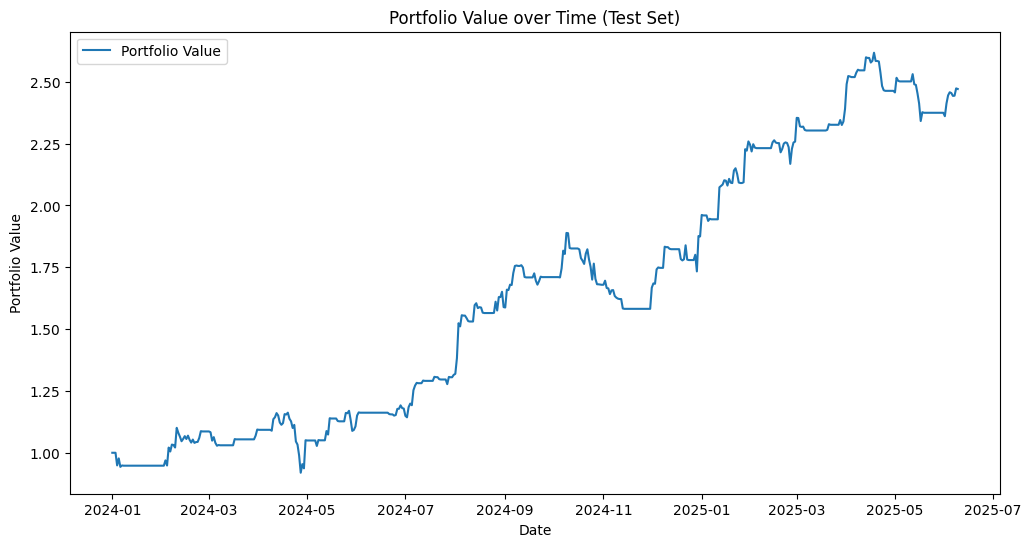

In [25]:
# Portfolio value over time

plt.figure(figsize=(12, 6))
plt.plot(
    test_df.index[: len(portfolio_values)], portfolio_values, label="Portfolio Value"
)
plt.title("Portfolio Value over Time (Test Set)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

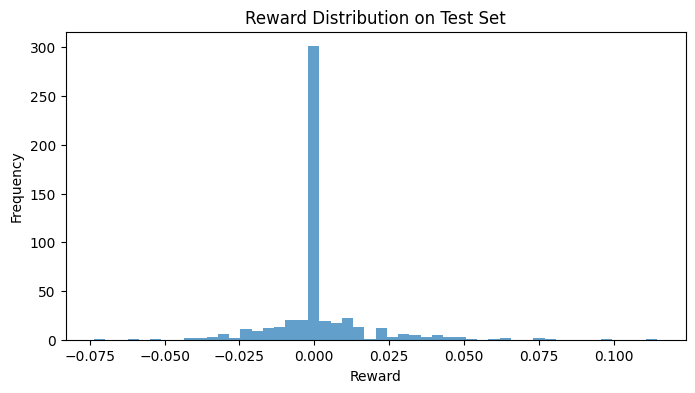

In [26]:
# reward distribution

plt.figure(figsize=(8, 4))
plt.hist(rewards, bins=50, alpha=0.7)
plt.title("Reward Distribution on Test Set")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.show()

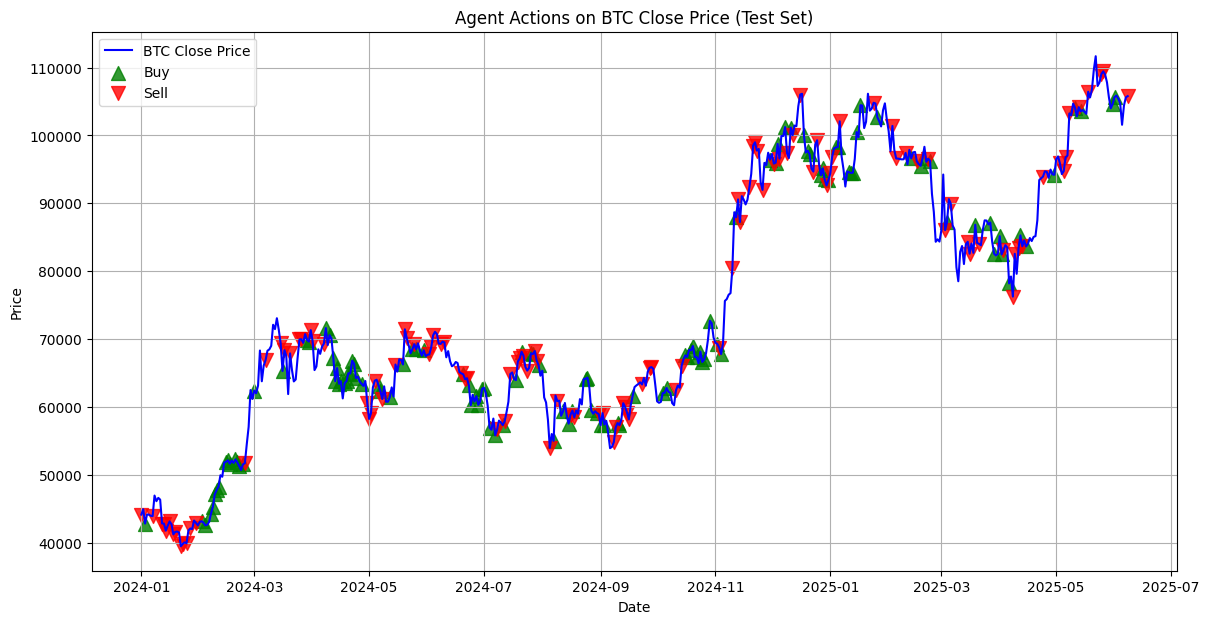

In [27]:
# Agent actions on BTC close price

# Extract closing prices for test period
prices = test_df["Close"].values[: len(actions_taken)]

# Identify buy and sell points
buy_points = np.where(actions_taken == 1)[0]
sell_points = np.where(actions_taken == 2)[0]

plt.figure(figsize=(14, 7))
plt.plot(test_df.index[: len(prices)], prices, label="BTC Close Price", color="blue")

# Plot buy markers
plt.scatter(
    test_df.index[buy_points],
    prices[buy_points],
    marker="^",
    color="green",
    label="Buy",
    alpha=0.8,
    s=100,
)

# Plot sell markers
plt.scatter(
    test_df.index[sell_points],
    prices[sell_points],
    marker="v",
    color="red",
    label="Sell",
    alpha=0.8,
    s=100,
)

plt.title("Agent Actions on BTC Close Price (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

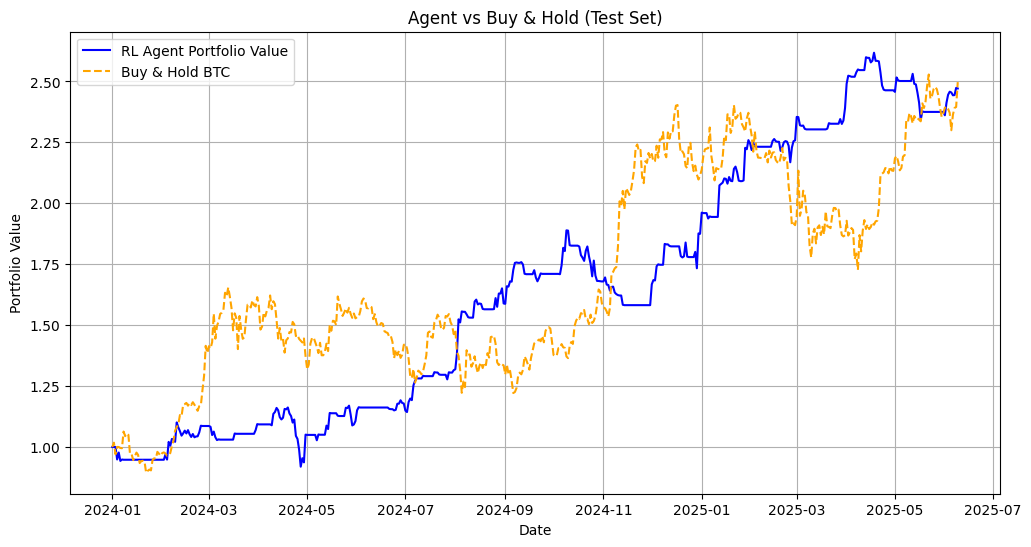

Agent Total Return: 147.12%
Buy & Hold Total Return: 149.72%


In [28]:
# Agent Equity Curve

agent_equity = portfolio_values

# Buy and Hold Equity Curve
initial_cash = agent_equity[0]
# Scale closing prices so that the first value equals initial cash
btc_prices = test_df["Close"].values[: len(agent_equity)]
buy_and_hold_equity = initial_cash * (btc_prices / btc_prices[0])

# Plot Both Curves
plt.figure(figsize=(12, 6))
plt.plot(
    test_df.index[: len(agent_equity)],
    agent_equity,
    label="RL Agent Portfolio Value",
    color="blue",
)
plt.plot(
    test_df.index[: len(agent_equity)],
    buy_and_hold_equity,
    label="Buy & Hold BTC",
    color="orange",
    linestyle="--",
)

plt.title("Agent vs Buy & Hold (Test Set)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

# Compute Summary Metrics
agent_return = (agent_equity[-1] / agent_equity[0] - 1) * 100
bh_return = (buy_and_hold_equity[-1] / buy_and_hold_equity[0] - 1) * 100

print(f"Agent Total Return: {agent_return:.2f}%")
print(f"Buy & Hold Total Return: {bh_return:.2f}%")